Importing necessry Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pickle
import re
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from nltk.translate.bleu_score import corpus_bleu

In [2]:
# import os

# folder_path = '/content/extracted_content_image_caption/Images'

# for filename in os.listdir(folder_path):
#   if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):  # Check for common image extensions
#     file_path = os.path.join(folder_path, filename)
#     os.remove(file_path)
#     print(f"Deleted: {filename}")

# print("All images deleted from the folder.")

In [3]:
import os

# Use a raw string to prevent the SyntaxWarning
path = r"E:\Mouli\image_captioningggggg"

# List all files and directories in the specified path
for item in os.listdir(path):
    print(item)

captions.txt
Images


# Exploratory data Analyis

**Reading and displaying lines from captions.txt**

In [4]:
with open(r'E:\Mouli\image_captioningggggg\captions.txt', 'r') as f:
    # ... (rest of your code)
    for i in range(5):  # Display the first 5 lines
        line = f.readline()
        print(line.strip())  # strip() removes leading/trailing whitespace

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .


**Displaying some image filenames from the Images directory**

In [5]:
import os

image_dir = r'E:\Mouli\image_captioningggggg\Images'
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

for i in range(5):  # Display the first 5 image filenames
    print(image_files[i])

1000268201_693b08cb0e.jpg
1001773457_577c3a7d70.jpg
1002674143_1b742ab4b8.jpg
1003163366_44323f5815.jpg
1007129816_e794419615.jpg


**Creating a Pandas DataFrame matching image names and captions**

In [11]:
import pandas as pd

# Read captions from captions.txt, skipping the header row
captions_dict = {}
with open(r'E:\Mouli\image_captioningggggg\captions.txt', 'r') as f:
    next(f)  # Skip the first line (header)
    for line in f:
        image_name, caption = line.strip().split(',', 1)  # Split at the first comma
        captions_dict[image_name] = caption

# Create DataFrame
df = pd.DataFrame(captions_dict.items(), columns=['image_name', 'caption'])

# Display the DataFrame
df.head()

image_name  \
0  1000268201_693b08cb0e.jpg   
1  1001773457_577c3a7d70.jpg   
2  1002674143_1b742ab4b8.jpg   
3  1003163366_44323f5815.jpg   
4  1007129816_e794419615.jpg   

                                             caption  
0  A little girl in a pink dress going into a woo...  
1    Two dogs on pavement moving toward each other .  
2  Young girl with pigtails painting outside in t...  
3  man laying on bench holding leash of dog sitti...  
4  The man with pierced ears is wearing glasses a...

**Pandas DataFrame matching image names and captions**

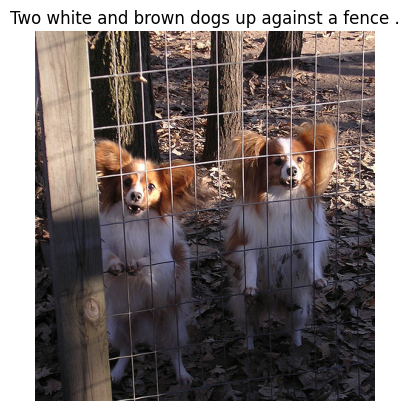

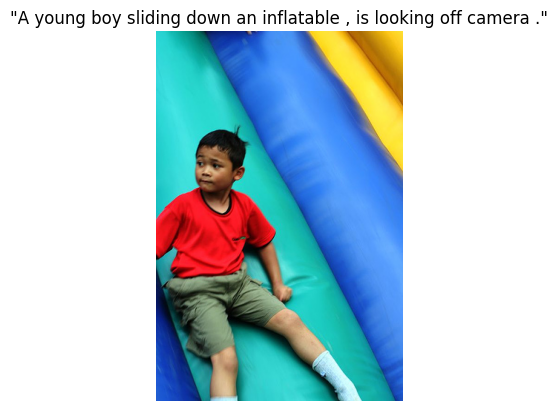

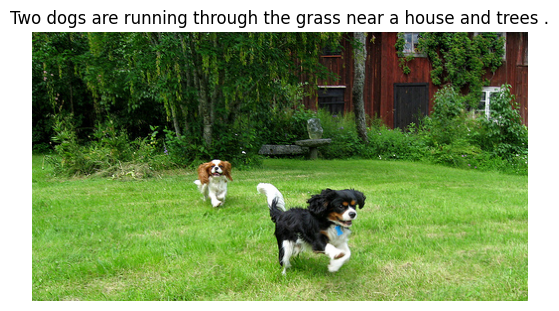

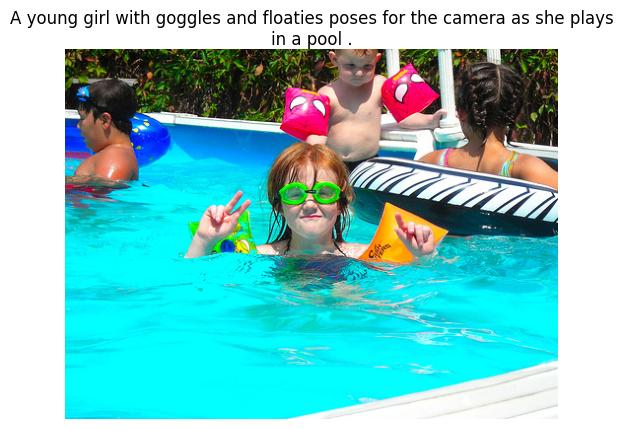

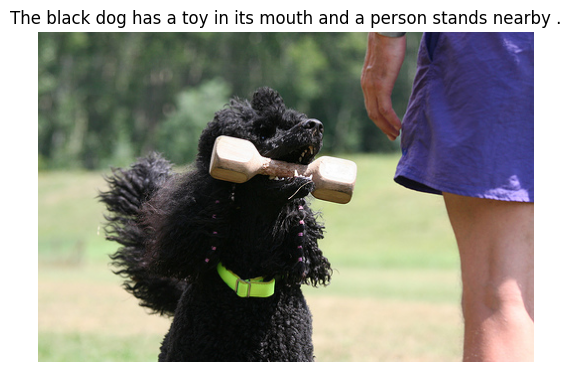

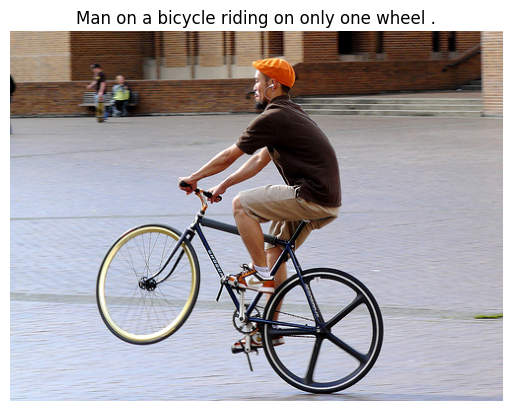

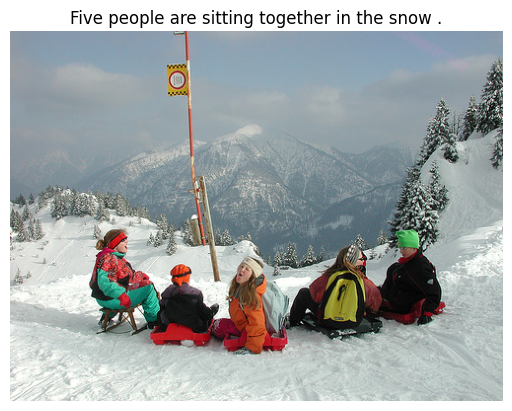

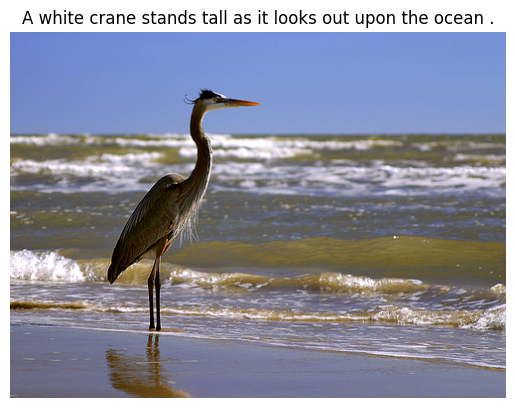

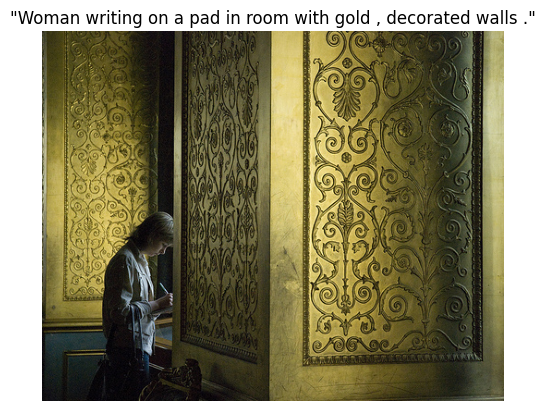

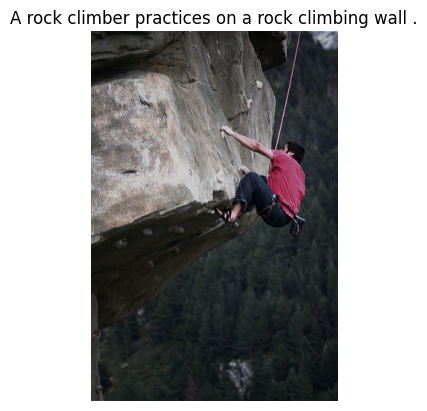

In [128]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd

# Assuming 'df' is already loaded as in your code

def display_image_with_caption(image_name, caption):
  """Displays an image with its caption."""
  image_dir = r'E:\Mouli\image_captioningggggg\Images'
  image_path = os.path.join(image_dir, image_name)

  try:
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axis ticks
    plt.title(caption, wrap=True)  # Set caption as title with wrapping
    plt.show()
  except FileNotFoundError:
    print(f"Image file '{image_name}' not found in {image_dir}")


# Display images with captions for the bottom 10 rows of the DataFrame
for index, row in df.tail(10).iterrows():
  display_image_with_caption(row['image_name'], row['caption'])

#Text Loading

In [131]:
# Load captions
with open(r'E:\Mouli\image_captioningggggg\captions.txt', 'r') as f:
    next(f)  # Skip header
    captions = f.read()

mapping = {}
for line in captions.split('\n'):
    if len(line) < 2:
        continue
    image_id, caption = line.split(',', 1)
    image_id = image_id.split('.')[0]
    mapping.setdefault(image_id, []).append(caption.strip())


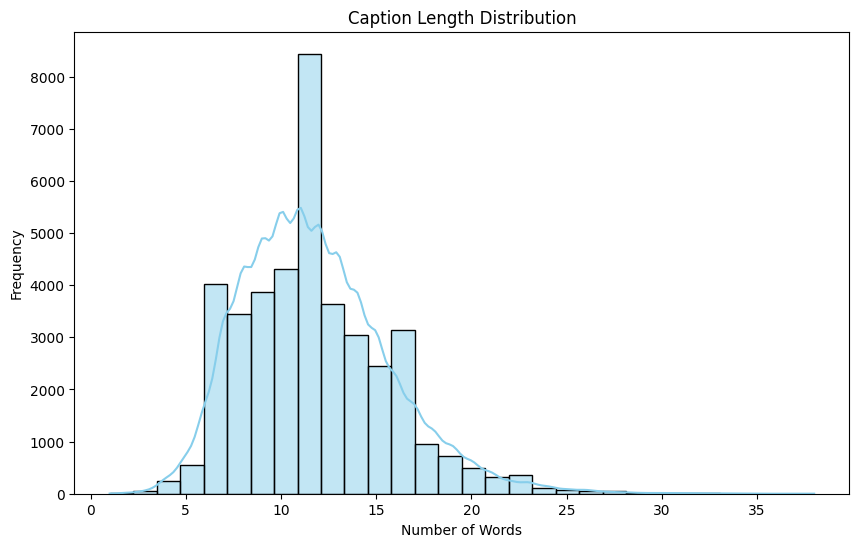

In [133]:
caption_lengths = [len(caption.split()) for captions in mapping.values() for caption in captions]

plt.figure(figsize=(10, 6))
sns.histplot(caption_lengths, kde=True, bins=30, color='skyblue')
plt.title('Caption Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


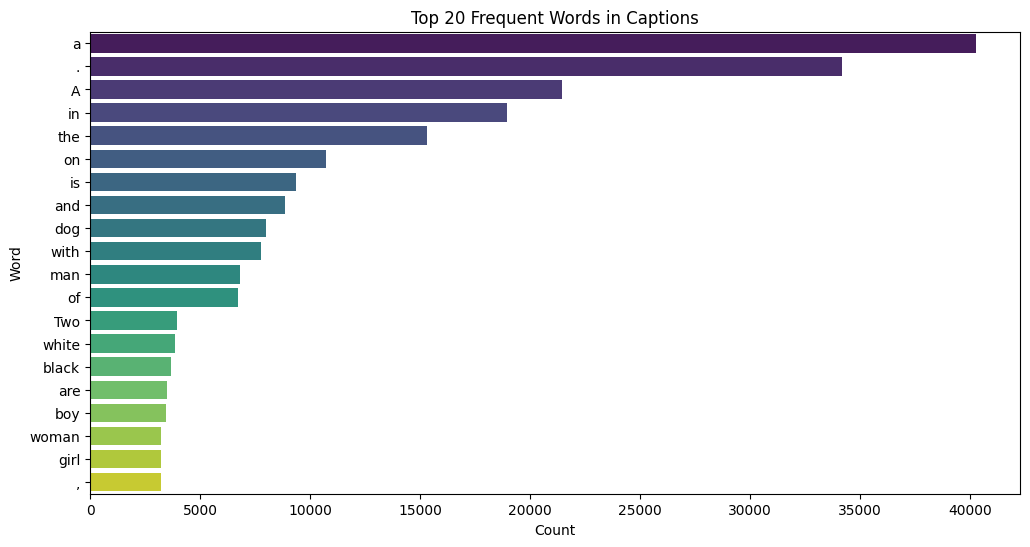

In [135]:
from collections import Counter

all_captions = [caption for captions in mapping.values() for caption in captions]
all_words = ' '.join(all_captions).split()
word_freq = Counter(all_words)

top_words = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=top_words, hue='Word', palette='viridis', legend=False) 

plt.title('Top 20 Frequent Words in Captions')
plt.show()

In [137]:
import matplotlib.image as mpimg
import os

def get_image_info(image_path):
    """Gets image width, height, and intensity information."""
    img = mpimg.imread(image_path)
    height, width, channels = img.shape  # Get image dimensions
    intensity_mean = img.mean()  # Calculate mean intensity

    print(f"Image: {image_path}")
    print(f"Width: {width} pixels")
    print(f"Height: {height} pixels")
    print(f"Mean Intensity: {intensity_mean}")


# Get information for the first image in the DataFrame
image_name = df['image_name'].iloc[1]  # Get the image name from the second row (index 1)
image_path = os.path.join(r'E:\Mouli\image_captioningggggg\Images', image_name)

get_image_info(image_path)

Image: E:\Mouli\image_captioningggggg\Images\1001773457_577c3a7d70.jpg
Width: 500 pixels
Height: 375 pixels
Mean Intensity: 126.68256355555556


In [139]:
import matplotlib.image as mpimg
import os

def get_image_info(image_path):
    """Gets image width, height, and mean intensity."""
    img = mpimg.imread(image_path)
    height, width, channels = img.shape  # Get image dimensions
    intensity_mean = img.mean()  # Calculate mean intensity
    return width, height, intensity_mean

# Add new columns to the DataFrame for width, height, and intensity
df['width'] = 0
df['height'] = 0
df['mean_intensity'] = 0.0

# Iterate through the DataFrame and get information for each image
for index, row in df.iterrows():
    image_name = row['image_name']
    image_path = os.path.join(r'E:\Mouli\image_captioningggggg\Images', image_name)
    width, height, intensity_mean = get_image_info(image_path)
    df.loc[index, 'width'] = width  # Update width column
    df.loc[index, 'height'] = height # Update height column
    df.loc[index, 'mean_intensity'] = intensity_mean # Update intensity column

# Display the updated DataFrame (with width, height, and intensity columns)
df.head()

image_name  \
0  1000268201_693b08cb0e.jpg   
1  1001773457_577c3a7d70.jpg   
2  1002674143_1b742ab4b8.jpg   
3  1003163366_44323f5815.jpg   
4  1007129816_e794419615.jpg   

                                             caption  width  height  \
0  A little girl in a pink dress going into a woo...    375     500   
1    Two dogs on pavement moving toward each other .    500     375   
2  Young girl with pigtails painting outside in t...    500     400   
3  man laying on bench holding leash of dog sitti...    500     410   
4  The man with pierced ears is wearing glasses a...    500     461   

   mean_intensity  
0       76.105159  
1      126.682564  
2      159.458392  
3      115.628797  
4      105.385925

Sactter Plot of mean intensity of images

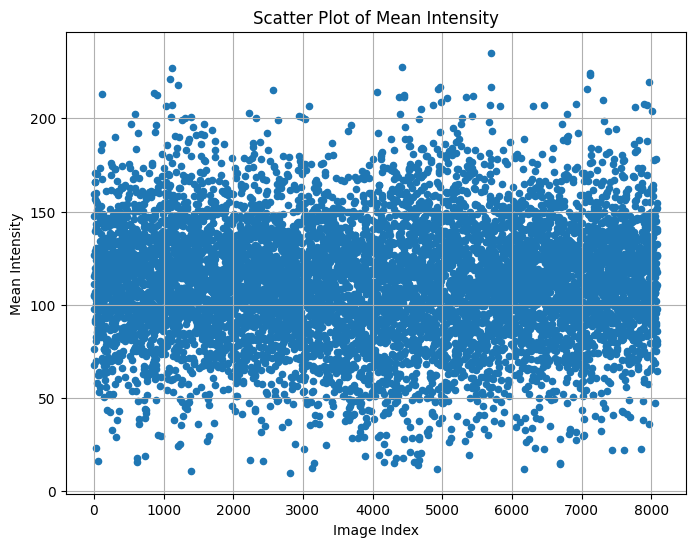

In [141]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with the 'mean_intensity' column

plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(df.index, df['mean_intensity'], marker='o', s=20)  # s is marker size
plt.xlabel("Image Index")
plt.ylabel("Mean Intensity")
plt.title("Scatter Plot of Mean Intensity")
plt.grid(True)
plt.show()

# Feature Extraction using CNN (InceptionV3)

**Loading Features**

In [21]:
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.models import Model
import numpy as np
import os
import pickle
from tqdm import tqdm  # For progress bar


# Load pre-trained models (without the classification layers)
base_model_inception = InceptionV3(weights='imagenet', include_top=False)
model_inception = Model(inputs=base_model_inception.input, outputs=base_model_inception.layers[-2].output)

base_model_vgg = VGG16(weights='imagenet', include_top=False)
model_vgg = Model(inputs=base_model_vgg.input, outputs=base_model_vgg.layers[-1].output)

def extract_features(img_path, model, preprocess_fn, target_size):
    """
    Extracts features from an image using the specified model.

    Args:
        img_path (str): Path to the image file.
        model (Model): Pre-trained model for feature extraction.
        preprocess_fn (function): Preprocessing function for the model.
        target_size (tuple): Target size for resizing images.

    Returns:
        numpy.ndarray: Flattened feature vector.
    """
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_fn(x)
    features = model.predict(x)
    return features.flatten()  # Flatten the features

# Directory containing images
image_dir = r'E:\Mouli\image_captioningggggg\Images'
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Dictionaries to store features for each model
features_inception = {}
features_vgg = {}

# Extract and save features for both models with a progress bar
print("Extracting features using InceptionV3 and VGG16...")
for image_file in tqdm(image_files, desc="Processing Images", unit="image"):
    image_path = os.path.join(image_dir, image_file)

    # Extract features using InceptionV3
    features_inception[image_file] = extract_features(
        image_path, model_inception, preprocess_inception, target_size=(299, 299)
    )

    # Extract features using VGG16
    features_vgg[image_file] = extract_features(
        image_path, model_vgg, preprocess_vgg, target_size=(224, 224)
    )

# Convert dictionaries to NumPy arrays
features_array_inception = np.array(list(features_inception.values()))
features_array_vgg = np.array(list(features_vgg.values()))

# Display shapes of the feature arrays
print(f"InceptionV3 features array shape: {features_array_inception.shape}")
print(f"VGG16 features array shape: {features_array_vgg.shape}")

# Save directory in Google Drive
save_dir = r"C:\Users\mouli\Downloads\ExtractedFeatures"
os.makedirs(save_dir, exist_ok=True)

# Save InceptionV3 features
np.save(os.path.join(save_dir, 'features_inception.npy'), features_array_inception)
with open(os.path.join(save_dir, 'features_inception_dict.pkl'), 'wb') as f:
    pickle.dump(features_inception, f)

# Save VGG16 features
np.save(os.path.join(save_dir, 'features_vgg.npy'), features_array_vgg)
with open(os.path.join(save_dir, 'features_vgg_dict.pkl'), 'wb') as f:
    pickle.dump(features_vgg, f)

print(f"Features saved successfully to: {save_dir}")


Extracting features using InceptionV3 and VGG16...


Processing Images:   0%|          | 0/8091 [00:00<?, ?image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Processing Images:   0%|          | 1/8091 [00:04<9:06:22,  4.05s/image]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:   0%|          | 2/8091 [00:04<4:05:44,  1.82s/image]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:   0%|          | 3/8091 [00:04<2:29:34,  1.11s/image]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:   0%|          | 4/8091 [00:04<1:44:48,  1.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:   0%|          | 5/8091 [00:05<1:20:06,  1.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   0%|          | 6/8091 [00:05<1:05:12,  2.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   0%|          | 7/8091 [00:05<57:13,  2.35image/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   0%|          | 8/8091 [00:06<53:02,  2.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   0%|          | 9/8091 [00:06<49:45,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:   0%|          | 10/8091 [00:06<46:08,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   0%|          | 11/8091 [00:06<44:21,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   0%|          | 12/8091 [00:07<43:27,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   0%|          | 13/8091 [00:07<42:39,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   0%|          | 14/8091 [00:07<45:19,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   0%|          | 15/8091 [00:08<44:24,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   0%|          | 16/8091 [00:08<43:02,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:   0%|          | 17/8091 [00:08<40:44,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:   0%|          | 18/8091 [00:09<38:20,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:   0%|          | 19/8091 [00:09<36:58,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:   0%|          | 20/8091 [00:09<36:21,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   0%|          | 21/8091 [00:09<36:15,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:   0%|          | 22/8091 [00:10<36:24,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   0%|          | 23/8091 [00:10<35:54,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   0%|          | 24/8091 [00:10<36:42,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   0%|          | 25/8091 [00:10<37:54,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:   0%|          | 26/8091 [00:11<39:10,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:   0%|          | 27/8091 [00:11<38:45,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   0%|          | 28/8091 [00:11<37:45,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   0%|          | 29/8091 [00:12<37:17,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   0%|          | 30/8091 [00:12<38:01,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:   0%|          | 31/8091 [00:12<37:14,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:   0%|          | 32/8091 [00:12<36:23,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:   0%|          | 33/8091 [00:13<35:24,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   0%|          | 34/8091 [00:13<35:39,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:   0%|          | 35/8091 [00:13<36:16,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:   0%|          | 36/8091 [00:13<35:44,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:   0%|          | 37/8091 [00:14<35:55,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:   0%|          | 38/8091 [00:14<35:02,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:   0%|          | 39/8091 [00:14<36:00,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:   0%|          | 40/8091 [00:14<35:19,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   1%|          | 41/8091 [00:15<35:49,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   1%|          | 42/8091 [00:15<36:59,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   1%|          | 43/8091 [00:15<38:20,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   1%|          | 44/8091 [00:16<40:29,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   1%|          | 45/8091 [00:16<42:14,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:   1%|          | 46/8091 [00:16<42:14,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   1%|          | 47/8091 [00:17<41:01,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   1%|          | 48/8091 [00:17<39:38,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   1%|          | 49/8091 [00:17<38:47,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   1%|          | 50/8091 [00:17<37:46,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   1%|          | 51/8091 [00:18<38:25,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:   1%|          | 52/8091 [00:18<39:02,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   1%|          | 53/8091 [00:18<40:39,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:   1%|          | 54/8091 [00:19<40:46,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   1%|          | 55/8091 [00:19<41:57,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   1%|          | 56/8091 [00:19<41:45,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   1%|          | 57/8091 [00:20<40:35,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:   1%|          | 58/8091 [00:20<38:44,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   1%|          | 59/8091 [00:20<37:40,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   1%|          | 60/8091 [00:20<38:37,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   1%|          | 61/8091 [00:21<38:09,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   1%|          | 62/8091 [00:21<37:45,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:   1%|          | 63/8091 [00:21<36:53,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:   1%|          | 64/8091 [00:22<36:34,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:   1%|          | 65/8091 [00:22<35:49,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   1%|          | 66/8091 [00:22<35:55,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   1%|          | 67/8091 [00:22<36:30,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:   1%|          | 68/8091 [00:23<36:02,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:   1%|          | 69/8091 [00:23<35:49,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:   1%|          | 70/8091 [00:23<36:47,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   1%|          | 71/8091 [00:23<36:59,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   1%|          | 72/8091 [00:24<37:47,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   1%|          | 73/8091 [00:24<37:53,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   1%|          | 74/8091 [00:24<40:20,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   1%|          | 75/8091 [00:25<40:36,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   1%|          | 76/8091 [00:25<40:49,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   1%|          | 77/8091 [00:25<40:59,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   1%|          | 78/8091 [00:26<40:48,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   1%|          | 79/8091 [00:26<40:39,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   1%|          | 80/8091 [00:26<39:17,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   1%|          | 81/8091 [00:26<37:17,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   1%|          | 82/8091 [00:27<36:24,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   1%|          | 83/8091 [00:27<36:17,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   1%|          | 84/8091 [00:27<36:38,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   1%|          | 85/8091 [00:27<37:01,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   1%|          | 86/8091 [00:28<40:26,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   1%|          | 87/8091 [00:28<40:24,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   1%|          | 88/8091 [00:28<39:57,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   1%|          | 89/8091 [00:29<39:48,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:   1%|          | 90/8091 [00:29<38:46,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   1%|          | 91/8091 [00:29<39:33,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   1%|          | 92/8091 [00:30<38:26,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:   1%|          | 93/8091 [00:30<38:08,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:   1%|          | 94/8091 [00:30<36:45,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   1%|          | 95/8091 [00:30<36:27,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   1%|          | 96/8091 [00:31<35:43,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   1%|          | 97/8091 [00:31<35:27,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:   1%|          | 98/8091 [00:31<34:54,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   1%|          | 99/8091 [00:31<35:14,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:   1%|          | 100/8091 [00:32<35:21,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   1%|          | 101/8091 [00:32<36:48,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   1%|▏         | 102/8091 [00:32<38:30,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   1%|▏         | 103/8091 [00:33<41:58,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   1%|▏         | 104/8091 [00:33<42:27,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   1%|▏         | 105/8091 [00:33<43:48,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   1%|▏         | 106/8091 [00:34<43:13,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   1%|▏         | 107/8091 [00:34<43:04,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   1%|▏         | 108/8091 [00:34<42:14,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   1%|▏         | 109/8091 [00:35<43:17,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   1%|▏         | 110/8091 [00:35<41:55,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   1%|▏         | 111/8091 [00:35<44:37,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   1%|▏         | 112/8091 [00:36<43:21,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   1%|▏         | 113/8091 [00:36<41:39,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:   1%|▏         | 114/8091 [00:36<39:45,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:   1%|▏         | 115/8091 [00:36<39:04,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   1%|▏         | 116/8091 [00:37<37:53,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   1%|▏         | 117/8091 [00:37<37:07,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:   1%|▏         | 118/8091 [00:37<36:21,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:   1%|▏         | 119/8091 [00:38<35:56,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:   1%|▏         | 120/8091 [00:38<36:33,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:   1%|▏         | 121/8091 [00:38<36:24,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   2%|▏         | 122/8091 [00:38<37:42,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 123/8091 [00:39<38:04,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:   2%|▏         | 124/8091 [00:39<37:55,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   2%|▏         | 125/8091 [00:39<37:53,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   2%|▏         | 126/8091 [00:40<37:58,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:   2%|▏         | 127/8091 [00:40<36:50,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:   2%|▏         | 128/8091 [00:40<36:55,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:   2%|▏         | 129/8091 [00:40<36:01,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   2%|▏         | 130/8091 [00:41<35:46,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:   2%|▏         | 131/8091 [00:41<36:18,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 132/8091 [00:41<35:46,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   2%|▏         | 133/8091 [00:41<36:36,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   2%|▏         | 134/8091 [00:42<36:00,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   2%|▏         | 135/8091 [00:42<36:32,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:   2%|▏         | 136/8091 [00:42<35:11,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:   2%|▏         | 137/8091 [00:42<35:15,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   2%|▏         | 138/8091 [00:43<35:59,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 139/8091 [00:43<35:32,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   2%|▏         | 140/8091 [00:43<35:28,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 141/8091 [00:44<36:02,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 142/8091 [00:44<36:04,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 143/8091 [00:44<36:09,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:   2%|▏         | 144/8091 [00:44<36:41,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:   2%|▏         | 145/8091 [00:45<37:34,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   2%|▏         | 146/8091 [00:45<37:06,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:   2%|▏         | 147/8091 [00:45<36:30,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   2%|▏         | 148/8091 [00:46<37:05,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:   2%|▏         | 149/8091 [00:46<35:50,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   2%|▏         | 150/8091 [00:46<35:49,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 151/8091 [00:46<36:56,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:   2%|▏         | 152/8091 [00:47<36:00,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:   2%|▏         | 153/8091 [00:47<34:45,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:   2%|▏         | 154/8091 [00:47<33:58,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   2%|▏         | 155/8091 [00:47<34:20,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   2%|▏         | 156/8091 [00:48<35:35,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   2%|▏         | 157/8091 [00:48<36:29,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   2%|▏         | 158/8091 [00:48<36:04,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   2%|▏         | 159/8091 [00:48<36:03,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   2%|▏         | 160/8091 [00:49<36:31,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:   2%|▏         | 161/8091 [00:49<36:37,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   2%|▏         | 162/8091 [00:49<36:52,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:   2%|▏         | 163/8091 [00:50<37:24,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:   2%|▏         | 164/8091 [00:50<36:29,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   2%|▏         | 165/8091 [00:50<36:45,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:   2%|▏         | 166/8091 [00:50<35:42,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 167/8091 [00:51<35:03,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   2%|▏         | 168/8091 [00:51<35:05,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 169/8091 [00:51<34:37,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   2%|▏         | 170/8091 [00:51<34:01,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 171/8091 [00:52<34:40,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:   2%|▏         | 172/8091 [00:52<34:11,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:   2%|▏         | 173/8091 [00:52<34:35,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   2%|▏         | 174/8091 [00:53<34:46,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   2%|▏         | 175/8091 [00:53<34:26,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   2%|▏         | 176/8091 [00:53<34:30,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:   2%|▏         | 177/8091 [00:53<34:48,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 178/8091 [00:54<34:55,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   2%|▏         | 179/8091 [00:54<35:06,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   2%|▏         | 180/8091 [00:54<35:51,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   2%|▏         | 181/8091 [00:54<36:18,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:   2%|▏         | 182/8091 [00:55<35:19,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   2%|▏         | 183/8091 [00:55<35:57,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:   2%|▏         | 184/8091 [00:55<35:22,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 185/8091 [00:55<35:02,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   2%|▏         | 186/8091 [00:56<35:39,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 187/8091 [00:56<35:24,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   2%|▏         | 188/8091 [00:56<34:56,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:   2%|▏         | 189/8091 [00:57<34:51,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   2%|▏         | 190/8091 [00:57<35:26,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   2%|▏         | 191/8091 [00:57<35:20,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   2%|▏         | 192/8091 [00:57<36:47,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:   2%|▏         | 193/8091 [00:58<35:46,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   2%|▏         | 194/8091 [00:58<37:00,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   2%|▏         | 195/8091 [00:58<39:02,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   2%|▏         | 196/8091 [00:59<38:36,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   2%|▏         | 197/8091 [00:59<39:36,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   2%|▏         | 198/8091 [00:59<39:30,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:   2%|▏         | 199/8091 [00:59<37:44,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   2%|▏         | 200/8091 [01:00<37:04,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   2%|▏         | 201/8091 [01:00<36:41,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   2%|▏         | 202/8091 [01:00<36:09,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:   3%|▎         | 203/8091 [01:01<36:36,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   3%|▎         | 204/8091 [01:01<35:53,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   3%|▎         | 205/8091 [01:01<35:37,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:   3%|▎         | 206/8091 [01:01<34:57,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   3%|▎         | 207/8091 [01:02<35:56,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   3%|▎         | 208/8091 [01:02<36:25,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   3%|▎         | 209/8091 [01:02<38:09,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   3%|▎         | 210/8091 [01:03<39:22,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   3%|▎         | 211/8091 [01:03<40:24,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   3%|▎         | 212/8091 [01:03<39:39,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Images:   3%|▎         | 213/8091 [01:03<41:27,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   3%|▎         | 214/8091 [01:04<46:13,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   3%|▎         | 215/8091 [01:04<45:12,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   3%|▎         | 216/8091 [01:05<43:27,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   3%|▎         | 217/8091 [01:05<41:21,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   3%|▎         | 218/8091 [01:05<40:08,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   3%|▎         | 219/8091 [01:05<42:36,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   3%|▎         | 220/8091 [01:06<42:28,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:   3%|▎         | 221/8091 [01:06<40:50,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:   3%|▎         | 222/8091 [01:06<39:36,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   3%|▎         | 223/8091 [01:07<38:09,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   3%|▎         | 224/8091 [01:07<36:43,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   3%|▎         | 225/8091 [01:07<36:53,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:   3%|▎         | 226/8091 [01:07<36:14,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   3%|▎         | 227/8091 [01:08<36:38,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   3%|▎         | 228/8091 [01:08<37:10,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:   3%|▎         | 229/8091 [01:08<36:03,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   3%|▎         | 230/8091 [01:09<37:21,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:   3%|▎         | 231/8091 [01:09<39:12,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   3%|▎         | 232/8091 [01:09<40:17,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   3%|▎         | 233/8091 [01:10<41:19,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   3%|▎         | 234/8091 [01:10<41:37,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   3%|▎         | 235/8091 [01:10<39:44,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   3%|▎         | 236/8091 [01:10<39:42,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   3%|▎         | 237/8091 [01:11<40:44,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   3%|▎         | 238/8091 [01:11<41:33,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Processing Images:   3%|▎         | 239/8091 [01:11<42:10,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   3%|▎         | 240/8091 [01:12<43:02,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   3%|▎         | 241/8091 [01:12<43:14,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Images:   3%|▎         | 242/8091 [01:13<45:10,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   3%|▎         | 243/8091 [01:13<46:09,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   3%|▎         | 244/8091 [01:13<46:11,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   3%|▎         | 245/8091 [01:14<45:46,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:   3%|▎         | 246/8091 [01:14<45:09,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   3%|▎         | 247/8091 [01:14<47:03,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   3%|▎         | 248/8091 [01:15<49:03,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   3%|▎         | 249/8091 [01:15<48:22,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   3%|▎         | 250/8091 [01:15<48:10,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   3%|▎         | 251/8091 [01:16<46:45,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:   3%|▎         | 252/8091 [01:16<45:05,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Processing Images:   3%|▎         | 253/8091 [01:17<49:17,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:   3%|▎         | 254/8091 [01:17<51:36,  2.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Images:   3%|▎         | 255/8091 [01:17<52:01,  2.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   3%|▎         | 256/8091 [01:18<49:31,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:   3%|▎         | 257/8091 [01:18<45:17,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   3%|▎         | 258/8091 [01:18<44:16,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   3%|▎         | 259/8091 [01:19<41:32,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   3%|▎         | 260/8091 [01:19<39:38,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   3%|▎         | 261/8091 [01:19<40:24,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   3%|▎         | 262/8091 [01:20<42:28,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:   3%|▎         | 263/8091 [01:20<43:17,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   3%|▎         | 264/8091 [01:20<45:22,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   3%|▎         | 265/8091 [01:21<43:51,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   3%|▎         | 266/8091 [01:21<41:53,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:   3%|▎         | 267/8091 [01:21<41:55,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   3%|▎         | 268/8091 [01:22<42:31,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:   3%|▎         | 269/8091 [01:22<46:25,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:   3%|▎         | 270/8091 [01:22<45:32,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   3%|▎         | 271/8091 [01:23<42:47,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   3%|▎         | 272/8091 [01:23<39:59,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:   3%|▎         | 273/8091 [01:23<38:35,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   3%|▎         | 274/8091 [01:23<36:42,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   3%|▎         | 275/8091 [01:24<36:44,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   3%|▎         | 276/8091 [01:24<36:04,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   3%|▎         | 277/8091 [01:24<36:54,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:   3%|▎         | 278/8091 [01:25<39:08,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:   3%|▎         | 279/8091 [01:25<40:36,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   3%|▎         | 280/8091 [01:25<42:22,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:   3%|▎         | 281/8091 [01:26<45:21,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   3%|▎         | 282/8091 [01:26<43:23,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   3%|▎         | 283/8091 [01:26<40:58,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Images:   4%|▎         | 284/8091 [01:27<44:03,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:   4%|▎         | 285/8091 [01:27<44:56,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   4%|▎         | 286/8091 [01:27<46:39,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:   4%|▎         | 287/8091 [01:28<48:02,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Images:   4%|▎         | 288/8091 [01:28<51:44,  2.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:   4%|▎         | 289/8091 [01:29<51:06,  2.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   4%|▎         | 290/8091 [01:29<48:04,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   4%|▎         | 291/8091 [01:29<47:09,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   4%|▎         | 292/8091 [01:30<46:13,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   4%|▎         | 293/8091 [01:30<48:13,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Processing Images:   4%|▎         | 294/8091 [01:30<47:41,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:   4%|▎         | 295/8091 [01:31<47:47,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:   4%|▎         | 296/8091 [01:31<47:37,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:   4%|▎         | 297/8091 [01:31<47:59,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   4%|▎         | 298/8091 [01:32<47:29,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:   4%|▎         | 299/8091 [01:32<47:36,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   4%|▎         | 300/8091 [01:33<47:13,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   4%|▎         | 301/8091 [01:33<46:31,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   4%|▎         | 302/8091 [01:33<46:00,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   4%|▎         | 303/8091 [01:34<45:38,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   4%|▍         | 304/8091 [01:34<47:03,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   4%|▍         | 305/8091 [01:34<45:44,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   4%|▍         | 306/8091 [01:35<45:05,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   4%|▍         | 307/8091 [01:35<43:52,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:   4%|▍         | 308/8091 [01:35<42:23,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   4%|▍         | 309/8091 [01:36<40:42,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   4%|▍         | 310/8091 [01:36<40:43,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Images:   4%|▍         | 311/8091 [01:36<42:51,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:   4%|▍         | 312/8091 [01:37<45:16,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   4%|▍         | 313/8091 [01:37<45:52,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Processing Images:   4%|▍         | 314/8091 [01:37<47:59,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   4%|▍         | 315/8091 [01:38<49:17,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   4%|▍         | 316/8091 [01:38<48:32,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   4%|▍         | 317/8091 [01:38<45:36,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   4%|▍         | 318/8091 [01:39<43:11,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   4%|▍         | 319/8091 [01:39<40:30,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   4%|▍         | 320/8091 [01:39<40:13,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   4%|▍         | 321/8091 [01:40<38:51,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   4%|▍         | 322/8091 [01:40<38:02,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   4%|▍         | 323/8091 [01:40<38:29,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   4%|▍         | 324/8091 [01:40<39:41,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   4%|▍         | 325/8091 [01:41<41:10,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   4%|▍         | 326/8091 [01:41<41:59,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   4%|▍         | 327/8091 [01:42<42:34,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:   4%|▍         | 328/8091 [01:42<43:12,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   4%|▍         | 329/8091 [01:42<43:54,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   4%|▍         | 330/8091 [01:43<43:51,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   4%|▍         | 331/8091 [01:43<43:09,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:   4%|▍         | 332/8091 [01:43<49:56,  2.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   4%|▍         | 333/8091 [01:44<47:56,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:   4%|▍         | 334/8091 [01:44<46:12,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   4%|▍         | 335/8091 [01:44<45:02,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   4%|▍         | 336/8091 [01:45<47:32,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   4%|▍         | 337/8091 [01:45<45:57,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   4%|▍         | 338/8091 [01:45<45:06,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   4%|▍         | 339/8091 [01:46<44:15,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   4%|▍         | 340/8091 [01:46<41:33,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   4%|▍         | 341/8091 [01:46<40:10,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   4%|▍         | 342/8091 [01:47<38:37,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   4%|▍         | 343/8091 [01:47<38:05,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   4%|▍         | 344/8091 [01:47<37:29,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   4%|▍         | 345/8091 [01:47<37:34,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   4%|▍         | 346/8091 [01:48<37:11,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   4%|▍         | 347/8091 [01:48<36:41,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   4%|▍         | 348/8091 [01:48<37:02,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   4%|▍         | 349/8091 [01:49<37:22,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   4%|▍         | 350/8091 [01:49<37:19,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   4%|▍         | 351/8091 [01:49<36:56,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   4%|▍         | 352/8091 [01:49<38:22,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   4%|▍         | 353/8091 [01:50<38:14,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   4%|▍         | 354/8091 [01:50<38:57,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   4%|▍         | 355/8091 [01:50<38:39,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   4%|▍         | 356/8091 [01:51<40:27,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   4%|▍         | 357/8091 [01:51<40:12,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:   4%|▍         | 358/8091 [01:51<40:05,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   4%|▍         | 359/8091 [01:52<39:55,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   4%|▍         | 360/8091 [01:52<41:58,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   4%|▍         | 361/8091 [01:52<41:26,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Images:   4%|▍         | 362/8091 [01:53<42:53,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Images:   4%|▍         | 363/8091 [01:53<45:13,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   4%|▍         | 364/8091 [01:53<46:14,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:   5%|▍         | 365/8091 [01:54<45:08,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   5%|▍         | 366/8091 [01:54<43:44,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   5%|▍         | 367/8091 [01:54<42:06,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:   5%|▍         | 368/8091 [01:55<40:57,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   5%|▍         | 369/8091 [01:55<40:47,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   5%|▍         | 370/8091 [01:55<39:48,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   5%|▍         | 371/8091 [01:56<39:20,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   5%|▍         | 372/8091 [01:56<38:08,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   5%|▍         | 373/8091 [01:56<37:42,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   5%|▍         | 374/8091 [01:56<37:27,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   5%|▍         | 375/8091 [01:57<37:17,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   5%|▍         | 376/8091 [01:57<38:39,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   5%|▍         | 377/8091 [01:57<38:45,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   5%|▍         | 378/8091 [01:58<38:06,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:   5%|▍         | 379/8091 [01:58<37:28,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   5%|▍         | 380/8091 [01:58<38:00,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:   5%|▍         | 381/8091 [01:59<37:56,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   5%|▍         | 382/8091 [01:59<37:15,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   5%|▍         | 383/8091 [01:59<38:12,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:   5%|▍         | 384/8091 [01:59<37:11,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   5%|▍         | 385/8091 [02:00<37:24,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:   5%|▍         | 386/8091 [02:00<36:56,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   5%|▍         | 387/8091 [02:00<37:41,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   5%|▍         | 388/8091 [02:01<38:29,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:   5%|▍         | 389/8091 [02:01<39:47,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   5%|▍         | 390/8091 [02:01<40:43,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   5%|▍         | 391/8091 [02:02<41:51,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:   5%|▍         | 392/8091 [02:02<43:27,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   5%|▍         | 393/8091 [02:02<42:44,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:   5%|▍         | 394/8091 [02:03<43:37,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   5%|▍         | 395/8091 [02:03<42:19,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   5%|▍         | 396/8091 [02:03<40:17,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   5%|▍         | 397/8091 [02:04<38:51,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:   5%|▍         | 398/8091 [02:04<39:28,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   5%|▍         | 399/8091 [02:04<38:15,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   5%|▍         | 400/8091 [02:04<37:27,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   5%|▍         | 401/8091 [02:05<37:05,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   5%|▍         | 402/8091 [02:05<37:07,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   5%|▍         | 403/8091 [02:05<38:08,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   5%|▍         | 404/8091 [02:06<38:29,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:   5%|▌         | 405/8091 [02:06<38:17,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   5%|▌         | 406/8091 [02:06<38:41,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   5%|▌         | 407/8091 [02:06<38:21,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   5%|▌         | 408/8091 [02:07<37:29,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   5%|▌         | 409/8091 [02:07<36:53,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   5%|▌         | 410/8091 [02:07<36:23,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   5%|▌         | 411/8091 [02:08<36:45,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:   5%|▌         | 412/8091 [02:08<37:52,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   5%|▌         | 413/8091 [02:08<38:33,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:   5%|▌         | 414/8091 [02:09<40:44,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   5%|▌         | 415/8091 [02:09<41:18,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   5%|▌         | 416/8091 [02:09<41:12,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   5%|▌         | 417/8091 [02:10<42:21,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   5%|▌         | 418/8091 [02:10<41:33,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   5%|▌         | 419/8091 [02:10<39:49,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   5%|▌         | 420/8091 [02:10<38:46,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   5%|▌         | 421/8091 [02:11<37:31,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   5%|▌         | 422/8091 [02:11<37:11,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   5%|▌         | 423/8091 [02:11<36:59,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   5%|▌         | 424/8091 [02:12<37:22,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:   5%|▌         | 425/8091 [02:12<36:45,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   5%|▌         | 426/8091 [02:12<36:59,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   5%|▌         | 427/8091 [02:12<37:19,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   5%|▌         | 428/8091 [02:13<36:15,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:   5%|▌         | 429/8091 [02:13<36:11,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:   5%|▌         | 430/8091 [02:13<36:16,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:   5%|▌         | 431/8091 [02:14<36:32,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   5%|▌         | 432/8091 [02:14<36:49,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   5%|▌         | 433/8091 [02:14<36:29,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:   5%|▌         | 434/8091 [02:14<36:21,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   5%|▌         | 435/8091 [02:15<36:55,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   5%|▌         | 436/8091 [02:15<37:51,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   5%|▌         | 437/8091 [02:15<40:19,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   5%|▌         | 438/8091 [02:16<40:33,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   5%|▌         | 439/8091 [02:16<40:36,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   5%|▌         | 440/8091 [02:16<40:30,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   5%|▌         | 441/8091 [02:17<40:15,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   5%|▌         | 442/8091 [02:17<40:07,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   5%|▌         | 443/8091 [02:17<39:50,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   5%|▌         | 444/8091 [02:18<39:31,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   5%|▌         | 445/8091 [02:18<38:39,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   6%|▌         | 446/8091 [02:18<38:56,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   6%|▌         | 447/8091 [02:19<38:52,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   6%|▌         | 448/8091 [02:19<38:21,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:   6%|▌         | 449/8091 [02:19<37:35,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   6%|▌         | 450/8091 [02:19<37:42,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   6%|▌         | 451/8091 [02:20<37:59,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   6%|▌         | 452/8091 [02:20<37:46,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   6%|▌         | 453/8091 [02:20<37:16,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:   6%|▌         | 454/8091 [02:21<36:37,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   6%|▌         | 455/8091 [02:21<37:38,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   6%|▌         | 456/8091 [02:21<37:21,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   6%|▌         | 457/8091 [02:21<36:59,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   6%|▌         | 458/8091 [02:22<37:26,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   6%|▌         | 459/8091 [02:22<36:56,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   6%|▌         | 460/8091 [02:22<37:32,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   6%|▌         | 461/8091 [02:23<38:39,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   6%|▌         | 462/8091 [02:23<37:41,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   6%|▌         | 463/8091 [02:23<37:14,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   6%|▌         | 464/8091 [02:24<39:02,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   6%|▌         | 465/8091 [02:24<39:34,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   6%|▌         | 466/8091 [02:24<39:09,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   6%|▌         | 467/8091 [02:25<39:35,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   6%|▌         | 468/8091 [02:25<39:36,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   6%|▌         | 469/8091 [02:25<39:04,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   6%|▌         | 470/8091 [02:25<40:11,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   6%|▌         | 471/8091 [02:26<41:39,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Images:   6%|▌         | 472/8091 [02:26<41:34,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   6%|▌         | 473/8091 [02:26<40:30,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   6%|▌         | 474/8091 [02:27<39:02,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   6%|▌         | 475/8091 [02:27<39:13,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   6%|▌         | 476/8091 [02:27<38:28,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:   6%|▌         | 477/8091 [02:28<37:59,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   6%|▌         | 478/8091 [02:28<37:16,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   6%|▌         | 479/8091 [02:28<38:43,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   6%|▌         | 480/8091 [02:29<40:03,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   6%|▌         | 481/8091 [02:29<42:10,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   6%|▌         | 482/8091 [02:29<41:23,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   6%|▌         | 483/8091 [02:30<40:28,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   6%|▌         | 484/8091 [02:30<39:53,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   6%|▌         | 485/8091 [02:30<39:40,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   6%|▌         | 486/8091 [02:30<38:45,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:   6%|▌         | 487/8091 [02:31<37:55,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   6%|▌         | 488/8091 [02:31<37:48,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   6%|▌         | 489/8091 [02:31<37:45,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   6%|▌         | 490/8091 [02:32<38:39,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   6%|▌         | 491/8091 [02:32<40:43,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   6%|▌         | 492/8091 [02:32<39:52,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   6%|▌         | 493/8091 [02:33<41:19,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Processing Images:   6%|▌         | 494/8091 [02:33<44:13,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Processing Images:   6%|▌         | 495/8091 [02:34<47:53,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   6%|▌         | 496/8091 [02:34<48:04,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   6%|▌         | 497/8091 [02:34<44:42,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   6%|▌         | 498/8091 [02:35<46:05,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   6%|▌         | 499/8091 [02:35<44:47,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   6%|▌         | 500/8091 [02:35<42:28,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:   6%|▌         | 501/8091 [02:36<42:53,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   6%|▌         | 502/8091 [02:36<41:55,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:   6%|▌         | 503/8091 [02:36<41:06,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Images:   6%|▌         | 504/8091 [02:37<43:34,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:   6%|▌         | 505/8091 [02:37<46:56,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   6%|▋         | 506/8091 [02:37<44:03,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Processing Images:   6%|▋         | 507/8091 [02:38<43:34,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   6%|▋         | 508/8091 [02:38<40:58,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   6%|▋         | 509/8091 [02:38<39:42,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   6%|▋         | 510/8091 [02:38<37:53,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   6%|▋         | 511/8091 [02:39<37:08,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:   6%|▋         | 512/8091 [02:39<37:12,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   6%|▋         | 513/8091 [02:39<38:41,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   6%|▋         | 514/8091 [02:40<39:26,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   6%|▋         | 515/8091 [02:40<39:32,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   6%|▋         | 516/8091 [02:40<38:42,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:   6%|▋         | 517/8091 [02:41<40:53,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Images:   6%|▋         | 518/8091 [02:41<47:43,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Processing Images:   6%|▋         | 519/8091 [02:42<52:39,  2.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   6%|▋         | 520/8091 [02:42<50:26,  2.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   6%|▋         | 521/8091 [02:42<48:20,  2.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   6%|▋         | 522/8091 [02:43<44:52,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   6%|▋         | 523/8091 [02:43<41:26,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   6%|▋         | 524/8091 [02:43<40:04,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Processing Images:   6%|▋         | 525/8091 [02:44<43:22,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   7%|▋         | 526/8091 [02:44<45:24,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Images:   7%|▋         | 527/8091 [02:44<46:30,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   7%|▋         | 528/8091 [02:45<50:38,  2.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Images:   7%|▋         | 529/8091 [02:45<53:37,  2.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:   7%|▋         | 530/8091 [02:46<51:52,  2.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:   7%|▋         | 531/8091 [02:46<50:30,  2.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Processing Images:   7%|▋         | 532/8091 [02:47<51:08,  2.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Images:   7%|▋         | 533/8091 [02:47<54:09,  2.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:   7%|▋         | 534/8091 [02:47<53:12,  2.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:   7%|▋         | 535/8091 [02:48<52:21,  2.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:   7%|▋         | 536/8091 [02:48<52:41,  2.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:   7%|▋         | 537/8091 [02:49<52:14,  2.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:   7%|▋         | 538/8091 [02:49<50:33,  2.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   7%|▋         | 539/8091 [02:49<48:46,  2.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   7%|▋         | 540/8091 [02:50<45:33,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   7%|▋         | 541/8091 [02:50<43:00,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   7%|▋         | 542/8091 [02:50<41:49,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   7%|▋         | 543/8091 [02:51<41:34,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   7%|▋         | 544/8091 [02:51<40:23,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:   7%|▋         | 545/8091 [02:51<39:41,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Images:   7%|▋         | 546/8091 [02:52<42:27,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   7%|▋         | 547/8091 [02:52<43:42,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   7%|▋         | 548/8091 [02:52<42:13,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   7%|▋         | 549/8091 [02:53<41:26,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   7%|▋         | 550/8091 [02:53<41:10,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   7%|▋         | 551/8091 [02:53<40:08,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   7%|▋         | 552/8091 [02:54<39:30,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   7%|▋         | 553/8091 [02:54<38:36,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   7%|▋         | 554/8091 [02:54<37:19,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   7%|▋         | 555/8091 [02:54<37:47,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   7%|▋         | 556/8091 [02:55<38:42,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   7%|▋         | 557/8091 [02:55<38:06,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   7%|▋         | 558/8091 [02:55<38:12,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:   7%|▋         | 559/8091 [02:56<38:57,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   7%|▋         | 560/8091 [02:56<39:28,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   7%|▋         | 561/8091 [02:56<40:13,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   7%|▋         | 562/8091 [02:57<39:28,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:   7%|▋         | 563/8091 [02:57<42:01,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   7%|▋         | 564/8091 [02:57<40:14,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   7%|▋         | 565/8091 [02:58<40:01,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   7%|▋         | 566/8091 [02:58<40:45,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   7%|▋         | 567/8091 [02:58<40:37,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:   7%|▋         | 568/8091 [02:59<46:42,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:   7%|▋         | 569/8091 [02:59<46:42,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:   7%|▋         | 570/8091 [03:00<46:54,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   7%|▋         | 571/8091 [03:00<46:20,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:   7%|▋         | 572/8091 [03:00<47:26,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   7%|▋         | 573/8091 [03:01<46:37,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   7%|▋         | 574/8091 [03:01<45:17,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   7%|▋         | 575/8091 [03:01<42:41,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   7%|▋         | 576/8091 [03:02<42:11,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   7%|▋         | 577/8091 [03:02<42:45,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   7%|▋         | 578/8091 [03:02<43:19,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   7%|▋         | 579/8091 [03:03<43:33,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   7%|▋         | 580/8091 [03:03<43:55,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:   7%|▋         | 581/8091 [03:03<43:55,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   7%|▋         | 582/8091 [03:04<42:46,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Images:   7%|▋         | 583/8091 [03:04<42:57,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   7%|▋         | 584/8091 [03:04<44:03,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:   7%|▋         | 585/8091 [03:05<44:07,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   7%|▋         | 586/8091 [03:05<44:02,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:   7%|▋         | 587/8091 [03:05<43:21,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   7%|▋         | 588/8091 [03:06<44:09,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:   7%|▋         | 589/8091 [03:06<44:32,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Images:   7%|▋         | 590/8091 [03:07<48:24,  2.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   7%|▋         | 591/8091 [03:07<48:27,  2.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   7%|▋         | 592/8091 [03:07<46:29,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:   7%|▋         | 593/8091 [03:08<47:46,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   7%|▋         | 594/8091 [03:08<46:52,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Processing Images:   7%|▋         | 595/8091 [03:08<45:56,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   7%|▋         | 596/8091 [03:09<44:47,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   7%|▋         | 597/8091 [03:09<41:59,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   7%|▋         | 598/8091 [03:09<40:24,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:   7%|▋         | 599/8091 [03:10<38:00,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   7%|▋         | 600/8091 [03:10<37:10,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   7%|▋         | 601/8091 [03:10<36:53,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:   7%|▋         | 602/8091 [03:11<37:52,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   7%|▋         | 603/8091 [03:11<36:29,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   7%|▋         | 604/8091 [03:11<36:06,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   7%|▋         | 605/8091 [03:11<36:49,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   7%|▋         | 606/8091 [03:12<36:22,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   8%|▊         | 607/8091 [03:12<37:18,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:   8%|▊         | 608/8091 [03:12<37:33,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   8%|▊         | 609/8091 [03:13<37:20,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:   8%|▊         | 610/8091 [03:13<37:19,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   8%|▊         | 611/8091 [03:13<39:06,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   8%|▊         | 612/8091 [03:14<39:31,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   8%|▊         | 613/8091 [03:14<38:57,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:   8%|▊         | 614/8091 [03:14<41:24,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   8%|▊         | 615/8091 [03:15<41:39,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   8%|▊         | 616/8091 [03:15<39:59,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   8%|▊         | 617/8091 [03:15<39:25,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Images:   8%|▊         | 618/8091 [03:16<40:20,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   8%|▊         | 619/8091 [03:16<41:18,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:   8%|▊         | 620/8091 [03:16<41:50,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   8%|▊         | 621/8091 [03:17<41:58,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   8%|▊         | 622/8091 [03:17<42:25,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:   8%|▊         | 623/8091 [03:17<43:07,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Processing Images:   8%|▊         | 624/8091 [03:18<45:58,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:   8%|▊         | 625/8091 [03:18<46:53,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   8%|▊         | 626/8091 [03:19<47:56,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   8%|▊         | 627/8091 [03:19<45:59,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:   8%|▊         | 628/8091 [03:19<45:20,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Images:   8%|▊         | 629/8091 [03:20<46:11,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Images:   8%|▊         | 630/8091 [03:20<46:48,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   8%|▊         | 631/8091 [03:20<45:24,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:   8%|▊         | 632/8091 [03:21<44:11,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   8%|▊         | 633/8091 [03:21<42:15,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   8%|▊         | 634/8091 [03:21<39:59,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   8%|▊         | 635/8091 [03:22<38:58,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   8%|▊         | 636/8091 [03:22<38:18,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   8%|▊         | 637/8091 [03:22<37:00,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   8%|▊         | 638/8091 [03:22<36:26,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   8%|▊         | 639/8091 [03:23<36:57,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   8%|▊         | 640/8091 [03:23<37:06,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   8%|▊         | 641/8091 [03:23<36:26,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:   8%|▊         | 642/8091 [03:24<36:55,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:   8%|▊         | 643/8091 [03:24<35:47,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   8%|▊         | 644/8091 [03:24<35:37,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   8%|▊         | 645/8091 [03:24<36:00,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   8%|▊         | 646/8091 [03:25<35:19,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   8%|▊         | 647/8091 [03:25<35:42,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   8%|▊         | 648/8091 [03:25<35:53,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   8%|▊         | 649/8091 [03:26<36:28,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   8%|▊         | 650/8091 [03:26<35:56,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:   8%|▊         | 651/8091 [03:26<36:20,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:   8%|▊         | 652/8091 [03:26<36:48,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:   8%|▊         | 653/8091 [03:27<37:37,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   8%|▊         | 654/8091 [03:27<37:31,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   8%|▊         | 655/8091 [03:27<39:23,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:   8%|▊         | 656/8091 [03:28<41:58,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   8%|▊         | 657/8091 [03:28<42:13,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   8%|▊         | 658/8091 [03:28<41:24,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   8%|▊         | 659/8091 [03:29<41:04,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:   8%|▊         | 660/8091 [03:29<40:12,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   8%|▊         | 661/8091 [03:29<40:01,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   8%|▊         | 662/8091 [03:30<40:21,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   8%|▊         | 663/8091 [03:30<39:46,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   8%|▊         | 664/8091 [03:30<38:45,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   8%|▊         | 665/8091 [03:31<38:13,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   8%|▊         | 666/8091 [03:31<37:23,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   8%|▊         | 667/8091 [03:31<37:22,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:   8%|▊         | 668/8091 [03:32<37:33,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   8%|▊         | 669/8091 [03:32<36:51,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   8%|▊         | 670/8091 [03:32<37:03,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   8%|▊         | 671/8091 [03:32<37:44,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Processing Images:   8%|▊         | 672/8091 [03:33<43:47,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Images:   8%|▊         | 673/8091 [03:33<48:45,  2.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:   8%|▊         | 674/8091 [03:34<48:27,  2.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Processing Images:   8%|▊         | 675/8091 [03:34<47:20,  2.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:   8%|▊         | 676/8091 [03:35<46:30,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:   8%|▊         | 677/8091 [03:35<45:36,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:   8%|▊         | 678/8091 [03:35<46:53,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   8%|▊         | 679/8091 [03:36<44:49,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   8%|▊         | 680/8091 [03:36<42:14,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:   8%|▊         | 681/8091 [03:36<40:56,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   8%|▊         | 682/8091 [03:37<40:01,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   8%|▊         | 683/8091 [03:37<39:34,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   8%|▊         | 684/8091 [03:37<38:38,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   8%|▊         | 685/8091 [03:37<37:49,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   8%|▊         | 686/8091 [03:38<37:55,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:   8%|▊         | 687/8091 [03:38<37:40,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:   9%|▊         | 688/8091 [03:38<37:13,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   9%|▊         | 689/8091 [03:39<36:00,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   9%|▊         | 690/8091 [03:39<35:19,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:   9%|▊         | 691/8091 [03:39<35:59,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:   9%|▊         | 692/8091 [03:39<36:02,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   9%|▊         | 693/8091 [03:40<36:27,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   9%|▊         | 694/8091 [03:40<36:46,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   9%|▊         | 695/8091 [03:40<36:40,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   9%|▊         | 696/8091 [03:41<35:59,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   9%|▊         | 697/8091 [03:41<36:29,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   9%|▊         | 698/8091 [03:41<41:09,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Images:   9%|▊         | 699/8091 [03:42<47:33,  2.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:   9%|▊         | 700/8091 [03:42<46:49,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   9%|▊         | 701/8091 [03:43<45:04,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   9%|▊         | 702/8091 [03:43<42:52,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:   9%|▊         | 703/8091 [03:43<41:56,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:   9%|▊         | 704/8091 [03:44<42:22,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   9%|▊         | 705/8091 [03:44<42:12,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:   9%|▊         | 706/8091 [03:44<41:50,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:   9%|▊         | 707/8091 [03:45<44:36,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Processing Images:   9%|▉         | 708/8091 [03:45<46:03,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   9%|▉         | 709/8091 [03:45<46:50,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   9%|▉         | 710/8091 [03:46<46:15,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:   9%|▉         | 711/8091 [03:46<48:02,  2.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:   9%|▉         | 712/8091 [03:47<47:27,  2.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   9%|▉         | 713/8091 [03:47<44:43,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   9%|▉         | 714/8091 [03:47<44:16,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   9%|▉         | 715/8091 [03:48<41:05,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:   9%|▉         | 716/8091 [03:48<40:01,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   9%|▉         | 717/8091 [03:48<38:31,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:   9%|▉         | 718/8091 [03:48<37:21,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:   9%|▉         | 719/8091 [03:49<37:27,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:   9%|▉         | 720/8091 [03:49<36:45,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   9%|▉         | 721/8091 [03:49<36:15,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   9%|▉         | 722/8091 [03:50<37:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   9%|▉         | 723/8091 [03:50<36:27,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   9%|▉         | 724/8091 [03:50<36:43,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:   9%|▉         | 725/8091 [03:51<36:59,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   9%|▉         | 726/8091 [03:51<37:32,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:   9%|▉         | 727/8091 [03:51<37:36,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   9%|▉         | 728/8091 [03:51<37:05,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:   9%|▉         | 729/8091 [03:52<37:26,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:   9%|▉         | 730/8091 [03:52<35:50,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   9%|▉         | 731/8091 [03:52<37:20,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   9%|▉         | 732/8091 [03:53<36:35,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   9%|▉         | 733/8091 [03:53<36:03,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:   9%|▉         | 734/8091 [03:53<36:18,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   9%|▉         | 735/8091 [03:54<36:30,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   9%|▉         | 736/8091 [03:54<36:58,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   9%|▉         | 737/8091 [03:54<36:34,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   9%|▉         | 738/8091 [03:54<36:38,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   9%|▉         | 739/8091 [03:55<37:50,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   9%|▉         | 740/8091 [03:55<37:30,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   9%|▉         | 741/8091 [03:55<36:42,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:   9%|▉         | 742/8091 [03:56<36:45,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:   9%|▉         | 743/8091 [03:56<35:40,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   9%|▉         | 744/8091 [03:56<36:02,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:   9%|▉         | 745/8091 [03:57<36:03,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   9%|▉         | 746/8091 [03:57<37:00,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   9%|▉         | 747/8091 [03:57<37:52,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   9%|▉         | 748/8091 [03:57<36:25,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:   9%|▉         | 749/8091 [03:58<36:35,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:   9%|▉         | 750/8091 [03:58<36:06,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:   9%|▉         | 751/8091 [03:58<36:56,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   9%|▉         | 752/8091 [03:59<36:18,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   9%|▉         | 753/8091 [03:59<37:38,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   9%|▉         | 754/8091 [03:59<37:10,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   9%|▉         | 755/8091 [04:00<37:12,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   9%|▉         | 756/8091 [04:00<37:18,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:   9%|▉         | 757/8091 [04:00<36:39,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:   9%|▉         | 758/8091 [04:00<37:14,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   9%|▉         | 759/8091 [04:01<36:46,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   9%|▉         | 760/8091 [04:01<36:45,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:   9%|▉         | 761/8091 [04:01<37:57,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   9%|▉         | 762/8091 [04:02<38:03,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:   9%|▉         | 763/8091 [04:02<37:07,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:   9%|▉         | 764/8091 [04:02<36:47,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:   9%|▉         | 765/8091 [04:03<37:19,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:   9%|▉         | 766/8091 [04:03<38:07,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:   9%|▉         | 767/8091 [04:03<36:49,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:   9%|▉         | 768/8091 [04:04<37:01,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  10%|▉         | 769/8091 [04:04<37:12,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  10%|▉         | 770/8091 [04:04<36:35,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  10%|▉         | 771/8091 [04:04<37:01,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  10%|▉         | 772/8091 [04:05<37:07,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  10%|▉         | 773/8091 [04:05<36:05,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  10%|▉         | 774/8091 [04:05<36:29,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:  10%|▉         | 775/8091 [04:06<36:47,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  10%|▉         | 776/8091 [04:06<36:09,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  10%|▉         | 777/8091 [04:06<35:44,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  10%|▉         | 778/8091 [04:07<36:53,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  10%|▉         | 779/8091 [04:07<37:40,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  10%|▉         | 780/8091 [04:07<37:55,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  10%|▉         | 781/8091 [04:07<38:26,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  10%|▉         | 782/8091 [04:08<37:43,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  10%|▉         | 783/8091 [04:08<37:58,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  10%|▉         | 784/8091 [04:08<37:07,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  10%|▉         | 785/8091 [04:09<36:24,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  10%|▉         | 786/8091 [04:09<35:53,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  10%|▉         | 787/8091 [04:09<34:56,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  10%|▉         | 788/8091 [04:10<35:27,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  10%|▉         | 789/8091 [04:10<35:14,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  10%|▉         | 790/8091 [04:10<34:30,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  10%|▉         | 791/8091 [04:10<35:41,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  10%|▉         | 792/8091 [04:11<36:49,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  10%|▉         | 793/8091 [04:11<35:54,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  10%|▉         | 794/8091 [04:11<34:56,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  10%|▉         | 795/8091 [04:12<34:52,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  10%|▉         | 796/8091 [04:12<36:17,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  10%|▉         | 797/8091 [04:12<35:20,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  10%|▉         | 798/8091 [04:12<35:08,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  10%|▉         | 799/8091 [04:13<35:34,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  10%|▉         | 800/8091 [04:13<34:41,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  10%|▉         | 801/8091 [04:13<34:48,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  10%|▉         | 802/8091 [04:14<35:09,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  10%|▉         | 803/8091 [04:14<35:43,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  10%|▉         | 804/8091 [04:14<35:21,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  10%|▉         | 805/8091 [04:14<34:49,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  10%|▉         | 806/8091 [04:15<35:32,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  10%|▉         | 807/8091 [04:15<34:53,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  10%|▉         | 808/8091 [04:15<35:58,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  10%|▉         | 809/8091 [04:16<36:17,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  10%|█         | 810/8091 [04:16<36:53,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  10%|█         | 811/8091 [04:16<36:49,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  10%|█         | 812/8091 [04:17<36:51,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  10%|█         | 813/8091 [04:17<37:09,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  10%|█         | 814/8091 [04:17<36:28,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  10%|█         | 815/8091 [04:18<38:14,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  10%|█         | 816/8091 [04:18<37:18,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  10%|█         | 817/8091 [04:18<37:36,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  10%|█         | 818/8091 [04:18<37:03,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  10%|█         | 819/8091 [04:19<37:04,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  10%|█         | 820/8091 [04:19<36:39,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  10%|█         | 821/8091 [04:19<37:08,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  10%|█         | 822/8091 [04:20<36:44,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  10%|█         | 823/8091 [04:20<37:34,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  10%|█         | 824/8091 [04:20<36:59,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  10%|█         | 825/8091 [04:21<36:58,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  10%|█         | 826/8091 [04:21<36:57,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  10%|█         | 827/8091 [04:21<36:35,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  10%|█         | 828/8091 [04:21<36:01,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  10%|█         | 829/8091 [04:22<36:17,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  10%|█         | 830/8091 [04:22<35:23,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  10%|█         | 831/8091 [04:22<35:28,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  10%|█         | 832/8091 [04:23<35:36,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  10%|█         | 833/8091 [04:23<35:40,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  10%|█         | 834/8091 [04:23<34:54,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  10%|█         | 835/8091 [04:24<35:55,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  10%|█         | 836/8091 [04:24<35:52,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  10%|█         | 837/8091 [04:24<35:20,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  10%|█         | 838/8091 [04:24<35:07,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  10%|█         | 839/8091 [04:25<34:55,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  10%|█         | 840/8091 [04:25<34:45,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  10%|█         | 841/8091 [04:25<34:39,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  10%|█         | 842/8091 [04:26<35:11,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  10%|█         | 843/8091 [04:26<34:25,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  10%|█         | 844/8091 [04:26<35:21,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  10%|█         | 845/8091 [04:26<34:26,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  10%|█         | 846/8091 [04:27<35:32,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  10%|█         | 847/8091 [04:27<35:33,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  10%|█         | 848/8091 [04:27<35:46,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  10%|█         | 849/8091 [04:28<35:22,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 850/8091 [04:28<35:25,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 851/8091 [04:28<35:08,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  11%|█         | 852/8091 [04:28<34:56,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  11%|█         | 853/8091 [04:29<36:29,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  11%|█         | 854/8091 [04:29<34:40,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  11%|█         | 855/8091 [04:29<36:18,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  11%|█         | 856/8091 [04:30<35:43,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  11%|█         | 857/8091 [04:30<35:20,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 858/8091 [04:30<36:11,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 859/8091 [04:31<36:06,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  11%|█         | 860/8091 [04:31<35:44,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 861/8091 [04:31<35:19,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  11%|█         | 862/8091 [04:31<35:39,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 863/8091 [04:32<35:50,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  11%|█         | 864/8091 [04:32<35:22,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  11%|█         | 865/8091 [04:32<35:34,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  11%|█         | 866/8091 [04:33<36:01,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  11%|█         | 867/8091 [04:33<36:23,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  11%|█         | 868/8091 [04:33<36:21,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  11%|█         | 869/8091 [04:34<36:17,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  11%|█         | 870/8091 [04:34<35:45,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  11%|█         | 871/8091 [04:34<34:52,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  11%|█         | 872/8091 [04:34<35:00,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  11%|█         | 873/8091 [04:35<35:23,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  11%|█         | 874/8091 [04:35<36:22,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  11%|█         | 875/8091 [04:35<36:40,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  11%|█         | 876/8091 [04:36<35:58,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  11%|█         | 877/8091 [04:36<36:37,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  11%|█         | 878/8091 [04:36<35:18,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  11%|█         | 879/8091 [04:37<36:07,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  11%|█         | 880/8091 [04:37<35:31,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  11%|█         | 881/8091 [04:37<36:16,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 882/8091 [04:37<35:39,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  11%|█         | 883/8091 [04:38<34:42,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  11%|█         | 884/8091 [04:38<36:13,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  11%|█         | 885/8091 [04:38<35:35,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  11%|█         | 886/8091 [04:39<35:48,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  11%|█         | 887/8091 [04:39<35:56,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 888/8091 [04:39<34:53,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  11%|█         | 889/8091 [04:39<34:56,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  11%|█         | 890/8091 [04:40<34:27,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  11%|█         | 891/8091 [04:40<34:37,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 892/8091 [04:40<36:37,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  11%|█         | 893/8091 [04:41<35:52,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  11%|█         | 894/8091 [04:41<35:22,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 895/8091 [04:41<35:00,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  11%|█         | 896/8091 [04:42<35:20,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  11%|█         | 897/8091 [04:42<35:15,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  11%|█         | 898/8091 [04:42<34:42,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  11%|█         | 899/8091 [04:42<36:14,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 900/8091 [04:43<35:02,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  11%|█         | 901/8091 [04:43<34:45,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 902/8091 [04:43<35:06,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 903/8091 [04:44<35:57,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  11%|█         | 904/8091 [04:44<35:58,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 905/8091 [04:44<36:00,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  11%|█         | 906/8091 [04:44<35:20,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  11%|█         | 907/8091 [04:45<34:49,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  11%|█         | 908/8091 [04:45<34:24,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  11%|█         | 909/8091 [04:45<35:02,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Processing Images:  11%|█         | 910/8091 [04:46<36:13,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  11%|█▏        | 911/8091 [04:46<39:00,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  11%|█▏        | 912/8091 [04:46<38:59,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  11%|█▏        | 913/8091 [04:47<39:48,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  11%|█▏        | 914/8091 [04:47<40:28,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  11%|█▏        | 915/8091 [04:47<40:55,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  11%|█▏        | 916/8091 [04:48<41:20,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  11%|█▏        | 917/8091 [04:48<42:46,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  11%|█▏        | 918/8091 [04:48<40:52,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  11%|█▏        | 919/8091 [04:49<40:18,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  11%|█▏        | 920/8091 [04:49<40:34,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  11%|█▏        | 921/8091 [04:49<40:47,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  11%|█▏        | 922/8091 [04:50<41:39,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  11%|█▏        | 923/8091 [04:50<40:50,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  11%|█▏        | 924/8091 [04:50<40:04,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  11%|█▏        | 925/8091 [04:51<38:21,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  11%|█▏        | 926/8091 [04:51<37:19,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  11%|█▏        | 927/8091 [04:51<36:31,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  11%|█▏        | 928/8091 [04:52<35:50,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  11%|█▏        | 929/8091 [04:52<35:41,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  11%|█▏        | 930/8091 [04:52<35:34,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  12%|█▏        | 931/8091 [04:53<36:55,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  12%|█▏        | 932/8091 [04:53<36:23,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  12%|█▏        | 933/8091 [04:53<36:03,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  12%|█▏        | 934/8091 [04:53<35:45,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  12%|█▏        | 935/8091 [04:54<35:54,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  12%|█▏        | 936/8091 [04:54<35:06,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  12%|█▏        | 937/8091 [04:54<36:35,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  12%|█▏        | 938/8091 [04:55<36:59,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Processing Images:  12%|█▏        | 939/8091 [04:55<37:11,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  12%|█▏        | 940/8091 [04:55<37:31,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:  12%|█▏        | 941/8091 [04:56<36:41,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  12%|█▏        | 942/8091 [04:56<36:34,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  12%|█▏        | 943/8091 [04:56<36:20,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 944/8091 [04:57<35:05,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 945/8091 [04:57<35:20,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 946/8091 [04:57<34:22,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  12%|█▏        | 947/8091 [04:57<34:52,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 948/8091 [04:58<35:37,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  12%|█▏        | 949/8091 [04:58<35:17,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 950/8091 [04:58<35:18,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  12%|█▏        | 951/8091 [04:59<35:28,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  12%|█▏        | 952/8091 [04:59<35:36,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  12%|█▏        | 953/8091 [04:59<35:02,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 954/8091 [04:59<35:14,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 955/8091 [05:00<35:37,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  12%|█▏        | 956/8091 [05:00<34:36,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  12%|█▏        | 957/8091 [05:00<35:13,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  12%|█▏        | 958/8091 [05:01<34:50,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  12%|█▏        | 959/8091 [05:01<35:13,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  12%|█▏        | 960/8091 [05:01<34:14,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  12%|█▏        | 961/8091 [05:01<34:09,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  12%|█▏        | 962/8091 [05:02<33:43,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  12%|█▏        | 963/8091 [05:02<34:03,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  12%|█▏        | 964/8091 [05:02<35:07,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  12%|█▏        | 965/8091 [05:03<35:26,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  12%|█▏        | 966/8091 [05:03<35:40,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  12%|█▏        | 967/8091 [05:03<35:59,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  12%|█▏        | 968/8091 [05:04<35:32,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  12%|█▏        | 969/8091 [05:04<35:46,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  12%|█▏        | 970/8091 [05:04<35:27,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  12%|█▏        | 971/8091 [05:04<35:41,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  12%|█▏        | 972/8091 [05:05<36:24,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  12%|█▏        | 973/8091 [05:05<35:53,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  12%|█▏        | 974/8091 [05:05<35:42,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  12%|█▏        | 975/8091 [05:06<35:52,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  12%|█▏        | 976/8091 [05:06<35:38,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  12%|█▏        | 977/8091 [05:06<35:04,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  12%|█▏        | 978/8091 [05:07<35:03,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  12%|█▏        | 979/8091 [05:07<36:09,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  12%|█▏        | 980/8091 [05:07<35:27,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  12%|█▏        | 981/8091 [05:08<37:23,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  12%|█▏        | 982/8091 [05:08<36:04,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 983/8091 [05:08<36:47,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  12%|█▏        | 984/8091 [05:08<35:34,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  12%|█▏        | 985/8091 [05:09<36:28,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  12%|█▏        | 986/8091 [05:09<36:01,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  12%|█▏        | 987/8091 [05:09<35:52,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  12%|█▏        | 988/8091 [05:10<35:28,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  12%|█▏        | 989/8091 [05:10<35:42,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  12%|█▏        | 990/8091 [05:10<36:11,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  12%|█▏        | 991/8091 [05:11<35:32,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  12%|█▏        | 992/8091 [05:11<35:57,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  12%|█▏        | 993/8091 [05:11<35:16,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  12%|█▏        | 994/8091 [05:11<34:49,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  12%|█▏        | 995/8091 [05:12<35:58,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  12%|█▏        | 996/8091 [05:12<35:38,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 997/8091 [05:12<34:26,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 998/8091 [05:13<34:15,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  12%|█▏        | 999/8091 [05:13<34:36,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 1000/8091 [05:13<34:54,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  12%|█▏        | 1001/8091 [05:14<34:33,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  12%|█▏        | 1002/8091 [05:14<33:45,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 1003/8091 [05:14<34:16,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 1004/8091 [05:14<33:32,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 1005/8091 [05:15<34:08,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 1006/8091 [05:15<34:21,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  12%|█▏        | 1007/8091 [05:15<35:22,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  12%|█▏        | 1008/8091 [05:16<34:50,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  12%|█▏        | 1009/8091 [05:16<35:46,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  12%|█▏        | 1010/8091 [05:16<35:30,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:  12%|█▏        | 1011/8091 [05:16<36:14,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  13%|█▎        | 1012/8091 [05:17<35:47,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  13%|█▎        | 1013/8091 [05:17<35:10,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Images:  13%|█▎        | 1014/8091 [05:17<35:17,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  13%|█▎        | 1015/8091 [05:18<35:21,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  13%|█▎        | 1016/8091 [05:18<35:56,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  13%|█▎        | 1017/8091 [05:18<37:27,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  13%|█▎        | 1018/8091 [05:19<37:38,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  13%|█▎        | 1019/8091 [05:19<39:31,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  13%|█▎        | 1020/8091 [05:19<42:21,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  13%|█▎        | 1021/8091 [05:20<41:40,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  13%|█▎        | 1022/8091 [05:20<39:48,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  13%|█▎        | 1023/8091 [05:20<38:37,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  13%|█▎        | 1024/8091 [05:21<39:20,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  13%|█▎        | 1025/8091 [05:21<40:09,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  13%|█▎        | 1026/8091 [05:21<39:18,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  13%|█▎        | 1027/8091 [05:22<38:04,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  13%|█▎        | 1028/8091 [05:22<37:16,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  13%|█▎        | 1029/8091 [05:22<36:11,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  13%|█▎        | 1030/8091 [05:23<35:23,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  13%|█▎        | 1031/8091 [05:23<34:13,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  13%|█▎        | 1032/8091 [05:23<35:07,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  13%|█▎        | 1033/8091 [05:23<34:37,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  13%|█▎        | 1034/8091 [05:24<34:43,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  13%|█▎        | 1035/8091 [05:24<33:56,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  13%|█▎        | 1036/8091 [05:24<33:51,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  13%|█▎        | 1037/8091 [05:25<34:19,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  13%|█▎        | 1038/8091 [05:25<33:29,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  13%|█▎        | 1039/8091 [05:25<33:31,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  13%|█▎        | 1040/8091 [05:26<35:39,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  13%|█▎        | 1041/8091 [05:26<35:05,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  13%|█▎        | 1042/8091 [05:26<34:40,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  13%|█▎        | 1043/8091 [05:26<34:17,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  13%|█▎        | 1044/8091 [05:27<34:03,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  13%|█▎        | 1045/8091 [05:27<34:10,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  13%|█▎        | 1046/8091 [05:27<34:11,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  13%|█▎        | 1047/8091 [05:28<34:56,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  13%|█▎        | 1048/8091 [05:28<34:40,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  13%|█▎        | 1049/8091 [05:28<34:21,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  13%|█▎        | 1050/8091 [05:28<34:10,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  13%|█▎        | 1051/8091 [05:29<35:01,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  13%|█▎        | 1052/8091 [05:29<36:15,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  13%|█▎        | 1053/8091 [05:29<36:42,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  13%|█▎        | 1054/8091 [05:30<36:37,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  13%|█▎        | 1055/8091 [05:30<35:23,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  13%|█▎        | 1056/8091 [05:30<34:47,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  13%|█▎        | 1057/8091 [05:31<34:20,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  13%|█▎        | 1058/8091 [05:31<34:02,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  13%|█▎        | 1059/8091 [05:31<33:51,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  13%|█▎        | 1060/8091 [05:31<34:51,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  13%|█▎        | 1061/8091 [05:32<34:27,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  13%|█▎        | 1062/8091 [05:32<34:08,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  13%|█▎        | 1063/8091 [05:32<33:55,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  13%|█▎        | 1064/8091 [05:33<34:50,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  13%|█▎        | 1065/8091 [05:33<35:27,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  13%|█▎        | 1066/8091 [05:33<35:21,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  13%|█▎        | 1067/8091 [05:34<36:47,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  13%|█▎        | 1068/8091 [05:34<36:25,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  13%|█▎        | 1069/8091 [05:34<36:10,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Images:  13%|█▎        | 1070/8091 [05:34<36:45,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  13%|█▎        | 1071/8091 [05:35<36:26,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  13%|█▎        | 1072/8091 [05:35<35:53,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  13%|█▎        | 1073/8091 [05:35<35:54,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  13%|█▎        | 1074/8091 [05:36<35:53,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  13%|█▎        | 1075/8091 [05:36<35:29,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  13%|█▎        | 1076/8091 [05:36<35:34,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  13%|█▎        | 1077/8091 [05:37<34:53,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  13%|█▎        | 1078/8091 [05:37<35:27,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  13%|█▎        | 1079/8091 [05:37<37:41,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  13%|█▎        | 1080/8091 [05:38<37:29,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Processing Images:  13%|█▎        | 1081/8091 [05:38<37:38,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  13%|█▎        | 1082/8091 [05:38<36:41,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  13%|█▎        | 1083/8091 [05:39<36:49,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  13%|█▎        | 1084/8091 [05:39<37:15,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  13%|█▎        | 1085/8091 [05:39<35:42,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  13%|█▎        | 1086/8091 [05:39<36:13,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  13%|█▎        | 1087/8091 [05:40<36:05,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  13%|█▎        | 1088/8091 [05:40<34:53,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  13%|█▎        | 1089/8091 [05:40<34:22,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  13%|█▎        | 1090/8091 [05:41<34:04,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  13%|█▎        | 1091/8091 [05:41<33:52,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  13%|█▎        | 1092/8091 [05:41<34:02,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  14%|█▎        | 1093/8091 [05:42<34:34,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  14%|█▎        | 1094/8091 [05:42<33:47,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  14%|█▎        | 1095/8091 [05:42<33:59,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  14%|█▎        | 1096/8091 [05:42<34:09,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  14%|█▎        | 1097/8091 [05:43<34:37,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  14%|█▎        | 1098/8091 [05:43<34:51,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  14%|█▎        | 1099/8091 [05:43<35:07,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  14%|█▎        | 1100/8091 [05:44<35:16,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  14%|█▎        | 1101/8091 [05:44<36:08,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  14%|█▎        | 1102/8091 [05:44<36:33,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  14%|█▎        | 1103/8091 [05:45<36:09,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  14%|█▎        | 1104/8091 [05:45<35:13,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  14%|█▎        | 1105/8091 [05:45<35:43,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  14%|█▎        | 1106/8091 [05:45<34:58,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  14%|█▎        | 1107/8091 [05:46<34:27,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  14%|█▎        | 1108/8091 [05:46<34:39,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  14%|█▎        | 1109/8091 [05:46<34:45,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  14%|█▎        | 1110/8091 [05:47<35:23,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  14%|█▎        | 1111/8091 [05:47<35:50,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  14%|█▎        | 1112/8091 [05:47<35:04,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  14%|█▍        | 1113/8091 [05:48<35:06,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  14%|█▍        | 1114/8091 [05:48<35:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  14%|█▍        | 1115/8091 [05:48<35:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  14%|█▍        | 1116/8091 [05:48<34:27,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  14%|█▍        | 1117/8091 [05:49<34:55,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  14%|█▍        | 1118/8091 [05:49<36:14,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  14%|█▍        | 1119/8091 [05:49<36:53,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  14%|█▍        | 1120/8091 [05:50<36:49,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  14%|█▍        | 1121/8091 [05:50<35:49,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  14%|█▍        | 1122/8091 [05:50<34:59,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  14%|█▍        | 1123/8091 [05:51<35:05,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  14%|█▍        | 1124/8091 [05:51<44:00,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  14%|█▍        | 1125/8091 [05:51<41:04,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  14%|█▍        | 1126/8091 [05:52<40:10,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  14%|█▍        | 1127/8091 [05:52<38:55,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  14%|█▍        | 1128/8091 [05:52<37:30,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  14%|█▍        | 1129/8091 [05:53<36:42,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  14%|█▍        | 1130/8091 [05:53<36:40,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  14%|█▍        | 1131/8091 [05:53<36:35,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  14%|█▍        | 1132/8091 [05:54<36:39,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  14%|█▍        | 1133/8091 [05:54<36:19,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  14%|█▍        | 1134/8091 [05:54<35:44,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  14%|█▍        | 1135/8091 [05:55<34:57,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  14%|█▍        | 1136/8091 [05:55<34:22,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  14%|█▍        | 1137/8091 [05:55<34:38,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  14%|█▍        | 1138/8091 [05:55<34:09,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  14%|█▍        | 1139/8091 [05:56<34:36,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  14%|█▍        | 1140/8091 [05:56<35:10,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  14%|█▍        | 1141/8091 [05:56<34:33,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  14%|█▍        | 1142/8091 [05:57<34:08,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  14%|█▍        | 1143/8091 [05:57<33:26,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  14%|█▍        | 1144/8091 [05:57<34:21,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  14%|█▍        | 1145/8091 [05:57<34:10,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  14%|█▍        | 1146/8091 [05:58<34:11,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  14%|█▍        | 1147/8091 [05:58<34:32,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  14%|█▍        | 1148/8091 [05:58<34:47,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  14%|█▍        | 1149/8091 [05:59<34:13,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  14%|█▍        | 1150/8091 [05:59<33:31,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  14%|█▍        | 1151/8091 [05:59<33:23,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  14%|█▍        | 1152/8091 [06:00<33:18,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  14%|█▍        | 1153/8091 [06:00<33:54,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  14%|█▍        | 1154/8091 [06:00<34:26,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  14%|█▍        | 1155/8091 [06:00<33:58,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  14%|█▍        | 1156/8091 [06:01<33:37,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  14%|█▍        | 1157/8091 [06:01<34:29,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  14%|█▍        | 1158/8091 [06:01<34:04,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  14%|█▍        | 1159/8091 [06:02<33:09,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  14%|█▍        | 1160/8091 [06:02<33:40,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  14%|█▍        | 1161/8091 [06:02<32:52,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  14%|█▍        | 1162/8091 [06:02<33:28,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  14%|█▍        | 1163/8091 [06:03<34:39,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  14%|█▍        | 1164/8091 [06:03<33:50,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  14%|█▍        | 1165/8091 [06:03<34:06,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  14%|█▍        | 1166/8091 [06:04<33:42,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  14%|█▍        | 1167/8091 [06:04<34:23,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  14%|█▍        | 1168/8091 [06:04<33:32,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  14%|█▍        | 1169/8091 [06:05<34:24,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  14%|█▍        | 1170/8091 [06:05<33:57,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  14%|█▍        | 1171/8091 [06:05<33:23,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  14%|█▍        | 1172/8091 [06:05<32:55,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  14%|█▍        | 1173/8091 [06:06<33:26,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1174/8091 [06:06<33:16,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  15%|█▍        | 1175/8091 [06:06<33:08,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1176/8091 [06:07<33:04,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1177/8091 [06:07<33:37,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  15%|█▍        | 1178/8091 [06:07<32:47,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  15%|█▍        | 1179/8091 [06:07<33:17,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1180/8091 [06:08<33:43,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1181/8091 [06:08<33:28,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1182/8091 [06:08<35:00,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  15%|█▍        | 1183/8091 [06:09<34:59,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  15%|█▍        | 1184/8091 [06:09<35:45,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1185/8091 [06:09<35:23,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  15%|█▍        | 1186/8091 [06:10<35:41,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  15%|█▍        | 1187/8091 [06:10<35:59,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1188/8091 [06:10<35:41,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  15%|█▍        | 1189/8091 [06:10<34:50,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  15%|█▍        | 1190/8091 [06:11<35:49,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1191/8091 [06:11<35:34,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  15%|█▍        | 1192/8091 [06:11<35:04,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1193/8091 [06:12<34:35,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  15%|█▍        | 1194/8091 [06:12<35:04,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  15%|█▍        | 1195/8091 [06:12<34:55,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  15%|█▍        | 1196/8091 [06:13<35:20,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  15%|█▍        | 1197/8091 [06:13<35:01,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  15%|█▍        | 1198/8091 [06:13<37:01,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1199/8091 [06:14<36:49,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  15%|█▍        | 1200/8091 [06:14<36:41,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  15%|█▍        | 1201/8091 [06:14<37:09,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  15%|█▍        | 1202/8091 [06:15<36:53,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1203/8091 [06:15<36:11,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  15%|█▍        | 1204/8091 [06:15<35:44,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1205/8091 [06:15<35:21,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  15%|█▍        | 1206/8091 [06:16<37:00,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  15%|█▍        | 1207/8091 [06:16<37:18,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  15%|█▍        | 1208/8091 [06:16<36:44,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  15%|█▍        | 1209/8091 [06:17<34:59,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1210/8091 [06:17<34:18,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1211/8091 [06:17<33:15,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1212/8091 [06:18<33:05,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▍        | 1213/8091 [06:18<33:31,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  15%|█▌        | 1214/8091 [06:18<33:51,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▌        | 1215/8091 [06:18<33:29,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  15%|█▌        | 1216/8091 [06:19<33:48,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  15%|█▌        | 1217/8091 [06:19<33:30,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  15%|█▌        | 1218/8091 [06:19<33:48,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▌        | 1219/8091 [06:20<34:19,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  15%|█▌        | 1220/8091 [06:20<34:04,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  15%|█▌        | 1221/8091 [06:20<35:27,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  15%|█▌        | 1222/8091 [06:21<35:42,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  15%|█▌        | 1223/8091 [06:21<34:15,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  15%|█▌        | 1224/8091 [06:21<34:50,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  15%|█▌        | 1225/8091 [06:22<34:40,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  15%|█▌        | 1226/8091 [06:22<36:12,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  15%|█▌        | 1227/8091 [06:22<35:06,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  15%|█▌        | 1228/8091 [06:22<34:43,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  15%|█▌        | 1229/8091 [06:23<33:45,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  15%|█▌        | 1230/8091 [06:23<34:07,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  15%|█▌        | 1231/8091 [06:23<34:15,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  15%|█▌        | 1232/8091 [06:24<34:26,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  15%|█▌        | 1233/8091 [06:24<34:42,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  15%|█▌        | 1234/8091 [06:24<34:13,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  15%|█▌        | 1235/8091 [06:25<34:44,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  15%|█▌        | 1236/8091 [06:25<34:44,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  15%|█▌        | 1237/8091 [06:25<34:38,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  15%|█▌        | 1238/8091 [06:25<34:50,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  15%|█▌        | 1239/8091 [06:26<34:55,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  15%|█▌        | 1240/8091 [06:26<34:49,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  15%|█▌        | 1241/8091 [06:26<34:50,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  15%|█▌        | 1242/8091 [06:27<34:53,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  15%|█▌        | 1243/8091 [06:27<34:29,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  15%|█▌        | 1244/8091 [06:27<34:51,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  15%|█▌        | 1245/8091 [06:28<34:52,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  15%|█▌        | 1246/8091 [06:28<34:55,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  15%|█▌        | 1247/8091 [06:28<34:33,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  15%|█▌        | 1248/8091 [06:29<35:18,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  15%|█▌        | 1249/8091 [06:29<34:43,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  15%|█▌        | 1250/8091 [06:29<34:47,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  15%|█▌        | 1251/8091 [06:29<35:32,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  15%|█▌        | 1252/8091 [06:30<34:55,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  15%|█▌        | 1253/8091 [06:30<34:55,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  15%|█▌        | 1254/8091 [06:30<35:24,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  16%|█▌        | 1255/8091 [06:31<36:16,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  16%|█▌        | 1256/8091 [06:31<35:11,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  16%|█▌        | 1257/8091 [06:31<34:43,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  16%|█▌        | 1258/8091 [06:32<34:46,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  16%|█▌        | 1259/8091 [06:32<34:50,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  16%|█▌        | 1260/8091 [06:32<34:04,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  16%|█▌        | 1261/8091 [06:32<34:08,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1262/8091 [06:33<34:59,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  16%|█▌        | 1263/8091 [06:33<34:29,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1264/8091 [06:33<33:51,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  16%|█▌        | 1265/8091 [06:34<32:59,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  16%|█▌        | 1266/8091 [06:34<32:42,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  16%|█▌        | 1267/8091 [06:34<32:36,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  16%|█▌        | 1268/8091 [06:35<32:30,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1269/8091 [06:35<33:33,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  16%|█▌        | 1270/8091 [06:35<33:11,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  16%|█▌        | 1271/8091 [06:35<32:24,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  16%|█▌        | 1272/8091 [06:36<33:30,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  16%|█▌        | 1273/8091 [06:36<32:38,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  16%|█▌        | 1274/8091 [06:36<33:07,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  16%|█▌        | 1275/8091 [06:37<32:56,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  16%|█▌        | 1276/8091 [06:37<33:18,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  16%|█▌        | 1277/8091 [06:37<33:34,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1278/8091 [06:37<33:13,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1279/8091 [06:38<33:33,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1280/8091 [06:38<33:14,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1281/8091 [06:38<32:59,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1282/8091 [06:39<33:22,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  16%|█▌        | 1283/8091 [06:39<33:37,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1284/8091 [06:39<33:48,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1285/8091 [06:40<33:21,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  16%|█▌        | 1286/8091 [06:40<33:42,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1287/8091 [06:40<34:52,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  16%|█▌        | 1288/8091 [06:40<34:12,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  16%|█▌        | 1289/8091 [06:41<35:04,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  16%|█▌        | 1290/8091 [06:41<35:15,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  16%|█▌        | 1291/8091 [06:41<34:55,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  16%|█▌        | 1292/8091 [06:42<35:13,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  16%|█▌        | 1293/8091 [06:42<34:54,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  16%|█▌        | 1294/8091 [06:42<34:08,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  16%|█▌        | 1295/8091 [06:43<34:10,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  16%|█▌        | 1296/8091 [06:43<34:43,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  16%|█▌        | 1297/8091 [06:43<35:02,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1298/8091 [06:44<35:48,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  16%|█▌        | 1299/8091 [06:44<34:46,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  16%|█▌        | 1300/8091 [06:44<34:33,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1301/8091 [06:44<33:22,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  16%|█▌        | 1302/8091 [06:45<33:37,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  16%|█▌        | 1303/8091 [06:45<34:17,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1304/8091 [06:45<33:05,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1305/8091 [06:46<32:48,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:  16%|█▌        | 1306/8091 [06:46<33:43,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  16%|█▌        | 1307/8091 [06:46<33:58,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  16%|█▌        | 1308/8091 [06:47<34:22,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  16%|█▌        | 1309/8091 [06:47<34:16,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  16%|█▌        | 1310/8091 [06:47<33:39,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  16%|█▌        | 1311/8091 [06:47<33:13,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  16%|█▌        | 1312/8091 [06:48<34:01,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  16%|█▌        | 1313/8091 [06:48<33:25,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▌        | 1314/8091 [06:48<33:04,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  16%|█▋        | 1315/8091 [06:49<32:47,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  16%|█▋        | 1316/8091 [06:49<32:36,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▋        | 1317/8091 [06:49<31:53,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  16%|█▋        | 1318/8091 [06:49<32:29,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  16%|█▋        | 1319/8091 [06:50<32:24,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  16%|█▋        | 1320/8091 [06:50<32:19,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  16%|█▋        | 1321/8091 [06:50<32:16,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  16%|█▋        | 1322/8091 [06:51<32:46,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  16%|█▋        | 1323/8091 [06:51<33:42,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▋        | 1324/8091 [06:51<33:47,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▋        | 1325/8091 [06:51<33:50,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  16%|█▋        | 1326/8091 [06:52<33:19,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  16%|█▋        | 1327/8091 [06:52<32:28,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  16%|█▋        | 1328/8091 [06:52<33:56,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  16%|█▋        | 1329/8091 [06:53<34:03,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  16%|█▋        | 1330/8091 [06:53<33:50,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  16%|█▋        | 1331/8091 [06:53<34:21,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  16%|█▋        | 1332/8091 [06:54<33:18,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  16%|█▋        | 1333/8091 [06:54<33:40,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  16%|█▋        | 1334/8091 [06:54<32:42,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  16%|█▋        | 1335/8091 [06:54<33:01,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  17%|█▋        | 1336/8091 [06:55<34:04,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  17%|█▋        | 1337/8091 [06:55<34:10,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1338/8091 [06:55<34:14,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  17%|█▋        | 1339/8091 [06:56<34:38,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  17%|█▋        | 1340/8091 [06:56<34:09,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  17%|█▋        | 1341/8091 [06:56<34:21,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1342/8091 [06:57<34:55,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1343/8091 [06:57<34:43,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  17%|█▋        | 1344/8091 [06:57<34:58,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  17%|█▋        | 1345/8091 [06:58<34:42,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  17%|█▋        | 1346/8091 [06:58<34:32,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  17%|█▋        | 1347/8091 [06:58<34:09,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  17%|█▋        | 1348/8091 [06:58<34:12,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  17%|█▋        | 1349/8091 [06:59<34:35,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  17%|█▋        | 1350/8091 [06:59<34:32,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  17%|█▋        | 1351/8091 [06:59<34:48,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  17%|█▋        | 1352/8091 [07:00<34:19,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  17%|█▋        | 1353/8091 [07:00<34:14,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  17%|█▋        | 1354/8091 [07:00<35:00,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  17%|█▋        | 1355/8091 [07:01<34:33,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  17%|█▋        | 1356/8091 [07:01<33:58,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1357/8091 [07:01<35:09,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1358/8091 [07:02<34:11,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1359/8091 [07:02<33:31,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  17%|█▋        | 1360/8091 [07:02<34:03,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  17%|█▋        | 1361/8091 [07:02<33:47,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  17%|█▋        | 1362/8091 [07:03<33:59,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  17%|█▋        | 1363/8091 [07:03<34:24,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  17%|█▋        | 1364/8091 [07:03<34:02,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  17%|█▋        | 1365/8091 [07:04<33:34,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  17%|█▋        | 1366/8091 [07:04<35:19,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  17%|█▋        | 1367/8091 [07:04<35:29,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  17%|█▋        | 1368/8091 [07:05<34:26,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  17%|█▋        | 1369/8091 [07:05<34:16,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  17%|█▋        | 1370/8091 [07:05<34:39,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  17%|█▋        | 1371/8091 [07:05<33:50,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  17%|█▋        | 1372/8091 [07:06<32:45,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  17%|█▋        | 1373/8091 [07:06<32:30,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  17%|█▋        | 1374/8091 [07:06<32:18,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  17%|█▋        | 1375/8091 [07:07<32:24,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  17%|█▋        | 1376/8091 [07:07<32:32,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  17%|█▋        | 1377/8091 [07:07<32:20,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  17%|█▋        | 1378/8091 [07:07<32:14,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  17%|█▋        | 1379/8091 [07:08<32:39,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  17%|█▋        | 1380/8091 [07:08<32:57,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  17%|█▋        | 1381/8091 [07:08<33:44,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  17%|█▋        | 1382/8091 [07:09<32:36,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  17%|█▋        | 1383/8091 [07:09<32:24,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  17%|█▋        | 1384/8091 [07:09<32:43,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  17%|█▋        | 1385/8091 [07:10<32:19,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  17%|█▋        | 1386/8091 [07:10<32:32,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  17%|█▋        | 1387/8091 [07:10<32:20,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1388/8091 [07:10<33:13,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1389/8091 [07:11<33:08,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  17%|█▋        | 1390/8091 [07:11<33:26,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  17%|█▋        | 1391/8091 [07:11<34:58,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  17%|█▋        | 1392/8091 [07:12<34:41,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  17%|█▋        | 1393/8091 [07:12<34:26,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  17%|█▋        | 1394/8091 [07:12<33:31,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  17%|█▋        | 1395/8091 [07:13<34:20,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  17%|█▋        | 1396/8091 [07:13<34:38,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  17%|█▋        | 1397/8091 [07:13<35:24,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  17%|█▋        | 1398/8091 [07:14<36:12,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  17%|█▋        | 1399/8091 [07:14<35:31,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1400/8091 [07:14<34:22,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  17%|█▋        | 1401/8091 [07:14<33:55,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  17%|█▋        | 1402/8091 [07:15<33:39,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1403/8091 [07:15<33:26,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1404/8091 [07:15<33:44,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  17%|█▋        | 1405/8091 [07:16<34:27,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  17%|█▋        | 1406/8091 [07:16<34:58,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  17%|█▋        | 1407/8091 [07:16<34:00,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  17%|█▋        | 1408/8091 [07:17<33:39,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  17%|█▋        | 1409/8091 [07:17<33:48,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1410/8091 [07:17<33:30,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  17%|█▋        | 1411/8091 [07:18<33:41,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1412/8091 [07:18<33:27,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  17%|█▋        | 1413/8091 [07:18<33:37,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  17%|█▋        | 1414/8091 [07:18<33:41,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  17%|█▋        | 1415/8091 [07:19<32:45,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  18%|█▊        | 1416/8091 [07:19<32:49,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  18%|█▊        | 1417/8091 [07:19<32:07,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  18%|█▊        | 1418/8091 [07:20<32:39,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  18%|█▊        | 1419/8091 [07:20<33:07,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  18%|█▊        | 1420/8091 [07:20<32:41,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1421/8091 [07:20<32:44,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  18%|█▊        | 1422/8091 [07:21<32:56,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  18%|█▊        | 1423/8091 [07:21<32:34,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1424/8091 [07:21<32:18,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  18%|█▊        | 1425/8091 [07:22<34:12,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  18%|█▊        | 1426/8091 [07:22<33:58,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  18%|█▊        | 1427/8091 [07:22<32:44,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  18%|█▊        | 1428/8091 [07:23<32:27,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  18%|█▊        | 1429/8091 [07:23<32:44,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  18%|█▊        | 1430/8091 [07:23<31:52,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  18%|█▊        | 1431/8091 [07:23<34:23,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1432/8091 [07:24<34:04,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  18%|█▊        | 1433/8091 [07:24<33:19,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  18%|█▊        | 1434/8091 [07:24<33:22,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  18%|█▊        | 1435/8091 [07:25<32:20,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  18%|█▊        | 1436/8091 [07:25<32:05,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  18%|█▊        | 1437/8091 [07:25<32:18,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  18%|█▊        | 1438/8091 [07:25<32:18,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  18%|█▊        | 1439/8091 [07:26<32:37,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  18%|█▊        | 1440/8091 [07:26<32:20,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1441/8091 [07:26<32:23,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  18%|█▊        | 1442/8091 [07:27<33:32,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  18%|█▊        | 1443/8091 [07:27<34:00,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  18%|█▊        | 1444/8091 [07:27<33:18,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  18%|█▊        | 1445/8091 [07:28<33:49,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  18%|█▊        | 1446/8091 [07:28<33:39,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  18%|█▊        | 1447/8091 [07:28<33:02,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1448/8091 [07:29<33:09,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  18%|█▊        | 1449/8091 [07:29<33:11,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Images:  18%|█▊        | 1450/8091 [07:29<34:22,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  18%|█▊        | 1451/8091 [07:29<34:32,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  18%|█▊        | 1452/8091 [07:30<35:48,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1453/8091 [07:30<36:42,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  18%|█▊        | 1454/8091 [07:30<35:10,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1455/8091 [07:31<35:07,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  18%|█▊        | 1456/8091 [07:31<33:59,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1457/8091 [07:31<33:19,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1458/8091 [07:32<32:42,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  18%|█▊        | 1459/8091 [07:32<33:19,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  18%|█▊        | 1460/8091 [07:32<34:48,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1461/8091 [07:33<35:23,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1462/8091 [07:33<36:19,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  18%|█▊        | 1463/8091 [07:33<35:27,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  18%|█▊        | 1464/8091 [07:34<35:42,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  18%|█▊        | 1465/8091 [07:34<35:49,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  18%|█▊        | 1466/8091 [07:34<35:31,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  18%|█▊        | 1467/8091 [07:35<35:40,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  18%|█▊        | 1468/8091 [07:35<34:26,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  18%|█▊        | 1469/8091 [07:35<35:35,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  18%|█▊        | 1470/8091 [07:36<35:24,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Processing Images:  18%|█▊        | 1471/8091 [07:36<40:16,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  18%|█▊        | 1472/8091 [07:36<41:10,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1473/8091 [07:37<39:11,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  18%|█▊        | 1474/8091 [07:37<37:49,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  18%|█▊        | 1475/8091 [07:37<35:59,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  18%|█▊        | 1476/8091 [07:38<35:24,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  18%|█▊        | 1477/8091 [07:38<34:54,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  18%|█▊        | 1478/8091 [07:38<35:08,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  18%|█▊        | 1479/8091 [07:39<36:17,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  18%|█▊        | 1480/8091 [07:39<35:28,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:  18%|█▊        | 1481/8091 [07:39<36:10,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  18%|█▊        | 1482/8091 [07:40<36:00,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  18%|█▊        | 1483/8091 [07:40<35:24,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  18%|█▊        | 1484/8091 [07:40<34:35,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1485/8091 [07:40<35:03,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  18%|█▊        | 1486/8091 [07:41<37:07,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  18%|█▊        | 1487/8091 [07:41<35:58,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  18%|█▊        | 1488/8091 [07:41<35:54,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  18%|█▊        | 1489/8091 [07:42<35:17,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  18%|█▊        | 1490/8091 [07:42<36:26,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  18%|█▊        | 1491/8091 [07:42<36:03,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  18%|█▊        | 1492/8091 [07:43<35:30,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  18%|█▊        | 1493/8091 [07:43<35:06,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  18%|█▊        | 1494/8091 [07:43<34:53,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  18%|█▊        | 1495/8091 [07:44<35:23,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  18%|█▊        | 1496/8091 [07:44<37:18,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  19%|█▊        | 1497/8091 [07:44<36:41,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  19%|█▊        | 1498/8091 [07:45<36:39,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  19%|█▊        | 1499/8091 [07:45<36:44,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  19%|█▊        | 1500/8091 [07:45<36:09,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  19%|█▊        | 1501/8091 [07:46<36:44,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  19%|█▊        | 1502/8091 [07:46<38:23,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  19%|█▊        | 1503/8091 [07:46<37:07,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  19%|█▊        | 1504/8091 [07:47<35:22,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▊        | 1505/8091 [07:47<35:22,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▊        | 1506/8091 [07:47<34:30,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▊        | 1507/8091 [07:48<34:11,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  19%|█▊        | 1508/8091 [07:48<33:44,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▊        | 1509/8091 [07:48<34:02,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  19%|█▊        | 1510/8091 [07:49<33:12,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  19%|█▊        | 1511/8091 [07:49<33:10,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▊        | 1512/8091 [07:49<32:04,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▊        | 1513/8091 [07:49<32:20,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▊        | 1514/8091 [07:50<32:30,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▊        | 1515/8091 [07:50<32:37,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▊        | 1516/8091 [07:50<33:45,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▊        | 1517/8091 [07:51<33:29,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  19%|█▉        | 1518/8091 [07:51<33:01,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1519/8091 [07:51<32:14,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  19%|█▉        | 1520/8091 [07:52<32:27,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  19%|█▉        | 1521/8091 [07:52<32:00,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  19%|█▉        | 1522/8091 [07:52<32:51,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1523/8091 [07:52<32:33,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1524/8091 [07:53<32:40,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1525/8091 [07:53<32:48,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  19%|█▉        | 1526/8091 [07:53<32:20,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  19%|█▉        | 1527/8091 [07:54<32:15,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  19%|█▉        | 1528/8091 [07:54<32:14,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  19%|█▉        | 1529/8091 [07:54<33:31,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  19%|█▉        | 1530/8091 [07:55<33:53,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1531/8091 [07:55<32:30,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1532/8091 [07:55<32:08,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1533/8091 [07:55<32:21,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  19%|█▉        | 1534/8091 [07:56<32:22,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1535/8091 [07:56<32:09,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  19%|█▉        | 1536/8091 [07:56<32:23,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1537/8091 [07:57<32:32,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  19%|█▉        | 1538/8091 [07:57<32:38,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  19%|█▉        | 1539/8091 [07:57<32:12,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  19%|█▉        | 1540/8091 [07:57<31:21,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1541/8091 [07:58<31:17,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  19%|█▉        | 1542/8091 [07:58<32:46,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  19%|█▉        | 1543/8091 [07:58<32:15,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  19%|█▉        | 1544/8091 [07:59<32:26,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  19%|█▉        | 1545/8091 [07:59<32:04,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  19%|█▉        | 1546/8091 [07:59<32:48,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  19%|█▉        | 1547/8091 [08:00<33:55,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  19%|█▉        | 1548/8091 [08:00<34:37,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1549/8091 [08:00<34:33,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  19%|█▉        | 1550/8091 [08:01<34:30,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  19%|█▉        | 1551/8091 [08:01<34:00,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  19%|█▉        | 1552/8091 [08:01<33:38,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  19%|█▉        | 1553/8091 [08:02<34:23,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  19%|█▉        | 1554/8091 [08:02<34:57,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1555/8091 [08:02<33:46,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  19%|█▉        | 1556/8091 [08:02<34:33,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  19%|█▉        | 1557/8091 [08:03<35:35,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  19%|█▉        | 1558/8091 [08:03<34:45,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  19%|█▉        | 1559/8091 [08:03<35:11,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1560/8091 [08:04<34:27,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  19%|█▉        | 1561/8091 [08:04<34:27,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  19%|█▉        | 1562/8091 [08:04<32:51,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1563/8091 [08:05<32:49,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  19%|█▉        | 1564/8091 [08:05<32:47,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1565/8091 [08:05<32:44,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1566/8091 [08:06<32:12,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  19%|█▉        | 1567/8091 [08:06<32:24,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1568/8091 [08:06<32:32,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  19%|█▉        | 1569/8091 [08:06<32:05,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  19%|█▉        | 1570/8091 [08:07<31:48,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  19%|█▉        | 1571/8091 [08:07<32:02,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  19%|█▉        | 1572/8091 [08:07<33:06,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  19%|█▉        | 1573/8091 [08:08<32:35,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1574/8091 [08:08<32:06,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  19%|█▉        | 1575/8091 [08:08<32:11,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  19%|█▉        | 1576/8091 [08:09<33:24,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  19%|█▉        | 1577/8091 [08:09<33:43,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  20%|█▉        | 1578/8091 [08:09<32:53,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  20%|█▉        | 1579/8091 [08:09<32:18,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  20%|█▉        | 1580/8091 [08:10<32:07,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  20%|█▉        | 1581/8091 [08:10<32:12,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  20%|█▉        | 1582/8091 [08:10<33:50,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  20%|█▉        | 1583/8091 [08:11<32:56,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  20%|█▉        | 1584/8091 [08:11<33:23,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  20%|█▉        | 1585/8091 [08:11<32:37,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  20%|█▉        | 1586/8091 [08:12<32:09,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  20%|█▉        | 1587/8091 [08:12<31:15,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1588/8091 [08:12<31:08,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  20%|█▉        | 1589/8091 [08:12<32:36,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  20%|█▉        | 1590/8091 [08:13<35:17,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  20%|█▉        | 1591/8091 [08:13<35:41,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  20%|█▉        | 1592/8091 [08:13<34:29,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1593/8091 [08:14<33:08,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  20%|█▉        | 1594/8091 [08:14<32:28,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1595/8091 [08:14<32:29,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  20%|█▉        | 1596/8091 [08:15<32:59,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  20%|█▉        | 1597/8091 [08:15<31:50,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1598/8091 [08:15<32:16,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1599/8091 [08:16<32:36,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1600/8091 [08:16<32:36,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1601/8091 [08:16<32:36,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  20%|█▉        | 1602/8091 [08:16<32:35,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  20%|█▉        | 1603/8091 [08:17<32:32,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  20%|█▉        | 1604/8091 [08:17<32:32,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1605/8091 [08:17<32:34,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1606/8091 [08:18<32:33,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1607/8091 [08:18<31:30,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  20%|█▉        | 1608/8091 [08:18<32:51,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  20%|█▉        | 1609/8091 [08:18<31:41,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  20%|█▉        | 1610/8091 [08:19<32:29,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1611/8091 [08:19<33:01,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1612/8091 [08:19<32:22,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  20%|█▉        | 1613/8091 [08:20<33:22,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  20%|█▉        | 1614/8091 [08:20<33:39,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  20%|█▉        | 1615/8091 [08:20<33:47,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1616/8091 [08:21<33:08,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  20%|█▉        | 1617/8091 [08:21<33:13,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|█▉        | 1618/8091 [08:21<32:27,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1619/8091 [08:22<31:57,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1620/8091 [08:22<32:56,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  20%|██        | 1621/8091 [08:22<32:27,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  20%|██        | 1622/8091 [08:22<32:01,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1623/8091 [08:23<31:33,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  20%|██        | 1624/8091 [08:23<32:28,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  20%|██        | 1625/8091 [08:23<32:26,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1626/8091 [08:24<32:26,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  20%|██        | 1627/8091 [08:24<31:54,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  20%|██        | 1628/8091 [08:24<31:04,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  20%|██        | 1629/8091 [08:25<31:30,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  20%|██        | 1630/8091 [08:25<32:21,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1631/8091 [08:25<31:51,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1632/8091 [08:25<32:03,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  20%|██        | 1633/8091 [08:26<32:11,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  20%|██        | 1634/8091 [08:26<32:06,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  20%|██        | 1635/8091 [08:26<32:03,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1636/8091 [08:27<31:51,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1637/8091 [08:27<32:00,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1638/8091 [08:27<32:04,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  20%|██        | 1639/8091 [08:28<32:12,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  20%|██        | 1640/8091 [08:28<31:42,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  20%|██        | 1641/8091 [08:28<31:19,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1642/8091 [08:28<31:38,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1643/8091 [08:29<31:19,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  20%|██        | 1644/8091 [08:29<31:07,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1645/8091 [08:29<30:11,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  20%|██        | 1646/8091 [08:29<30:08,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1647/8091 [08:30<31:19,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  20%|██        | 1648/8091 [08:30<31:06,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  20%|██        | 1649/8091 [08:30<31:31,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  20%|██        | 1650/8091 [08:31<32:47,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  20%|██        | 1651/8091 [08:31<32:39,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  20%|██        | 1652/8091 [08:31<31:33,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  20%|██        | 1653/8091 [08:32<31:51,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  20%|██        | 1654/8091 [08:32<32:28,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  20%|██        | 1655/8091 [08:32<31:48,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  20%|██        | 1656/8091 [08:33<32:25,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  20%|██        | 1657/8091 [08:33<32:18,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  20%|██        | 1658/8091 [08:33<33:57,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  21%|██        | 1659/8091 [08:33<33:43,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  21%|██        | 1660/8091 [08:34<33:13,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  21%|██        | 1661/8091 [08:34<32:56,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██        | 1662/8091 [08:34<33:11,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  21%|██        | 1663/8091 [08:35<34:00,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  21%|██        | 1664/8091 [08:35<32:33,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Images:  21%|██        | 1665/8091 [08:35<32:55,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██        | 1666/8091 [08:36<32:39,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  21%|██        | 1667/8091 [08:36<34:05,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██        | 1668/8091 [08:36<32:31,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1669/8091 [08:37<31:47,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1670/8091 [08:37<31:32,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██        | 1671/8091 [08:37<32:05,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1672/8091 [08:37<31:46,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██        | 1673/8091 [08:38<32:42,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  21%|██        | 1674/8091 [08:38<32:12,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1675/8091 [08:38<33:14,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  21%|██        | 1676/8091 [08:39<33:02,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  21%|██        | 1677/8091 [08:39<34:16,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  21%|██        | 1678/8091 [08:39<33:32,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██        | 1679/8091 [08:40<32:37,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██        | 1680/8091 [08:40<32:28,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1681/8091 [08:40<31:52,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1682/8091 [08:40<31:25,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██        | 1683/8091 [08:41<31:38,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██        | 1684/8091 [08:41<31:45,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1685/8091 [08:41<31:22,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  21%|██        | 1686/8091 [08:42<32:09,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  21%|██        | 1687/8091 [08:42<31:06,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1688/8091 [08:42<30:54,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██        | 1689/8091 [08:43<31:16,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  21%|██        | 1690/8091 [08:43<31:33,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  21%|██        | 1691/8091 [08:43<31:12,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1692/8091 [08:43<32:34,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  21%|██        | 1693/8091 [08:44<31:52,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  21%|██        | 1694/8091 [08:44<30:54,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1695/8091 [08:44<30:45,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1696/8091 [08:45<31:10,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1697/8091 [08:45<29:52,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1698/8091 [08:45<31:00,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  21%|██        | 1699/8091 [08:45<31:58,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██        | 1700/8091 [08:46<32:49,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  21%|██        | 1701/8091 [08:46<32:35,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  21%|██        | 1702/8091 [08:46<31:28,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1703/8091 [08:47<31:01,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  21%|██        | 1704/8091 [08:47<31:21,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  21%|██        | 1705/8091 [08:47<31:29,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  21%|██        | 1706/8091 [08:48<31:46,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  21%|██        | 1707/8091 [08:48<32:15,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1708/8091 [08:48<32:04,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  21%|██        | 1709/8091 [08:48<32:32,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  21%|██        | 1710/8091 [08:49<33:21,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  21%|██        | 1711/8091 [08:49<33:26,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██        | 1712/8091 [08:49<33:30,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  21%|██        | 1713/8091 [08:50<33:32,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1714/8091 [08:50<32:37,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  21%|██        | 1715/8091 [08:50<31:55,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██        | 1716/8091 [08:51<32:55,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  21%|██        | 1717/8091 [08:51<32:04,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  21%|██        | 1718/8091 [08:51<32:01,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██        | 1719/8091 [08:52<32:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  21%|██▏       | 1720/8091 [08:52<32:30,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██▏       | 1721/8091 [08:52<31:21,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  21%|██▏       | 1722/8091 [08:52<31:02,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██▏       | 1723/8091 [08:53<31:19,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██▏       | 1724/8091 [08:53<31:00,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  21%|██▏       | 1725/8091 [08:53<31:16,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  21%|██▏       | 1726/8091 [08:54<32:25,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  21%|██▏       | 1727/8091 [08:54<32:14,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  21%|██▏       | 1728/8091 [08:54<32:08,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██▏       | 1729/8091 [08:55<31:03,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  21%|██▏       | 1730/8091 [08:55<31:17,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  21%|██▏       | 1731/8091 [08:55<31:33,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██▏       | 1732/8091 [08:55<31:02,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  21%|██▏       | 1733/8091 [08:56<31:18,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██▏       | 1734/8091 [08:56<30:59,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  21%|██▏       | 1735/8091 [08:56<30:44,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██▏       | 1736/8091 [08:57<31:03,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██▏       | 1737/8091 [08:57<31:18,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██▏       | 1738/8091 [08:57<30:56,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  21%|██▏       | 1739/8091 [08:57<30:58,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  22%|██▏       | 1740/8091 [08:58<32:44,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  22%|██▏       | 1741/8091 [08:58<32:40,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  22%|██▏       | 1742/8091 [08:58<31:54,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1743/8091 [08:59<32:22,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  22%|██▏       | 1744/8091 [08:59<31:44,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  22%|██▏       | 1745/8091 [08:59<31:46,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1746/8091 [09:00<32:16,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1747/8091 [09:00<33:11,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1748/8091 [09:00<32:11,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1749/8091 [09:01<32:05,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1750/8091 [09:01<31:45,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1751/8091 [09:01<31:34,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  22%|██▏       | 1752/8091 [09:01<31:07,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  22%|██▏       | 1753/8091 [09:02<31:22,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  22%|██▏       | 1754/8091 [09:02<31:23,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1755/8091 [09:02<31:04,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  22%|██▏       | 1756/8091 [09:03<31:16,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  22%|██▏       | 1757/8091 [09:03<30:42,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  22%|██▏       | 1758/8091 [09:03<31:29,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  22%|██▏       | 1759/8091 [09:03<30:50,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  22%|██▏       | 1760/8091 [09:04<31:51,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  22%|██▏       | 1761/8091 [09:04<33:01,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1762/8091 [09:04<32:42,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  22%|██▏       | 1763/8091 [09:05<32:23,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  22%|██▏       | 1764/8091 [09:05<32:00,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  22%|██▏       | 1765/8091 [09:05<32:32,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  22%|██▏       | 1766/8091 [09:06<32:19,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  22%|██▏       | 1767/8091 [09:06<31:39,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1768/8091 [09:06<32:11,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  22%|██▏       | 1769/8091 [09:07<32:33,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1770/8091 [09:07<31:50,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  22%|██▏       | 1771/8091 [09:07<31:20,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1772/8091 [09:07<32:28,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  22%|██▏       | 1773/8091 [09:08<31:46,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1774/8091 [09:08<31:17,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  22%|██▏       | 1775/8091 [09:08<30:56,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1776/8091 [09:09<32:11,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1777/8091 [09:09<31:33,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  22%|██▏       | 1778/8091 [09:09<31:07,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1779/8091 [09:10<31:46,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  22%|██▏       | 1780/8091 [09:10<31:44,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  22%|██▏       | 1781/8091 [09:10<31:13,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  22%|██▏       | 1782/8091 [09:10<31:49,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1783/8091 [09:11<31:06,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  22%|██▏       | 1784/8091 [09:11<30:22,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1785/8091 [09:11<31:46,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1786/8091 [09:12<31:12,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  22%|██▏       | 1787/8091 [09:12<30:46,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1788/8091 [09:12<31:30,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  22%|██▏       | 1789/8091 [09:13<31:30,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  22%|██▏       | 1790/8091 [09:13<31:00,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  22%|██▏       | 1791/8091 [09:13<31:13,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1792/8091 [09:13<31:11,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1793/8091 [09:14<31:27,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1794/8091 [09:14<30:43,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1795/8091 [09:14<32:15,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1796/8091 [09:15<31:34,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1797/8091 [09:15<31:32,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1798/8091 [09:15<33:02,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  22%|██▏       | 1799/8091 [09:16<31:05,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1800/8091 [09:16<30:44,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1801/8091 [09:16<31:27,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  22%|██▏       | 1802/8091 [09:16<30:59,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1803/8091 [09:17<31:09,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  22%|██▏       | 1804/8091 [09:17<31:44,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  22%|██▏       | 1805/8091 [09:17<31:36,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  22%|██▏       | 1806/8091 [09:18<31:35,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  22%|██▏       | 1807/8091 [09:18<31:33,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1808/8091 [09:18<31:03,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1809/8091 [09:19<30:40,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1810/8091 [09:19<30:55,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1811/8091 [09:19<30:34,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  22%|██▏       | 1812/8091 [09:19<30:48,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  22%|██▏       | 1813/8091 [09:20<31:00,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  22%|██▏       | 1814/8091 [09:20<31:05,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1815/8091 [09:20<31:29,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1816/8091 [09:21<32:07,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1817/8091 [09:21<31:27,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1818/8091 [09:21<31:25,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  22%|██▏       | 1819/8091 [09:22<31:53,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  22%|██▏       | 1820/8091 [09:22<31:14,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  23%|██▎       | 1821/8091 [09:22<32:18,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  23%|██▎       | 1822/8091 [09:22<32:04,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1823/8091 [09:23<31:56,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1824/8091 [09:23<31:48,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  23%|██▎       | 1825/8091 [09:23<31:26,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  23%|██▎       | 1826/8091 [09:24<32:10,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  23%|██▎       | 1827/8091 [09:24<31:28,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  23%|██▎       | 1828/8091 [09:24<32:58,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1829/8091 [09:25<31:31,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  23%|██▎       | 1830/8091 [09:25<31:01,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1831/8091 [09:25<31:09,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1832/8091 [09:25<30:43,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  23%|██▎       | 1833/8091 [09:26<32:23,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  23%|██▎       | 1834/8091 [09:26<32:36,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1835/8091 [09:26<31:45,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  23%|██▎       | 1836/8091 [09:27<31:40,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  23%|██▎       | 1837/8091 [09:27<31:05,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  23%|██▎       | 1838/8091 [09:27<30:38,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1839/8091 [09:28<30:53,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  23%|██▎       | 1840/8091 [09:28<30:31,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  23%|██▎       | 1841/8091 [09:28<30:12,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  23%|██▎       | 1842/8091 [09:28<30:03,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  23%|██▎       | 1843/8091 [09:29<29:54,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  23%|██▎       | 1844/8091 [09:29<29:50,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  23%|██▎       | 1845/8091 [09:29<29:47,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  23%|██▎       | 1846/8091 [09:30<29:44,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  23%|██▎       | 1847/8091 [09:30<29:40,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  23%|██▎       | 1848/8091 [09:30<29:44,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1849/8091 [09:30<29:38,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:  23%|██▎       | 1850/8091 [09:31<30:43,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  23%|██▎       | 1851/8091 [09:31<32:19,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1852/8091 [09:31<32:30,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1853/8091 [09:32<31:26,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1854/8091 [09:32<31:25,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  23%|██▎       | 1855/8091 [09:32<31:07,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  23%|██▎       | 1856/8091 [09:33<30:41,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  23%|██▎       | 1857/8091 [09:33<31:21,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  23%|██▎       | 1858/8091 [09:33<31:19,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  23%|██▎       | 1859/8091 [09:33<30:58,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1860/8091 [09:34<30:23,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  23%|██▎       | 1861/8091 [09:34<30:09,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1862/8091 [09:34<30:57,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  23%|██▎       | 1863/8091 [09:35<32:36,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  23%|██▎       | 1864/8091 [09:35<33:13,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  23%|██▎       | 1865/8091 [09:35<33:06,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  23%|██▎       | 1866/8091 [09:36<32:28,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  23%|██▎       | 1867/8091 [09:36<32:34,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  23%|██▎       | 1868/8091 [09:36<33:10,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1869/8091 [09:37<33:02,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  23%|██▎       | 1870/8091 [09:37<32:26,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  23%|██▎       | 1871/8091 [09:37<33:22,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  23%|██▎       | 1872/8091 [09:38<32:33,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1873/8091 [09:38<32:01,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  23%|██▎       | 1874/8091 [09:38<31:46,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1875/8091 [09:38<31:07,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  23%|██▎       | 1876/8091 [09:39<30:37,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  23%|██▎       | 1877/8091 [09:39<30:19,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1878/8091 [09:39<30:03,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  23%|██▎       | 1879/8091 [09:40<30:54,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  23%|██▎       | 1880/8091 [09:40<30:28,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  23%|██▎       | 1881/8091 [09:40<31:16,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  23%|██▎       | 1882/8091 [09:41<31:38,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  23%|██▎       | 1883/8091 [09:41<30:57,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  23%|██▎       | 1884/8091 [09:41<29:59,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  23%|██▎       | 1885/8091 [09:41<30:17,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  23%|██▎       | 1886/8091 [09:42<30:04,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1887/8091 [09:42<29:23,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  23%|██▎       | 1888/8091 [09:42<29:55,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  23%|██▎       | 1889/8091 [09:43<30:17,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  23%|██▎       | 1890/8091 [09:43<30:28,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  23%|██▎       | 1891/8091 [09:43<30:36,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  23%|██▎       | 1892/8091 [09:43<30:14,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  23%|██▎       | 1893/8091 [09:44<30:59,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  23%|██▎       | 1894/8091 [09:44<30:31,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  23%|██▎       | 1895/8091 [09:44<30:12,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  23%|██▎       | 1896/8091 [09:45<30:00,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  23%|██▎       | 1897/8091 [09:45<30:42,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  23%|██▎       | 1898/8091 [09:45<30:49,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  23%|██▎       | 1899/8091 [09:46<31:20,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  23%|██▎       | 1900/8091 [09:46<30:46,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  23%|██▎       | 1901/8091 [09:46<29:55,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▎       | 1902/8091 [09:46<30:10,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  24%|██▎       | 1903/8091 [09:47<30:24,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  24%|██▎       | 1904/8091 [09:47<30:11,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▎       | 1905/8091 [09:47<30:50,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▎       | 1906/8091 [09:48<31:20,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▎       | 1907/8091 [09:48<30:16,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▎       | 1908/8091 [09:48<29:59,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  24%|██▎       | 1909/8091 [09:48<29:46,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▎       | 1910/8091 [09:49<30:06,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  24%|██▎       | 1911/8091 [09:49<30:22,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▎       | 1912/8091 [09:49<31:32,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▎       | 1913/8091 [09:50<30:50,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  24%|██▎       | 1914/8091 [09:50<30:51,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  24%|██▎       | 1915/8091 [09:50<31:22,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▎       | 1916/8091 [09:51<30:45,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▎       | 1917/8091 [09:51<29:49,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  24%|██▎       | 1918/8091 [09:51<29:41,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▎       | 1919/8091 [09:51<29:43,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▎       | 1920/8091 [09:52<29:57,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  24%|██▎       | 1921/8091 [09:52<30:17,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1922/8091 [09:52<30:27,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1923/8091 [09:53<31:33,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  24%|██▍       | 1924/8091 [09:53<31:22,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1925/8091 [09:53<31:42,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1926/8091 [09:54<31:59,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  24%|██▍       | 1927/8091 [09:54<31:39,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  24%|██▍       | 1928/8091 [09:54<31:25,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1929/8091 [09:54<30:17,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1930/8091 [09:55<30:20,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  24%|██▍       | 1931/8091 [09:55<31:26,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▍       | 1932/8091 [09:55<31:10,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1933/8091 [09:56<32:04,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▍       | 1934/8091 [09:56<31:42,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  24%|██▍       | 1935/8091 [09:56<31:27,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  24%|██▍       | 1936/8091 [09:57<31:05,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  24%|██▍       | 1937/8091 [09:57<30:17,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▍       | 1938/8091 [09:57<30:29,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  24%|██▍       | 1939/8091 [09:57<30:36,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  24%|██▍       | 1940/8091 [09:58<31:36,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  24%|██▍       | 1941/8091 [09:58<31:23,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  24%|██▍       | 1942/8091 [09:58<32:33,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  24%|██▍       | 1943/8091 [09:59<31:39,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  24%|██▍       | 1944/8091 [09:59<31:22,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  24%|██▍       | 1945/8091 [09:59<31:16,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  24%|██▍       | 1946/8091 [10:00<30:39,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1947/8091 [10:00<30:59,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▍       | 1948/8091 [10:00<30:37,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1949/8091 [10:01<30:11,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  24%|██▍       | 1950/8091 [10:01<30:41,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1951/8091 [10:01<30:24,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  24%|██▍       | 1952/8091 [10:01<30:30,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  24%|██▍       | 1953/8091 [10:02<30:36,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  24%|██▍       | 1954/8091 [10:02<30:18,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  24%|██▍       | 1955/8091 [10:02<30:24,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  24%|██▍       | 1956/8091 [10:03<29:34,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  24%|██▍       | 1957/8091 [10:03<30:02,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  24%|██▍       | 1958/8091 [10:03<30:13,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  24%|██▍       | 1959/8091 [10:03<29:45,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1960/8091 [10:04<29:39,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  24%|██▍       | 1961/8091 [10:04<39:33,  2.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  24%|██▍       | 1962/8091 [10:05<39:20,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Images:  24%|██▍       | 1963/8091 [10:05<38:59,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Images:  24%|██▍       | 1964/8091 [10:06<40:19,  2.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▍       | 1965/8091 [10:06<40:06,  2.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1966/8091 [10:06<38:45,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1967/8091 [10:07<36:50,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1968/8091 [10:07<37:23,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  24%|██▍       | 1969/8091 [10:07<36:49,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  24%|██▍       | 1970/8091 [10:08<36:23,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  24%|██▍       | 1971/8091 [10:08<38:59,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  24%|██▍       | 1972/8091 [10:08<38:06,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Processing Images:  24%|██▍       | 1973/8091 [10:09<38:29,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1974/8091 [10:09<36:48,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▍       | 1975/8091 [10:10<36:15,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  24%|██▍       | 1976/8091 [10:10<35:05,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  24%|██▍       | 1977/8091 [10:10<34:16,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  24%|██▍       | 1978/8091 [10:10<32:42,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  24%|██▍       | 1979/8091 [10:11<31:36,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  24%|██▍       | 1980/8091 [10:11<31:47,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  24%|██▍       | 1981/8091 [10:11<32:22,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  24%|██▍       | 1982/8091 [10:12<31:20,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  25%|██▍       | 1983/8091 [10:12<31:08,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▍       | 1984/8091 [10:12<30:30,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▍       | 1985/8091 [10:13<30:04,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  25%|██▍       | 1986/8091 [10:13<30:12,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▍       | 1987/8091 [10:13<30:21,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▍       | 1988/8091 [10:13<29:38,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  25%|██▍       | 1989/8091 [10:14<30:43,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  25%|██▍       | 1990/8091 [10:14<30:40,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  25%|██▍       | 1991/8091 [10:14<31:11,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  25%|██▍       | 1992/8091 [10:15<31:01,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  25%|██▍       | 1993/8091 [10:15<31:16,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  25%|██▍       | 1994/8091 [10:15<31:49,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▍       | 1995/8091 [10:16<32:13,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  25%|██▍       | 1996/8091 [10:16<32:27,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  25%|██▍       | 1997/8091 [10:16<31:40,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▍       | 1998/8091 [10:17<30:53,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  25%|██▍       | 1999/8091 [10:17<30:49,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▍       | 2000/8091 [10:17<32:12,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▍       | 2001/8091 [10:17<31:48,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  25%|██▍       | 2002/8091 [10:18<31:11,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  25%|██▍       | 2003/8091 [10:18<31:35,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  25%|██▍       | 2004/8091 [10:18<31:14,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  25%|██▍       | 2005/8091 [10:19<31:03,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  25%|██▍       | 2006/8091 [10:19<31:22,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  25%|██▍       | 2007/8091 [10:19<31:34,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▍       | 2008/8091 [10:20<30:45,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  25%|██▍       | 2009/8091 [10:20<31:11,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▍       | 2010/8091 [10:20<30:30,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▍       | 2011/8091 [10:21<31:00,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  25%|██▍       | 2012/8091 [10:21<30:50,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  25%|██▍       | 2013/8091 [10:21<30:43,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  25%|██▍       | 2014/8091 [10:21<30:39,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▍       | 2015/8091 [10:22<30:34,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▍       | 2016/8091 [10:22<30:31,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:  25%|██▍       | 2017/8091 [10:22<30:01,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▍       | 2018/8091 [10:23<29:45,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  25%|██▍       | 2019/8091 [10:23<29:54,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  25%|██▍       | 2020/8091 [10:23<29:35,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▍       | 2021/8091 [10:24<29:52,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  25%|██▍       | 2022/8091 [10:24<30:31,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2023/8091 [10:24<30:28,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2024/8091 [10:24<30:31,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2025/8091 [10:25<30:55,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▌       | 2026/8091 [10:25<31:18,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2027/8091 [10:25<31:44,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2028/8091 [10:26<31:34,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2029/8091 [10:26<30:45,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  25%|██▌       | 2030/8091 [10:26<31:42,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▌       | 2031/8091 [10:27<31:14,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  25%|██▌       | 2032/8091 [10:27<30:59,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▌       | 2033/8091 [10:27<30:47,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  25%|██▌       | 2034/8091 [10:28<30:38,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2035/8091 [10:28<30:33,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  25%|██▌       | 2036/8091 [10:28<30:58,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2037/8091 [10:28<30:19,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  25%|██▌       | 2038/8091 [10:29<29:48,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  25%|██▌       | 2039/8091 [10:29<29:30,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  25%|██▌       | 2040/8091 [10:29<29:46,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  25%|██▌       | 2041/8091 [10:30<29:33,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2042/8091 [10:30<29:14,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2043/8091 [10:30<29:04,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2044/8091 [10:30<29:15,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▌       | 2045/8091 [10:31<28:50,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▌       | 2046/8091 [10:31<29:13,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  25%|██▌       | 2047/8091 [10:31<29:01,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2048/8091 [10:32<28:54,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  25%|██▌       | 2049/8091 [10:32<28:21,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2050/8091 [10:32<28:55,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2051/8091 [10:32<29:20,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  25%|██▌       | 2052/8091 [10:33<29:06,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  25%|██▌       | 2053/8091 [10:33<29:57,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  25%|██▌       | 2054/8091 [10:33<31:00,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  25%|██▌       | 2055/8091 [10:34<30:45,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2056/8091 [10:34<30:35,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  25%|██▌       | 2057/8091 [10:34<30:02,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  25%|██▌       | 2058/8091 [10:35<31:10,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2059/8091 [10:35<31:18,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  25%|██▌       | 2060/8091 [10:35<30:40,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  25%|██▌       | 2061/8091 [10:36<30:52,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  25%|██▌       | 2062/8091 [10:36<31:35,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  25%|██▌       | 2063/8091 [10:36<31:40,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▌       | 2064/8091 [10:36<30:47,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  26%|██▌       | 2065/8091 [10:37<31:36,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2066/8091 [10:37<30:44,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  26%|██▌       | 2067/8091 [10:37<30:36,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  26%|██▌       | 2068/8091 [10:38<30:58,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  26%|██▌       | 2069/8091 [10:38<30:47,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▌       | 2070/8091 [10:38<30:39,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  26%|██▌       | 2071/8091 [10:39<30:15,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  26%|██▌       | 2072/8091 [10:39<30:31,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2073/8091 [10:39<29:29,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  26%|██▌       | 2074/8091 [10:40<30:38,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▌       | 2075/8091 [10:40<31:12,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2076/8091 [10:40<30:36,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2077/8091 [10:40<30:55,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2078/8091 [10:41<30:09,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▌       | 2079/8091 [10:41<29:40,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▌       | 2080/8091 [10:41<30:46,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  26%|██▌       | 2081/8091 [10:42<31:22,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2082/8091 [10:42<30:15,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▌       | 2083/8091 [10:42<30:42,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  26%|██▌       | 2084/8091 [10:43<30:59,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2085/8091 [10:43<30:13,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2086/8091 [10:43<30:09,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  26%|██▌       | 2087/8091 [10:44<31:41,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  26%|██▌       | 2088/8091 [10:44<31:30,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▌       | 2089/8091 [10:44<30:35,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  26%|██▌       | 2090/8091 [10:44<29:56,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2091/8091 [10:45<29:57,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  26%|██▌       | 2092/8091 [10:45<29:31,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2093/8091 [10:45<29:12,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  26%|██▌       | 2094/8091 [10:46<29:01,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2095/8091 [10:46<28:51,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2096/8091 [10:46<28:15,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  26%|██▌       | 2097/8091 [10:46<29:09,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  26%|██▌       | 2098/8091 [10:47<29:36,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  26%|██▌       | 2099/8091 [10:47<30:17,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2100/8091 [10:47<29:12,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2101/8091 [10:48<29:57,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  26%|██▌       | 2102/8091 [10:48<29:31,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  26%|██▌       | 2103/8091 [10:48<29:13,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▌       | 2104/8091 [10:48<28:59,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  26%|██▌       | 2105/8091 [10:49<29:17,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  26%|██▌       | 2106/8091 [10:49<28:12,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  26%|██▌       | 2107/8091 [10:49<29:07,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▌       | 2108/8091 [10:50<30:19,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2109/8091 [10:50<29:15,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  26%|██▌       | 2110/8091 [10:50<29:58,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2111/8091 [10:51<29:30,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  26%|██▌       | 2112/8091 [10:51<29:07,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  26%|██▌       | 2113/8091 [10:51<29:25,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▌       | 2114/8091 [10:51<30:32,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▌       | 2115/8091 [10:52<30:50,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2116/8091 [10:52<30:47,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  26%|██▌       | 2117/8091 [10:52<30:23,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  26%|██▌       | 2118/8091 [10:53<29:47,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  26%|██▌       | 2119/8091 [10:53<29:24,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  26%|██▌       | 2120/8091 [10:53<28:36,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▌       | 2121/8091 [10:54<29:28,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▌       | 2122/8091 [10:54<29:37,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▌       | 2123/8091 [10:54<29:42,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  26%|██▋       | 2124/8091 [10:54<30:23,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▋       | 2125/8091 [10:55<30:04,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▋       | 2126/8091 [10:55<30:01,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▋       | 2127/8091 [10:55<29:30,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  26%|██▋       | 2128/8091 [10:56<29:38,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▋       | 2129/8091 [10:56<30:38,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▋       | 2130/8091 [10:56<30:52,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▋       | 2131/8091 [10:57<31:04,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  26%|██▋       | 2132/8091 [10:57<30:43,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  26%|██▋       | 2133/8091 [10:57<30:55,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  26%|██▋       | 2134/8091 [10:58<31:07,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▋       | 2135/8091 [10:58<29:49,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  26%|██▋       | 2136/8091 [10:58<29:22,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Images:  26%|██▋       | 2137/8091 [10:58<29:36,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  26%|██▋       | 2138/8091 [10:59<29:08,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  26%|██▋       | 2139/8091 [10:59<29:20,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▋       | 2140/8091 [10:59<29:01,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  26%|██▋       | 2141/8091 [11:00<29:17,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▋       | 2142/8091 [11:00<29:54,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  26%|██▋       | 2143/8091 [11:00<28:57,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  26%|██▋       | 2144/8091 [11:00<28:47,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2145/8091 [11:01<27:40,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  27%|██▋       | 2146/8091 [11:01<27:25,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2147/8091 [11:01<27:37,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  27%|██▋       | 2148/8091 [11:02<27:59,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2149/8091 [11:02<27:52,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  27%|██▋       | 2150/8091 [11:02<28:24,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2151/8091 [11:02<28:20,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  27%|██▋       | 2152/8091 [11:03<28:19,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  27%|██▋       | 2153/8091 [11:03<29:15,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  27%|██▋       | 2154/8091 [11:03<28:57,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2155/8091 [11:04<28:44,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  27%|██▋       | 2156/8091 [11:04<28:35,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  27%|██▋       | 2157/8091 [11:04<29:26,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  27%|██▋       | 2158/8091 [11:04<28:33,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  27%|██▋       | 2159/8091 [11:05<28:54,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  27%|██▋       | 2160/8091 [11:05<28:44,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2161/8091 [11:05<29:28,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  27%|██▋       | 2162/8091 [11:06<30:02,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  27%|██▋       | 2163/8091 [11:06<29:56,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  27%|██▋       | 2164/8091 [11:06<29:52,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2165/8091 [11:07<29:49,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  27%|██▋       | 2166/8091 [11:07<30:41,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  27%|██▋       | 2167/8091 [11:07<29:55,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  27%|██▋       | 2168/8091 [11:08<31:16,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  27%|██▋       | 2169/8091 [11:08<30:48,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2170/8091 [11:08<30:29,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  27%|██▋       | 2171/8091 [11:08<29:43,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  27%|██▋       | 2172/8091 [11:09<29:13,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  27%|██▋       | 2173/8091 [11:09<28:51,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  27%|██▋       | 2174/8091 [11:09<30:02,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  27%|██▋       | 2175/8091 [11:10<30:51,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  27%|██▋       | 2176/8091 [11:10<31:17,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  27%|██▋       | 2177/8091 [11:10<31:34,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  27%|██▋       | 2178/8091 [11:11<31:21,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  27%|██▋       | 2179/8091 [11:11<30:15,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  27%|██▋       | 2180/8091 [11:11<30:02,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  27%|██▋       | 2181/8091 [11:12<29:53,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  27%|██▋       | 2182/8091 [11:12<30:51,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  27%|██▋       | 2183/8091 [11:12<31:13,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  27%|██▋       | 2184/8091 [11:13<30:42,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2185/8091 [11:13<30:56,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  27%|██▋       | 2186/8091 [11:13<30:23,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  27%|██▋       | 2187/8091 [11:13<30:10,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2188/8091 [11:14<30:24,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  27%|██▋       | 2189/8091 [11:14<29:57,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  27%|██▋       | 2190/8091 [11:14<30:04,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  27%|██▋       | 2191/8091 [11:15<28:57,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  27%|██▋       | 2192/8091 [11:15<29:11,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2193/8091 [11:15<28:46,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  27%|██▋       | 2194/8091 [11:16<29:29,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  27%|██▋       | 2195/8091 [11:16<29:39,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2196/8091 [11:16<29:57,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  27%|██▋       | 2197/8091 [11:16<29:48,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  27%|██▋       | 2198/8091 [11:17<30:12,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  27%|██▋       | 2199/8091 [11:17<30:01,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2200/8091 [11:17<29:25,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  27%|██▋       | 2201/8091 [11:18<28:33,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2202/8091 [11:18<28:21,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  27%|██▋       | 2203/8091 [11:18<28:42,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2204/8091 [11:18<28:55,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2205/8091 [11:19<28:37,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  27%|██▋       | 2206/8091 [11:19<29:20,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2207/8091 [11:19<28:29,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  27%|██▋       | 2208/8091 [11:20<29:25,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  27%|██▋       | 2209/8091 [11:20<29:17,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  27%|██▋       | 2210/8091 [11:20<29:48,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  27%|██▋       | 2211/8091 [11:21<30:12,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  27%|██▋       | 2212/8091 [11:21<29:59,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  27%|██▋       | 2213/8091 [11:21<29:50,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  27%|██▋       | 2214/8091 [11:22<29:45,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  27%|██▋       | 2215/8091 [11:22<31:05,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  27%|██▋       | 2216/8091 [11:22<31:04,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  27%|██▋       | 2217/8091 [11:22<31:02,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2218/8091 [11:23<31:03,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  27%|██▋       | 2219/8091 [11:23<29:38,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2220/8091 [11:23<29:36,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  27%|██▋       | 2221/8091 [11:24<29:06,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  27%|██▋       | 2222/8091 [11:24<28:39,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2223/8091 [11:24<29:49,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  27%|██▋       | 2224/8091 [11:25<30:09,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  27%|██▋       | 2225/8091 [11:25<30:52,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  28%|██▊       | 2226/8091 [11:25<29:56,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2227/8091 [11:26<29:47,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  28%|██▊       | 2228/8091 [11:26<29:06,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  28%|██▊       | 2229/8091 [11:26<28:24,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  28%|██▊       | 2230/8091 [11:26<29:16,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  28%|██▊       | 2231/8091 [11:27<30:05,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  28%|██▊       | 2232/8091 [11:27<29:21,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  28%|██▊       | 2233/8091 [11:27<29:20,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  28%|██▊       | 2234/8091 [11:28<30:44,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  28%|██▊       | 2235/8091 [11:28<30:48,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  28%|██▊       | 2236/8091 [11:28<32:13,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  28%|██▊       | 2237/8091 [11:29<31:20,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  28%|██▊       | 2238/8091 [11:29<31:13,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  28%|██▊       | 2239/8091 [11:29<31:33,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  28%|██▊       | 2240/8091 [11:30<30:54,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  28%|██▊       | 2241/8091 [11:30<30:55,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  28%|██▊       | 2242/8091 [11:30<29:56,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  28%|██▊       | 2243/8091 [11:30<29:45,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  28%|██▊       | 2244/8091 [11:31<29:10,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2245/8091 [11:31<28:43,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  28%|██▊       | 2246/8091 [11:31<29:20,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  28%|██▊       | 2247/8091 [11:32<30:14,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2248/8091 [11:32<30:25,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  28%|██▊       | 2249/8091 [11:32<30:31,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  28%|██▊       | 2250/8091 [11:33<30:11,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2251/8091 [11:33<28:59,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  28%|██▊       | 2252/8091 [11:33<28:15,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2253/8091 [11:33<28:08,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  28%|██▊       | 2254/8091 [11:34<27:51,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  28%|██▊       | 2255/8091 [11:34<28:43,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  28%|██▊       | 2256/8091 [11:34<28:52,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  28%|██▊       | 2257/8091 [11:35<28:33,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2258/8091 [11:35<28:18,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  28%|██▊       | 2259/8091 [11:35<29:00,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  28%|██▊       | 2260/8091 [11:36<29:03,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2261/8091 [11:36<30:56,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  28%|██▊       | 2262/8091 [11:36<30:53,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2263/8091 [11:37<30:22,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  28%|██▊       | 2264/8091 [11:37<30:00,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2265/8091 [11:37<28:53,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  28%|██▊       | 2266/8091 [11:37<28:33,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  28%|██▊       | 2267/8091 [11:38<28:18,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  28%|██▊       | 2268/8091 [11:38<27:45,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  28%|██▊       | 2269/8091 [11:38<28:13,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  28%|██▊       | 2270/8091 [11:39<28:01,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  28%|██▊       | 2271/8091 [11:39<28:31,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  28%|██▊       | 2272/8091 [11:39<28:10,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  28%|██▊       | 2273/8091 [11:39<28:27,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  28%|██▊       | 2274/8091 [11:40<28:38,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  28%|██▊       | 2275/8091 [11:40<29:14,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2276/8091 [11:40<30:06,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  28%|██▊       | 2277/8091 [11:41<31:26,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2278/8091 [11:41<30:28,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  28%|██▊       | 2279/8091 [11:41<30:27,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  28%|██▊       | 2280/8091 [11:42<29:11,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2281/8091 [11:42<28:42,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  28%|██▊       | 2282/8091 [11:42<28:21,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  28%|██▊       | 2283/8091 [11:42<28:08,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  28%|██▊       | 2284/8091 [11:43<28:27,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  28%|██▊       | 2285/8091 [11:43<28:12,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2286/8091 [11:43<28:54,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  28%|██▊       | 2287/8091 [11:44<29:24,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  28%|██▊       | 2288/8091 [11:44<29:43,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  28%|██▊       | 2289/8091 [11:44<29:01,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  28%|██▊       | 2290/8091 [11:45<29:03,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2291/8091 [11:45<29:01,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  28%|██▊       | 2292/8091 [11:45<29:54,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  28%|██▊       | 2293/8091 [11:46<30:33,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  28%|██▊       | 2294/8091 [11:46<29:37,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2295/8091 [11:46<29:06,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  28%|██▊       | 2296/8091 [11:46<28:30,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  28%|██▊       | 2297/8091 [11:47<29:08,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  28%|██▊       | 2298/8091 [11:47<29:08,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  28%|██▊       | 2299/8091 [11:47<29:35,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  28%|██▊       | 2300/8091 [11:48<29:51,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  28%|██▊       | 2301/8091 [11:48<29:09,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  28%|██▊       | 2302/8091 [11:48<28:38,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  28%|██▊       | 2303/8091 [11:49<28:42,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  28%|██▊       | 2304/8091 [11:49<28:40,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  28%|██▊       | 2305/8091 [11:49<30:17,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  29%|██▊       | 2306/8091 [11:49<29:55,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▊       | 2307/8091 [11:50<29:21,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  29%|██▊       | 2308/8091 [11:50<28:36,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  29%|██▊       | 2309/8091 [11:50<28:17,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  29%|██▊       | 2310/8091 [11:51<28:02,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  29%|██▊       | 2311/8091 [11:51<27:51,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▊       | 2312/8091 [11:51<27:46,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▊       | 2313/8091 [11:51<27:39,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▊       | 2314/8091 [11:52<27:36,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  29%|██▊       | 2315/8091 [11:52<28:04,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▊       | 2316/8091 [11:52<28:20,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▊       | 2317/8091 [11:53<27:35,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▊       | 2318/8091 [11:53<28:00,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▊       | 2319/8091 [11:53<27:23,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  29%|██▊       | 2320/8091 [11:53<26:57,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▊       | 2321/8091 [11:54<27:29,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  29%|██▊       | 2322/8091 [11:54<26:34,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  29%|██▊       | 2323/8091 [11:54<26:49,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▊       | 2324/8091 [11:55<27:00,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  29%|██▊       | 2325/8091 [11:55<27:05,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▊       | 2326/8091 [11:55<26:43,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  29%|██▉       | 2327/8091 [11:55<28:16,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  29%|██▉       | 2328/8091 [11:56<27:58,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2329/8091 [11:56<27:48,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2330/8091 [11:56<29:02,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2331/8091 [11:57<28:32,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2332/8091 [11:57<28:39,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2333/8091 [11:57<28:14,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2334/8091 [11:58<28:25,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  29%|██▉       | 2335/8091 [11:58<29:00,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2336/8091 [11:58<28:03,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  29%|██▉       | 2337/8091 [11:58<27:50,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▉       | 2338/8091 [11:59<28:10,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  29%|██▉       | 2339/8091 [11:59<28:21,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  29%|██▉       | 2340/8091 [11:59<27:39,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  29%|██▉       | 2341/8091 [12:00<28:03,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2342/8091 [12:00<28:11,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  29%|██▉       | 2343/8091 [12:00<28:51,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▉       | 2344/8091 [12:01<29:19,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▉       | 2345/8091 [12:01<29:11,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  29%|██▉       | 2346/8091 [12:01<28:39,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▉       | 2347/8091 [12:01<29:09,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  29%|██▉       | 2348/8091 [12:02<29:56,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  29%|██▉       | 2349/8091 [12:02<29:15,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2350/8091 [12:02<28:07,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  29%|██▉       | 2351/8091 [12:03<27:53,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2352/8091 [12:03<27:14,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  29%|██▉       | 2353/8091 [12:03<28:07,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  29%|██▉       | 2354/8091 [12:03<27:23,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▉       | 2355/8091 [12:04<27:23,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▉       | 2356/8091 [12:04<26:52,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  29%|██▉       | 2357/8091 [12:04<27:25,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  29%|██▉       | 2358/8091 [12:05<26:34,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  29%|██▉       | 2359/8091 [12:05<28:28,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  29%|██▉       | 2360/8091 [12:05<28:09,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  29%|██▉       | 2361/8091 [12:06<28:17,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2362/8091 [12:06<27:59,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  29%|██▉       | 2363/8091 [12:06<27:46,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▉       | 2364/8091 [12:06<27:08,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  29%|██▉       | 2365/8091 [12:07<26:43,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  29%|██▉       | 2366/8091 [12:07<26:25,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  29%|██▉       | 2367/8091 [12:07<26:40,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  29%|██▉       | 2368/8091 [12:07<26:24,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2369/8091 [12:08<26:37,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▉       | 2370/8091 [12:08<26:30,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2371/8091 [12:08<26:05,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  29%|██▉       | 2372/8091 [12:09<26:52,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2373/8091 [12:09<26:31,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▉       | 2374/8091 [12:09<26:43,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▉       | 2375/8091 [12:09<26:53,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  29%|██▉       | 2376/8091 [12:10<26:33,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  29%|██▉       | 2377/8091 [12:10<25:51,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  29%|██▉       | 2378/8091 [12:10<25:48,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  29%|██▉       | 2379/8091 [12:11<26:40,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  29%|██▉       | 2380/8091 [12:11<27:12,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  29%|██▉       | 2381/8091 [12:11<26:42,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  29%|██▉       | 2382/8091 [12:11<26:14,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  29%|██▉       | 2383/8091 [12:12<26:10,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  29%|██▉       | 2384/8091 [12:12<26:28,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  29%|██▉       | 2385/8091 [12:12<25:47,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  29%|██▉       | 2386/8091 [12:12<27:07,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  30%|██▉       | 2387/8091 [12:13<27:53,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  30%|██▉       | 2388/8091 [12:13<26:48,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  30%|██▉       | 2389/8091 [12:13<26:55,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  30%|██▉       | 2390/8091 [12:14<26:27,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  30%|██▉       | 2391/8091 [12:14<26:12,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|██▉       | 2392/8091 [12:14<26:27,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  30%|██▉       | 2393/8091 [12:14<27:04,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  30%|██▉       | 2394/8091 [12:15<27:30,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  30%|██▉       | 2395/8091 [12:15<28:45,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|██▉       | 2396/8091 [12:15<28:42,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  30%|██▉       | 2397/8091 [12:16<30:01,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  30%|██▉       | 2398/8091 [12:16<30:29,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|██▉       | 2399/8091 [12:16<30:23,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|██▉       | 2400/8091 [12:17<30:43,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  30%|██▉       | 2401/8091 [12:17<30:35,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  30%|██▉       | 2402/8091 [12:17<31:15,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  30%|██▉       | 2403/8091 [12:18<31:08,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  30%|██▉       | 2404/8091 [12:18<30:36,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  30%|██▉       | 2405/8091 [12:18<31:19,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  30%|██▉       | 2406/8091 [12:19<30:29,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  30%|██▉       | 2407/8091 [12:19<30:51,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  30%|██▉       | 2408/8091 [12:19<31:11,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  30%|██▉       | 2409/8091 [12:20<31:18,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  30%|██▉       | 2410/8091 [12:20<31:04,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  30%|██▉       | 2411/8091 [12:20<31:06,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  30%|██▉       | 2412/8091 [12:21<30:45,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  30%|██▉       | 2413/8091 [12:21<30:27,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  30%|██▉       | 2414/8091 [12:21<29:46,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  30%|██▉       | 2415/8091 [12:22<30:09,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  30%|██▉       | 2416/8091 [12:22<30:21,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  30%|██▉       | 2417/8091 [12:22<30:14,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  30%|██▉       | 2418/8091 [12:23<30:08,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  30%|██▉       | 2419/8091 [12:23<30:29,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  30%|██▉       | 2420/8091 [12:23<29:55,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  30%|██▉       | 2421/8091 [12:24<30:18,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Processing Images:  30%|██▉       | 2422/8091 [12:24<30:37,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|██▉       | 2423/8091 [12:24<29:53,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  30%|██▉       | 2424/8091 [12:24<29:29,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  30%|██▉       | 2425/8091 [12:25<29:01,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  30%|██▉       | 2426/8091 [12:25<28:51,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|██▉       | 2427/8091 [12:25<28:14,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  30%|███       | 2428/8091 [12:26<29:38,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|███       | 2429/8091 [12:26<29:17,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  30%|███       | 2430/8091 [12:26<29:03,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  30%|███       | 2431/8091 [12:27<28:48,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|███       | 2432/8091 [12:27<28:39,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  30%|███       | 2433/8091 [12:27<28:34,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  30%|███       | 2434/8091 [12:28<29:27,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  30%|███       | 2435/8091 [12:28<28:42,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|███       | 2436/8091 [12:28<29:04,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  30%|███       | 2437/8091 [12:28<28:51,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Images:  30%|███       | 2438/8091 [12:29<29:11,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|███       | 2439/8091 [12:29<28:00,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  30%|███       | 2440/8091 [12:29<27:38,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  30%|███       | 2441/8091 [12:30<28:45,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|███       | 2442/8091 [12:30<28:10,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  30%|███       | 2443/8091 [12:30<28:57,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  30%|███       | 2444/8091 [12:31<28:18,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  30%|███       | 2445/8091 [12:31<28:14,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  30%|███       | 2446/8091 [12:31<27:50,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  30%|███       | 2447/8091 [12:31<27:57,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  30%|███       | 2448/8091 [12:32<28:55,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  30%|███       | 2449/8091 [12:32<28:41,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|███       | 2450/8091 [12:32<28:39,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|███       | 2451/8091 [12:33<29:32,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  30%|███       | 2452/8091 [12:33<29:22,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|███       | 2453/8091 [12:33<29:57,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  30%|███       | 2454/8091 [12:34<30:29,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  30%|███       | 2455/8091 [12:34<30:09,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  30%|███       | 2456/8091 [12:34<30:23,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  30%|███       | 2457/8091 [12:35<29:32,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  30%|███       | 2458/8091 [12:35<29:23,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|███       | 2459/8091 [12:35<29:18,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  30%|███       | 2460/8091 [12:35<28:20,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|███       | 2461/8091 [12:36<28:56,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  30%|███       | 2462/8091 [12:36<27:39,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  30%|███       | 2463/8091 [12:36<28:44,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  30%|███       | 2464/8091 [12:37<28:07,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  30%|███       | 2465/8091 [12:37<28:40,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  30%|███       | 2466/8091 [12:37<28:28,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  30%|███       | 2467/8091 [12:38<29:16,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  31%|███       | 2468/8091 [12:38<28:56,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  31%|███       | 2469/8091 [12:38<28:13,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  31%|███       | 2470/8091 [12:39<27:18,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  31%|███       | 2471/8091 [12:39<26:39,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  31%|███       | 2472/8091 [12:39<27:05,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  31%|███       | 2473/8091 [12:39<26:56,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  31%|███       | 2474/8091 [12:40<26:51,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  31%|███       | 2475/8091 [12:40<27:13,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  31%|███       | 2476/8091 [12:40<27:04,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  31%|███       | 2477/8091 [12:41<26:56,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  31%|███       | 2478/8091 [12:41<26:23,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  31%|███       | 2479/8091 [12:41<26:20,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  31%|███       | 2480/8091 [12:41<26:57,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  31%|███       | 2481/8091 [12:42<26:16,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  31%|███       | 2482/8091 [12:42<26:03,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  31%|███       | 2483/8091 [12:42<27:18,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  31%|███       | 2484/8091 [12:43<27:09,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  31%|███       | 2485/8091 [12:43<27:42,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  31%|███       | 2486/8091 [12:43<28:44,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  31%|███       | 2487/8091 [12:43<28:08,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  31%|███       | 2488/8091 [12:44<28:07,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  31%|███       | 2489/8091 [12:44<28:08,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  31%|███       | 2490/8091 [12:44<29:01,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  31%|███       | 2491/8091 [12:45<29:25,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  31%|███       | 2492/8091 [12:45<28:16,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  31%|███       | 2493/8091 [12:45<27:49,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  31%|███       | 2494/8091 [12:46<28:42,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  31%|███       | 2495/8091 [12:46<27:38,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  31%|███       | 2496/8091 [12:46<28:08,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  31%|███       | 2497/8091 [12:46<27:09,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  31%|███       | 2498/8091 [12:47<27:45,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  31%|███       | 2499/8091 [12:47<27:01,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  31%|███       | 2500/8091 [12:47<27:50,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  31%|███       | 2501/8091 [12:48<27:24,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  31%|███       | 2502/8091 [12:48<28:26,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  31%|███       | 2503/8091 [12:48<29:29,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  31%|███       | 2504/8091 [12:49<28:24,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  31%|███       | 2505/8091 [12:49<28:15,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  31%|███       | 2506/8091 [12:49<28:33,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  31%|███       | 2507/8091 [12:49<28:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  31%|███       | 2508/8091 [12:50<27:55,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  31%|███       | 2509/8091 [12:50<28:24,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  31%|███       | 2510/8091 [12:50<27:43,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  31%|███       | 2511/8091 [12:51<27:12,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  31%|███       | 2512/8091 [12:51<27:00,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  31%|███       | 2513/8091 [12:51<28:12,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  31%|███       | 2514/8091 [12:52<27:41,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  31%|███       | 2515/8091 [12:52<27:46,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  31%|███       | 2516/8091 [12:52<27:23,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  31%|███       | 2517/8091 [12:52<28:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  31%|███       | 2518/8091 [12:53<28:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Images:  31%|███       | 2519/8091 [12:53<28:23,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  31%|███       | 2520/8091 [12:53<29:04,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  31%|███       | 2521/8091 [12:54<28:45,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Processing Images:  31%|███       | 2522/8091 [12:54<29:05,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  31%|███       | 2523/8091 [12:54<27:59,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  31%|███       | 2524/8091 [12:55<28:06,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  31%|███       | 2525/8091 [12:55<27:54,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Processing Images:  31%|███       | 2526/8091 [12:55<28:22,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  31%|███       | 2527/8091 [12:56<27:39,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  31%|███       | 2528/8091 [12:56<26:22,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  31%|███▏      | 2529/8091 [12:56<27:06,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  31%|███▏      | 2530/8091 [12:56<27:49,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  31%|███▏      | 2531/8091 [12:57<28:33,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  31%|███▏      | 2532/8091 [12:57<30:13,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  31%|███▏      | 2533/8091 [12:57<30:03,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  31%|███▏      | 2534/8091 [12:58<30:56,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  31%|███▏      | 2535/8091 [12:58<30:39,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Images:  31%|███▏      | 2536/8091 [12:58<30:40,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Images:  31%|███▏      | 2537/8091 [12:59<31:21,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  31%|███▏      | 2538/8091 [12:59<30:36,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  31%|███▏      | 2539/8091 [12:59<29:11,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  31%|███▏      | 2540/8091 [13:00<30:15,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  31%|███▏      | 2541/8091 [13:00<29:24,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  31%|███▏      | 2542/8091 [13:00<28:59,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  31%|███▏      | 2543/8091 [13:01<28:12,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Images:  31%|███▏      | 2544/8091 [13:01<32:30,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Images:  31%|███▏      | 2545/8091 [13:02<36:46,  2.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  31%|███▏      | 2546/8091 [13:02<36:53,  2.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  31%|███▏      | 2547/8091 [13:02<33:50,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Images:  31%|███▏      | 2548/8091 [13:03<34:03,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:  32%|███▏      | 2549/8091 [13:03<36:42,  2.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Processing Images:  32%|███▏      | 2550/8091 [13:03<35:06,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  32%|███▏      | 2551/8091 [13:04<33:20,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Images:  32%|███▏      | 2552/8091 [13:04<32:33,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  32%|███▏      | 2553/8091 [13:04<32:31,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Images:  32%|███▏      | 2554/8091 [13:05<32:54,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  32%|███▏      | 2555/8091 [13:05<32:02,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  32%|███▏      | 2556/8091 [13:05<30:18,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Processing Images:  32%|███▏      | 2557/8091 [13:06<30:10,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  32%|███▏      | 2558/8091 [13:06<29:23,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  32%|███▏      | 2559/8091 [13:06<28:25,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  32%|███▏      | 2560/8091 [13:07<27:22,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  32%|███▏      | 2561/8091 [13:07<27:22,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  32%|███▏      | 2562/8091 [13:07<27:23,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  32%|███▏      | 2563/8091 [13:07<27:11,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  32%|███▏      | 2564/8091 [13:08<26:58,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  32%|███▏      | 2565/8091 [13:08<26:40,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  32%|███▏      | 2566/8091 [13:08<26:47,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  32%|███▏      | 2567/8091 [13:09<26:23,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  32%|███▏      | 2568/8091 [13:09<26:17,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  32%|███▏      | 2569/8091 [13:09<26:16,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  32%|███▏      | 2570/8091 [13:09<26:10,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  32%|███▏      | 2571/8091 [13:10<25:58,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  32%|███▏      | 2572/8091 [13:10<26:09,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  32%|███▏      | 2573/8091 [13:10<26:24,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  32%|███▏      | 2574/8091 [13:11<26:27,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  32%|███▏      | 2575/8091 [13:11<26:25,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  32%|███▏      | 2576/8091 [13:11<26:37,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  32%|███▏      | 2577/8091 [13:11<26:32,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  32%|███▏      | 2578/8091 [13:12<26:11,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  32%|███▏      | 2579/8091 [13:12<26:13,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  32%|███▏      | 2580/8091 [13:12<26:14,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  32%|███▏      | 2581/8091 [13:13<26:04,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  32%|███▏      | 2582/8091 [13:13<26:05,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  32%|███▏      | 2583/8091 [13:13<26:38,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  32%|███▏      | 2584/8091 [13:14<26:50,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  32%|███▏      | 2585/8091 [13:14<26:23,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  32%|███▏      | 2586/8091 [13:14<26:13,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Images:  32%|███▏      | 2587/8091 [13:14<29:08,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  32%|███▏      | 2588/8091 [13:15<29:24,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  32%|███▏      | 2589/8091 [13:15<28:29,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Images:  32%|███▏      | 2590/8091 [13:15<28:26,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  32%|███▏      | 2591/8091 [13:16<28:11,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  32%|███▏      | 2592/8091 [13:16<28:18,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  32%|███▏      | 2593/8091 [13:16<28:27,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  32%|███▏      | 2594/8091 [13:17<28:18,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  32%|███▏      | 2595/8091 [13:17<28:19,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  32%|███▏      | 2596/8091 [13:17<28:26,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  32%|███▏      | 2597/8091 [13:18<27:49,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  32%|███▏      | 2598/8091 [13:18<27:33,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  32%|███▏      | 2599/8091 [13:18<26:49,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  32%|███▏      | 2600/8091 [13:18<26:25,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  32%|███▏      | 2601/8091 [13:19<27:02,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  32%|███▏      | 2602/8091 [13:19<27:25,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:  32%|███▏      | 2603/8091 [13:19<28:39,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:  32%|███▏      | 2604/8091 [13:20<29:52,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Processing Images:  32%|███▏      | 2605/8091 [13:20<30:10,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  32%|███▏      | 2606/8091 [13:20<30:05,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Images:  32%|███▏      | 2607/8091 [13:21<30:52,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Processing Images:  32%|███▏      | 2608/8091 [13:21<32:32,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  32%|███▏      | 2609/8091 [13:21<32:34,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Images:  32%|███▏      | 2610/8091 [13:22<32:26,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:  32%|███▏      | 2611/8091 [13:22<32:20,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Processing Images:  32%|███▏      | 2612/8091 [13:23<31:35,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:  32%|███▏      | 2613/8091 [13:23<31:04,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  32%|███▏      | 2614/8091 [13:23<30:22,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  32%|███▏      | 2615/8091 [13:23<30:04,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  32%|███▏      | 2616/8091 [13:24<29:29,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:  32%|███▏      | 2617/8091 [13:24<29:27,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  32%|███▏      | 2618/8091 [13:24<29:23,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Processing Images:  32%|███▏      | 2619/8091 [13:25<30:50,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  32%|███▏      | 2620/8091 [13:25<30:23,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  32%|███▏      | 2621/8091 [13:25<30:01,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:  32%|███▏      | 2622/8091 [13:26<30:07,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:  32%|███▏      | 2623/8091 [13:26<29:42,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:  32%|███▏      | 2624/8091 [13:26<29:54,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  32%|███▏      | 2625/8091 [13:27<29:43,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  32%|███▏      | 2626/8091 [13:27<28:45,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  32%|███▏      | 2627/8091 [13:27<28:02,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  32%|███▏      | 2628/8091 [13:28<28:00,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  32%|███▏      | 2629/8091 [13:28<27:24,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  33%|███▎      | 2630/8091 [13:28<27:27,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Images:  33%|███▎      | 2631/8091 [13:29<27:19,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2632/8091 [13:29<27:18,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  33%|███▎      | 2633/8091 [13:29<27:03,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  33%|███▎      | 2634/8091 [13:29<26:53,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  33%|███▎      | 2635/8091 [13:30<26:01,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  33%|███▎      | 2636/8091 [13:30<26:27,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  33%|███▎      | 2637/8091 [13:30<25:41,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  33%|███▎      | 2638/8091 [13:31<27:18,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  33%|███▎      | 2639/8091 [13:31<26:39,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  33%|███▎      | 2640/8091 [13:31<26:30,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  33%|███▎      | 2641/8091 [13:31<26:24,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  33%|███▎      | 2642/8091 [13:32<26:28,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  33%|███▎      | 2643/8091 [13:32<26:37,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  33%|███▎      | 2644/8091 [13:32<26:58,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  33%|███▎      | 2645/8091 [13:33<27:31,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Processing Images:  33%|███▎      | 2646/8091 [13:33<29:15,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  33%|███▎      | 2647/8091 [13:33<28:18,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Images:  33%|███▎      | 2648/8091 [13:34<28:40,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  33%|███▎      | 2649/8091 [13:34<28:31,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  33%|███▎      | 2650/8091 [13:34<27:26,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  33%|███▎      | 2651/8091 [13:34<26:30,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:  33%|███▎      | 2652/8091 [13:35<26:44,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  33%|███▎      | 2653/8091 [13:35<26:50,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Processing Images:  33%|███▎      | 2654/8091 [13:35<28:23,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  33%|███▎      | 2655/8091 [13:36<28:43,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2656/8091 [13:36<28:41,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  33%|███▎      | 2657/8091 [13:36<28:15,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Images:  33%|███▎      | 2658/8091 [13:37<28:49,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2659/8091 [13:37<29:26,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  33%|███▎      | 2660/8091 [13:37<28:59,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  33%|███▎      | 2661/8091 [13:38<29:45,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  33%|███▎      | 2662/8091 [13:38<28:34,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2663/8091 [13:38<29:01,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2664/8091 [13:39<28:40,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  33%|███▎      | 2665/8091 [13:39<27:38,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2666/8091 [13:39<26:37,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  33%|███▎      | 2667/8091 [13:39<26:46,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2668/8091 [13:40<26:02,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  33%|███▎      | 2669/8091 [13:40<26:23,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2670/8091 [13:40<26:43,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  33%|███▎      | 2671/8091 [13:41<26:20,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  33%|███▎      | 2672/8091 [13:41<26:35,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2673/8091 [13:41<26:46,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2674/8091 [13:42<27:34,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  33%|███▎      | 2675/8091 [13:42<27:14,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  33%|███▎      | 2676/8091 [13:42<26:43,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2677/8091 [13:42<25:58,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  33%|███▎      | 2678/8091 [13:43<25:36,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2679/8091 [13:43<25:07,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  33%|███▎      | 2680/8091 [13:43<25:44,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  33%|███▎      | 2681/8091 [13:44<24:56,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  33%|███▎      | 2682/8091 [13:44<25:57,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  33%|███▎      | 2683/8091 [13:44<25:26,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  33%|███▎      | 2684/8091 [13:44<25:05,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  33%|███▎      | 2685/8091 [13:45<25:17,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2686/8091 [13:45<25:49,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  33%|███▎      | 2687/8091 [13:45<25:19,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  33%|███▎      | 2688/8091 [13:46<25:30,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  33%|███▎      | 2689/8091 [13:46<26:27,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  33%|███▎      | 2690/8091 [13:46<25:28,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  33%|███▎      | 2691/8091 [13:46<25:43,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2692/8091 [13:47<25:17,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  33%|███▎      | 2693/8091 [13:47<25:51,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  33%|███▎      | 2694/8091 [13:47<26:25,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  33%|███▎      | 2695/8091 [13:48<25:52,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  33%|███▎      | 2696/8091 [13:48<25:47,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  33%|███▎      | 2697/8091 [13:48<25:44,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  33%|███▎      | 2698/8091 [13:48<25:39,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  33%|███▎      | 2699/8091 [13:49<25:40,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2700/8091 [13:49<25:14,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  33%|███▎      | 2701/8091 [13:49<24:59,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  33%|███▎      | 2702/8091 [13:50<25:32,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  33%|███▎      | 2703/8091 [13:50<25:58,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  33%|███▎      | 2704/8091 [13:50<25:29,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  33%|███▎      | 2705/8091 [13:50<26:03,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2706/8091 [13:51<26:12,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  33%|███▎      | 2707/8091 [13:51<25:57,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  33%|███▎      | 2708/8091 [13:51<26:37,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2709/8091 [13:52<27:11,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  33%|███▎      | 2710/8091 [13:52<27:45,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  34%|███▎      | 2711/8091 [13:52<27:26,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  34%|███▎      | 2712/8091 [13:53<27:11,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  34%|███▎      | 2713/8091 [13:53<27:32,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▎      | 2714/8091 [13:53<26:29,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▎      | 2715/8091 [13:53<26:12,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  34%|███▎      | 2716/8091 [13:54<26:01,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  34%|███▎      | 2717/8091 [13:54<25:52,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  34%|███▎      | 2718/8091 [13:54<25:07,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▎      | 2719/8091 [13:54<24:34,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▎      | 2720/8091 [13:55<24:52,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▎      | 2721/8091 [13:55<25:03,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  34%|███▎      | 2722/8091 [13:55<25:12,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  34%|███▎      | 2723/8091 [13:56<24:25,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  34%|███▎      | 2724/8091 [13:56<25:07,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  34%|███▎      | 2725/8091 [13:56<25:16,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  34%|███▎      | 2726/8091 [13:56<24:49,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  34%|███▎      | 2727/8091 [13:57<25:01,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  34%|███▎      | 2728/8091 [13:57<25:34,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  34%|███▎      | 2729/8091 [13:57<25:38,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  34%|███▎      | 2730/8091 [13:58<25:29,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  34%|███▍      | 2731/8091 [13:58<25:30,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  34%|███▍      | 2732/8091 [13:58<25:56,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  34%|███▍      | 2733/8091 [13:58<25:46,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  34%|███▍      | 2734/8091 [13:59<24:49,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  34%|███▍      | 2735/8091 [13:59<24:11,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2736/8091 [13:59<24:59,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  34%|███▍      | 2737/8091 [14:00<25:07,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2738/8091 [14:00<24:47,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  34%|███▍      | 2739/8091 [14:00<24:33,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  34%|███▍      | 2740/8091 [14:00<23:57,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  34%|███▍      | 2741/8091 [14:01<23:56,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  34%|███▍      | 2742/8091 [14:01<23:59,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  34%|███▍      | 2743/8091 [14:01<23:56,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  34%|███▍      | 2744/8091 [14:01<24:25,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  34%|███▍      | 2745/8091 [14:02<24:16,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  34%|███▍      | 2746/8091 [14:02<24:20,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  34%|███▍      | 2747/8091 [14:02<23:39,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  34%|███▍      | 2748/8091 [14:03<23:45,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2749/8091 [14:03<22:59,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  34%|███▍      | 2750/8091 [14:03<23:36,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  34%|███▍      | 2751/8091 [14:03<23:52,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2752/8091 [14:04<23:54,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  34%|███▍      | 2753/8091 [14:04<23:05,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2754/8091 [14:04<23:21,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  34%|███▍      | 2755/8091 [14:04<22:41,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2756/8091 [14:05<23:03,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  34%|███▍      | 2757/8091 [14:05<23:45,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  34%|███▍      | 2758/8091 [14:05<24:12,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2759/8091 [14:05<23:50,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2760/8091 [14:06<23:43,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  34%|███▍      | 2761/8091 [14:06<22:57,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2762/8091 [14:06<23:40,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2763/8091 [14:06<23:18,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  34%|███▍      | 2764/8091 [14:07<23:28,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  34%|███▍      | 2765/8091 [14:07<23:10,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  34%|███▍      | 2766/8091 [14:07<22:32,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2767/8091 [14:08<23:21,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2768/8091 [14:08<23:55,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2769/8091 [14:08<23:55,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  34%|███▍      | 2770/8091 [14:08<24:18,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2771/8091 [14:09<24:59,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  34%|███▍      | 2772/8091 [14:09<26:14,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  34%|███▍      | 2773/8091 [14:09<27:00,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  34%|███▍      | 2774/8091 [14:10<26:19,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  34%|███▍      | 2775/8091 [14:10<25:50,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  34%|███▍      | 2776/8091 [14:10<25:25,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2777/8091 [14:10<25:21,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2778/8091 [14:11<24:42,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  34%|███▍      | 2779/8091 [14:11<24:14,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2780/8091 [14:11<24:59,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2781/8091 [14:12<25:27,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  34%|███▍      | 2782/8091 [14:12<26:13,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  34%|███▍      | 2783/8091 [14:12<25:57,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  34%|███▍      | 2784/8091 [14:12<25:19,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  34%|███▍      | 2785/8091 [14:13<24:51,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  34%|███▍      | 2786/8091 [14:13<25:23,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  34%|███▍      | 2787/8091 [14:13<25:09,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  34%|███▍      | 2788/8091 [14:14<24:56,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  34%|███▍      | 2789/8091 [14:14<24:11,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  34%|███▍      | 2790/8091 [14:14<23:38,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  34%|███▍      | 2791/8091 [14:14<24:06,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  35%|███▍      | 2792/8091 [14:15<23:59,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▍      | 2793/8091 [14:15<24:44,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  35%|███▍      | 2794/8091 [14:15<24:53,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  35%|███▍      | 2795/8091 [14:15<24:57,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  35%|███▍      | 2796/8091 [14:16<25:24,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  35%|███▍      | 2797/8091 [14:16<24:53,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  35%|███▍      | 2798/8091 [14:16<24:56,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  35%|███▍      | 2799/8091 [14:17<24:10,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  35%|███▍      | 2800/8091 [14:17<24:30,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▍      | 2801/8091 [14:17<26:22,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  35%|███▍      | 2802/8091 [14:18<26:19,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  35%|███▍      | 2803/8091 [14:18<26:05,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  35%|███▍      | 2804/8091 [14:18<26:12,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  35%|███▍      | 2805/8091 [14:18<26:16,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  35%|███▍      | 2806/8091 [14:19<25:55,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  35%|███▍      | 2807/8091 [14:19<25:14,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  35%|███▍      | 2808/8091 [14:19<24:46,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▍      | 2809/8091 [14:19<23:36,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  35%|███▍      | 2810/8091 [14:20<23:44,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▍      | 2811/8091 [14:20<23:36,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▍      | 2812/8091 [14:20<23:36,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  35%|███▍      | 2813/8091 [14:21<24:03,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  35%|███▍      | 2814/8091 [14:21<23:32,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▍      | 2815/8091 [14:21<24:24,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  35%|███▍      | 2816/8091 [14:21<23:47,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▍      | 2817/8091 [14:22<22:53,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▍      | 2818/8091 [14:22<23:32,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  35%|███▍      | 2819/8091 [14:22<24:13,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  35%|███▍      | 2820/8091 [14:22<23:49,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  35%|███▍      | 2821/8091 [14:23<23:46,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▍      | 2822/8091 [14:23<23:41,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  35%|███▍      | 2823/8091 [14:23<24:13,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  35%|███▍      | 2824/8091 [14:24<24:46,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  35%|███▍      | 2825/8091 [14:24<26:31,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  35%|███▍      | 2826/8091 [14:24<27:19,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▍      | 2827/8091 [14:25<26:37,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  35%|███▍      | 2828/8091 [14:25<26:39,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  35%|███▍      | 2829/8091 [14:25<26:53,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  35%|███▍      | 2830/8091 [14:25<26:20,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▍      | 2831/8091 [14:26<25:04,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  35%|███▌      | 2832/8091 [14:26<24:36,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  35%|███▌      | 2833/8091 [14:26<24:15,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  35%|███▌      | 2834/8091 [14:27<24:48,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  35%|███▌      | 2835/8091 [14:27<24:46,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  35%|███▌      | 2836/8091 [14:27<24:27,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▌      | 2837/8091 [14:27<24:24,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  35%|███▌      | 2838/8091 [14:28<25:38,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Processing Images:  35%|███▌      | 2839/8091 [14:28<27:31,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  35%|███▌      | 2840/8091 [14:28<27:27,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  35%|███▌      | 2841/8091 [14:29<28:09,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▌      | 2842/8091 [14:29<27:24,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  35%|███▌      | 2843/8091 [14:29<27:22,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  35%|███▌      | 2844/8091 [14:30<27:22,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  35%|███▌      | 2845/8091 [14:30<27:36,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▌      | 2846/8091 [14:30<27:19,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  35%|███▌      | 2847/8091 [14:31<26:24,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  35%|███▌      | 2848/8091 [14:31<26:29,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  35%|███▌      | 2849/8091 [14:31<26:26,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  35%|███▌      | 2850/8091 [14:31<26:10,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▌      | 2851/8091 [14:32<25:55,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  35%|███▌      | 2852/8091 [14:32<34:11,  2.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  35%|███▌      | 2853/8091 [14:33<30:57,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▌      | 2854/8091 [14:33<28:47,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  35%|███▌      | 2855/8091 [14:33<27:45,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  35%|███▌      | 2856/8091 [14:33<26:44,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  35%|███▌      | 2857/8091 [14:34<26:19,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Processing Images:  35%|███▌      | 2858/8091 [14:34<29:01,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  35%|███▌      | 2859/8091 [14:34<27:58,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  35%|███▌      | 2860/8091 [14:35<26:48,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  35%|███▌      | 2861/8091 [14:35<26:45,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  35%|███▌      | 2862/8091 [14:35<26:15,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▌      | 2863/8091 [14:36<25:58,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  35%|███▌      | 2864/8091 [14:36<26:46,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  35%|███▌      | 2865/8091 [14:36<26:18,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  35%|███▌      | 2866/8091 [14:37<26:12,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  35%|███▌      | 2867/8091 [14:37<26:53,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  35%|███▌      | 2868/8091 [14:37<26:03,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  35%|███▌      | 2869/8091 [14:37<25:18,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  35%|███▌      | 2870/8091 [14:38<25:30,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  35%|███▌      | 2871/8091 [14:38<25:00,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  35%|███▌      | 2872/8091 [14:38<24:45,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  36%|███▌      | 2873/8091 [14:39<24:56,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  36%|███▌      | 2874/8091 [14:39<24:53,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  36%|███▌      | 2875/8091 [14:39<26:16,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  36%|███▌      | 2876/8091 [14:39<26:06,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  36%|███▌      | 2877/8091 [14:40<26:47,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  36%|███▌      | 2878/8091 [14:40<27:08,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  36%|███▌      | 2879/8091 [14:40<26:54,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  36%|███▌      | 2880/8091 [14:41<27:12,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  36%|███▌      | 2881/8091 [14:41<28:11,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Processing Images:  36%|███▌      | 2882/8091 [14:41<29:31,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  36%|███▌      | 2883/8091 [14:42<29:17,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  36%|███▌      | 2884/8091 [14:42<28:25,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  36%|███▌      | 2885/8091 [14:42<27:19,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  36%|███▌      | 2886/8091 [14:43<26:58,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▌      | 2887/8091 [14:43<26:10,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  36%|███▌      | 2888/8091 [14:43<25:34,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  36%|███▌      | 2889/8091 [14:43<24:40,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  36%|███▌      | 2890/8091 [14:44<24:10,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  36%|███▌      | 2891/8091 [14:44<24:49,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  36%|███▌      | 2892/8091 [14:44<24:46,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  36%|███▌      | 2893/8091 [14:45<24:34,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▌      | 2894/8091 [14:45<24:44,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  36%|███▌      | 2895/8091 [14:45<24:18,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  36%|███▌      | 2896/8091 [14:45<24:03,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  36%|███▌      | 2897/8091 [14:46<24:20,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  36%|███▌      | 2898/8091 [14:46<23:50,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  36%|███▌      | 2899/8091 [14:46<23:35,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  36%|███▌      | 2900/8091 [14:47<23:47,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  36%|███▌      | 2901/8091 [14:47<23:40,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:  36%|███▌      | 2902/8091 [14:47<24:29,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  36%|███▌      | 2903/8091 [14:47<24:32,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  36%|███▌      | 2904/8091 [14:48<24:11,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  36%|███▌      | 2905/8091 [14:48<23:41,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  36%|███▌      | 2906/8091 [14:48<23:34,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  36%|███▌      | 2907/8091 [14:48<23:18,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  36%|███▌      | 2908/8091 [14:49<23:27,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  36%|███▌      | 2909/8091 [14:49<23:42,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  36%|███▌      | 2910/8091 [14:49<24:12,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  36%|███▌      | 2911/8091 [14:50<24:21,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  36%|███▌      | 2912/8091 [14:50<24:44,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  36%|███▌      | 2913/8091 [14:50<24:57,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  36%|███▌      | 2914/8091 [14:51<25:16,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▌      | 2915/8091 [14:51<23:48,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  36%|███▌      | 2916/8091 [14:51<23:36,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  36%|███▌      | 2917/8091 [14:51<23:48,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  36%|███▌      | 2918/8091 [14:52<24:07,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  36%|███▌      | 2919/8091 [14:52<25:32,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▌      | 2920/8091 [14:52<25:39,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  36%|███▌      | 2921/8091 [14:52<24:54,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  36%|███▌      | 2922/8091 [14:53<25:38,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▌      | 2923/8091 [14:53<25:42,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  36%|███▌      | 2924/8091 [14:53<24:58,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  36%|███▌      | 2925/8091 [14:54<24:42,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  36%|███▌      | 2926/8091 [14:54<23:59,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  36%|███▌      | 2927/8091 [14:54<23:22,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  36%|███▌      | 2928/8091 [14:54<23:16,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  36%|███▌      | 2929/8091 [14:55<22:49,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▌      | 2930/8091 [14:55<23:20,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▌      | 2931/8091 [14:55<24:23,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  36%|███▌      | 2932/8091 [14:56<24:14,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▋      | 2933/8091 [14:56<24:07,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  36%|███▋      | 2934/8091 [14:56<24:13,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  36%|███▋      | 2935/8091 [14:56<23:46,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▋      | 2936/8091 [14:57<23:41,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▋      | 2937/8091 [14:57<24:26,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  36%|███▋      | 2938/8091 [14:57<24:20,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  36%|███▋      | 2939/8091 [14:58<24:00,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  36%|███▋      | 2940/8091 [14:58<24:07,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▋      | 2941/8091 [14:58<23:50,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  36%|███▋      | 2942/8091 [14:58<23:12,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  36%|███▋      | 2943/8091 [14:59<24:00,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▋      | 2944/8091 [14:59<23:44,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  36%|███▋      | 2945/8091 [14:59<23:09,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  36%|███▋      | 2946/8091 [14:59<23:09,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  36%|███▋      | 2947/8091 [15:00<23:09,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▋      | 2948/8091 [15:00<23:07,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▋      | 2949/8091 [15:00<23:08,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  36%|███▋      | 2950/8091 [15:01<24:21,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  36%|███▋      | 2951/8091 [15:01<23:32,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  36%|███▋      | 2952/8091 [15:01<23:48,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  36%|███▋      | 2953/8091 [15:01<24:21,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  37%|███▋      | 2954/8091 [15:02<23:58,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  37%|███▋      | 2955/8091 [15:02<24:55,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  37%|███▋      | 2956/8091 [15:02<24:43,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  37%|███▋      | 2957/8091 [15:03<25:02,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  37%|███▋      | 2958/8091 [15:03<24:25,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 2959/8091 [15:03<24:00,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  37%|███▋      | 2960/8091 [15:03<24:07,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  37%|███▋      | 2961/8091 [15:04<23:46,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 2962/8091 [15:04<23:06,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  37%|███▋      | 2963/8091 [15:04<23:55,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 2964/8091 [15:04<23:37,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  37%|███▋      | 2965/8091 [15:05<23:53,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  37%|███▋      | 2966/8091 [15:05<24:24,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  37%|███▋      | 2967/8091 [15:05<23:58,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 2968/8091 [15:06<22:51,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  37%|███▋      | 2969/8091 [15:06<23:40,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  37%|███▋      | 2970/8091 [15:06<24:15,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  37%|███▋      | 2971/8091 [15:06<25:06,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  37%|███▋      | 2972/8091 [15:07<24:53,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  37%|███▋      | 2973/8091 [15:07<25:08,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  37%|███▋      | 2974/8091 [15:07<24:28,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  37%|███▋      | 2975/8091 [15:08<23:11,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  37%|███▋      | 2976/8091 [15:08<23:32,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  37%|███▋      | 2977/8091 [15:08<22:34,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  37%|███▋      | 2978/8091 [15:08<22:42,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 2979/8091 [15:09<23:10,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  37%|███▋      | 2980/8091 [15:09<22:57,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  37%|███▋      | 2981/8091 [15:09<23:30,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  37%|███▋      | 2982/8091 [15:09<23:31,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  37%|███▋      | 2983/8091 [15:10<23:35,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  37%|███▋      | 2984/8091 [15:10<22:57,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 2985/8091 [15:10<22:30,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  37%|███▋      | 2986/8091 [15:11<23:26,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  37%|███▋      | 2987/8091 [15:11<23:17,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  37%|███▋      | 2988/8091 [15:11<22:46,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  37%|███▋      | 2989/8091 [15:11<23:12,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 2990/8091 [15:12<23:54,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 2991/8091 [15:12<25:12,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  37%|███▋      | 2992/8091 [15:12<24:31,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  37%|███▋      | 2993/8091 [15:13<25:14,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  37%|███▋      | 2994/8091 [15:13<25:45,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  37%|███▋      | 2995/8091 [15:13<24:59,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 2996/8091 [15:13<25:04,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  37%|███▋      | 2997/8091 [15:14<24:28,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  37%|███▋      | 2998/8091 [15:14<23:54,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  37%|███▋      | 2999/8091 [15:14<22:47,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 3000/8091 [15:15<23:35,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  37%|███▋      | 3001/8091 [15:15<22:59,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  37%|███▋      | 3002/8091 [15:15<22:58,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 3003/8091 [15:15<24:10,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  37%|███▋      | 3004/8091 [15:16<24:22,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 3005/8091 [15:16<24:06,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 3006/8091 [15:16<24:56,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  37%|███▋      | 3007/8091 [15:17<24:44,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  37%|███▋      | 3008/8091 [15:17<24:35,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 3009/8091 [15:17<23:38,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  37%|███▋      | 3010/8091 [15:17<23:48,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  37%|███▋      | 3011/8091 [15:18<23:52,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  37%|███▋      | 3012/8091 [15:18<24:44,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  37%|███▋      | 3013/8091 [15:18<25:44,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  37%|███▋      | 3014/8091 [15:19<26:25,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 3015/8091 [15:19<26:54,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  37%|███▋      | 3016/8091 [15:19<27:15,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  37%|███▋      | 3017/8091 [15:20<25:31,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  37%|███▋      | 3018/8091 [15:20<25:05,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 3019/8091 [15:20<24:23,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  37%|███▋      | 3020/8091 [15:20<24:31,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  37%|███▋      | 3021/8091 [15:21<25:07,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 3022/8091 [15:21<24:38,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 3023/8091 [15:21<25:18,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  37%|███▋      | 3024/8091 [15:22<24:57,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  37%|███▋      | 3025/8091 [15:22<23:54,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 3026/8091 [15:22<23:08,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 3027/8091 [15:22<23:02,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  37%|███▋      | 3028/8091 [15:23<22:56,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  37%|███▋      | 3029/8091 [15:23<23:15,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  37%|███▋      | 3030/8091 [15:23<23:32,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  37%|███▋      | 3031/8091 [15:24<22:52,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  37%|███▋      | 3032/8091 [15:24<23:15,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  37%|███▋      | 3033/8091 [15:24<22:40,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  37%|███▋      | 3034/8091 [15:24<22:15,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3035/8091 [15:25<22:21,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  38%|███▊      | 3036/8091 [15:25<22:29,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  38%|███▊      | 3037/8091 [15:25<22:35,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  38%|███▊      | 3038/8091 [15:25<22:59,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  38%|███▊      | 3039/8091 [15:26<22:28,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3040/8091 [15:26<22:07,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  38%|███▊      | 3041/8091 [15:26<23:51,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3042/8091 [15:27<24:11,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  38%|███▊      | 3043/8091 [15:27<24:14,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3044/8091 [15:27<24:33,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  38%|███▊      | 3045/8091 [15:27<25:11,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  38%|███▊      | 3046/8091 [15:28<24:56,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  38%|███▊      | 3047/8091 [15:28<25:00,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  38%|███▊      | 3048/8091 [15:28<25:24,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  38%|███▊      | 3049/8091 [15:29<25:21,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3050/8091 [15:29<25:18,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3051/8091 [15:29<24:53,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  38%|███▊      | 3052/8091 [15:30<24:35,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  38%|███▊      | 3053/8091 [15:30<25:33,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3054/8091 [15:30<25:01,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3055/8091 [15:30<24:19,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  38%|███▊      | 3056/8091 [15:31<24:10,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3057/8091 [15:31<24:28,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  38%|███▊      | 3058/8091 [15:31<23:33,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3059/8091 [15:31<22:52,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  38%|███▊      | 3060/8091 [15:32<22:48,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  38%|███▊      | 3061/8091 [15:32<23:06,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  38%|███▊      | 3062/8091 [15:32<23:21,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  38%|███▊      | 3063/8091 [15:33<23:53,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  38%|███▊      | 3064/8091 [15:33<23:53,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3065/8091 [15:33<23:28,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  38%|███▊      | 3066/8091 [15:33<23:36,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  38%|███▊      | 3067/8091 [15:34<24:51,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  38%|███▊      | 3068/8091 [15:34<25:42,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  38%|███▊      | 3069/8091 [15:34<25:33,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  38%|███▊      | 3070/8091 [15:35<25:03,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3071/8091 [15:35<24:41,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3072/8091 [15:35<24:25,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  38%|███▊      | 3073/8091 [15:36<24:38,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  38%|███▊      | 3074/8091 [15:36<24:24,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  38%|███▊      | 3075/8091 [15:36<24:33,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  38%|███▊      | 3076/8091 [15:36<24:19,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  38%|███▊      | 3077/8091 [15:37<23:50,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  38%|███▊      | 3078/8091 [15:37<23:26,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  38%|███▊      | 3079/8091 [15:37<22:45,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  38%|███▊      | 3080/8091 [15:38<23:06,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  38%|███▊      | 3081/8091 [15:38<22:55,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  38%|███▊      | 3082/8091 [15:38<22:49,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  38%|███▊      | 3083/8091 [15:38<22:19,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  38%|███▊      | 3084/8091 [15:39<22:19,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  38%|███▊      | 3085/8091 [15:39<23:09,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3086/8091 [15:39<22:33,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  38%|███▊      | 3087/8091 [15:39<22:54,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  38%|███▊      | 3088/8091 [15:40<23:10,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  38%|███▊      | 3089/8091 [15:40<22:55,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3090/8091 [15:40<23:08,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  38%|███▊      | 3091/8091 [15:41<22:54,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3092/8091 [15:41<21:57,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  38%|███▊      | 3093/8091 [15:41<22:05,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  38%|███▊      | 3094/8091 [15:41<21:48,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  38%|███▊      | 3095/8091 [15:42<22:46,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3096/8091 [15:42<22:14,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3097/8091 [15:42<22:15,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  38%|███▊      | 3098/8091 [15:42<22:17,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  38%|███▊      | 3099/8091 [15:43<23:07,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  38%|███▊      | 3100/8091 [15:43<22:52,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3101/8091 [15:43<22:44,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  38%|███▊      | 3102/8091 [15:44<22:36,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3103/8091 [15:44<23:09,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3104/8091 [15:44<23:04,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  38%|███▊      | 3105/8091 [15:44<24:00,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3106/8091 [15:45<24:41,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  38%|███▊      | 3107/8091 [15:45<24:47,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  38%|███▊      | 3108/8091 [15:45<24:51,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3109/8091 [15:46<25:13,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3110/8091 [15:46<24:26,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3111/8091 [15:46<25:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3112/8091 [15:46<24:36,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3113/8091 [15:47<24:52,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  38%|███▊      | 3114/8091 [15:47<24:19,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  38%|███▊      | 3115/8091 [15:47<24:07,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  39%|███▊      | 3116/8091 [15:48<23:59,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▊      | 3117/8091 [15:48<24:16,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  39%|███▊      | 3118/8091 [15:48<25:38,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  39%|███▊      | 3119/8091 [15:49<25:01,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  39%|███▊      | 3120/8091 [15:49<25:34,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  39%|███▊      | 3121/8091 [15:49<25:12,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  39%|███▊      | 3122/8091 [15:49<24:19,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▊      | 3123/8091 [15:50<24:05,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  39%|███▊      | 3124/8091 [15:50<24:45,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▊      | 3125/8091 [15:50<24:24,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▊      | 3126/8091 [15:51<24:11,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▊      | 3127/8091 [15:51<24:22,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  39%|███▊      | 3128/8091 [15:51<23:18,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▊      | 3129/8091 [15:51<23:23,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  39%|███▊      | 3130/8091 [15:52<23:47,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▊      | 3131/8091 [15:52<23:45,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▊      | 3132/8091 [15:52<24:27,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▊      | 3133/8091 [15:53<23:46,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  39%|███▊      | 3134/8091 [15:53<23:18,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  39%|███▊      | 3135/8091 [15:53<22:58,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  39%|███▉      | 3136/8091 [15:53<22:44,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  39%|███▉      | 3137/8091 [15:54<22:11,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  39%|███▉      | 3138/8091 [15:54<22:13,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  39%|███▉      | 3139/8091 [15:54<22:28,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  39%|███▉      | 3140/8091 [15:55<23:41,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  39%|███▉      | 3141/8091 [15:55<23:32,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▉      | 3142/8091 [15:55<22:51,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  39%|███▉      | 3143/8091 [15:55<23:01,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  39%|███▉      | 3144/8091 [15:56<24:20,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  39%|███▉      | 3145/8091 [15:56<23:41,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  39%|███▉      | 3146/8091 [15:56<24:24,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  39%|███▉      | 3147/8091 [15:57<24:08,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  39%|███▉      | 3148/8091 [15:57<23:33,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  39%|███▉      | 3149/8091 [15:57<23:48,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  39%|███▉      | 3150/8091 [15:57<23:29,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▉      | 3151/8091 [15:58<23:04,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▉      | 3152/8091 [15:58<22:48,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  39%|███▉      | 3153/8091 [15:58<23:07,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  39%|███▉      | 3154/8091 [15:59<23:06,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  39%|███▉      | 3155/8091 [15:59<23:12,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▉      | 3156/8091 [15:59<22:51,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  39%|███▉      | 3157/8091 [15:59<23:01,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  39%|███▉      | 3158/8091 [16:00<23:09,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▉      | 3159/8091 [16:00<22:50,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▉      | 3160/8091 [16:00<22:37,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  39%|███▉      | 3161/8091 [16:01<22:51,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▉      | 3162/8091 [16:01<22:50,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  39%|███▉      | 3163/8091 [16:01<22:45,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  39%|███▉      | 3164/8091 [16:01<22:58,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  39%|███▉      | 3165/8091 [16:02<23:06,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  39%|███▉      | 3166/8091 [16:02<23:58,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  39%|███▉      | 3167/8091 [16:02<23:22,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  39%|███▉      | 3168/8091 [16:03<23:26,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  39%|███▉      | 3169/8091 [16:03<23:44,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  39%|███▉      | 3170/8091 [16:03<23:13,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  39%|███▉      | 3171/8091 [16:03<22:51,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▉      | 3172/8091 [16:04<22:36,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▉      | 3173/8091 [16:04<22:48,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  39%|███▉      | 3174/8091 [16:04<22:34,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  39%|███▉      | 3175/8091 [16:04<23:10,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  39%|███▉      | 3176/8091 [16:05<22:25,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  39%|███▉      | 3177/8091 [16:05<21:59,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  39%|███▉      | 3178/8091 [16:05<21:52,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▉      | 3179/8091 [16:06<22:48,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  39%|███▉      | 3180/8091 [16:06<22:05,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  39%|███▉      | 3181/8091 [16:06<22:28,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▉      | 3182/8091 [16:06<22:44,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  39%|███▉      | 3183/8091 [16:07<22:31,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  39%|███▉      | 3184/8091 [16:07<23:08,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  39%|███▉      | 3185/8091 [16:07<22:48,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  39%|███▉      | 3186/8091 [16:07<23:07,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  39%|███▉      | 3187/8091 [16:08<24:26,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  39%|███▉      | 3188/8091 [16:08<24:44,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  39%|███▉      | 3189/8091 [16:08<24:53,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  39%|███▉      | 3190/8091 [16:09<26:06,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  39%|███▉      | 3191/8091 [16:09<24:55,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  39%|███▉      | 3192/8091 [16:09<24:31,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  39%|███▉      | 3193/8091 [16:10<23:58,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  39%|███▉      | 3194/8091 [16:10<23:12,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  39%|███▉      | 3195/8091 [16:10<23:23,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  40%|███▉      | 3196/8091 [16:11<23:45,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  40%|███▉      | 3197/8091 [16:11<24:21,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  40%|███▉      | 3198/8091 [16:11<24:15,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  40%|███▉      | 3199/8091 [16:11<24:22,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  40%|███▉      | 3200/8091 [16:12<24:05,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  40%|███▉      | 3201/8091 [16:12<24:16,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  40%|███▉      | 3202/8091 [16:12<23:36,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  40%|███▉      | 3203/8091 [16:13<23:19,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  40%|███▉      | 3204/8091 [16:13<22:38,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  40%|███▉      | 3205/8091 [16:13<23:00,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  40%|███▉      | 3206/8091 [16:13<23:21,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  40%|███▉      | 3207/8091 [16:14<23:42,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  40%|███▉      | 3208/8091 [16:14<23:49,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  40%|███▉      | 3209/8091 [16:14<24:04,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  40%|███▉      | 3210/8091 [16:15<23:49,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  40%|███▉      | 3211/8091 [16:15<23:32,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  40%|███▉      | 3212/8091 [16:15<23:03,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  40%|███▉      | 3213/8091 [16:15<23:07,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  40%|███▉      | 3214/8091 [16:16<23:27,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  40%|███▉      | 3215/8091 [16:16<24:47,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  40%|███▉      | 3216/8091 [16:16<24:21,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  40%|███▉      | 3217/8091 [16:17<23:43,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  40%|███▉      | 3218/8091 [16:17<23:19,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  40%|███▉      | 3219/8091 [16:17<23:22,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  40%|███▉      | 3220/8091 [16:17<23:06,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  40%|███▉      | 3221/8091 [16:18<22:39,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  40%|███▉      | 3222/8091 [16:18<22:27,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  40%|███▉      | 3223/8091 [16:18<21:54,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  40%|███▉      | 3224/8091 [16:19<21:30,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  40%|███▉      | 3225/8091 [16:19<21:42,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  40%|███▉      | 3226/8091 [16:19<22:05,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  40%|███▉      | 3227/8091 [16:19<22:35,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  40%|███▉      | 3228/8091 [16:20<22:17,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  40%|███▉      | 3229/8091 [16:20<22:19,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  40%|███▉      | 3230/8091 [16:20<21:58,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  40%|███▉      | 3231/8091 [16:20<21:43,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  40%|███▉      | 3232/8091 [16:21<21:55,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  40%|███▉      | 3233/8091 [16:21<22:02,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  40%|███▉      | 3234/8091 [16:21<21:58,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  40%|███▉      | 3235/8091 [16:22<22:06,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  40%|███▉      | 3236/8091 [16:22<22:39,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  40%|████      | 3237/8091 [16:22<22:19,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  40%|████      | 3238/8091 [16:22<22:39,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  40%|████      | 3239/8091 [16:23<22:38,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  40%|████      | 3240/8091 [16:23<22:38,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  40%|████      | 3241/8091 [16:23<22:18,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  40%|████      | 3242/8091 [16:23<22:26,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  40%|████      | 3243/8091 [16:24<22:35,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  40%|████      | 3244/8091 [16:24<22:50,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  40%|████      | 3245/8091 [16:24<22:30,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  40%|████      | 3246/8091 [16:25<22:11,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  40%|████      | 3247/8091 [16:25<21:48,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  40%|████      | 3248/8091 [16:25<21:26,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  40%|████      | 3249/8091 [16:25<21:38,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  40%|████      | 3250/8091 [16:26<21:51,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  40%|████      | 3251/8091 [16:26<21:42,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  40%|████      | 3252/8091 [16:26<21:50,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  40%|████      | 3253/8091 [16:26<21:51,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  40%|████      | 3254/8091 [16:27<22:01,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  40%|████      | 3255/8091 [16:27<22:08,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  40%|████      | 3256/8091 [16:27<23:22,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  40%|████      | 3257/8091 [16:28<23:16,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  40%|████      | 3258/8091 [16:28<22:59,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  40%|████      | 3259/8091 [16:28<22:40,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  40%|████      | 3260/8091 [16:28<22:48,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  40%|████      | 3261/8091 [16:29<22:38,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  40%|████      | 3262/8091 [16:29<22:32,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  40%|████      | 3263/8091 [16:29<21:44,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  40%|████      | 3264/8091 [16:30<21:24,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  40%|████      | 3265/8091 [16:30<21:48,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  40%|████      | 3266/8091 [16:30<21:41,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  40%|████      | 3267/8091 [16:30<21:51,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  40%|████      | 3268/8091 [16:31<21:40,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  40%|████      | 3269/8091 [16:31<21:24,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  40%|████      | 3270/8091 [16:31<21:15,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  40%|████      | 3271/8091 [16:31<21:18,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  40%|████      | 3272/8091 [16:32<21:16,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  40%|████      | 3273/8091 [16:32<22:07,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  40%|████      | 3274/8091 [16:32<22:12,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  40%|████      | 3275/8091 [16:33<22:00,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  40%|████      | 3276/8091 [16:33<21:55,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  41%|████      | 3277/8091 [16:33<21:43,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  41%|████      | 3278/8091 [16:33<21:56,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  41%|████      | 3279/8091 [16:34<22:02,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  41%|████      | 3280/8091 [16:34<22:07,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  41%|████      | 3281/8091 [16:34<22:02,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  41%|████      | 3282/8091 [16:34<21:37,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  41%|████      | 3283/8091 [16:35<21:41,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  41%|████      | 3284/8091 [16:35<21:25,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  41%|████      | 3285/8091 [16:35<21:40,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  41%|████      | 3286/8091 [16:36<21:29,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  41%|████      | 3287/8091 [16:36<21:27,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  41%|████      | 3288/8091 [16:36<21:35,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  41%|████      | 3289/8091 [16:36<21:33,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  41%|████      | 3290/8091 [16:37<21:58,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  41%|████      | 3291/8091 [16:37<22:04,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  41%|████      | 3292/8091 [16:37<21:56,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  41%|████      | 3293/8091 [16:37<21:37,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  41%|████      | 3294/8091 [16:38<21:48,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  41%|████      | 3295/8091 [16:38<22:03,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  41%|████      | 3296/8091 [16:38<21:38,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  41%|████      | 3297/8091 [16:39<21:52,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  41%|████      | 3298/8091 [16:39<21:57,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  41%|████      | 3299/8091 [16:39<22:28,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  41%|████      | 3300/8091 [16:39<22:18,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  41%|████      | 3301/8091 [16:40<22:21,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  41%|████      | 3302/8091 [16:40<22:06,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  41%|████      | 3303/8091 [16:40<21:48,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  41%|████      | 3304/8091 [16:40<21:22,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  41%|████      | 3305/8091 [16:41<21:17,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  41%|████      | 3306/8091 [16:41<20:57,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  41%|████      | 3307/8091 [16:41<21:02,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  41%|████      | 3308/8091 [16:42<21:41,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  41%|████      | 3309/8091 [16:42<21:52,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  41%|████      | 3310/8091 [16:42<21:49,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  41%|████      | 3311/8091 [16:42<21:29,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  41%|████      | 3312/8091 [16:43<21:44,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  41%|████      | 3313/8091 [16:43<21:49,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  41%|████      | 3314/8091 [16:43<21:34,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  41%|████      | 3315/8091 [16:43<21:59,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  41%|████      | 3316/8091 [16:44<21:31,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  41%|████      | 3317/8091 [16:44<21:58,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  41%|████      | 3318/8091 [16:44<21:47,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  41%|████      | 3319/8091 [16:45<21:34,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  41%|████      | 3320/8091 [16:45<21:06,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  41%|████      | 3321/8091 [16:45<21:01,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  41%|████      | 3322/8091 [16:45<21:44,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  41%|████      | 3323/8091 [16:46<21:50,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  41%|████      | 3324/8091 [16:46<22:14,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  41%|████      | 3325/8091 [16:46<22:19,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  41%|████      | 3326/8091 [16:46<22:33,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  41%|████      | 3327/8091 [16:47<22:16,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  41%|████      | 3328/8091 [16:47<22:13,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  41%|████      | 3329/8091 [16:47<22:20,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  41%|████      | 3330/8091 [16:48<22:37,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  41%|████      | 3331/8091 [16:48<22:44,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  41%|████      | 3332/8091 [16:48<22:42,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  41%|████      | 3333/8091 [16:48<22:24,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  41%|████      | 3334/8091 [16:49<22:26,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  41%|████      | 3335/8091 [16:49<22:32,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  41%|████      | 3336/8091 [16:49<23:03,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  41%|████      | 3337/8091 [16:50<22:32,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  41%|████▏     | 3338/8091 [16:50<22:17,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  41%|████▏     | 3339/8091 [16:50<21:48,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  41%|████▏     | 3340/8091 [16:50<21:58,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  41%|████▏     | 3341/8091 [16:51<21:54,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  41%|████▏     | 3342/8091 [16:51<22:02,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  41%|████▏     | 3343/8091 [16:51<21:38,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  41%|████▏     | 3344/8091 [16:52<21:41,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  41%|████▏     | 3345/8091 [16:52<21:33,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  41%|████▏     | 3346/8091 [16:52<21:36,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  41%|████▏     | 3347/8091 [16:52<21:51,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  41%|████▏     | 3348/8091 [16:53<21:25,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  41%|████▏     | 3349/8091 [16:53<21:08,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  41%|████▏     | 3350/8091 [16:53<21:28,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  41%|████▏     | 3351/8091 [16:53<21:39,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  41%|████▏     | 3352/8091 [16:54<21:04,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  41%|████▏     | 3353/8091 [16:54<21:01,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  41%|████▏     | 3354/8091 [16:54<20:51,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  41%|████▏     | 3355/8091 [16:54<20:54,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  41%|████▏     | 3356/8091 [16:55<20:41,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  41%|████▏     | 3357/8091 [16:55<20:44,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  42%|████▏     | 3358/8091 [16:55<21:01,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  42%|████▏     | 3359/8091 [16:56<21:14,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  42%|████▏     | 3360/8091 [16:56<21:17,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  42%|████▏     | 3361/8091 [16:56<21:24,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  42%|████▏     | 3362/8091 [16:56<21:30,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  42%|████▏     | 3363/8091 [16:57<21:28,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  42%|████▏     | 3364/8091 [16:57<21:10,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  42%|████▏     | 3365/8091 [16:57<21:41,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  42%|████▏     | 3366/8091 [16:57<21:43,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  42%|████▏     | 3367/8091 [16:58<21:25,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  42%|████▏     | 3368/8091 [16:58<21:09,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  42%|████▏     | 3369/8091 [16:58<21:51,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  42%|████▏     | 3370/8091 [16:59<21:24,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  42%|████▏     | 3371/8091 [16:59<21:22,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  42%|████▏     | 3372/8091 [16:59<21:23,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  42%|████▏     | 3373/8091 [16:59<22:16,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  42%|████▏     | 3374/8091 [17:00<22:33,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  42%|████▏     | 3375/8091 [17:00<21:58,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  42%|████▏     | 3376/8091 [17:00<21:24,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  42%|████▏     | 3377/8091 [17:00<21:16,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  42%|████▏     | 3378/8091 [17:01<21:04,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  42%|████▏     | 3379/8091 [17:01<20:47,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  42%|████▏     | 3380/8091 [17:01<20:41,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  42%|████▏     | 3381/8091 [17:02<20:56,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  42%|████▏     | 3382/8091 [17:02<21:05,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  42%|████▏     | 3383/8091 [17:02<21:10,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  42%|████▏     | 3384/8091 [17:02<20:55,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  42%|████▏     | 3385/8091 [17:03<21:26,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  42%|████▏     | 3386/8091 [17:03<21:42,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  42%|████▏     | 3387/8091 [17:03<21:21,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  42%|████▏     | 3388/8091 [17:03<21:13,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  42%|████▏     | 3389/8091 [17:04<21:15,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  42%|████▏     | 3390/8091 [17:04<21:34,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  42%|████▏     | 3391/8091 [17:04<21:24,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  42%|████▏     | 3392/8091 [17:05<21:30,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  42%|████▏     | 3393/8091 [17:05<21:37,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  42%|████▏     | 3394/8091 [17:05<22:16,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  42%|████▏     | 3395/8091 [17:05<21:58,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  42%|████▏     | 3396/8091 [17:06<21:49,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  42%|████▏     | 3397/8091 [17:06<21:37,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  42%|████▏     | 3398/8091 [17:06<21:54,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  42%|████▏     | 3399/8091 [17:06<21:38,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  42%|████▏     | 3400/8091 [17:07<21:21,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  42%|████▏     | 3401/8091 [17:07<21:26,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  42%|████▏     | 3402/8091 [17:07<21:20,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  42%|████▏     | 3403/8091 [17:08<20:44,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  42%|████▏     | 3404/8091 [17:08<20:50,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  42%|████▏     | 3405/8091 [17:08<21:15,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  42%|████▏     | 3406/8091 [17:08<22:19,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  42%|████▏     | 3407/8091 [17:09<22:16,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  42%|████▏     | 3408/8091 [17:09<22:08,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  42%|████▏     | 3409/8091 [17:09<21:58,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  42%|████▏     | 3410/8091 [17:10<21:43,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  42%|████▏     | 3411/8091 [17:10<21:49,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  42%|████▏     | 3412/8091 [17:10<21:48,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  42%|████▏     | 3413/8091 [17:10<21:24,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  42%|████▏     | 3414/8091 [17:11<21:05,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  42%|████▏     | 3415/8091 [17:11<20:57,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  42%|████▏     | 3416/8091 [17:11<20:57,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  42%|████▏     | 3417/8091 [17:11<20:37,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  42%|████▏     | 3418/8091 [17:12<21:07,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  42%|████▏     | 3419/8091 [17:12<21:33,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  42%|████▏     | 3420/8091 [17:12<22:21,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  42%|████▏     | 3421/8091 [17:13<22:23,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  42%|████▏     | 3422/8091 [17:13<22:34,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  42%|████▏     | 3423/8091 [17:13<23:11,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  42%|████▏     | 3424/8091 [17:14<23:53,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  42%|████▏     | 3425/8091 [17:14<24:46,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  42%|████▏     | 3426/8091 [17:14<25:03,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  42%|████▏     | 3427/8091 [17:15<25:13,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  42%|████▏     | 3428/8091 [17:15<24:46,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  42%|████▏     | 3429/8091 [17:15<24:13,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  42%|████▏     | 3430/8091 [17:15<23:58,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  42%|████▏     | 3431/8091 [17:16<24:10,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  42%|████▏     | 3432/8091 [17:16<24:39,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  42%|████▏     | 3433/8091 [17:16<24:59,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  42%|████▏     | 3434/8091 [17:17<24:25,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  42%|████▏     | 3435/8091 [17:17<23:12,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  42%|████▏     | 3436/8091 [17:17<22:41,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  42%|████▏     | 3437/8091 [17:18<22:25,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  42%|████▏     | 3438/8091 [17:18<21:50,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  43%|████▎     | 3439/8091 [17:18<22:09,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  43%|████▎     | 3440/8091 [17:18<21:40,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  43%|████▎     | 3441/8091 [17:19<21:47,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  43%|████▎     | 3442/8091 [17:19<21:56,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  43%|████▎     | 3443/8091 [17:19<21:48,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  43%|████▎     | 3444/8091 [17:19<21:34,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  43%|████▎     | 3445/8091 [17:20<21:10,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  43%|████▎     | 3446/8091 [17:20<21:16,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  43%|████▎     | 3447/8091 [17:20<21:28,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  43%|████▎     | 3448/8091 [17:21<22:08,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  43%|████▎     | 3449/8091 [17:21<22:03,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  43%|████▎     | 3450/8091 [17:21<21:40,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  43%|████▎     | 3451/8091 [17:21<21:20,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  43%|████▎     | 3452/8091 [17:22<22:33,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  43%|████▎     | 3453/8091 [17:22<22:29,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  43%|████▎     | 3454/8091 [17:22<22:55,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  43%|████▎     | 3455/8091 [17:23<22:26,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  43%|████▎     | 3456/8091 [17:23<22:05,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  43%|████▎     | 3457/8091 [17:23<22:19,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  43%|████▎     | 3458/8091 [17:23<21:33,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  43%|████▎     | 3459/8091 [17:24<21:40,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  43%|████▎     | 3460/8091 [17:24<21:46,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  43%|████▎     | 3461/8091 [17:24<22:04,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  43%|████▎     | 3462/8091 [17:25<21:37,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  43%|████▎     | 3463/8091 [17:25<21:31,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  43%|████▎     | 3464/8091 [17:25<20:57,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  43%|████▎     | 3465/8091 [17:25<21:34,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  43%|████▎     | 3466/8091 [17:26<21:40,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  43%|████▎     | 3467/8091 [17:26<22:35,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  43%|████▎     | 3468/8091 [17:26<22:24,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  43%|████▎     | 3469/8091 [17:27<22:17,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  43%|████▎     | 3470/8091 [17:27<21:47,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  43%|████▎     | 3471/8091 [17:27<21:11,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  43%|████▎     | 3472/8091 [17:27<21:32,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  43%|████▎     | 3473/8091 [17:28<21:34,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  43%|████▎     | 3474/8091 [17:28<21:29,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  43%|████▎     | 3475/8091 [17:28<21:19,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  43%|████▎     | 3476/8091 [17:29<21:13,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  43%|████▎     | 3477/8091 [17:29<21:06,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  43%|████▎     | 3478/8091 [17:29<21:16,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  43%|████▎     | 3479/8091 [17:29<22:05,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  43%|████▎     | 3480/8091 [17:30<22:02,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  43%|████▎     | 3481/8091 [17:30<22:00,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  43%|████▎     | 3482/8091 [17:30<21:58,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  43%|████▎     | 3483/8091 [17:31<22:27,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  43%|████▎     | 3484/8091 [17:31<22:28,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  43%|████▎     | 3485/8091 [17:31<22:59,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  43%|████▎     | 3486/8091 [17:31<22:39,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  43%|████▎     | 3487/8091 [17:32<22:23,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  43%|████▎     | 3488/8091 [17:32<22:15,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  43%|████▎     | 3489/8091 [17:32<23:54,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  43%|████▎     | 3490/8091 [17:33<23:39,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  43%|████▎     | 3491/8091 [17:33<23:50,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  43%|████▎     | 3492/8091 [17:33<23:13,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  43%|████▎     | 3493/8091 [17:34<23:10,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  43%|████▎     | 3494/8091 [17:34<22:46,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  43%|████▎     | 3495/8091 [17:34<22:29,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  43%|████▎     | 3496/8091 [17:34<21:52,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  43%|████▎     | 3497/8091 [17:35<22:55,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  43%|████▎     | 3498/8091 [17:35<23:43,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  43%|████▎     | 3499/8091 [17:35<24:36,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  43%|████▎     | 3500/8091 [17:36<24:50,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  43%|████▎     | 3501/8091 [17:36<24:20,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  43%|████▎     | 3502/8091 [17:36<24:04,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  43%|████▎     | 3503/8091 [17:37<23:35,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  43%|████▎     | 3504/8091 [17:37<23:03,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  43%|████▎     | 3505/8091 [17:37<23:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  43%|████▎     | 3506/8091 [17:38<22:18,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  43%|████▎     | 3507/8091 [17:38<22:08,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  43%|████▎     | 3508/8091 [17:38<22:23,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  43%|████▎     | 3509/8091 [17:38<21:28,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  43%|████▎     | 3510/8091 [17:39<20:50,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  43%|████▎     | 3511/8091 [17:39<20:50,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  43%|████▎     | 3512/8091 [17:39<20:43,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  43%|████▎     | 3513/8091 [17:39<21:00,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  43%|████▎     | 3514/8091 [17:40<20:52,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  43%|████▎     | 3515/8091 [17:40<20:25,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  43%|████▎     | 3516/8091 [17:40<20:27,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  43%|████▎     | 3517/8091 [17:41<20:29,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  43%|████▎     | 3518/8091 [17:41<20:53,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  43%|████▎     | 3519/8091 [17:41<20:46,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  44%|████▎     | 3520/8091 [17:41<21:24,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  44%|████▎     | 3521/8091 [17:42<21:50,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  44%|████▎     | 3522/8091 [17:42<21:26,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  44%|████▎     | 3523/8091 [17:42<21:44,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  44%|████▎     | 3524/8091 [17:43<21:53,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  44%|████▎     | 3525/8091 [17:43<21:49,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  44%|████▎     | 3526/8091 [17:43<22:03,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  44%|████▎     | 3527/8091 [17:43<21:47,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  44%|████▎     | 3528/8091 [17:44<21:09,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  44%|████▎     | 3529/8091 [17:44<21:02,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  44%|████▎     | 3530/8091 [17:44<20:29,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  44%|████▎     | 3531/8091 [17:44<20:51,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  44%|████▎     | 3532/8091 [17:45<21:02,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Images:  44%|████▎     | 3533/8091 [17:45<21:55,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  44%|████▎     | 3534/8091 [17:45<21:26,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  44%|████▎     | 3535/8091 [17:46<20:56,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  44%|████▎     | 3536/8091 [17:46<21:10,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  44%|████▎     | 3537/8091 [17:46<21:09,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  44%|████▎     | 3538/8091 [17:46<21:30,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  44%|████▎     | 3539/8091 [17:47<21:33,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  44%|████▍     | 3540/8091 [17:47<21:21,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  44%|████▍     | 3541/8091 [17:47<21:46,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  44%|████▍     | 3542/8091 [17:48<22:27,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  44%|████▍     | 3543/8091 [17:48<22:32,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  44%|████▍     | 3544/8091 [17:48<23:14,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  44%|████▍     | 3545/8091 [17:49<22:43,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  44%|████▍     | 3546/8091 [17:49<22:08,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  44%|████▍     | 3547/8091 [17:49<21:23,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  44%|████▍     | 3548/8091 [17:49<20:45,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  44%|████▍     | 3549/8091 [17:50<21:15,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  44%|████▍     | 3550/8091 [17:50<21:27,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  44%|████▍     | 3551/8091 [17:50<21:31,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  44%|████▍     | 3552/8091 [17:50<21:08,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  44%|████▍     | 3553/8091 [17:51<21:13,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  44%|████▍     | 3554/8091 [17:51<21:33,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  44%|████▍     | 3555/8091 [17:51<22:00,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  44%|████▍     | 3556/8091 [17:52<21:53,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  44%|████▍     | 3557/8091 [17:52<21:41,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  44%|████▍     | 3558/8091 [17:52<21:39,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  44%|████▍     | 3559/8091 [17:53<22:08,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  44%|████▍     | 3560/8091 [17:53<23:02,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  44%|████▍     | 3561/8091 [17:53<22:20,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  44%|████▍     | 3562/8091 [17:53<22:10,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  44%|████▍     | 3563/8091 [17:54<22:06,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  44%|████▍     | 3564/8091 [17:54<21:28,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  44%|████▍     | 3565/8091 [17:54<21:08,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  44%|████▍     | 3566/8091 [17:54<20:32,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  44%|████▍     | 3567/8091 [17:55<20:20,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  44%|████▍     | 3568/8091 [17:55<20:19,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  44%|████▍     | 3569/8091 [17:55<21:55,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  44%|████▍     | 3570/8091 [17:56<21:16,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  44%|████▍     | 3571/8091 [17:56<20:47,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  44%|████▍     | 3572/8091 [17:56<20:16,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  44%|████▍     | 3573/8091 [17:56<20:42,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  44%|████▍     | 3574/8091 [17:57<21:29,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  44%|████▍     | 3575/8091 [17:57<21:45,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  44%|████▍     | 3576/8091 [17:57<22:16,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  44%|████▍     | 3577/8091 [17:58<22:45,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  44%|████▍     | 3578/8091 [17:58<21:54,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  44%|████▍     | 3579/8091 [17:58<21:23,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  44%|████▍     | 3580/8091 [17:58<21:55,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  44%|████▍     | 3581/8091 [17:59<22:26,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  44%|████▍     | 3582/8091 [17:59<22:29,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  44%|████▍     | 3583/8091 [17:59<21:36,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  44%|████▍     | 3584/8091 [18:00<21:37,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  44%|████▍     | 3585/8091 [18:00<21:13,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  44%|████▍     | 3586/8091 [18:00<21:27,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  44%|████▍     | 3587/8091 [18:01<21:27,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  44%|████▍     | 3588/8091 [18:01<21:22,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  44%|████▍     | 3589/8091 [18:01<20:45,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  44%|████▍     | 3590/8091 [18:01<21:28,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  44%|████▍     | 3591/8091 [18:02<21:06,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  44%|████▍     | 3592/8091 [18:02<21:00,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  44%|████▍     | 3593/8091 [18:02<20:21,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  44%|████▍     | 3594/8091 [18:02<20:20,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Processing Images:  44%|████▍     | 3595/8091 [18:03<23:13,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  44%|████▍     | 3596/8091 [18:03<24:00,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  44%|████▍     | 3597/8091 [18:03<22:55,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  44%|████▍     | 3598/8091 [18:04<22:50,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  44%|████▍     | 3599/8091 [18:04<22:15,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  44%|████▍     | 3600/8091 [18:04<21:34,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  45%|████▍     | 3601/8091 [18:05<21:12,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  45%|████▍     | 3602/8091 [18:05<20:45,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  45%|████▍     | 3603/8091 [18:05<20:56,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  45%|████▍     | 3604/8091 [18:05<20:25,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  45%|████▍     | 3605/8091 [18:06<20:40,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  45%|████▍     | 3606/8091 [18:06<19:57,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  45%|████▍     | 3607/8091 [18:06<20:15,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  45%|████▍     | 3608/8091 [18:06<20:09,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  45%|████▍     | 3609/8091 [18:07<19:59,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  45%|████▍     | 3610/8091 [18:07<19:30,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  45%|████▍     | 3611/8091 [18:07<19:36,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  45%|████▍     | 3612/8091 [18:08<20:04,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  45%|████▍     | 3613/8091 [18:08<21:20,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  45%|████▍     | 3614/8091 [18:08<22:48,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  45%|████▍     | 3615/8091 [18:09<23:18,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  45%|████▍     | 3616/8091 [18:09<23:23,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  45%|████▍     | 3617/8091 [18:09<23:30,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  45%|████▍     | 3618/8091 [18:09<23:23,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▍     | 3619/8091 [18:10<24:11,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  45%|████▍     | 3620/8091 [18:10<23:01,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  45%|████▍     | 3621/8091 [18:10<22:01,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  45%|████▍     | 3622/8091 [18:11<21:52,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  45%|████▍     | 3623/8091 [18:11<22:07,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  45%|████▍     | 3624/8091 [18:11<21:57,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  45%|████▍     | 3625/8091 [18:12<21:53,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  45%|████▍     | 3626/8091 [18:12<22:20,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  45%|████▍     | 3627/8091 [18:12<22:17,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▍     | 3628/8091 [18:12<21:57,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  45%|████▍     | 3629/8091 [18:13<21:45,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  45%|████▍     | 3630/8091 [18:13<22:18,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  45%|████▍     | 3631/8091 [18:13<22:20,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  45%|████▍     | 3632/8091 [18:14<23:02,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  45%|████▍     | 3633/8091 [18:14<22:55,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▍     | 3634/8091 [18:14<22:33,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▍     | 3635/8091 [18:15<21:34,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  45%|████▍     | 3636/8091 [18:15<20:44,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▍     | 3637/8091 [18:15<21:14,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  45%|████▍     | 3638/8091 [18:15<20:54,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▍     | 3639/8091 [18:16<20:42,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  45%|████▍     | 3640/8091 [18:16<20:42,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▌     | 3641/8091 [18:16<20:07,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▌     | 3642/8091 [18:16<20:03,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  45%|████▌     | 3643/8091 [18:17<20:44,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  45%|████▌     | 3644/8091 [18:17<20:06,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  45%|████▌     | 3645/8091 [18:17<20:26,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  45%|████▌     | 3646/8091 [18:18<20:17,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  45%|████▌     | 3647/8091 [18:18<20:11,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  45%|████▌     | 3648/8091 [18:18<20:06,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▌     | 3649/8091 [18:18<20:18,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▌     | 3650/8091 [18:19<19:56,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  45%|████▌     | 3651/8091 [18:19<19:55,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  45%|████▌     | 3652/8091 [18:19<19:55,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  45%|████▌     | 3653/8091 [18:19<21:18,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  45%|████▌     | 3654/8091 [18:20<21:14,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  45%|████▌     | 3655/8091 [18:20<21:31,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  45%|████▌     | 3656/8091 [18:20<21:01,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▌     | 3657/8091 [18:21<21:02,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  45%|████▌     | 3658/8091 [18:21<21:22,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  45%|████▌     | 3659/8091 [18:21<21:15,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  45%|████▌     | 3660/8091 [18:21<21:31,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  45%|████▌     | 3661/8091 [18:22<20:54,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  45%|████▌     | 3662/8091 [18:22<20:23,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  45%|████▌     | 3663/8091 [18:22<21:15,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▌     | 3664/8091 [18:23<21:33,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  45%|████▌     | 3665/8091 [18:23<21:46,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  45%|████▌     | 3666/8091 [18:23<21:33,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▌     | 3667/8091 [18:23<21:02,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▌     | 3668/8091 [18:24<21:20,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  45%|████▌     | 3669/8091 [18:24<21:39,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▌     | 3670/8091 [18:24<21:47,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  45%|████▌     | 3671/8091 [18:25<21:32,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  45%|████▌     | 3672/8091 [18:25<21:21,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  45%|████▌     | 3673/8091 [18:25<21:52,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▌     | 3674/8091 [18:26<21:40,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  45%|████▌     | 3675/8091 [18:26<21:47,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  45%|████▌     | 3676/8091 [18:26<21:33,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  45%|████▌     | 3677/8091 [18:26<21:43,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  45%|████▌     | 3678/8091 [18:27<21:07,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  45%|████▌     | 3679/8091 [18:27<21:24,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  45%|████▌     | 3680/8091 [18:27<21:15,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  45%|████▌     | 3681/8091 [18:28<21:52,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  46%|████▌     | 3682/8091 [18:28<22:13,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3683/8091 [18:28<21:29,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  46%|████▌     | 3684/8091 [18:29<22:01,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  46%|████▌     | 3685/8091 [18:29<21:20,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  46%|████▌     | 3686/8091 [18:29<20:52,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  46%|████▌     | 3687/8091 [18:29<21:12,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▌     | 3688/8091 [18:30<21:06,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▌     | 3689/8091 [18:30<20:40,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  46%|████▌     | 3690/8091 [18:30<20:24,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  46%|████▌     | 3691/8091 [18:30<20:34,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  46%|████▌     | 3692/8091 [18:31<21:01,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  46%|████▌     | 3693/8091 [18:31<20:39,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3694/8091 [18:31<20:35,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  46%|████▌     | 3695/8091 [18:32<20:28,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  46%|████▌     | 3696/8091 [18:32<21:39,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  46%|████▌     | 3697/8091 [18:32<21:37,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3698/8091 [18:33<21:05,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  46%|████▌     | 3699/8091 [18:33<21:02,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  46%|████▌     | 3700/8091 [18:33<21:41,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3701/8091 [18:33<21:05,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  46%|████▌     | 3702/8091 [18:34<20:40,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  46%|████▌     | 3703/8091 [18:34<21:03,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▌     | 3704/8091 [18:34<20:59,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  46%|████▌     | 3705/8091 [18:35<21:17,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▌     | 3706/8091 [18:35<20:47,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3707/8091 [18:35<21:06,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▌     | 3708/8091 [18:35<21:03,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3709/8091 [18:36<20:58,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3710/8091 [18:36<20:21,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  46%|████▌     | 3711/8091 [18:36<20:15,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  46%|████▌     | 3712/8091 [18:36<19:51,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▌     | 3713/8091 [18:37<19:27,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  46%|████▌     | 3714/8091 [18:37<20:06,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3715/8091 [18:37<19:43,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  46%|████▌     | 3716/8091 [18:38<19:55,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  46%|████▌     | 3717/8091 [18:38<20:08,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▌     | 3718/8091 [18:38<20:19,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  46%|████▌     | 3719/8091 [18:38<20:01,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▌     | 3720/8091 [18:39<20:09,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  46%|████▌     | 3721/8091 [18:39<20:21,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▌     | 3722/8091 [18:39<19:45,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  46%|████▌     | 3723/8091 [18:40<21:02,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  46%|████▌     | 3724/8091 [18:40<22:40,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  46%|████▌     | 3725/8091 [18:40<23:29,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3726/8091 [18:41<23:20,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  46%|████▌     | 3727/8091 [18:41<23:13,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3728/8091 [18:41<22:07,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3729/8091 [18:41<21:42,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  46%|████▌     | 3730/8091 [18:42<21:03,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▌     | 3731/8091 [18:42<20:56,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  46%|████▌     | 3732/8091 [18:42<20:09,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3733/8091 [18:43<19:58,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3734/8091 [18:43<20:11,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  46%|████▌     | 3735/8091 [18:43<20:06,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▌     | 3736/8091 [18:43<19:54,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  46%|████▌     | 3737/8091 [18:44<19:22,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  46%|████▌     | 3738/8091 [18:44<20:04,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  46%|████▌     | 3739/8091 [18:44<20:35,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  46%|████▌     | 3740/8091 [18:44<20:36,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  46%|████▌     | 3741/8091 [18:45<20:38,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  46%|████▌     | 3742/8091 [18:45<21:17,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  46%|████▋     | 3743/8091 [18:45<21:48,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  46%|████▋     | 3744/8091 [18:46<23:19,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▋     | 3745/8091 [18:46<22:22,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  46%|████▋     | 3746/8091 [18:47<27:00,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  46%|████▋     | 3747/8091 [18:47<24:44,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▋     | 3748/8091 [18:47<23:30,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▋     | 3749/8091 [18:47<22:18,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▋     | 3750/8091 [18:48<22:08,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▋     | 3751/8091 [18:48<22:01,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▋     | 3752/8091 [18:48<22:17,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▋     | 3753/8091 [18:49<22:23,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  46%|████▋     | 3754/8091 [18:49<22:16,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  46%|████▋     | 3755/8091 [18:49<22:29,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▋     | 3756/8091 [18:50<21:54,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  46%|████▋     | 3757/8091 [18:50<21:53,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▋     | 3758/8091 [18:50<26:20,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▋     | 3759/8091 [18:51<24:35,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  46%|████▋     | 3760/8091 [18:51<23:01,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  46%|████▋     | 3761/8091 [18:51<21:55,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  46%|████▋     | 3762/8091 [18:51<21:11,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  47%|████▋     | 3763/8091 [18:52<21:00,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  47%|████▋     | 3764/8091 [18:52<20:11,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3765/8091 [18:52<19:13,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  47%|████▋     | 3766/8091 [18:53<20:17,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  47%|████▋     | 3767/8091 [18:53<19:40,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  47%|████▋     | 3768/8091 [18:53<19:15,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  47%|████▋     | 3769/8091 [18:53<19:17,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  47%|████▋     | 3770/8091 [18:54<19:39,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  47%|████▋     | 3771/8091 [18:54<20:15,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  47%|████▋     | 3772/8091 [18:54<19:18,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  47%|████▋     | 3773/8091 [18:54<19:18,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  47%|████▋     | 3774/8091 [18:55<19:12,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  47%|████▋     | 3775/8091 [18:55<20:03,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  47%|████▋     | 3776/8091 [18:55<23:34,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3777/8091 [18:56<22:59,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3778/8091 [18:56<26:39,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3779/8091 [18:57<25:26,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  47%|████▋     | 3780/8091 [18:57<24:36,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3781/8091 [18:57<23:00,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  47%|████▋     | 3782/8091 [18:57<22:35,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  47%|████▋     | 3783/8091 [18:58<22:18,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  47%|████▋     | 3784/8091 [18:58<22:45,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  47%|████▋     | 3785/8091 [18:58<22:01,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  47%|████▋     | 3786/8091 [18:59<21:52,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  47%|████▋     | 3787/8091 [18:59<21:26,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3788/8091 [18:59<22:09,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  47%|████▋     | 3789/8091 [19:00<21:38,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  47%|████▋     | 3790/8091 [19:00<21:58,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3791/8091 [19:00<22:00,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  47%|████▋     | 3792/8091 [19:01<25:27,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  47%|████▋     | 3793/8091 [19:01<23:36,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  47%|████▋     | 3794/8091 [19:01<22:38,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  47%|████▋     | 3795/8091 [19:01<22:25,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  47%|████▋     | 3796/8091 [19:02<22:11,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  47%|████▋     | 3797/8091 [19:02<21:11,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3798/8091 [19:02<20:37,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3799/8091 [19:03<20:11,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  47%|████▋     | 3800/8091 [19:03<19:54,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  47%|████▋     | 3801/8091 [19:03<19:43,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  47%|████▋     | 3802/8091 [19:03<20:15,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  47%|████▋     | 3803/8091 [19:04<24:48,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  47%|████▋     | 3804/8091 [19:05<30:33,  2.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  47%|████▋     | 3805/8091 [19:05<27:50,  2.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3806/8091 [19:05<25:15,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  47%|████▋     | 3807/8091 [19:06<29:11,  2.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  47%|████▋     | 3808/8091 [19:06<27:13,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  47%|████▋     | 3809/8091 [19:06<25:30,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3810/8091 [19:07<24:19,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  47%|████▋     | 3811/8091 [19:07<23:27,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  47%|████▋     | 3812/8091 [19:07<22:51,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  47%|████▋     | 3813/8091 [19:07<22:24,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  47%|████▋     | 3814/8091 [19:08<23:13,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  47%|████▋     | 3815/8091 [19:08<22:22,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  47%|████▋     | 3816/8091 [19:08<21:43,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  47%|████▋     | 3817/8091 [19:09<22:00,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3818/8091 [19:09<21:49,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  47%|████▋     | 3819/8091 [19:09<21:42,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  47%|████▋     | 3820/8091 [19:10<20:48,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  47%|████▋     | 3821/8091 [19:10<21:27,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3822/8091 [19:10<21:05,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  47%|████▋     | 3823/8091 [19:11<25:55,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  47%|████▋     | 3824/8091 [19:11<24:33,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  47%|████▋     | 3825/8091 [19:11<22:57,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  47%|████▋     | 3826/8091 [19:12<22:25,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  47%|████▋     | 3827/8091 [19:12<22:37,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  47%|████▋     | 3828/8091 [19:12<21:35,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  47%|████▋     | 3829/8091 [19:12<21:34,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3830/8091 [19:13<21:46,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  47%|████▋     | 3831/8091 [19:13<21:38,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  47%|████▋     | 3832/8091 [19:13<22:05,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3833/8091 [19:14<21:23,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  47%|████▋     | 3834/8091 [19:14<21:44,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  47%|████▋     | 3835/8091 [19:14<22:19,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  47%|████▋     | 3836/8091 [19:15<21:23,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  47%|████▋     | 3837/8091 [19:15<21:05,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  47%|████▋     | 3838/8091 [19:15<25:35,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  47%|████▋     | 3839/8091 [19:16<24:19,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  47%|████▋     | 3840/8091 [19:16<23:47,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  47%|████▋     | 3841/8091 [19:16<23:07,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3842/8091 [19:17<21:31,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  47%|████▋     | 3843/8091 [19:17<21:09,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  48%|████▊     | 3844/8091 [19:17<21:11,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  48%|████▊     | 3845/8091 [19:17<20:50,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  48%|████▊     | 3846/8091 [19:18<21:25,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  48%|████▊     | 3847/8091 [19:18<22:40,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  48%|████▊     | 3848/8091 [19:18<22:09,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  48%|████▊     | 3849/8091 [19:19<21:13,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  48%|████▊     | 3850/8091 [19:19<20:33,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  48%|████▊     | 3851/8091 [19:19<21:07,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  48%|████▊     | 3852/8091 [19:20<21:19,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  48%|████▊     | 3853/8091 [19:20<20:45,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  48%|████▊     | 3854/8091 [19:20<20:35,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  48%|████▊     | 3855/8091 [19:20<21:02,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  48%|████▊     | 3856/8091 [19:21<21:15,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  48%|████▊     | 3857/8091 [19:21<24:54,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  48%|████▊     | 3858/8091 [19:22<23:48,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  48%|████▊     | 3859/8091 [19:22<22:49,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  48%|████▊     | 3860/8091 [19:22<22:08,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  48%|████▊     | 3861/8091 [19:22<21:54,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  48%|████▊     | 3862/8091 [19:23<21:06,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  48%|████▊     | 3863/8091 [19:23<20:28,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  48%|████▊     | 3864/8091 [19:23<20:15,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  48%|████▊     | 3865/8091 [19:24<19:55,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  48%|████▊     | 3866/8091 [19:24<19:50,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  48%|████▊     | 3867/8091 [19:24<19:30,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  48%|████▊     | 3868/8091 [19:24<19:11,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  48%|████▊     | 3869/8091 [19:25<19:05,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Images:  48%|████▊     | 3870/8091 [19:25<21:17,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  48%|████▊     | 3871/8091 [19:25<20:58,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  48%|████▊     | 3872/8091 [19:26<23:49,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  48%|████▊     | 3873/8091 [19:26<22:47,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  48%|████▊     | 3874/8091 [19:27<27:49,  2.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  48%|████▊     | 3875/8091 [19:27<25:56,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  48%|████▊     | 3876/8091 [19:27<24:38,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  48%|████▊     | 3877/8091 [19:27<23:40,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  48%|████▊     | 3878/8091 [19:28<23:52,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  48%|████▊     | 3879/8091 [19:28<23:35,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  48%|████▊     | 3880/8091 [19:28<23:34,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  48%|████▊     | 3881/8091 [19:29<22:47,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  48%|████▊     | 3882/8091 [19:29<22:21,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  48%|████▊     | 3883/8091 [19:29<22:39,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  48%|████▊     | 3884/8091 [19:30<22:58,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  48%|████▊     | 3885/8091 [19:30<23:22,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  48%|████▊     | 3886/8091 [19:30<22:27,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  48%|████▊     | 3887/8091 [19:31<27:42,  2.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  48%|████▊     | 3888/8091 [19:31<25:52,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  48%|████▊     | 3889/8091 [19:32<23:26,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  48%|████▊     | 3890/8091 [19:32<22:47,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  48%|████▊     | 3891/8091 [19:32<21:43,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  48%|████▊     | 3892/8091 [19:32<21:03,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  48%|████▊     | 3893/8091 [19:33<20:27,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  48%|████▊     | 3894/8091 [19:33<20:14,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  48%|████▊     | 3895/8091 [19:33<19:47,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  48%|████▊     | 3896/8091 [19:33<19:50,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  48%|████▊     | 3897/8091 [19:34<20:08,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  48%|████▊     | 3898/8091 [19:34<20:17,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  48%|████▊     | 3899/8091 [19:34<19:30,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  48%|████▊     | 3900/8091 [19:35<19:16,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  48%|████▊     | 3901/8091 [19:35<20:09,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  48%|████▊     | 3902/8091 [19:35<20:18,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  48%|████▊     | 3903/8091 [19:36<20:04,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  48%|████▊     | 3904/8091 [19:36<21:38,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  48%|████▊     | 3905/8091 [19:36<20:30,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  48%|████▊     | 3906/8091 [19:37<26:04,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  48%|████▊     | 3907/8091 [19:37<26:16,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Images:  48%|████▊     | 3908/8091 [19:37<26:16,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  48%|████▊     | 3909/8091 [19:38<26:18,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  48%|████▊     | 3910/8091 [19:38<26:50,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  48%|████▊     | 3911/8091 [19:39<25:32,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  48%|████▊     | 3912/8091 [19:39<23:49,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  48%|████▊     | 3913/8091 [19:39<23:09,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  48%|████▊     | 3914/8091 [19:39<22:22,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  48%|████▊     | 3915/8091 [19:40<21:13,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  48%|████▊     | 3916/8091 [19:40<20:48,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  48%|████▊     | 3917/8091 [19:40<20:40,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  48%|████▊     | 3918/8091 [19:41<20:56,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  48%|████▊     | 3919/8091 [19:41<21:21,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  48%|████▊     | 3920/8091 [19:41<25:02,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Images:  48%|████▊     | 3921/8091 [19:42<24:25,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  48%|████▊     | 3922/8091 [19:42<23:06,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  48%|████▊     | 3923/8091 [19:42<23:14,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  48%|████▊     | 3924/8091 [19:43<22:19,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  49%|████▊     | 3925/8091 [19:43<22:11,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  49%|████▊     | 3926/8091 [19:43<21:40,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  49%|████▊     | 3927/8091 [19:44<22:45,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  49%|████▊     | 3928/8091 [19:44<22:35,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  49%|████▊     | 3929/8091 [19:44<22:07,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  49%|████▊     | 3930/8091 [19:45<21:50,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▊     | 3931/8091 [19:45<21:41,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  49%|████▊     | 3932/8091 [19:45<22:38,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  49%|████▊     | 3933/8091 [19:46<22:05,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  49%|████▊     | 3934/8091 [19:46<25:40,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Processing Images:  49%|████▊     | 3935/8091 [19:46<25:08,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  49%|████▊     | 3936/8091 [19:47<23:19,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  49%|████▊     | 3937/8091 [19:47<22:48,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  49%|████▊     | 3938/8091 [19:47<23:12,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  49%|████▊     | 3939/8091 [19:48<23:18,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  49%|████▊     | 3940/8091 [19:48<24:30,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  49%|████▊     | 3941/8091 [19:48<24:04,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▊     | 3942/8091 [19:49<24:37,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  49%|████▊     | 3943/8091 [19:49<23:24,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  49%|████▊     | 3944/8091 [19:49<22:16,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  49%|████▉     | 3945/8091 [19:50<22:00,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  49%|████▉     | 3946/8091 [19:50<21:51,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  49%|████▉     | 3947/8091 [19:50<21:41,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  49%|████▉     | 3948/8091 [19:51<21:00,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  49%|████▉     | 3949/8091 [19:51<21:15,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3950/8091 [19:51<21:38,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  49%|████▉     | 3951/8091 [19:51<21:22,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  49%|████▉     | 3952/8091 [19:52<20:52,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  49%|████▉     | 3953/8091 [19:52<21:34,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  49%|████▉     | 3954/8091 [19:53<25:07,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  49%|████▉     | 3955/8091 [19:53<24:05,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  49%|████▉     | 3956/8091 [19:53<23:05,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  49%|████▉     | 3957/8091 [19:53<22:02,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3958/8091 [19:54<21:19,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  49%|████▉     | 3959/8091 [19:54<20:49,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  49%|████▉     | 3960/8091 [19:54<20:33,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3961/8091 [19:55<21:12,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3962/8091 [19:55<21:16,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  49%|████▉     | 3963/8091 [19:55<20:32,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  49%|████▉     | 3964/8091 [19:56<20:36,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3965/8091 [19:56<21:18,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3966/8091 [19:56<25:18,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  49%|████▉     | 3967/8091 [19:57<24:52,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  49%|████▉     | 3968/8091 [19:57<24:29,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  49%|████▉     | 3969/8091 [19:57<23:43,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  49%|████▉     | 3970/8091 [19:58<23:17,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  49%|████▉     | 3971/8091 [19:58<22:05,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  49%|████▉     | 3972/8091 [19:58<21:56,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3973/8091 [19:59<21:32,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3974/8091 [19:59<21:15,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3975/8091 [19:59<21:04,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  49%|████▉     | 3976/8091 [20:00<21:16,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  49%|████▉     | 3977/8091 [20:00<21:43,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  49%|████▉     | 3978/8091 [20:00<21:44,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  49%|████▉     | 3979/8091 [20:01<21:23,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  49%|████▉     | 3980/8091 [20:01<20:49,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  49%|████▉     | 3981/8091 [20:01<21:05,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3982/8091 [20:01<21:36,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3983/8091 [20:02<24:39,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  49%|████▉     | 3984/8091 [20:02<23:00,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3985/8091 [20:02<21:56,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3986/8091 [20:03<21:13,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3987/8091 [20:03<20:42,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  49%|████▉     | 3988/8091 [20:03<20:01,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  49%|████▉     | 3989/8091 [20:04<19:32,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  49%|████▉     | 3990/8091 [20:04<19:31,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  49%|████▉     | 3991/8091 [20:04<19:11,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  49%|████▉     | 3992/8091 [20:04<18:35,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 3993/8091 [20:05<18:50,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  49%|████▉     | 3994/8091 [20:05<18:42,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  49%|████▉     | 3995/8091 [20:05<18:55,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  49%|████▉     | 3996/8091 [20:05<18:45,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  49%|████▉     | 3997/8091 [20:06<18:58,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  49%|████▉     | 3998/8091 [20:06<19:27,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  49%|████▉     | 3999/8091 [20:07<23:39,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 4000/8091 [20:07<22:02,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  49%|████▉     | 4001/8091 [20:07<21:16,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  49%|████▉     | 4002/8091 [20:07<21:03,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  49%|████▉     | 4003/8091 [20:08<20:28,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  49%|████▉     | 4004/8091 [20:08<23:31,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  49%|████▉     | 4005/8091 [20:08<22:17,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  50%|████▉     | 4006/8091 [20:09<21:45,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|████▉     | 4007/8091 [20:09<25:56,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  50%|████▉     | 4008/8091 [20:10<24:38,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  50%|████▉     | 4009/8091 [20:10<23:25,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  50%|████▉     | 4010/8091 [20:10<22:48,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|████▉     | 4011/8091 [20:10<21:47,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|████▉     | 4012/8091 [20:11<21:02,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  50%|████▉     | 4013/8091 [20:11<20:51,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  50%|████▉     | 4014/8091 [20:11<20:44,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|████▉     | 4015/8091 [20:12<25:31,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|████▉     | 4016/8091 [20:12<23:41,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|████▉     | 4017/8091 [20:12<21:44,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|████▉     | 4018/8091 [20:13<21:21,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|████▉     | 4019/8091 [20:13<20:24,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  50%|████▉     | 4020/8091 [20:13<20:05,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  50%|████▉     | 4021/8091 [20:14<20:04,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  50%|████▉     | 4022/8091 [20:14<19:48,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  50%|████▉     | 4023/8091 [20:14<20:14,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|████▉     | 4024/8091 [20:14<19:31,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  50%|████▉     | 4025/8091 [20:15<19:11,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  50%|████▉     | 4026/8091 [20:15<19:12,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  50%|████▉     | 4027/8091 [20:15<19:34,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  50%|████▉     | 4028/8091 [20:16<19:49,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|████▉     | 4029/8091 [20:16<20:18,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|████▉     | 4030/8091 [20:16<20:00,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|████▉     | 4031/8091 [20:17<24:39,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  50%|████▉     | 4032/8091 [20:17<23:04,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  50%|████▉     | 4033/8091 [20:17<22:17,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  50%|████▉     | 4034/8091 [20:18<22:03,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  50%|████▉     | 4035/8091 [20:18<21:12,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  50%|████▉     | 4036/8091 [20:18<21:16,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|████▉     | 4037/8091 [20:19<21:12,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  50%|████▉     | 4038/8091 [20:19<21:02,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  50%|████▉     | 4039/8091 [20:19<20:29,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  50%|████▉     | 4040/8091 [20:19<19:50,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  50%|████▉     | 4041/8091 [20:20<20:17,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|████▉     | 4042/8091 [20:20<19:50,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|████▉     | 4043/8091 [20:20<19:54,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|████▉     | 4044/8091 [20:21<20:22,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|████▉     | 4045/8091 [20:21<20:07,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  50%|█████     | 4046/8091 [20:21<19:20,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|█████     | 4047/8091 [20:22<25:23,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  50%|█████     | 4048/8091 [20:22<23:11,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  50%|█████     | 4049/8091 [20:22<21:59,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  50%|█████     | 4050/8091 [20:23<21:09,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  50%|█████     | 4051/8091 [20:23<21:12,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|█████     | 4052/8091 [20:23<21:13,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|█████     | 4053/8091 [20:24<20:35,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|█████     | 4054/8091 [20:24<20:10,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  50%|█████     | 4055/8091 [20:24<20:12,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  50%|█████     | 4056/8091 [20:24<20:14,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|█████     | 4057/8091 [20:25<24:43,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  50%|█████     | 4058/8091 [20:25<22:59,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|█████     | 4059/8091 [20:26<22:13,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  50%|█████     | 4060/8091 [20:26<21:37,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  50%|█████     | 4061/8091 [20:26<20:53,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|█████     | 4062/8091 [20:26<20:21,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  50%|█████     | 4063/8091 [20:27<20:19,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|█████     | 4064/8091 [20:27<25:02,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  50%|█████     | 4065/8091 [20:28<23:17,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  50%|█████     | 4066/8091 [20:28<21:31,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|█████     | 4067/8091 [20:28<21:01,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  50%|█████     | 4068/8091 [20:28<21:06,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  50%|█████     | 4069/8091 [20:29<21:12,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  50%|█████     | 4070/8091 [20:29<20:49,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  50%|█████     | 4071/8091 [20:29<20:31,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|█████     | 4072/8091 [20:30<20:13,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  50%|█████     | 4073/8091 [20:30<20:49,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|█████     | 4074/8091 [20:30<19:39,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  50%|█████     | 4075/8091 [20:31<19:58,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|█████     | 4076/8091 [20:31<19:32,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  50%|█████     | 4077/8091 [20:31<18:46,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  50%|█████     | 4078/8091 [20:31<18:52,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  50%|█████     | 4079/8091 [20:32<19:15,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|█████     | 4080/8091 [20:32<23:58,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|█████     | 4081/8091 [20:32<22:40,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  50%|█████     | 4082/8091 [20:33<21:34,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  50%|█████     | 4083/8091 [20:33<21:14,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|█████     | 4084/8091 [20:33<20:28,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  50%|█████     | 4085/8091 [20:34<19:36,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████     | 4086/8091 [20:34<19:06,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  51%|█████     | 4087/8091 [20:34<19:23,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  51%|█████     | 4088/8091 [20:34<18:59,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  51%|█████     | 4089/8091 [20:35<18:42,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4090/8091 [20:35<18:56,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████     | 4091/8091 [20:35<18:50,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  51%|█████     | 4092/8091 [20:36<19:13,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  51%|█████     | 4093/8091 [20:36<19:28,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  51%|█████     | 4094/8091 [20:36<20:03,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  51%|█████     | 4095/8091 [20:37<24:31,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  51%|█████     | 4096/8091 [20:37<23:07,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  51%|█████     | 4097/8091 [20:37<21:14,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4098/8091 [20:38<19:56,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4099/8091 [20:38<19:57,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4100/8091 [20:38<19:38,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  51%|█████     | 4101/8091 [20:38<19:25,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  51%|█████     | 4102/8091 [20:39<19:17,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4103/8091 [20:39<18:51,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  51%|█████     | 4104/8091 [20:39<18:52,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4105/8091 [20:39<18:15,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4106/8091 [20:40<18:08,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  51%|█████     | 4107/8091 [20:40<18:22,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4108/8091 [20:40<21:24,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████     | 4109/8091 [20:41<20:40,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████     | 4110/8091 [20:41<20:09,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████     | 4111/8091 [20:41<19:46,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4112/8091 [20:42<18:52,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  51%|█████     | 4113/8091 [20:42<23:54,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  51%|█████     | 4114/8091 [20:42<22:24,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  51%|█████     | 4115/8091 [20:43<21:02,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4116/8091 [20:43<21:01,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4117/8091 [20:43<20:04,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████     | 4118/8091 [20:44<19:43,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████     | 4119/8091 [20:44<19:08,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4120/8091 [20:44<19:03,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4121/8091 [20:44<18:22,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4122/8091 [20:45<17:53,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████     | 4123/8091 [20:45<17:51,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  51%|█████     | 4124/8091 [20:45<18:09,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  51%|█████     | 4125/8091 [20:45<17:43,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4126/8091 [20:46<18:04,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  51%|█████     | 4127/8091 [20:46<18:13,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  51%|█████     | 4128/8091 [20:46<18:09,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  51%|█████     | 4129/8091 [20:47<18:20,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4130/8091 [20:47<18:28,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████     | 4131/8091 [20:47<19:09,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4132/8091 [20:47<19:22,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  51%|█████     | 4133/8091 [20:48<23:28,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  51%|█████     | 4134/8091 [20:48<22:19,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  51%|█████     | 4135/8091 [20:49<21:16,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  51%|█████     | 4136/8091 [20:49<20:51,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  51%|█████     | 4137/8091 [20:49<20:05,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  51%|█████     | 4138/8091 [20:49<19:51,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  51%|█████     | 4139/8091 [20:50<20:08,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  51%|█████     | 4140/8091 [20:50<19:43,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  51%|█████     | 4141/8091 [20:50<19:25,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████     | 4142/8091 [20:51<19:12,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4143/8091 [20:51<19:03,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4144/8091 [20:51<18:57,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████     | 4145/8091 [20:51<18:34,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  51%|█████     | 4146/8091 [20:52<18:53,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████▏    | 4147/8091 [20:52<18:32,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████▏    | 4148/8091 [20:52<23:18,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  51%|█████▏    | 4149/8091 [20:53<21:54,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  51%|█████▏    | 4150/8091 [20:53<21:33,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████▏    | 4151/8091 [20:53<20:05,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  51%|█████▏    | 4152/8091 [20:54<19:41,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████▏    | 4153/8091 [20:54<18:45,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████▏    | 4154/8091 [20:54<19:16,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  51%|█████▏    | 4155/8091 [20:54<18:52,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████▏    | 4156/8091 [20:55<19:05,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████▏    | 4157/8091 [20:55<18:52,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  51%|█████▏    | 4158/8091 [20:55<18:42,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████▏    | 4159/8091 [20:56<18:36,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  51%|█████▏    | 4160/8091 [20:56<18:17,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  51%|█████▏    | 4161/8091 [20:56<18:43,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  51%|█████▏    | 4162/8091 [20:57<19:37,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  51%|█████▏    | 4163/8091 [20:57<19:48,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████▏    | 4164/8091 [20:57<20:31,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  51%|█████▏    | 4165/8091 [20:57<20:17,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  51%|█████▏    | 4166/8091 [20:58<19:47,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  52%|█████▏    | 4167/8091 [20:58<23:55,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4168/8091 [20:59<21:53,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  52%|█████▏    | 4169/8091 [20:59<20:35,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  52%|█████▏    | 4170/8091 [20:59<20:01,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  52%|█████▏    | 4171/8091 [20:59<19:37,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4172/8091 [21:00<19:19,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4173/8091 [21:00<19:23,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4174/8091 [21:00<18:51,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4175/8091 [21:01<18:45,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4176/8091 [21:01<18:06,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  52%|█████▏    | 4177/8091 [21:01<17:57,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4178/8091 [21:01<18:08,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4179/8091 [21:02<17:57,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4180/8091 [21:02<18:09,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  52%|█████▏    | 4181/8091 [21:02<18:15,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4182/8091 [21:02<17:43,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4183/8091 [21:03<23:16,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  52%|█████▏    | 4184/8091 [21:03<21:53,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4185/8091 [21:04<20:50,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  52%|█████▏    | 4186/8091 [21:04<21:03,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4187/8091 [21:04<19:59,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4188/8091 [21:04<20:03,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4189/8091 [21:05<19:41,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4190/8091 [21:05<19:19,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4191/8091 [21:05<19:18,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4192/8091 [21:06<18:49,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4193/8091 [21:06<18:24,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4194/8091 [21:06<18:25,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4195/8091 [21:06<18:07,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  52%|█████▏    | 4196/8091 [21:07<18:33,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4197/8091 [21:07<18:33,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  52%|█████▏    | 4198/8091 [21:07<18:12,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4199/8091 [21:08<17:58,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4200/8091 [21:08<22:47,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  52%|█████▏    | 4201/8091 [21:08<21:29,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  52%|█████▏    | 4202/8091 [21:09<20:17,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  52%|█████▏    | 4203/8091 [21:09<19:07,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  52%|█████▏    | 4204/8091 [21:09<19:13,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4205/8091 [21:09<18:58,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4206/8091 [21:10<18:30,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  52%|█████▏    | 4207/8091 [21:10<18:47,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  52%|█████▏    | 4208/8091 [21:10<19:16,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  52%|█████▏    | 4209/8091 [21:11<19:55,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  52%|█████▏    | 4210/8091 [21:11<19:09,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  52%|█████▏    | 4211/8091 [21:11<18:57,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  52%|█████▏    | 4212/8091 [21:11<18:28,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  52%|█████▏    | 4213/8091 [21:12<17:51,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  52%|█████▏    | 4214/8091 [21:12<18:20,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  52%|█████▏    | 4215/8091 [21:12<18:56,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4216/8091 [21:13<19:42,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  52%|█████▏    | 4217/8091 [21:13<19:17,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4218/8091 [21:13<19:00,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4219/8091 [21:14<18:30,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  52%|█████▏    | 4220/8091 [21:14<19:05,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  52%|█████▏    | 4221/8091 [21:14<23:14,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4222/8091 [21:15<21:29,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  52%|█████▏    | 4223/8091 [21:15<20:26,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  52%|█████▏    | 4224/8091 [21:15<19:56,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  52%|█████▏    | 4225/8091 [21:15<19:10,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  52%|█████▏    | 4226/8091 [21:16<19:15,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  52%|█████▏    | 4227/8091 [21:16<18:41,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  52%|█████▏    | 4228/8091 [21:16<18:53,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4229/8091 [21:17<18:44,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  52%|█████▏    | 4230/8091 [21:17<18:19,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4231/8091 [21:17<18:00,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4232/8091 [21:18<23:37,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  52%|█████▏    | 4233/8091 [21:18<22:01,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4234/8091 [21:18<20:36,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  52%|█████▏    | 4235/8091 [21:19<19:20,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  52%|█████▏    | 4236/8091 [21:19<19:37,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  52%|█████▏    | 4237/8091 [21:19<19:49,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  52%|█████▏    | 4238/8091 [21:19<19:46,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  52%|█████▏    | 4239/8091 [21:20<19:34,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  52%|█████▏    | 4240/8091 [21:20<18:52,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  52%|█████▏    | 4241/8091 [21:20<19:19,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  52%|█████▏    | 4242/8091 [21:21<19:20,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4243/8091 [21:21<19:21,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  52%|█████▏    | 4244/8091 [21:21<19:21,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  52%|█████▏    | 4245/8091 [21:22<19:19,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  52%|█████▏    | 4246/8091 [21:22<18:49,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  52%|█████▏    | 4247/8091 [21:22<18:17,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  53%|█████▎    | 4248/8091 [21:23<21:01,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4249/8091 [21:23<19:34,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  53%|█████▎    | 4250/8091 [21:23<18:52,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4251/8091 [21:24<23:34,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  53%|█████▎    | 4252/8091 [21:24<22:34,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4253/8091 [21:24<21:31,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4254/8091 [21:24<20:10,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  53%|█████▎    | 4255/8091 [21:25<19:21,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4256/8091 [21:25<19:37,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4257/8091 [21:25<18:16,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  53%|█████▎    | 4258/8091 [21:26<18:28,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  53%|█████▎    | 4259/8091 [21:26<17:52,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  53%|█████▎    | 4260/8091 [21:26<17:55,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4261/8091 [21:26<17:41,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  53%|█████▎    | 4262/8091 [21:27<17:31,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  53%|█████▎    | 4263/8091 [21:27<18:00,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  53%|█████▎    | 4264/8091 [21:27<18:03,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4265/8091 [21:28<19:00,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  53%|█████▎    | 4266/8091 [21:28<23:01,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  53%|█████▎    | 4267/8091 [21:28<22:03,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  53%|█████▎    | 4268/8091 [21:29<20:59,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4269/8091 [21:29<20:49,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  53%|█████▎    | 4270/8091 [21:29<20:17,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  53%|█████▎    | 4271/8091 [21:30<20:29,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  53%|█████▎    | 4272/8091 [21:30<20:28,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4273/8091 [21:30<23:36,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  53%|█████▎    | 4274/8091 [21:31<22:17,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  53%|█████▎    | 4275/8091 [21:31<21:17,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  53%|█████▎    | 4276/8091 [21:31<20:54,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4277/8091 [21:32<20:56,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  53%|█████▎    | 4278/8091 [21:32<20:25,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4279/8091 [21:32<19:43,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4280/8091 [21:33<23:29,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  53%|█████▎    | 4281/8091 [21:33<22:30,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  53%|█████▎    | 4282/8091 [21:33<20:47,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4283/8091 [21:34<19:20,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  53%|█████▎    | 4284/8091 [21:34<18:58,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4285/8091 [21:34<18:41,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4286/8091 [21:34<18:12,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4287/8091 [21:35<18:09,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4288/8091 [21:35<18:07,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4289/8091 [21:35<18:23,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4290/8091 [21:36<18:34,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  53%|█████▎    | 4291/8091 [21:36<18:42,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  53%|█████▎    | 4292/8091 [21:36<18:49,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  53%|█████▎    | 4293/8091 [21:37<19:01,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4294/8091 [21:37<19:06,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4295/8091 [21:37<19:01,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  53%|█████▎    | 4296/8091 [21:38<21:46,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  53%|█████▎    | 4297/8091 [21:38<20:40,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  53%|█████▎    | 4298/8091 [21:38<24:22,  2.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  53%|█████▎    | 4299/8091 [21:39<23:04,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  53%|█████▎    | 4300/8091 [21:39<22:08,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  53%|█████▎    | 4301/8091 [21:39<21:12,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  53%|█████▎    | 4302/8091 [21:40<20:14,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  53%|█████▎    | 4303/8091 [21:40<20:04,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  53%|█████▎    | 4304/8091 [21:40<18:54,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  53%|█████▎    | 4305/8091 [21:40<18:15,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  53%|█████▎    | 4306/8091 [21:41<17:37,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  53%|█████▎    | 4307/8091 [21:41<17:43,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  53%|█████▎    | 4308/8091 [21:41<17:30,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  53%|█████▎    | 4309/8091 [21:42<17:21,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  53%|█████▎    | 4310/8091 [21:42<17:51,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4311/8091 [21:42<17:54,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  53%|█████▎    | 4312/8091 [21:42<17:56,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4313/8091 [21:43<17:38,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  53%|█████▎    | 4314/8091 [21:43<17:57,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  53%|█████▎    | 4315/8091 [21:44<22:29,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  53%|█████▎    | 4316/8091 [21:44<21:25,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  53%|█████▎    | 4317/8091 [21:44<20:20,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4318/8091 [21:44<19:49,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4319/8091 [21:45<19:11,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4320/8091 [21:45<18:55,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  53%|█████▎    | 4321/8091 [21:45<18:55,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  53%|█████▎    | 4322/8091 [21:46<19:21,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4323/8091 [21:46<18:45,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  53%|█████▎    | 4324/8091 [21:46<18:51,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  53%|█████▎    | 4325/8091 [21:46<18:30,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  53%|█████▎    | 4326/8091 [21:47<17:25,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  53%|█████▎    | 4327/8091 [21:47<17:33,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  53%|█████▎    | 4328/8091 [21:47<17:03,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▎    | 4329/8091 [21:48<17:35,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▎    | 4330/8091 [21:48<17:21,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▎    | 4331/8091 [21:48<17:12,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▎    | 4332/8091 [21:49<22:29,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▎    | 4333/8091 [21:49<21:24,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▎    | 4334/8091 [21:49<20:19,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  54%|█████▎    | 4335/8091 [21:50<19:51,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  54%|█████▎    | 4336/8091 [21:50<18:56,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  54%|█████▎    | 4337/8091 [21:50<18:36,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▎    | 4338/8091 [21:50<18:04,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▎    | 4339/8091 [21:51<17:23,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▎    | 4340/8091 [21:51<17:31,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  54%|█████▎    | 4341/8091 [21:51<17:36,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▎    | 4342/8091 [21:51<17:58,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  54%|█████▎    | 4343/8091 [21:52<18:11,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  54%|█████▎    | 4344/8091 [21:52<18:21,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  54%|█████▎    | 4345/8091 [21:52<18:44,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  54%|█████▎    | 4346/8091 [21:53<18:51,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  54%|█████▎    | 4347/8091 [21:53<23:26,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▎    | 4348/8091 [21:54<21:27,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  54%|█████▍    | 4349/8091 [21:54<20:19,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  54%|█████▍    | 4350/8091 [21:54<18:58,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4351/8091 [21:54<18:20,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4352/8091 [21:55<18:46,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  54%|█████▍    | 4353/8091 [21:55<18:45,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  54%|█████▍    | 4354/8091 [21:55<18:08,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  54%|█████▍    | 4355/8091 [21:56<18:20,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4356/8091 [21:56<18:27,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  54%|█████▍    | 4357/8091 [21:56<17:56,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  54%|█████▍    | 4358/8091 [21:56<17:17,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4359/8091 [21:57<17:44,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4360/8091 [21:57<17:44,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4361/8091 [21:57<17:08,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  54%|█████▍    | 4362/8091 [21:57<17:20,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  54%|█████▍    | 4363/8091 [21:58<22:48,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4364/8091 [21:58<21:17,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  54%|█████▍    | 4365/8091 [21:59<21:06,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  54%|█████▍    | 4366/8091 [21:59<19:46,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  54%|█████▍    | 4367/8091 [21:59<18:51,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  54%|█████▍    | 4368/8091 [21:59<18:30,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  54%|█████▍    | 4369/8091 [22:00<17:40,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  54%|█████▍    | 4370/8091 [22:00<17:58,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  54%|█████▍    | 4371/8091 [22:00<18:10,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4372/8091 [22:01<17:25,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4373/8091 [22:01<17:36,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4374/8091 [22:01<17:12,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4375/8091 [22:01<17:39,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  54%|█████▍    | 4376/8091 [22:02<17:20,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4377/8091 [22:02<17:42,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  54%|█████▍    | 4378/8091 [22:02<17:59,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  54%|█████▍    | 4379/8091 [22:03<18:10,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4380/8091 [22:03<18:00,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4381/8091 [22:03<17:17,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  54%|█████▍    | 4382/8091 [22:03<18:03,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4383/8091 [22:04<21:51,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  54%|█████▍    | 4384/8091 [22:04<20:30,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4385/8091 [22:05<19:40,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4386/8091 [22:05<19:10,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  54%|█████▍    | 4387/8091 [22:05<18:41,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  54%|█████▍    | 4388/8091 [22:05<19:13,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  54%|█████▍    | 4389/8091 [22:06<18:26,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4390/8091 [22:06<18:00,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  54%|█████▍    | 4391/8091 [22:06<18:02,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4392/8091 [22:07<18:09,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  54%|█████▍    | 4393/8091 [22:07<17:59,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4394/8091 [22:07<18:00,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4395/8091 [22:07<18:01,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  54%|█████▍    | 4396/8091 [22:08<18:28,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4397/8091 [22:08<18:29,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4398/8091 [22:08<18:46,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  54%|█████▍    | 4399/8091 [22:09<21:41,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4400/8091 [22:09<20:59,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  54%|█████▍    | 4401/8091 [22:09<20:15,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4402/8091 [22:10<19:55,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4403/8091 [22:10<19:01,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4404/8091 [22:10<18:39,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  54%|█████▍    | 4405/8091 [22:11<17:57,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  54%|█████▍    | 4406/8091 [22:11<17:49,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  54%|█████▍    | 4407/8091 [22:11<17:08,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  54%|█████▍    | 4408/8091 [22:11<17:40,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  54%|█████▍    | 4409/8091 [22:12<17:29,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▍    | 4410/8091 [22:12<17:47,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  55%|█████▍    | 4411/8091 [22:12<18:33,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4412/8091 [22:13<21:28,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  55%|█████▍    | 4413/8091 [22:13<19:59,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  55%|█████▍    | 4414/8091 [22:13<19:14,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▍    | 4415/8091 [22:14<18:59,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4416/8091 [22:14<18:31,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4417/8091 [22:14<18:11,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  55%|█████▍    | 4418/8091 [22:15<17:41,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  55%|█████▍    | 4419/8091 [22:15<17:54,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▍    | 4420/8091 [22:15<17:48,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  55%|█████▍    | 4421/8091 [22:15<17:36,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  55%|█████▍    | 4422/8091 [22:16<17:50,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4423/8091 [22:16<17:44,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  55%|█████▍    | 4424/8091 [22:16<17:35,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4425/8091 [22:17<16:57,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  55%|█████▍    | 4426/8091 [22:17<17:24,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4427/8091 [22:17<17:11,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  55%|█████▍    | 4428/8091 [22:17<17:08,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4429/8091 [22:18<17:13,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  55%|█████▍    | 4430/8091 [22:18<17:16,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4431/8091 [22:18<17:01,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4432/8091 [22:19<18:53,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  55%|█████▍    | 4433/8091 [22:19<18:25,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▍    | 4434/8091 [22:19<17:48,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  55%|█████▍    | 4435/8091 [22:19<17:58,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▍    | 4436/8091 [22:20<17:29,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▍    | 4437/8091 [22:20<22:05,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4438/8091 [22:21<20:04,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4439/8091 [22:21<19:13,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4440/8091 [22:21<18:23,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▍    | 4441/8091 [22:21<18:03,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▍    | 4442/8091 [22:22<17:49,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▍    | 4443/8091 [22:22<17:59,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  55%|█████▍    | 4444/8091 [22:22<17:30,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4445/8091 [22:23<19:28,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  55%|█████▍    | 4446/8091 [22:23<22:36,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4447/8091 [22:23<21:35,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▍    | 4448/8091 [22:24<20:17,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▍    | 4449/8091 [22:24<19:58,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  55%|█████▍    | 4450/8091 [22:24<19:10,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▌    | 4451/8091 [22:25<18:35,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▌    | 4452/8091 [22:25<18:37,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  55%|█████▌    | 4453/8091 [22:25<18:21,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  55%|█████▌    | 4454/8091 [22:26<18:36,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▌    | 4455/8091 [22:26<18:26,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  55%|█████▌    | 4456/8091 [22:26<18:09,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  55%|█████▌    | 4457/8091 [22:26<17:58,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  55%|█████▌    | 4458/8091 [22:27<17:22,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  55%|█████▌    | 4459/8091 [22:27<17:38,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  55%|█████▌    | 4460/8091 [22:27<17:33,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  55%|█████▌    | 4461/8091 [22:28<17:54,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▌    | 4462/8091 [22:28<17:55,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▌    | 4463/8091 [22:28<21:56,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▌    | 4464/8091 [22:29<20:47,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  55%|█████▌    | 4465/8091 [22:29<19:25,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  55%|█████▌    | 4466/8091 [22:29<18:47,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  55%|█████▌    | 4467/8091 [22:30<18:19,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▌    | 4468/8091 [22:30<17:42,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▌    | 4469/8091 [22:30<17:33,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▌    | 4470/8091 [22:30<17:20,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▌    | 4471/8091 [22:31<16:58,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▌    | 4472/8091 [22:31<16:53,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  55%|█████▌    | 4473/8091 [22:31<17:21,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▌    | 4474/8091 [22:31<17:13,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  55%|█████▌    | 4475/8091 [22:32<17:12,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  55%|█████▌    | 4476/8091 [22:32<17:50,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  55%|█████▌    | 4477/8091 [22:32<17:50,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  55%|█████▌    | 4478/8091 [22:33<17:36,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  55%|█████▌    | 4479/8091 [22:33<21:31,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  55%|█████▌    | 4480/8091 [22:33<20:13,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▌    | 4481/8091 [22:34<19:20,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  55%|█████▌    | 4482/8091 [22:34<18:56,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▌    | 4483/8091 [22:34<18:23,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  55%|█████▌    | 4484/8091 [22:35<18:18,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▌    | 4485/8091 [22:35<17:57,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▌    | 4486/8091 [22:35<18:33,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  55%|█████▌    | 4487/8091 [22:36<17:50,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  55%|█████▌    | 4488/8091 [22:36<19:56,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  55%|█████▌    | 4489/8091 [22:36<23:24,  2.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  55%|█████▌    | 4490/8091 [22:37<21:49,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  56%|█████▌    | 4491/8091 [22:37<20:21,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  56%|█████▌    | 4492/8091 [22:37<19:24,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▌    | 4493/8091 [22:38<23:15,  2.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  56%|█████▌    | 4494/8091 [22:38<21:42,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  56%|█████▌    | 4495/8091 [22:38<20:02,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  56%|█████▌    | 4496/8091 [22:39<19:09,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  56%|█████▌    | 4497/8091 [22:39<18:48,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  56%|█████▌    | 4498/8091 [22:39<18:52,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  56%|█████▌    | 4499/8091 [22:40<19:07,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  56%|█████▌    | 4500/8091 [22:40<18:35,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  56%|█████▌    | 4501/8091 [22:40<17:59,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  56%|█████▌    | 4502/8091 [22:41<17:42,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  56%|█████▌    | 4503/8091 [22:41<17:43,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  56%|█████▌    | 4504/8091 [22:41<17:34,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  56%|█████▌    | 4505/8091 [22:41<17:57,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  56%|█████▌    | 4506/8091 [22:42<17:40,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  56%|█████▌    | 4507/8091 [22:42<17:47,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  56%|█████▌    | 4508/8091 [22:42<17:50,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▌    | 4509/8091 [22:43<17:54,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  56%|█████▌    | 4510/8091 [22:43<18:29,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  56%|█████▌    | 4511/8091 [22:43<21:45,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  56%|█████▌    | 4512/8091 [22:44<20:02,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  56%|█████▌    | 4513/8091 [22:44<19:08,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  56%|█████▌    | 4514/8091 [22:44<18:46,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  56%|█████▌    | 4515/8091 [22:45<18:13,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  56%|█████▌    | 4516/8091 [22:45<17:52,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  56%|█████▌    | 4517/8091 [22:45<17:34,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  56%|█████▌    | 4518/8091 [22:45<17:25,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  56%|█████▌    | 4519/8091 [22:46<17:30,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  56%|█████▌    | 4520/8091 [22:46<18:01,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  56%|█████▌    | 4521/8091 [22:46<18:14,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  56%|█████▌    | 4522/8091 [22:47<17:27,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▌    | 4523/8091 [22:47<17:32,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  56%|█████▌    | 4524/8091 [22:47<17:39,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  56%|█████▌    | 4525/8091 [22:48<17:24,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▌    | 4526/8091 [22:48<17:16,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  56%|█████▌    | 4527/8091 [22:48<21:59,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  56%|█████▌    | 4528/8091 [22:49<20:27,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  56%|█████▌    | 4529/8091 [22:49<19:07,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  56%|█████▌    | 4530/8091 [22:49<18:25,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▌    | 4531/8091 [22:49<17:24,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▌    | 4532/8091 [22:50<16:58,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  56%|█████▌    | 4533/8091 [22:50<17:01,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  56%|█████▌    | 4534/8091 [22:50<16:56,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▌    | 4535/8091 [22:51<16:55,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  56%|█████▌    | 4536/8091 [22:51<17:11,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▌    | 4537/8091 [22:51<17:06,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  56%|█████▌    | 4538/8091 [22:51<17:00,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▌    | 4539/8091 [22:52<16:57,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  56%|█████▌    | 4540/8091 [22:52<16:57,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  56%|█████▌    | 4541/8091 [22:52<18:02,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▌    | 4542/8091 [22:53<17:42,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  56%|█████▌    | 4543/8091 [22:53<21:25,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  56%|█████▌    | 4544/8091 [22:53<20:20,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  56%|█████▌    | 4545/8091 [22:54<19:17,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▌    | 4546/8091 [22:54<18:31,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  56%|█████▌    | 4547/8091 [22:54<18:18,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  56%|█████▌    | 4548/8091 [22:55<17:36,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▌    | 4549/8091 [22:55<17:20,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  56%|█████▌    | 4550/8091 [22:55<17:29,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▌    | 4551/8091 [22:56<17:46,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  56%|█████▋    | 4552/8091 [22:56<17:44,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  56%|█████▋    | 4553/8091 [22:56<17:26,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  56%|█████▋    | 4554/8091 [22:56<18:03,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  56%|█████▋    | 4555/8091 [22:57<17:54,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▋    | 4556/8091 [22:57<17:33,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  56%|█████▋    | 4557/8091 [22:57<17:36,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  56%|█████▋    | 4558/8091 [22:58<17:35,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  56%|█████▋    | 4559/8091 [22:58<17:53,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  56%|█████▋    | 4560/8091 [22:58<19:30,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▋    | 4561/8091 [22:59<18:47,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  56%|█████▋    | 4562/8091 [22:59<22:04,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  56%|█████▋    | 4563/8091 [22:59<21:35,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  56%|█████▋    | 4564/8091 [23:00<19:32,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  56%|█████▋    | 4565/8091 [23:00<18:58,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  56%|█████▋    | 4566/8091 [23:00<18:36,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  56%|█████▋    | 4567/8091 [23:01<18:07,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  56%|█████▋    | 4568/8091 [23:01<17:20,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  56%|█████▋    | 4569/8091 [23:01<17:25,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  56%|█████▋    | 4570/8091 [23:01<17:13,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  56%|█████▋    | 4571/8091 [23:02<17:04,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4572/8091 [23:02<17:32,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4573/8091 [23:02<16:45,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4574/8091 [23:03<17:02,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4575/8091 [23:03<16:57,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  57%|█████▋    | 4576/8091 [23:03<16:53,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4577/8091 [23:03<16:50,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4578/8091 [23:04<16:47,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4579/8091 [23:04<17:18,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  57%|█████▋    | 4580/8091 [23:05<21:18,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  57%|█████▋    | 4581/8091 [23:05<19:54,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4582/8091 [23:05<19:11,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4583/8091 [23:05<18:43,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4584/8091 [23:06<18:15,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4585/8091 [23:06<17:37,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  57%|█████▋    | 4586/8091 [23:06<17:04,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4587/8091 [23:07<16:40,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  57%|█████▋    | 4588/8091 [23:07<16:40,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  57%|█████▋    | 4589/8091 [23:07<16:44,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  57%|█████▋    | 4590/8091 [23:07<16:38,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4591/8091 [23:08<16:22,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4592/8091 [23:08<16:10,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  57%|█████▋    | 4593/8091 [23:08<16:50,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  57%|█████▋    | 4594/8091 [23:09<17:03,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  57%|█████▋    | 4595/8091 [23:09<17:13,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4596/8091 [23:09<20:23,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  57%|█████▋    | 4597/8091 [23:10<19:14,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4598/8091 [23:10<18:26,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4599/8091 [23:10<18:08,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  57%|█████▋    | 4600/8091 [23:11<18:38,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  57%|█████▋    | 4601/8091 [23:11<17:54,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4602/8091 [23:11<17:29,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  57%|█████▋    | 4603/8091 [23:11<17:22,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4604/8091 [23:12<17:15,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4605/8091 [23:12<17:34,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  57%|█████▋    | 4606/8091 [23:12<17:15,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4607/8091 [23:13<17:19,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  57%|█████▋    | 4608/8091 [23:13<17:21,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  57%|█████▋    | 4609/8091 [23:13<17:40,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4610/8091 [23:14<17:18,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4611/8091 [23:14<21:29,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4612/8091 [23:14<20:00,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4613/8091 [23:15<18:59,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4614/8091 [23:15<18:31,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  57%|█████▋    | 4615/8091 [23:15<17:54,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  57%|█████▋    | 4616/8091 [23:16<17:44,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4617/8091 [23:16<17:17,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  57%|█████▋    | 4618/8091 [23:16<16:51,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4619/8091 [23:16<16:46,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  57%|█████▋    | 4620/8091 [23:17<17:28,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  57%|█████▋    | 4621/8091 [23:17<17:13,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  57%|█████▋    | 4622/8091 [23:17<17:17,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4623/8091 [23:18<17:32,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4624/8091 [23:18<17:15,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  57%|█████▋    | 4625/8091 [23:18<17:02,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4626/8091 [23:19<20:44,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4627/8091 [23:19<19:42,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4628/8091 [23:19<18:59,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4629/8091 [23:20<18:14,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  57%|█████▋    | 4630/8091 [23:20<17:41,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4631/8091 [23:20<17:34,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  57%|█████▋    | 4632/8091 [23:20<16:57,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4633/8091 [23:21<16:56,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4634/8091 [23:21<16:23,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4635/8091 [23:21<16:58,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4636/8091 [23:22<16:31,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  57%|█████▋    | 4637/8091 [23:22<16:46,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4638/8091 [23:22<16:07,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4639/8091 [23:22<16:13,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  57%|█████▋    | 4640/8091 [23:23<16:47,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  57%|█████▋    | 4641/8091 [23:23<16:24,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  57%|█████▋    | 4642/8091 [23:23<16:28,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  57%|█████▋    | 4643/8091 [23:24<16:27,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  57%|█████▋    | 4644/8091 [23:24<18:43,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  57%|█████▋    | 4645/8091 [23:24<18:04,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  57%|█████▋    | 4646/8091 [23:25<17:33,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4647/8091 [23:25<21:30,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  57%|█████▋    | 4648/8091 [23:25<20:01,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  57%|█████▋    | 4649/8091 [23:26<18:24,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4650/8091 [23:26<18:18,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  57%|█████▋    | 4651/8091 [23:26<17:52,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  57%|█████▋    | 4652/8091 [23:27<17:27,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  58%|█████▊    | 4653/8091 [23:27<17:33,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4654/8091 [23:27<17:21,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  58%|█████▊    | 4655/8091 [23:27<17:19,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  58%|█████▊    | 4656/8091 [23:28<17:35,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4657/8091 [23:28<17:25,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  58%|█████▊    | 4658/8091 [23:29<20:49,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4659/8091 [23:29<19:47,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  58%|█████▊    | 4660/8091 [23:29<19:19,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  58%|█████▊    | 4661/8091 [23:30<18:57,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4662/8091 [23:30<18:08,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4663/8091 [23:30<17:35,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4664/8091 [23:30<17:11,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4665/8091 [23:31<16:55,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  58%|█████▊    | 4666/8091 [23:31<16:27,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4667/8091 [23:31<16:24,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  58%|█████▊    | 4668/8091 [23:32<16:23,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4669/8091 [23:32<15:47,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4670/8091 [23:32<15:55,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  58%|█████▊    | 4671/8091 [23:32<15:45,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4672/8091 [23:33<16:19,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  58%|█████▊    | 4673/8091 [23:33<16:10,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4674/8091 [23:33<16:26,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4675/8091 [23:33<16:23,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  58%|█████▊    | 4676/8091 [23:34<19:02,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  58%|█████▊    | 4677/8091 [23:34<17:56,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  58%|█████▊    | 4678/8091 [23:35<21:36,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  58%|█████▊    | 4679/8091 [23:35<20:09,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4680/8091 [23:35<19:01,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  58%|█████▊    | 4681/8091 [23:36<18:21,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  58%|█████▊    | 4682/8091 [23:36<17:51,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4683/8091 [23:36<16:39,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  58%|█████▊    | 4684/8091 [23:36<16:28,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4685/8091 [23:37<16:22,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4686/8091 [23:37<16:33,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  58%|█████▊    | 4687/8091 [23:37<16:27,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4688/8091 [23:38<16:20,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4689/8091 [23:38<16:16,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  58%|█████▊    | 4690/8091 [23:38<16:13,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4691/8091 [23:38<16:12,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  58%|█████▊    | 4692/8091 [23:39<16:27,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  58%|█████▊    | 4693/8091 [23:39<20:26,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  58%|█████▊    | 4694/8091 [23:40<19:25,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  58%|█████▊    | 4695/8091 [23:40<18:09,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  58%|█████▊    | 4696/8091 [23:40<19:59,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  58%|█████▊    | 4697/8091 [23:41<18:50,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  58%|█████▊    | 4698/8091 [23:41<22:48,  2.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  58%|█████▊    | 4699/8091 [23:41<21:11,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  58%|█████▊    | 4700/8091 [23:42<19:32,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  58%|█████▊    | 4701/8091 [23:42<18:39,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4702/8091 [23:42<17:42,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  58%|█████▊    | 4703/8091 [23:43<17:28,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4704/8091 [23:43<16:47,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  58%|█████▊    | 4705/8091 [23:43<16:52,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  58%|█████▊    | 4706/8091 [23:44<20:43,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  58%|█████▊    | 4707/8091 [23:44<19:15,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  58%|█████▊    | 4708/8091 [23:44<18:16,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  58%|█████▊    | 4709/8091 [23:45<17:36,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4710/8091 [23:45<17:55,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  58%|█████▊    | 4711/8091 [23:45<18:14,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  58%|█████▊    | 4712/8091 [23:45<17:45,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  58%|█████▊    | 4713/8091 [23:46<17:15,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  58%|█████▊    | 4714/8091 [23:46<17:06,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  58%|█████▊    | 4715/8091 [23:46<17:06,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  58%|█████▊    | 4716/8091 [23:47<16:46,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  58%|█████▊    | 4717/8091 [23:47<16:48,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  58%|█████▊    | 4718/8091 [23:47<16:49,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  58%|█████▊    | 4719/8091 [23:48<16:35,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  58%|█████▊    | 4720/8091 [23:48<15:52,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4721/8091 [23:48<16:58,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  58%|█████▊    | 4722/8091 [23:48<16:57,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  58%|█████▊    | 4723/8091 [23:49<20:41,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4724/8091 [23:49<18:59,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4725/8091 [23:50<18:21,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  58%|█████▊    | 4726/8091 [23:50<17:54,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  58%|█████▊    | 4727/8091 [23:50<16:49,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  58%|█████▊    | 4728/8091 [23:50<16:36,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  58%|█████▊    | 4729/8091 [23:51<16:30,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  58%|█████▊    | 4730/8091 [23:51<16:13,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  58%|█████▊    | 4731/8091 [23:51<15:53,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  58%|█████▊    | 4732/8091 [23:52<16:20,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  58%|█████▊    | 4733/8091 [23:52<15:48,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▊    | 4734/8091 [23:52<15:53,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▊    | 4735/8091 [23:52<15:50,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  59%|█████▊    | 4736/8091 [23:53<15:52,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▊    | 4737/8091 [23:53<15:53,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  59%|█████▊    | 4738/8091 [23:53<15:54,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▊    | 4739/8091 [23:54<16:10,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▊    | 4740/8091 [23:54<19:50,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▊    | 4741/8091 [23:54<18:40,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▊    | 4742/8091 [23:55<17:34,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  59%|█████▊    | 4743/8091 [23:55<17:51,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▊    | 4744/8091 [23:55<17:31,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▊    | 4745/8091 [23:56<17:34,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  59%|█████▊    | 4746/8091 [23:56<17:36,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▊    | 4747/8091 [23:56<16:48,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▊    | 4748/8091 [23:57<18:39,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▊    | 4749/8091 [23:57<18:04,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  59%|█████▊    | 4750/8091 [23:57<17:25,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  59%|█████▊    | 4751/8091 [23:57<17:29,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  59%|█████▊    | 4752/8091 [23:58<16:59,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▊    | 4753/8091 [23:58<16:38,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▉    | 4754/8091 [23:58<16:07,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4755/8091 [23:59<20:04,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  59%|█████▉    | 4756/8091 [23:59<18:48,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  59%|█████▉    | 4757/8091 [23:59<17:40,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4758/8091 [24:00<17:39,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4759/8091 [24:00<17:06,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▉    | 4760/8091 [24:00<17:13,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4761/8091 [24:01<16:33,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▉    | 4762/8091 [24:01<16:36,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4763/8091 [24:01<16:53,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4764/8091 [24:01<16:18,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  59%|█████▉    | 4765/8091 [24:02<17:03,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  59%|█████▉    | 4766/8091 [24:02<16:47,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  59%|█████▉    | 4767/8091 [24:02<16:46,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4768/8091 [24:03<16:43,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4769/8091 [24:03<16:44,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4770/8091 [24:03<16:42,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4771/8091 [24:04<16:41,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4772/8091 [24:04<19:50,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4773/8091 [24:04<18:04,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▉    | 4774/8091 [24:05<17:23,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  59%|█████▉    | 4775/8091 [24:05<16:38,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4776/8091 [24:05<16:22,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  59%|█████▉    | 4777/8091 [24:05<16:29,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4778/8091 [24:06<16:43,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4779/8091 [24:06<16:08,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  59%|█████▉    | 4780/8091 [24:06<16:31,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4781/8091 [24:07<16:32,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4782/8091 [24:07<16:16,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4783/8091 [24:07<16:07,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  59%|█████▉    | 4784/8091 [24:08<15:59,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4785/8091 [24:08<15:48,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4786/8091 [24:08<15:20,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▉    | 4787/8091 [24:09<19:55,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  59%|█████▉    | 4788/8091 [24:09<19:03,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4789/8091 [24:09<18:25,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4790/8091 [24:10<17:46,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  59%|█████▉    | 4791/8091 [24:10<17:14,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4792/8091 [24:10<16:46,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4793/8091 [24:10<16:26,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4794/8091 [24:11<16:28,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4795/8091 [24:11<15:59,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▉    | 4796/8091 [24:11<16:23,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  59%|█████▉    | 4797/8091 [24:12<15:54,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▉    | 4798/8091 [24:12<15:59,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4799/8091 [24:12<15:43,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4800/8091 [24:12<16:18,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  59%|█████▉    | 4801/8091 [24:13<15:30,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4802/8091 [24:13<15:36,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  59%|█████▉    | 4803/8091 [24:13<16:07,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4804/8091 [24:14<16:57,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  59%|█████▉    | 4805/8091 [24:14<20:29,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  59%|█████▉    | 4806/8091 [24:14<19:01,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4807/8091 [24:15<18:01,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  59%|█████▉    | 4808/8091 [24:15<17:17,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  59%|█████▉    | 4809/8091 [24:15<17:08,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  59%|█████▉    | 4810/8091 [24:16<17:05,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  59%|█████▉    | 4811/8091 [24:16<16:21,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▉    | 4812/8091 [24:16<16:08,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  59%|█████▉    | 4813/8091 [24:16<16:17,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  59%|█████▉    | 4814/8091 [24:17<16:16,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  60%|█████▉    | 4815/8091 [24:17<16:22,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  60%|█████▉    | 4816/8091 [24:17<16:20,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|█████▉    | 4817/8091 [24:18<21:33,  2.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  60%|█████▉    | 4818/8091 [24:18<19:32,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  60%|█████▉    | 4819/8091 [24:19<22:43,  2.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  60%|█████▉    | 4820/8091 [24:19<20:17,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|█████▉    | 4821/8091 [24:19<18:52,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|█████▉    | 4822/8091 [24:20<18:22,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  60%|█████▉    | 4823/8091 [24:20<17:47,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|█████▉    | 4824/8091 [24:20<16:58,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  60%|█████▉    | 4825/8091 [24:21<16:55,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  60%|█████▉    | 4826/8091 [24:21<16:44,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|█████▉    | 4827/8091 [24:21<16:22,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  60%|█████▉    | 4828/8091 [24:21<16:10,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  60%|█████▉    | 4829/8091 [24:22<16:08,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  60%|█████▉    | 4830/8091 [24:22<16:24,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  60%|█████▉    | 4831/8091 [24:22<15:51,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  60%|█████▉    | 4832/8091 [24:23<15:45,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|█████▉    | 4833/8091 [24:23<15:20,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|█████▉    | 4834/8091 [24:23<15:06,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|█████▉    | 4835/8091 [24:23<15:01,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  60%|█████▉    | 4836/8091 [24:24<15:40,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  60%|█████▉    | 4837/8091 [24:24<15:50,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  60%|█████▉    | 4838/8091 [24:24<15:26,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|█████▉    | 4839/8091 [24:25<19:51,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  60%|█████▉    | 4840/8091 [24:25<18:47,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  60%|█████▉    | 4841/8091 [24:25<18:03,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  60%|█████▉    | 4842/8091 [24:26<17:30,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  60%|█████▉    | 4843/8091 [24:26<17:09,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  60%|█████▉    | 4844/8091 [24:26<16:38,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  60%|█████▉    | 4845/8091 [24:27<16:47,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|█████▉    | 4846/8091 [24:27<16:39,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|█████▉    | 4847/8091 [24:27<16:02,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|█████▉    | 4848/8091 [24:28<15:51,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  60%|█████▉    | 4849/8091 [24:28<15:58,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  60%|█████▉    | 4850/8091 [24:28<15:49,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|█████▉    | 4851/8091 [24:28<15:25,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  60%|█████▉    | 4852/8091 [24:29<15:26,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|█████▉    | 4853/8091 [24:29<15:40,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|█████▉    | 4854/8091 [24:29<15:41,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|██████    | 4855/8091 [24:30<15:25,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  60%|██████    | 4856/8091 [24:30<16:57,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|██████    | 4857/8091 [24:30<16:26,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|██████    | 4858/8091 [24:31<16:21,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  60%|██████    | 4859/8091 [24:31<19:40,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|██████    | 4860/8091 [24:31<18:36,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  60%|██████    | 4861/8091 [24:32<17:54,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  60%|██████    | 4862/8091 [24:32<17:11,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  60%|██████    | 4863/8091 [24:32<17:20,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  60%|██████    | 4864/8091 [24:33<16:57,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|██████    | 4865/8091 [24:33<16:45,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  60%|██████    | 4866/8091 [24:33<17:22,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  60%|██████    | 4867/8091 [24:34<17:15,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  60%|██████    | 4868/8091 [24:34<16:41,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  60%|██████    | 4869/8091 [24:34<20:07,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  60%|██████    | 4870/8091 [24:35<18:54,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|██████    | 4871/8091 [24:35<17:50,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  60%|██████    | 4872/8091 [24:35<16:50,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|██████    | 4873/8091 [24:35<16:35,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|██████    | 4874/8091 [24:36<16:11,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|██████    | 4875/8091 [24:36<15:54,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  60%|██████    | 4876/8091 [24:36<15:57,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  60%|██████    | 4877/8091 [24:37<15:14,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|██████    | 4878/8091 [24:37<15:30,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|██████    | 4879/8091 [24:37<15:40,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|██████    | 4880/8091 [24:37<15:18,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|██████    | 4881/8091 [24:38<15:17,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  60%|██████    | 4882/8091 [24:38<15:45,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|██████    | 4883/8091 [24:38<15:35,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  60%|██████    | 4884/8091 [24:39<15:13,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  60%|██████    | 4885/8091 [24:39<15:14,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  60%|██████    | 4886/8091 [24:39<14:59,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  60%|██████    | 4887/8091 [24:40<19:23,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  60%|██████    | 4888/8091 [24:40<18:37,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|██████    | 4889/8091 [24:40<17:50,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  60%|██████    | 4890/8091 [24:41<17:01,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  60%|██████    | 4891/8091 [24:41<16:29,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  60%|██████    | 4892/8091 [24:41<16:05,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  60%|██████    | 4893/8091 [24:41<15:34,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  60%|██████    | 4894/8091 [24:42<15:24,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  60%|██████    | 4895/8091 [24:42<15:20,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████    | 4896/8091 [24:42<15:17,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  61%|██████    | 4897/8091 [24:43<15:00,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  61%|██████    | 4898/8091 [24:43<15:18,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4899/8091 [24:43<15:14,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  61%|██████    | 4900/8091 [24:43<14:59,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  61%|██████    | 4901/8091 [24:44<15:01,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  61%|██████    | 4902/8091 [24:44<19:06,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4903/8091 [24:45<18:09,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4904/8091 [24:45<17:30,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4905/8091 [24:45<16:47,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████    | 4906/8091 [24:46<17:03,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4907/8091 [24:46<16:13,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  61%|██████    | 4908/8091 [24:46<16:23,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████    | 4909/8091 [24:46<15:30,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  61%|██████    | 4910/8091 [24:47<19:25,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4911/8091 [24:47<17:51,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4912/8091 [24:47<16:31,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████    | 4913/8091 [24:48<16:26,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  61%|██████    | 4914/8091 [24:48<16:08,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  61%|██████    | 4915/8091 [24:48<16:04,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  61%|██████    | 4916/8091 [24:49<16:00,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  61%|██████    | 4917/8091 [24:49<16:29,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  61%|██████    | 4918/8091 [24:49<16:47,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  61%|██████    | 4919/8091 [24:50<19:49,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4920/8091 [24:50<18:24,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████    | 4921/8091 [24:50<17:40,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  61%|██████    | 4922/8091 [24:51<16:40,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  61%|██████    | 4923/8091 [24:51<17:02,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████    | 4924/8091 [24:51<16:03,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████    | 4925/8091 [24:52<15:40,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4926/8091 [24:52<15:19,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  61%|██████    | 4927/8091 [24:52<15:43,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████    | 4928/8091 [24:52<16:16,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  61%|██████    | 4929/8091 [24:53<16:09,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  61%|██████    | 4930/8091 [24:53<15:43,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4931/8091 [24:53<15:06,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  61%|██████    | 4932/8091 [24:54<14:51,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████    | 4933/8091 [24:54<14:58,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  61%|██████    | 4934/8091 [24:54<15:15,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  61%|██████    | 4935/8091 [24:54<14:53,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  61%|██████    | 4936/8091 [24:55<19:12,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  61%|██████    | 4937/8091 [24:55<17:56,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  61%|██████    | 4938/8091 [24:56<16:49,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4939/8091 [24:56<16:01,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  61%|██████    | 4940/8091 [24:56<15:27,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4941/8091 [24:56<15:17,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  61%|██████    | 4942/8091 [24:57<15:42,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████    | 4943/8091 [24:57<15:33,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4944/8091 [24:57<15:18,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4945/8091 [24:58<15:27,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  61%|██████    | 4946/8091 [24:58<15:45,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  61%|██████    | 4947/8091 [24:58<16:00,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████    | 4948/8091 [24:58<16:03,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  61%|██████    | 4949/8091 [24:59<15:19,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  61%|██████    | 4950/8091 [24:59<15:11,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  61%|██████    | 4951/8091 [25:00<19:22,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  61%|██████    | 4952/8091 [25:00<18:02,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4953/8091 [25:00<17:21,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████    | 4954/8091 [25:00<16:37,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████    | 4955/8091 [25:01<15:51,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████▏   | 4956/8091 [25:01<15:46,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  61%|██████▏   | 4957/8091 [25:01<15:18,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  61%|██████▏   | 4958/8091 [25:02<15:42,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  61%|██████▏   | 4959/8091 [25:02<15:34,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████▏   | 4960/8091 [25:02<17:27,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████▏   | 4961/8091 [25:03<16:20,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  61%|██████▏   | 4962/8091 [25:03<19:34,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████▏   | 4963/8091 [25:03<18:08,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████▏   | 4964/8091 [25:04<17:23,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████▏   | 4965/8091 [25:04<16:53,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  61%|██████▏   | 4966/8091 [25:04<15:45,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  61%|██████▏   | 4967/8091 [25:05<19:57,  2.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████▏   | 4968/8091 [25:05<19:08,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████▏   | 4969/8091 [25:05<18:05,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  61%|██████▏   | 4970/8091 [25:06<17:28,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  61%|██████▏   | 4971/8091 [25:06<17:03,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  61%|██████▏   | 4972/8091 [25:06<16:38,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  61%|██████▏   | 4973/8091 [25:07<16:04,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  61%|██████▏   | 4974/8091 [25:07<16:10,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  61%|██████▏   | 4975/8091 [25:07<16:02,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  62%|██████▏   | 4976/8091 [25:08<15:23,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  62%|██████▏   | 4977/8091 [25:08<14:57,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 4978/8091 [25:08<14:54,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  62%|██████▏   | 4979/8091 [25:08<15:06,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 4980/8091 [25:09<15:15,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 4981/8091 [25:09<15:20,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 4982/8091 [25:09<15:25,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 4983/8091 [25:10<18:41,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  62%|██████▏   | 4984/8091 [25:10<17:46,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  62%|██████▏   | 4985/8091 [25:10<17:03,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  62%|██████▏   | 4986/8091 [25:11<16:23,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  62%|██████▏   | 4987/8091 [25:11<15:53,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  62%|██████▏   | 4988/8091 [25:11<15:18,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  62%|██████▏   | 4989/8091 [25:12<15:23,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 4990/8091 [25:12<15:40,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 4991/8091 [25:12<15:08,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 4992/8091 [25:12<15:00,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  62%|██████▏   | 4993/8091 [25:13<15:09,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  62%|██████▏   | 4994/8091 [25:13<15:02,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  62%|██████▏   | 4995/8091 [25:13<14:27,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  62%|██████▏   | 4996/8091 [25:14<14:47,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 4997/8091 [25:14<14:45,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  62%|██████▏   | 4998/8091 [25:14<18:41,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  62%|██████▏   | 4999/8091 [25:15<17:44,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  62%|██████▏   | 5000/8091 [25:15<17:05,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 5001/8091 [25:15<16:22,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 5002/8091 [25:16<15:38,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  62%|██████▏   | 5003/8091 [25:16<15:50,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  62%|██████▏   | 5004/8091 [25:16<15:30,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 5005/8091 [25:16<15:14,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  62%|██████▏   | 5006/8091 [25:17<15:19,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5007/8091 [25:17<15:21,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5008/8091 [25:17<14:53,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 5009/8091 [25:18<14:49,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  62%|██████▏   | 5010/8091 [25:18<15:59,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5011/8091 [25:18<16:20,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5012/8091 [25:19<16:47,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  62%|██████▏   | 5013/8091 [25:19<16:37,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5014/8091 [25:19<16:29,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  62%|██████▏   | 5015/8091 [25:20<18:50,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5016/8091 [25:20<18:27,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  62%|██████▏   | 5017/8091 [25:20<18:28,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 5018/8091 [25:21<18:24,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  62%|██████▏   | 5019/8091 [25:21<17:43,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5020/8091 [25:21<17:01,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  62%|██████▏   | 5021/8091 [25:22<16:17,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  62%|██████▏   | 5022/8091 [25:22<15:48,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  62%|██████▏   | 5023/8091 [25:22<14:57,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5024/8091 [25:23<15:06,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 5025/8091 [25:23<15:10,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5026/8091 [25:23<14:30,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  62%|██████▏   | 5027/8091 [25:23<14:33,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5028/8091 [25:24<14:45,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  62%|██████▏   | 5029/8091 [25:24<14:57,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  62%|██████▏   | 5030/8091 [25:24<15:41,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  62%|██████▏   | 5031/8091 [25:25<15:14,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  62%|██████▏   | 5032/8091 [25:25<19:10,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  62%|██████▏   | 5033/8091 [25:25<17:59,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5034/8091 [25:26<16:57,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 5035/8091 [25:26<16:11,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  62%|██████▏   | 5036/8091 [25:26<15:26,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5037/8091 [25:27<15:10,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  62%|██████▏   | 5038/8091 [25:27<14:58,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5039/8091 [25:27<15:04,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  62%|██████▏   | 5040/8091 [25:28<15:24,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  62%|██████▏   | 5041/8091 [25:28<15:07,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5042/8091 [25:28<14:56,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5043/8091 [25:28<15:00,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 5044/8091 [25:29<14:36,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  62%|██████▏   | 5045/8091 [25:29<14:28,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5046/8091 [25:29<18:27,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5047/8091 [25:30<17:37,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  62%|██████▏   | 5048/8091 [25:30<17:01,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  62%|██████▏   | 5049/8091 [25:30<16:49,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  62%|██████▏   | 5050/8091 [25:31<16:21,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 5051/8091 [25:31<15:55,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  62%|██████▏   | 5052/8091 [25:31<15:43,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 5053/8091 [25:32<15:34,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 5054/8091 [25:32<15:07,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  62%|██████▏   | 5055/8091 [25:32<15:16,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  62%|██████▏   | 5056/8091 [25:32<14:56,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5057/8091 [25:33<14:35,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  63%|██████▎   | 5058/8091 [25:33<14:19,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5059/8091 [25:33<14:34,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  63%|██████▎   | 5060/8091 [25:34<15:44,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  63%|██████▎   | 5061/8091 [25:34<15:47,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5062/8091 [25:34<15:22,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5063/8091 [25:35<15:05,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  63%|██████▎   | 5064/8091 [25:35<16:32,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  63%|██████▎   | 5065/8091 [25:35<16:07,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  63%|██████▎   | 5066/8091 [25:36<16:02,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  63%|██████▎   | 5067/8091 [25:36<18:55,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5068/8091 [25:36<18:00,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  63%|██████▎   | 5069/8091 [25:37<16:53,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5070/8091 [25:37<16:28,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5071/8091 [25:37<16:38,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5072/8091 [25:38<16:26,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  63%|██████▎   | 5073/8091 [25:38<16:01,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  63%|██████▎   | 5074/8091 [25:38<15:16,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5075/8091 [25:39<14:59,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  63%|██████▎   | 5076/8091 [25:39<15:01,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5077/8091 [25:39<14:49,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  63%|██████▎   | 5078/8091 [25:39<14:40,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  63%|██████▎   | 5079/8091 [25:40<18:24,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  63%|██████▎   | 5080/8091 [25:40<17:09,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  63%|██████▎   | 5081/8091 [25:41<16:33,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5082/8091 [25:41<15:52,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  63%|██████▎   | 5083/8091 [25:41<15:37,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  63%|██████▎   | 5084/8091 [25:41<15:12,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  63%|██████▎   | 5085/8091 [25:42<15:09,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5086/8091 [25:42<15:08,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  63%|██████▎   | 5087/8091 [25:42<14:55,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  63%|██████▎   | 5088/8091 [25:43<14:51,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  63%|██████▎   | 5089/8091 [25:43<15:24,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  63%|██████▎   | 5090/8091 [25:43<15:19,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5091/8091 [25:44<15:13,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  63%|██████▎   | 5092/8091 [25:44<14:56,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  63%|██████▎   | 5093/8091 [25:44<14:44,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  63%|██████▎   | 5094/8091 [25:44<14:20,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  63%|██████▎   | 5095/8091 [25:45<18:36,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  63%|██████▎   | 5096/8091 [25:45<17:44,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  63%|██████▎   | 5097/8091 [25:46<16:42,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  63%|██████▎   | 5098/8091 [25:46<16:11,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  63%|██████▎   | 5099/8091 [25:46<15:47,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  63%|██████▎   | 5100/8091 [25:46<15:20,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  63%|██████▎   | 5101/8091 [25:47<15:01,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  63%|██████▎   | 5102/8091 [25:47<15:16,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  63%|██████▎   | 5103/8091 [25:47<15:23,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5104/8091 [25:48<15:29,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  63%|██████▎   | 5105/8091 [25:48<15:06,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  63%|██████▎   | 5106/8091 [25:48<15:04,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  63%|██████▎   | 5107/8091 [25:49<15:02,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  63%|██████▎   | 5108/8091 [25:49<15:00,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  63%|██████▎   | 5109/8091 [25:49<15:00,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  63%|██████▎   | 5110/8091 [25:49<15:14,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5111/8091 [25:50<15:21,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  63%|██████▎   | 5112/8091 [25:50<14:46,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  63%|██████▎   | 5113/8091 [25:50<14:49,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5114/8091 [25:51<14:37,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5115/8091 [25:51<14:29,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  63%|██████▎   | 5116/8091 [25:51<14:36,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  63%|██████▎   | 5117/8091 [25:52<14:42,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  63%|██████▎   | 5118/8091 [25:52<14:59,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  63%|██████▎   | 5119/8091 [25:52<17:50,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  63%|██████▎   | 5120/8091 [25:53<17:11,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  63%|██████▎   | 5121/8091 [25:53<16:44,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5122/8091 [25:53<16:10,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  63%|██████▎   | 5123/8091 [25:54<15:46,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  63%|██████▎   | 5124/8091 [25:54<15:17,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5125/8091 [25:54<14:56,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  63%|██████▎   | 5126/8091 [25:54<14:28,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5127/8091 [25:55<14:27,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  63%|██████▎   | 5128/8091 [25:55<14:16,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  63%|██████▎   | 5129/8091 [25:55<14:26,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5130/8091 [25:56<18:06,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  63%|██████▎   | 5131/8091 [25:56<16:53,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  63%|██████▎   | 5132/8091 [25:56<16:17,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  63%|██████▎   | 5133/8091 [25:57<15:36,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  63%|██████▎   | 5134/8091 [25:57<15:07,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  63%|██████▎   | 5135/8091 [25:57<14:33,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5136/8091 [25:58<14:24,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  63%|██████▎   | 5137/8091 [25:58<14:17,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  64%|██████▎   | 5138/8091 [25:58<14:26,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  64%|██████▎   | 5139/8091 [25:58<14:20,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▎   | 5140/8091 [25:59<14:01,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▎   | 5141/8091 [25:59<14:15,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  64%|██████▎   | 5142/8091 [25:59<14:53,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▎   | 5143/8091 [26:00<16:30,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  64%|██████▎   | 5144/8091 [26:00<15:31,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▎   | 5145/8091 [26:01<19:16,  2.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  64%|██████▎   | 5146/8091 [26:01<17:26,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▎   | 5147/8091 [26:01<16:37,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  64%|██████▎   | 5148/8091 [26:01<16:09,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▎   | 5149/8091 [26:02<15:27,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▎   | 5150/8091 [26:02<15:40,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▎   | 5151/8091 [26:02<15:38,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  64%|██████▎   | 5152/8091 [26:03<15:20,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▎   | 5153/8091 [26:03<14:44,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  64%|██████▎   | 5154/8091 [26:03<15:12,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  64%|██████▎   | 5155/8091 [26:04<14:50,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  64%|██████▎   | 5156/8091 [26:04<14:48,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  64%|██████▎   | 5157/8091 [26:04<14:47,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  64%|██████▎   | 5158/8091 [26:04<14:30,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  64%|██████▍   | 5159/8091 [26:05<14:06,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▍   | 5160/8091 [26:05<14:02,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  64%|██████▍   | 5161/8091 [26:06<18:11,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  64%|██████▍   | 5162/8091 [26:06<16:44,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  64%|██████▍   | 5163/8091 [26:06<15:48,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▍   | 5164/8091 [26:06<15:28,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▍   | 5165/8091 [26:07<15:15,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▍   | 5166/8091 [26:07<14:51,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  64%|██████▍   | 5167/8091 [26:07<14:43,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  64%|██████▍   | 5168/8091 [26:08<16:10,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  64%|██████▍   | 5169/8091 [26:08<15:43,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▍   | 5170/8091 [26:09<18:50,  2.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  64%|██████▍   | 5171/8091 [26:09<17:45,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▍   | 5172/8091 [26:09<16:55,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▍   | 5173/8091 [26:09<16:13,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  64%|██████▍   | 5174/8091 [26:10<15:44,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▍   | 5175/8091 [26:10<18:27,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  64%|██████▍   | 5176/8091 [26:11<17:05,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▍   | 5177/8091 [26:11<16:20,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▍   | 5178/8091 [26:11<15:49,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▍   | 5179/8091 [26:11<15:00,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  64%|██████▍   | 5180/8091 [26:12<14:38,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  64%|██████▍   | 5181/8091 [26:12<14:25,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  64%|██████▍   | 5182/8091 [26:12<14:01,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  64%|██████▍   | 5183/8091 [26:13<13:59,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  64%|██████▍   | 5184/8091 [26:13<13:56,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  64%|██████▍   | 5185/8091 [26:13<14:10,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  64%|██████▍   | 5186/8091 [26:13<14:29,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  64%|██████▍   | 5187/8091 [26:14<15:15,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  64%|██████▍   | 5188/8091 [26:14<15:17,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  64%|██████▍   | 5189/8091 [26:14<15:12,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▍   | 5190/8091 [26:15<14:47,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  64%|██████▍   | 5191/8091 [26:15<14:29,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  64%|██████▍   | 5192/8091 [26:16<17:57,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▍   | 5193/8091 [26:16<16:55,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  64%|██████▍   | 5194/8091 [26:16<15:57,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▍   | 5195/8091 [26:16<15:16,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  64%|██████▍   | 5196/8091 [26:17<15:03,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▍   | 5197/8091 [26:17<14:39,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  64%|██████▍   | 5198/8091 [26:17<14:22,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  64%|██████▍   | 5199/8091 [26:18<14:11,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  64%|██████▍   | 5200/8091 [26:18<14:16,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▍   | 5201/8091 [26:18<14:20,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  64%|██████▍   | 5202/8091 [26:18<14:09,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  64%|██████▍   | 5203/8091 [26:19<14:01,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  64%|██████▍   | 5204/8091 [26:19<14:08,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  64%|██████▍   | 5205/8091 [26:19<13:32,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  64%|██████▍   | 5206/8091 [26:20<14:16,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  64%|██████▍   | 5207/8091 [26:20<13:52,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  64%|██████▍   | 5208/8091 [26:21<18:52,  2.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  64%|██████▍   | 5209/8091 [26:21<17:19,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  64%|██████▍   | 5210/8091 [26:21<16:20,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▍   | 5211/8091 [26:21<15:24,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  64%|██████▍   | 5212/8091 [26:22<15:06,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  64%|██████▍   | 5213/8091 [26:22<14:51,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  64%|██████▍   | 5214/8091 [26:22<14:46,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  64%|██████▍   | 5215/8091 [26:23<14:35,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  64%|██████▍   | 5216/8091 [26:23<14:24,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▍   | 5217/8091 [26:23<13:43,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  64%|██████▍   | 5218/8091 [26:23<14:10,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  65%|██████▍   | 5219/8091 [26:24<14:16,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▍   | 5220/8091 [26:24<16:07,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▍   | 5221/8091 [26:25<15:37,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  65%|██████▍   | 5222/8091 [26:25<15:29,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▍   | 5223/8091 [26:25<15:23,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  65%|██████▍   | 5224/8091 [26:25<15:19,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▍   | 5225/8091 [26:26<18:00,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  65%|██████▍   | 5226/8091 [26:26<16:54,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  65%|██████▍   | 5227/8091 [26:27<15:52,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  65%|██████▍   | 5228/8091 [26:27<15:28,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▍   | 5229/8091 [26:27<15:08,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▍   | 5230/8091 [26:27<15:08,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  65%|██████▍   | 5231/8091 [26:28<14:40,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  65%|██████▍   | 5232/8091 [26:28<14:28,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  65%|██████▍   | 5233/8091 [26:28<14:05,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  65%|██████▍   | 5234/8091 [26:29<14:11,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▍   | 5235/8091 [26:29<14:11,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  65%|██████▍   | 5236/8091 [26:29<14:00,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  65%|██████▍   | 5237/8091 [26:29<13:38,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  65%|██████▍   | 5238/8091 [26:30<13:37,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  65%|██████▍   | 5239/8091 [26:30<13:36,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▍   | 5240/8091 [26:30<13:49,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▍   | 5241/8091 [26:31<17:47,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▍   | 5242/8091 [26:31<16:29,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  65%|██████▍   | 5243/8091 [26:32<15:36,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  65%|██████▍   | 5244/8091 [26:32<15:12,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  65%|██████▍   | 5245/8091 [26:32<15:08,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▍   | 5246/8091 [26:32<14:39,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  65%|██████▍   | 5247/8091 [26:33<14:32,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▍   | 5248/8091 [26:33<14:41,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▍   | 5249/8091 [26:33<14:33,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  65%|██████▍   | 5250/8091 [26:34<14:15,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▍   | 5251/8091 [26:34<14:15,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  65%|██████▍   | 5252/8091 [26:34<14:01,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  65%|██████▍   | 5253/8091 [26:34<13:53,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  65%|██████▍   | 5254/8091 [26:35<13:45,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  65%|██████▍   | 5255/8091 [26:35<16:49,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  65%|██████▍   | 5256/8091 [26:36<16:00,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▍   | 5257/8091 [26:36<15:15,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  65%|██████▍   | 5258/8091 [26:36<14:43,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  65%|██████▍   | 5259/8091 [26:36<14:34,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▌   | 5260/8091 [26:37<14:00,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▌   | 5261/8091 [26:37<13:36,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▌   | 5262/8091 [26:37<13:32,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  65%|██████▌   | 5263/8091 [26:38<13:44,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  65%|██████▌   | 5264/8091 [26:38<13:52,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  65%|██████▌   | 5265/8091 [26:38<13:45,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  65%|██████▌   | 5266/8091 [26:38<14:20,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▌   | 5267/8091 [26:39<14:00,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▌   | 5268/8091 [26:39<13:50,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  65%|██████▌   | 5269/8091 [26:39<13:56,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▌   | 5270/8091 [26:40<13:59,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▌   | 5271/8091 [26:40<14:04,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▌   | 5272/8091 [26:40<15:10,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▌   | 5273/8091 [26:41<14:37,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  65%|██████▌   | 5274/8091 [26:41<18:08,  2.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▌   | 5275/8091 [26:41<16:22,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▌   | 5276/8091 [26:42<15:14,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  65%|██████▌   | 5277/8091 [26:42<14:54,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▌   | 5278/8091 [26:42<14:40,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▌   | 5279/8091 [26:43<14:16,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▌   | 5280/8091 [26:43<13:46,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  65%|██████▌   | 5281/8091 [26:43<14:06,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▌   | 5282/8091 [26:43<13:52,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▌   | 5283/8091 [26:44<13:56,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  65%|██████▌   | 5284/8091 [26:44<14:15,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▌   | 5285/8091 [26:44<14:08,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▌   | 5286/8091 [26:45<14:07,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▌   | 5287/8091 [26:45<14:06,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▌   | 5288/8091 [26:45<14:17,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  65%|██████▌   | 5289/8091 [26:46<14:24,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▌   | 5290/8091 [26:46<16:59,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  65%|██████▌   | 5291/8091 [26:46<16:33,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  65%|██████▌   | 5292/8091 [26:47<15:45,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  65%|██████▌   | 5293/8091 [26:47<14:48,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  65%|██████▌   | 5294/8091 [26:47<14:33,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  65%|██████▌   | 5295/8091 [26:48<14:11,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  65%|██████▌   | 5296/8091 [26:48<14:22,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  65%|██████▌   | 5297/8091 [26:48<14:01,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  65%|██████▌   | 5298/8091 [26:49<14:15,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  65%|██████▌   | 5299/8091 [26:49<14:11,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5300/8091 [26:49<14:22,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  66%|██████▌   | 5301/8091 [26:49<14:03,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  66%|██████▌   | 5302/8091 [26:50<13:50,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  66%|██████▌   | 5303/8091 [26:50<14:07,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5304/8091 [26:50<14:03,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  66%|██████▌   | 5305/8091 [26:51<17:06,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5306/8091 [26:51<15:43,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5307/8091 [26:51<15:25,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  66%|██████▌   | 5308/8091 [26:52<15:00,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  66%|██████▌   | 5309/8091 [26:52<14:27,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  66%|██████▌   | 5310/8091 [26:52<13:38,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5311/8091 [26:53<13:43,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  66%|██████▌   | 5312/8091 [26:53<13:47,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  66%|██████▌   | 5313/8091 [26:53<13:36,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  66%|██████▌   | 5314/8091 [26:53<13:30,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  66%|██████▌   | 5315/8091 [26:54<13:35,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  66%|██████▌   | 5316/8091 [26:54<13:28,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  66%|██████▌   | 5317/8091 [26:54<13:26,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  66%|██████▌   | 5318/8091 [26:55<13:31,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5319/8091 [26:55<16:42,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  66%|██████▌   | 5320/8091 [26:55<15:52,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5321/8091 [26:56<15:29,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  66%|██████▌   | 5322/8091 [26:56<14:51,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  66%|██████▌   | 5323/8091 [26:56<14:38,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  66%|██████▌   | 5324/8091 [26:57<16:00,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5325/8091 [26:57<15:45,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  66%|██████▌   | 5326/8091 [26:57<14:58,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  66%|██████▌   | 5327/8091 [26:58<14:12,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5328/8091 [26:58<17:36,  2.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5329/8091 [26:59<16:16,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  66%|██████▌   | 5330/8091 [26:59<15:20,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  66%|██████▌   | 5331/8091 [26:59<14:41,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  66%|██████▌   | 5332/8091 [26:59<14:18,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  66%|██████▌   | 5333/8091 [27:00<13:52,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  66%|██████▌   | 5334/8091 [27:00<13:38,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  66%|██████▌   | 5335/8091 [27:00<16:59,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  66%|██████▌   | 5336/8091 [27:01<15:49,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5337/8091 [27:01<15:17,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5338/8091 [27:01<14:20,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  66%|██████▌   | 5339/8091 [27:02<13:44,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5340/8091 [27:02<13:31,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  66%|██████▌   | 5341/8091 [27:02<13:21,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  66%|██████▌   | 5342/8091 [27:03<13:49,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  66%|██████▌   | 5343/8091 [27:03<13:34,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5344/8091 [27:03<13:34,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5345/8091 [27:03<13:08,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  66%|██████▌   | 5346/8091 [27:04<13:33,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  66%|██████▌   | 5347/8091 [27:04<13:21,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▌   | 5348/8091 [27:04<13:29,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  66%|██████▌   | 5349/8091 [27:05<13:20,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  66%|██████▌   | 5350/8091 [27:05<13:01,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  66%|██████▌   | 5351/8091 [27:05<13:05,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  66%|██████▌   | 5352/8091 [27:05<12:52,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  66%|██████▌   | 5353/8091 [27:06<16:43,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  66%|██████▌   | 5354/8091 [27:06<15:39,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  66%|██████▌   | 5355/8091 [27:07<14:48,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  66%|██████▌   | 5356/8091 [27:07<14:41,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  66%|██████▌   | 5357/8091 [27:07<14:24,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  66%|██████▌   | 5358/8091 [27:07<13:46,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  66%|██████▌   | 5359/8091 [27:08<13:31,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  66%|██████▌   | 5360/8091 [27:08<13:36,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▋   | 5361/8091 [27:08<14:13,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  66%|██████▋   | 5362/8091 [27:09<13:36,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  66%|██████▋   | 5363/8091 [27:09<13:56,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  66%|██████▋   | 5364/8091 [27:09<13:21,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  66%|██████▋   | 5365/8091 [27:09<13:26,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▋   | 5366/8091 [27:10<13:29,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  66%|██████▋   | 5367/8091 [27:10<13:33,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  66%|██████▋   | 5368/8091 [27:10<13:34,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  66%|██████▋   | 5369/8091 [27:11<16:39,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  66%|██████▋   | 5370/8091 [27:11<15:45,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▋   | 5371/8091 [27:12<15:07,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  66%|██████▋   | 5372/8091 [27:12<14:29,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  66%|██████▋   | 5373/8091 [27:12<14:25,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▋   | 5374/8091 [27:12<13:59,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  66%|██████▋   | 5375/8091 [27:13<14:11,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  66%|██████▋   | 5376/8091 [27:13<14:09,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  66%|██████▋   | 5377/8091 [27:13<14:10,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  66%|██████▋   | 5378/8091 [27:14<14:01,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  66%|██████▋   | 5379/8091 [27:14<16:54,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  66%|██████▋   | 5380/8091 [27:14<15:42,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  67%|██████▋   | 5381/8091 [27:15<14:52,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  67%|██████▋   | 5382/8091 [27:15<14:41,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  67%|██████▋   | 5383/8091 [27:15<14:09,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  67%|██████▋   | 5384/8091 [27:16<17:39,  2.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  67%|██████▋   | 5385/8091 [27:16<16:25,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  67%|██████▋   | 5386/8091 [27:17<15:21,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  67%|██████▋   | 5387/8091 [27:17<14:50,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  67%|██████▋   | 5388/8091 [27:17<14:27,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  67%|██████▋   | 5389/8091 [27:17<13:57,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  67%|██████▋   | 5390/8091 [27:18<13:51,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  67%|██████▋   | 5391/8091 [27:18<13:31,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5392/8091 [27:18<13:30,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  67%|██████▋   | 5393/8091 [27:19<13:32,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  67%|██████▋   | 5394/8091 [27:19<13:17,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  67%|██████▋   | 5395/8091 [27:19<13:24,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  67%|██████▋   | 5396/8091 [27:20<13:52,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  67%|██████▋   | 5397/8091 [27:20<13:32,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  67%|██████▋   | 5398/8091 [27:20<13:18,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  67%|██████▋   | 5399/8091 [27:20<13:09,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  67%|██████▋   | 5400/8091 [27:21<13:54,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  67%|██████▋   | 5401/8091 [27:21<16:47,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5402/8091 [27:22<16:38,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  67%|██████▋   | 5403/8091 [27:22<15:29,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  67%|██████▋   | 5404/8091 [27:22<14:57,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  67%|██████▋   | 5405/8091 [27:23<14:24,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  67%|██████▋   | 5406/8091 [27:23<14:14,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  67%|██████▋   | 5407/8091 [27:23<14:11,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  67%|██████▋   | 5408/8091 [27:23<13:32,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  67%|██████▋   | 5409/8091 [27:24<13:29,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  67%|██████▋   | 5410/8091 [27:24<13:42,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  67%|██████▋   | 5411/8091 [27:24<13:36,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  67%|██████▋   | 5412/8091 [27:25<13:35,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  67%|██████▋   | 5413/8091 [27:25<13:28,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  67%|██████▋   | 5414/8091 [27:25<13:03,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  67%|██████▋   | 5415/8091 [27:25<13:05,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  67%|██████▋   | 5416/8091 [27:26<16:28,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  67%|██████▋   | 5417/8091 [27:26<15:07,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5418/8091 [27:27<14:36,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  67%|██████▋   | 5419/8091 [27:27<14:28,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  67%|██████▋   | 5420/8091 [27:27<14:06,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5421/8091 [27:28<14:34,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  67%|██████▋   | 5422/8091 [27:28<14:38,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  67%|██████▋   | 5423/8091 [27:28<14:15,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5424/8091 [27:29<14:00,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5425/8091 [27:29<13:36,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5426/8091 [27:29<13:45,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  67%|██████▋   | 5427/8091 [27:29<14:03,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5428/8091 [27:30<13:51,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  67%|██████▋   | 5429/8091 [27:30<16:42,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  67%|██████▋   | 5430/8091 [27:31<15:28,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  67%|██████▋   | 5431/8091 [27:31<15:05,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5432/8091 [27:31<14:33,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5433/8091 [27:31<14:11,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  67%|██████▋   | 5434/8091 [27:32<17:05,  2.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  67%|██████▋   | 5435/8091 [27:32<15:44,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5436/8091 [27:33<14:47,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5437/8091 [27:33<13:55,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5438/8091 [27:33<13:44,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  67%|██████▋   | 5439/8091 [27:33<13:49,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  67%|██████▋   | 5440/8091 [27:34<13:51,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  67%|██████▋   | 5441/8091 [27:34<13:28,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  67%|██████▋   | 5442/8091 [27:34<13:01,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  67%|██████▋   | 5443/8091 [27:35<13:04,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5444/8091 [27:35<12:56,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  67%|██████▋   | 5445/8091 [27:35<12:50,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  67%|██████▋   | 5446/8091 [27:36<12:57,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  67%|██████▋   | 5447/8091 [27:36<12:50,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5448/8091 [27:36<13:01,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  67%|██████▋   | 5449/8091 [27:36<12:49,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  67%|██████▋   | 5450/8091 [27:37<12:31,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5451/8091 [27:37<12:43,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  67%|██████▋   | 5452/8091 [27:37<15:49,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5453/8091 [27:38<15:01,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5454/8091 [27:38<14:29,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  67%|██████▋   | 5455/8091 [27:38<14:21,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5456/8091 [27:39<13:46,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  67%|██████▋   | 5457/8091 [27:39<13:35,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  67%|██████▋   | 5458/8091 [27:39<14:06,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  67%|██████▋   | 5459/8091 [27:40<13:48,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  67%|██████▋   | 5460/8091 [27:40<13:24,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  67%|██████▋   | 5461/8091 [27:40<12:55,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5462/8091 [27:40<12:34,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5463/8091 [27:41<12:21,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  68%|██████▊   | 5464/8091 [27:41<12:48,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  68%|██████▊   | 5465/8091 [27:41<12:43,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5466/8091 [27:42<15:47,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5467/8091 [27:42<15:13,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  68%|██████▊   | 5468/8091 [27:42<14:22,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  68%|██████▊   | 5469/8091 [27:43<13:35,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5470/8091 [27:43<13:04,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5471/8091 [27:43<12:39,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5472/8091 [27:44<13:00,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  68%|██████▊   | 5473/8091 [27:44<13:16,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  68%|██████▊   | 5474/8091 [27:44<13:13,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5475/8091 [27:45<13:24,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  68%|██████▊   | 5476/8091 [27:45<13:17,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5477/8091 [27:45<13:53,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5478/8091 [27:46<14:04,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  68%|██████▊   | 5479/8091 [27:46<13:32,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  68%|██████▊   | 5480/8091 [27:46<13:24,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5481/8091 [27:46<13:31,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  68%|██████▊   | 5482/8091 [27:47<12:58,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5483/8091 [27:47<12:48,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5484/8091 [27:47<15:59,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  68%|██████▊   | 5485/8091 [27:48<15:10,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5486/8091 [27:48<14:22,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5487/8091 [27:48<13:41,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  68%|██████▊   | 5488/8091 [27:49<13:42,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  68%|██████▊   | 5489/8091 [27:49<13:30,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  68%|██████▊   | 5490/8091 [27:49<12:57,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  68%|██████▊   | 5491/8091 [27:50<13:10,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  68%|██████▊   | 5492/8091 [27:50<13:07,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5493/8091 [27:50<13:11,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5494/8091 [27:50<12:51,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  68%|██████▊   | 5495/8091 [27:51<12:28,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  68%|██████▊   | 5496/8091 [27:51<15:05,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5497/8091 [27:52<14:40,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5498/8091 [27:52<16:52,  2.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5499/8091 [27:52<15:30,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  68%|██████▊   | 5500/8091 [27:53<14:48,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  68%|██████▊   | 5501/8091 [27:53<14:09,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5502/8091 [27:53<13:38,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  68%|██████▊   | 5503/8091 [27:54<13:38,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5504/8091 [27:54<13:12,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  68%|██████▊   | 5505/8091 [27:54<12:57,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  68%|██████▊   | 5506/8091 [27:54<12:40,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  68%|██████▊   | 5507/8091 [27:55<12:48,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  68%|██████▊   | 5508/8091 [27:55<12:49,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5509/8091 [27:55<13:04,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  68%|██████▊   | 5510/8091 [27:56<12:49,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5511/8091 [27:56<13:03,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  68%|██████▊   | 5512/8091 [27:56<13:01,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5513/8091 [27:57<15:51,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  68%|██████▊   | 5514/8091 [27:57<15:10,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  68%|██████▊   | 5515/8091 [27:57<14:41,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  68%|██████▊   | 5516/8091 [27:58<14:09,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5517/8091 [27:58<13:34,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5518/8091 [27:58<13:11,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  68%|██████▊   | 5519/8091 [27:59<13:06,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  68%|██████▊   | 5520/8091 [27:59<13:13,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  68%|██████▊   | 5521/8091 [27:59<12:44,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  68%|██████▊   | 5522/8091 [27:59<12:46,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5523/8091 [28:00<12:48,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5524/8091 [28:00<12:56,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  68%|██████▊   | 5525/8091 [28:00<13:00,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5526/8091 [28:01<12:57,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  68%|██████▊   | 5527/8091 [28:01<13:00,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  68%|██████▊   | 5528/8091 [28:01<12:50,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  68%|██████▊   | 5529/8091 [28:02<12:37,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  68%|██████▊   | 5530/8091 [28:02<12:17,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  68%|██████▊   | 5531/8091 [28:02<12:28,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5532/8091 [28:02<12:59,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5533/8091 [28:03<16:09,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5534/8091 [28:03<15:23,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  68%|██████▊   | 5535/8091 [28:04<14:38,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  68%|██████▊   | 5536/8091 [28:04<14:06,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  68%|██████▊   | 5537/8091 [28:04<13:31,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  68%|██████▊   | 5538/8091 [28:04<13:05,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  68%|██████▊   | 5539/8091 [28:05<12:48,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  68%|██████▊   | 5540/8091 [28:05<12:37,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  68%|██████▊   | 5541/8091 [28:05<12:52,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  68%|██████▊   | 5542/8091 [28:06<12:51,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▊   | 5543/8091 [28:06<12:38,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  69%|██████▊   | 5544/8091 [28:06<12:41,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  69%|██████▊   | 5545/8091 [28:07<15:33,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  69%|██████▊   | 5546/8091 [28:07<14:42,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▊   | 5547/8091 [28:07<14:07,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▊   | 5548/8091 [28:08<13:30,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▊   | 5549/8091 [28:08<13:18,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  69%|██████▊   | 5550/8091 [28:08<13:31,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  69%|██████▊   | 5551/8091 [28:09<13:20,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  69%|██████▊   | 5552/8091 [28:09<12:55,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  69%|██████▊   | 5553/8091 [28:09<12:52,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  69%|██████▊   | 5554/8091 [28:09<12:39,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  69%|██████▊   | 5555/8091 [28:10<12:27,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  69%|██████▊   | 5556/8091 [28:10<12:31,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  69%|██████▊   | 5557/8091 [28:10<12:10,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  69%|██████▊   | 5558/8091 [28:11<12:08,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▊   | 5559/8091 [28:11<12:22,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  69%|██████▊   | 5560/8091 [28:11<12:24,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  69%|██████▊   | 5561/8091 [28:12<12:41,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  69%|██████▊   | 5562/8091 [28:12<12:16,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  69%|██████▉   | 5563/8091 [28:12<15:49,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images:  69%|██████▉   | 5564/8091 [28:13<14:39,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  69%|██████▉   | 5565/8091 [28:13<14:14,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  69%|██████▉   | 5566/8091 [28:13<13:59,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▉   | 5567/8091 [28:14<13:21,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▉   | 5568/8091 [28:14<13:38,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  69%|██████▉   | 5569/8091 [28:14<13:01,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▉   | 5570/8091 [28:14<12:30,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  69%|██████▉   | 5571/8091 [28:15<12:32,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▉   | 5572/8091 [28:15<12:34,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  69%|██████▉   | 5573/8091 [28:15<12:47,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  69%|██████▉   | 5574/8091 [28:16<12:44,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▉   | 5575/8091 [28:16<12:43,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▉   | 5576/8091 [28:16<12:39,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  69%|██████▉   | 5577/8091 [28:17<12:41,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  69%|██████▉   | 5578/8091 [28:17<15:49,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▉   | 5579/8091 [28:17<14:27,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  69%|██████▉   | 5580/8091 [28:18<14:05,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  69%|██████▉   | 5581/8091 [28:18<13:14,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  69%|██████▉   | 5582/8091 [28:18<12:50,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  69%|██████▉   | 5583/8091 [28:19<12:34,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▉   | 5584/8091 [28:19<12:57,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  69%|██████▉   | 5585/8091 [28:19<13:02,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  69%|██████▉   | 5586/8091 [28:20<15:53,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▉   | 5587/8091 [28:20<14:52,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  69%|██████▉   | 5588/8091 [28:20<14:10,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  69%|██████▉   | 5589/8091 [28:21<13:29,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  69%|██████▉   | 5590/8091 [28:21<13:12,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  69%|██████▉   | 5591/8091 [28:21<12:48,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  69%|██████▉   | 5592/8091 [28:22<12:32,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  69%|██████▉   | 5593/8091 [28:22<15:31,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  69%|██████▉   | 5594/8091 [28:22<14:13,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  69%|██████▉   | 5595/8091 [28:23<13:18,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  69%|██████▉   | 5596/8091 [28:23<13:03,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  69%|██████▉   | 5597/8091 [28:23<12:56,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  69%|██████▉   | 5598/8091 [28:23<12:31,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▉   | 5599/8091 [28:24<12:18,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  69%|██████▉   | 5600/8091 [28:24<12:06,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  69%|██████▉   | 5601/8091 [28:24<12:04,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  69%|██████▉   | 5602/8091 [28:25<12:15,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  69%|██████▉   | 5603/8091 [28:25<11:52,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  69%|██████▉   | 5604/8091 [28:25<11:51,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  69%|██████▉   | 5605/8091 [28:26<12:01,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  69%|██████▉   | 5606/8091 [28:26<12:19,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  69%|██████▉   | 5607/8091 [28:26<12:10,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  69%|██████▉   | 5608/8091 [28:26<12:03,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  69%|██████▉   | 5609/8091 [28:27<15:08,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▉   | 5610/8091 [28:27<14:11,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  69%|██████▉   | 5611/8091 [28:27<13:11,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  69%|██████▉   | 5612/8091 [28:28<13:08,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  69%|██████▉   | 5613/8091 [28:28<13:07,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  69%|██████▉   | 5614/8091 [28:28<12:42,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  69%|██████▉   | 5615/8091 [28:29<12:50,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  69%|██████▉   | 5616/8091 [28:29<12:53,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▉   | 5617/8091 [28:29<12:59,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  69%|██████▉   | 5618/8091 [28:30<12:56,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  69%|██████▉   | 5619/8091 [28:30<13:34,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  69%|██████▉   | 5620/8091 [28:30<13:46,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  69%|██████▉   | 5621/8091 [28:31<13:39,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  69%|██████▉   | 5622/8091 [28:31<13:33,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  69%|██████▉   | 5623/8091 [28:31<13:48,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  70%|██████▉   | 5624/8091 [28:32<16:02,  2.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Processing Images:  70%|██████▉   | 5625/8091 [28:32<16:26,  2.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Processing Images:  70%|██████▉   | 5626/8091 [28:33<18:04,  2.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  70%|██████▉   | 5627/8091 [28:33<18:28,  2.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  70%|██████▉   | 5628/8091 [28:34<17:52,  2.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:  70%|██████▉   | 5629/8091 [28:34<16:55,  2.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  70%|██████▉   | 5630/8091 [28:34<16:41,  2.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  70%|██████▉   | 5631/8091 [28:35<16:21,  2.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  70%|██████▉   | 5632/8091 [28:35<15:54,  2.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  70%|██████▉   | 5633/8091 [28:36<15:40,  2.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  70%|██████▉   | 5634/8091 [28:36<15:45,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  70%|██████▉   | 5635/8091 [28:36<16:05,  2.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  70%|██████▉   | 5636/8091 [28:37<16:45,  2.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  70%|██████▉   | 5637/8091 [28:37<15:57,  2.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  70%|██████▉   | 5638/8091 [28:37<14:40,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  70%|██████▉   | 5639/8091 [28:38<14:10,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  70%|██████▉   | 5640/8091 [28:38<13:54,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  70%|██████▉   | 5641/8091 [28:38<13:19,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  70%|██████▉   | 5642/8091 [28:39<13:02,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  70%|██████▉   | 5643/8091 [28:39<13:10,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  70%|██████▉   | 5644/8091 [28:39<13:07,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  70%|██████▉   | 5645/8091 [28:40<13:29,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  70%|██████▉   | 5646/8091 [28:40<13:26,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  70%|██████▉   | 5647/8091 [28:40<13:23,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  70%|██████▉   | 5648/8091 [28:41<13:42,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  70%|██████▉   | 5649/8091 [28:41<12:53,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  70%|██████▉   | 5650/8091 [28:41<12:52,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  70%|██████▉   | 5651/8091 [28:42<12:53,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  70%|██████▉   | 5652/8091 [28:42<13:05,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  70%|██████▉   | 5653/8091 [28:42<12:51,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  70%|██████▉   | 5654/8091 [28:43<12:51,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  70%|██████▉   | 5655/8091 [28:43<12:51,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  70%|██████▉   | 5656/8091 [28:43<13:03,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  70%|██████▉   | 5657/8091 [28:44<13:11,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Processing Images:  70%|██████▉   | 5658/8091 [28:44<13:49,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  70%|██████▉   | 5659/8091 [28:44<15:04,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  70%|██████▉   | 5660/8091 [28:45<15:25,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  70%|██████▉   | 5661/8091 [28:45<14:47,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  70%|██████▉   | 5662/8091 [28:45<14:25,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  70%|██████▉   | 5663/8091 [28:46<13:54,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  70%|███████   | 5664/8091 [28:46<13:31,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  70%|███████   | 5665/8091 [28:46<13:22,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  70%|███████   | 5666/8091 [28:47<15:33,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  70%|███████   | 5667/8091 [28:47<14:50,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  70%|███████   | 5668/8091 [28:48<14:41,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  70%|███████   | 5669/8091 [28:48<14:19,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  70%|███████   | 5670/8091 [28:48<13:49,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  70%|███████   | 5671/8091 [28:49<13:34,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  70%|███████   | 5672/8091 [28:49<13:27,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  70%|███████   | 5673/8091 [28:49<13:48,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  70%|███████   | 5674/8091 [28:50<13:43,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  70%|███████   | 5675/8091 [28:50<13:48,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  70%|███████   | 5676/8091 [28:50<13:21,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  70%|███████   | 5677/8091 [28:51<13:18,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Processing Images:  70%|███████   | 5678/8091 [28:51<13:26,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  70%|███████   | 5679/8091 [28:51<13:50,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  70%|███████   | 5680/8091 [28:52<13:43,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  70%|███████   | 5681/8091 [28:52<16:20,  2.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  70%|███████   | 5682/8091 [28:53<15:21,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  70%|███████   | 5683/8091 [28:53<15:01,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  70%|███████   | 5684/8091 [28:53<14:32,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  70%|███████   | 5685/8091 [28:54<14:49,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  70%|███████   | 5686/8091 [28:54<14:34,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  70%|███████   | 5687/8091 [28:54<14:15,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  70%|███████   | 5688/8091 [28:55<14:00,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  70%|███████   | 5689/8091 [28:55<13:34,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  70%|███████   | 5690/8091 [28:55<13:41,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  70%|███████   | 5691/8091 [28:56<13:00,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  70%|███████   | 5692/8091 [28:56<12:55,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  70%|███████   | 5693/8091 [28:56<13:18,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  70%|███████   | 5694/8091 [28:57<15:19,  2.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  70%|███████   | 5695/8091 [28:57<14:32,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  70%|███████   | 5696/8091 [28:57<14:05,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  70%|███████   | 5697/8091 [28:58<13:21,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  70%|███████   | 5698/8091 [28:58<13:07,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  70%|███████   | 5699/8091 [28:58<13:50,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  70%|███████   | 5700/8091 [28:59<13:10,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  70%|███████   | 5701/8091 [28:59<12:53,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  70%|███████   | 5702/8091 [28:59<12:56,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  70%|███████   | 5703/8091 [29:00<12:51,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  70%|███████   | 5704/8091 [29:00<12:36,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  71%|███████   | 5705/8091 [29:00<12:34,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  71%|███████   | 5706/8091 [29:01<12:57,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  71%|███████   | 5707/8091 [29:01<12:39,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████   | 5708/8091 [29:01<13:24,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  71%|███████   | 5709/8091 [29:02<15:37,  2.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  71%|███████   | 5710/8091 [29:02<14:53,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████   | 5711/8091 [29:02<14:06,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████   | 5712/8091 [29:03<13:52,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  71%|███████   | 5713/8091 [29:03<13:29,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  71%|███████   | 5714/8091 [29:03<13:15,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  71%|███████   | 5715/8091 [29:04<13:11,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  71%|███████   | 5716/8091 [29:04<13:20,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Processing Images:  71%|███████   | 5717/8091 [29:04<14:00,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  71%|███████   | 5718/8091 [29:05<13:29,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  71%|███████   | 5719/8091 [29:05<13:13,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  71%|███████   | 5720/8091 [29:05<12:55,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  71%|███████   | 5721/8091 [29:06<12:19,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  71%|███████   | 5722/8091 [29:06<12:16,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  71%|███████   | 5723/8091 [29:06<12:19,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████   | 5724/8091 [29:07<12:19,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  71%|███████   | 5725/8091 [29:07<12:17,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  71%|███████   | 5726/8091 [29:07<12:43,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  71%|███████   | 5727/8091 [29:08<12:51,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  71%|███████   | 5728/8091 [29:08<12:53,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  71%|███████   | 5729/8091 [29:09<15:55,  2.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  71%|███████   | 5730/8091 [29:09<15:21,  2.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  71%|███████   | 5731/8091 [29:09<14:38,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  71%|███████   | 5732/8091 [29:10<14:41,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████   | 5733/8091 [29:10<13:49,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  71%|███████   | 5734/8091 [29:10<13:30,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  71%|███████   | 5735/8091 [29:11<13:50,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  71%|███████   | 5736/8091 [29:11<13:24,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  71%|███████   | 5737/8091 [29:11<12:41,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  71%|███████   | 5738/8091 [29:12<15:24,  2.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  71%|███████   | 5739/8091 [29:12<14:32,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  71%|███████   | 5740/8091 [29:12<13:30,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  71%|███████   | 5741/8091 [29:13<13:05,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  71%|███████   | 5742/8091 [29:13<12:43,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  71%|███████   | 5743/8091 [29:13<12:33,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  71%|███████   | 5744/8091 [29:14<12:21,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████   | 5745/8091 [29:14<12:24,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████   | 5746/8091 [29:14<12:10,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  71%|███████   | 5747/8091 [29:14<11:47,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  71%|███████   | 5748/8091 [29:15<11:52,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  71%|███████   | 5749/8091 [29:15<11:38,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  71%|███████   | 5750/8091 [29:15<11:51,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  71%|███████   | 5751/8091 [29:16<12:05,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  71%|███████   | 5752/8091 [29:16<12:02,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████   | 5753/8091 [29:16<12:32,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████   | 5754/8091 [29:17<12:14,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  71%|███████   | 5755/8091 [29:17<15:08,  2.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████   | 5756/8091 [29:18<14:28,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  71%|███████   | 5757/8091 [29:18<13:43,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  71%|███████   | 5758/8091 [29:18<13:01,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  71%|███████   | 5759/8091 [29:18<12:24,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████   | 5760/8091 [29:19<12:01,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  71%|███████   | 5761/8091 [29:19<11:54,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  71%|███████   | 5762/8091 [29:19<12:02,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  71%|███████   | 5763/8091 [29:20<12:09,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████   | 5764/8091 [29:20<12:30,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  71%|███████▏  | 5765/8091 [29:20<12:38,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  71%|███████▏  | 5766/8091 [29:21<12:43,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████▏  | 5767/8091 [29:21<12:35,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  71%|███████▏  | 5768/8091 [29:21<12:59,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  71%|███████▏  | 5769/8091 [29:22<14:15,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  71%|███████▏  | 5770/8091 [29:22<13:16,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  71%|███████▏  | 5771/8091 [29:22<12:50,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████▏  | 5772/8091 [29:23<12:19,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████▏  | 5773/8091 [29:23<12:28,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  71%|███████▏  | 5774/8091 [29:23<12:23,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████▏  | 5775/8091 [29:24<12:33,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  71%|███████▏  | 5776/8091 [29:24<12:06,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  71%|███████▏  | 5777/8091 [29:24<11:57,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████▏  | 5778/8091 [29:25<14:33,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  71%|███████▏  | 5779/8091 [29:25<13:58,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████▏  | 5780/8091 [29:25<13:33,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  71%|███████▏  | 5781/8091 [29:26<13:11,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  71%|███████▏  | 5782/8091 [29:26<12:43,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  71%|███████▏  | 5783/8091 [29:26<12:24,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  71%|███████▏  | 5784/8091 [29:27<14:48,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  71%|███████▏  | 5785/8091 [29:27<13:54,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  72%|███████▏  | 5786/8091 [29:28<13:20,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  72%|███████▏  | 5787/8091 [29:28<13:06,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  72%|███████▏  | 5788/8091 [29:28<12:42,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  72%|███████▏  | 5789/8091 [29:28<11:54,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  72%|███████▏  | 5790/8091 [29:29<11:53,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  72%|███████▏  | 5791/8091 [29:29<11:56,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  72%|███████▏  | 5792/8091 [29:29<12:27,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  72%|███████▏  | 5793/8091 [29:30<12:05,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  72%|███████▏  | 5794/8091 [29:30<12:10,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  72%|███████▏  | 5795/8091 [29:30<12:19,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  72%|███████▏  | 5796/8091 [29:31<12:46,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  72%|███████▏  | 5797/8091 [29:31<12:41,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  72%|███████▏  | 5798/8091 [29:31<12:04,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  72%|███████▏  | 5799/8091 [29:32<14:41,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  72%|███████▏  | 5800/8091 [29:32<13:41,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  72%|███████▏  | 5801/8091 [29:32<13:01,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  72%|███████▏  | 5802/8091 [29:33<12:32,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  72%|███████▏  | 5803/8091 [29:33<12:01,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  72%|███████▏  | 5804/8091 [29:33<11:24,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  72%|███████▏  | 5805/8091 [29:34<11:22,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  72%|███████▏  | 5806/8091 [29:34<11:29,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  72%|███████▏  | 5807/8091 [29:34<11:29,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  72%|███████▏  | 5808/8091 [29:35<11:22,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  72%|███████▏  | 5809/8091 [29:35<12:04,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  72%|███████▏  | 5810/8091 [29:35<12:41,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  72%|███████▏  | 5811/8091 [29:36<12:48,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  72%|███████▏  | 5812/8091 [29:36<12:32,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  72%|███████▏  | 5813/8091 [29:36<12:22,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  72%|███████▏  | 5814/8091 [29:37<14:30,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  72%|███████▏  | 5815/8091 [29:37<13:37,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  72%|███████▏  | 5816/8091 [29:37<13:08,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  72%|███████▏  | 5817/8091 [29:38<12:23,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  72%|███████▏  | 5818/8091 [29:38<12:00,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  72%|███████▏  | 5819/8091 [29:38<11:40,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  72%|███████▏  | 5820/8091 [29:39<11:44,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  72%|███████▏  | 5821/8091 [29:39<11:47,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  72%|███████▏  | 5822/8091 [29:39<11:38,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  72%|███████▏  | 5823/8091 [29:39<11:44,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  72%|███████▏  | 5824/8091 [29:40<11:52,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  72%|███████▏  | 5825/8091 [29:40<11:45,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  72%|███████▏  | 5826/8091 [29:40<11:43,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  72%|███████▏  | 5827/8091 [29:41<11:24,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  72%|███████▏  | 5828/8091 [29:41<11:36,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  72%|███████▏  | 5829/8091 [29:41<11:24,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  72%|███████▏  | 5830/8091 [29:42<11:32,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  72%|███████▏  | 5831/8091 [29:42<13:44,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  72%|███████▏  | 5832/8091 [29:42<13:01,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  72%|███████▏  | 5833/8091 [29:43<12:47,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  72%|███████▏  | 5834/8091 [29:43<12:26,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  72%|███████▏  | 5835/8091 [29:43<12:13,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  72%|███████▏  | 5836/8091 [29:44<11:58,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  72%|███████▏  | 5837/8091 [29:44<11:50,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  72%|███████▏  | 5838/8091 [29:44<11:58,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  72%|███████▏  | 5839/8091 [29:45<12:15,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  72%|███████▏  | 5840/8091 [29:45<11:54,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  72%|███████▏  | 5841/8091 [29:45<12:13,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  72%|███████▏  | 5842/8091 [29:46<11:54,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  72%|███████▏  | 5843/8091 [29:46<11:45,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  72%|███████▏  | 5844/8091 [29:46<13:01,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images:  72%|███████▏  | 5845/8091 [29:47<12:19,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  72%|███████▏  | 5846/8091 [29:47<14:44,  2.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  72%|███████▏  | 5847/8091 [29:47<13:26,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  72%|███████▏  | 5848/8091 [29:48<12:31,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  72%|███████▏  | 5849/8091 [29:48<12:40,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  72%|███████▏  | 5850/8091 [29:48<12:47,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  72%|███████▏  | 5851/8091 [29:49<12:36,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  72%|███████▏  | 5852/8091 [29:49<12:21,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  72%|███████▏  | 5853/8091 [29:49<12:04,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  72%|███████▏  | 5854/8091 [29:50<11:59,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  72%|███████▏  | 5855/8091 [29:50<12:01,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  72%|███████▏  | 5856/8091 [29:50<11:53,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  72%|███████▏  | 5857/8091 [29:51<11:50,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  72%|███████▏  | 5858/8091 [29:51<11:51,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  72%|███████▏  | 5859/8091 [29:51<11:51,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  72%|███████▏  | 5860/8091 [29:52<13:56,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  72%|███████▏  | 5861/8091 [29:52<13:12,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  72%|███████▏  | 5862/8091 [29:52<12:45,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  72%|███████▏  | 5863/8091 [29:53<12:09,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  72%|███████▏  | 5864/8091 [29:53<11:58,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  72%|███████▏  | 5865/8091 [29:53<11:47,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  73%|███████▎  | 5866/8091 [29:54<11:48,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  73%|███████▎  | 5867/8091 [29:54<11:16,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  73%|███████▎  | 5868/8091 [29:54<11:29,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  73%|███████▎  | 5869/8091 [29:55<11:15,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  73%|███████▎  | 5870/8091 [29:55<11:05,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  73%|███████▎  | 5871/8091 [29:55<11:14,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  73%|███████▎  | 5872/8091 [29:55<11:24,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5873/8091 [29:56<11:24,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  73%|███████▎  | 5874/8091 [29:56<11:28,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  73%|███████▎  | 5875/8091 [29:56<11:08,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  73%|███████▎  | 5876/8091 [29:57<12:40,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  73%|███████▎  | 5877/8091 [29:57<12:33,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  73%|███████▎  | 5878/8091 [29:57<12:08,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  73%|███████▎  | 5879/8091 [29:58<11:59,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  73%|███████▎  | 5880/8091 [29:58<14:53,  2.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5881/8091 [29:59<14:37,  2.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  73%|███████▎  | 5882/8091 [29:59<13:46,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  73%|███████▎  | 5883/8091 [29:59<13:35,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  73%|███████▎  | 5884/8091 [30:00<13:11,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5885/8091 [30:00<12:42,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  73%|███████▎  | 5886/8091 [30:00<12:31,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  73%|███████▎  | 5887/8091 [30:01<11:44,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  73%|███████▎  | 5888/8091 [30:01<11:42,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  73%|███████▎  | 5889/8091 [30:01<12:01,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5890/8091 [30:02<11:44,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5891/8091 [30:02<11:31,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  73%|███████▎  | 5892/8091 [30:02<11:30,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  73%|███████▎  | 5893/8091 [30:03<14:05,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5894/8091 [30:03<13:17,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  73%|███████▎  | 5895/8091 [30:04<17:55,  2.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  73%|███████▎  | 5896/8091 [30:04<16:12,  2.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  73%|███████▎  | 5897/8091 [30:05<14:39,  2.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  73%|███████▎  | 5898/8091 [30:05<13:41,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  73%|███████▎  | 5899/8091 [30:05<13:23,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  73%|███████▎  | 5900/8091 [30:06<13:06,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  73%|███████▎  | 5901/8091 [30:06<13:12,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5902/8091 [30:06<12:41,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  73%|███████▎  | 5903/8091 [30:07<12:23,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  73%|███████▎  | 5904/8091 [30:07<12:43,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  73%|███████▎  | 5905/8091 [30:07<12:35,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  73%|███████▎  | 5906/8091 [30:08<12:14,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  73%|███████▎  | 5907/8091 [30:08<12:13,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  73%|███████▎  | 5908/8091 [30:08<14:19,  2.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  73%|███████▎  | 5909/8091 [30:09<13:53,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5910/8091 [30:09<13:20,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  73%|███████▎  | 5911/8091 [30:09<13:16,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  73%|███████▎  | 5912/8091 [30:10<13:25,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  73%|███████▎  | 5913/8091 [30:10<13:10,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  73%|███████▎  | 5914/8091 [30:10<12:38,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  73%|███████▎  | 5915/8091 [30:11<12:35,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  73%|███████▎  | 5916/8091 [30:11<12:02,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  73%|███████▎  | 5917/8091 [30:11<11:56,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5918/8091 [30:12<14:03,  2.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  73%|███████▎  | 5919/8091 [30:12<13:32,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  73%|███████▎  | 5920/8091 [30:13<13:06,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  73%|███████▎  | 5921/8091 [30:13<12:37,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  73%|███████▎  | 5922/8091 [30:13<12:05,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5923/8091 [30:14<14:08,  2.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  73%|███████▎  | 5924/8091 [30:14<12:51,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5925/8091 [30:14<12:02,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  73%|███████▎  | 5926/8091 [30:15<11:41,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  73%|███████▎  | 5927/8091 [30:15<11:34,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  73%|███████▎  | 5928/8091 [30:15<11:33,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  73%|███████▎  | 5929/8091 [30:16<11:29,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  73%|███████▎  | 5930/8091 [30:16<11:51,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  73%|███████▎  | 5931/8091 [30:16<12:16,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  73%|███████▎  | 5932/8091 [30:17<12:38,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  73%|███████▎  | 5933/8091 [30:17<12:21,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  73%|███████▎  | 5934/8091 [30:18<14:25,  2.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5935/8091 [30:18<13:49,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  73%|███████▎  | 5936/8091 [30:18<13:02,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  73%|███████▎  | 5937/8091 [30:19<12:40,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  73%|███████▎  | 5938/8091 [30:19<12:45,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  73%|███████▎  | 5939/8091 [30:19<12:53,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  73%|███████▎  | 5940/8091 [30:20<13:19,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5941/8091 [30:20<12:38,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  73%|███████▎  | 5942/8091 [30:20<12:05,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  73%|███████▎  | 5943/8091 [30:21<12:00,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  73%|███████▎  | 5944/8091 [30:21<11:27,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  73%|███████▎  | 5945/8091 [30:21<11:42,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  73%|███████▎  | 5946/8091 [30:22<12:18,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  74%|███████▎  | 5947/8091 [30:22<12:39,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  74%|███████▎  | 5948/8091 [30:22<13:01,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  74%|███████▎  | 5949/8091 [30:23<14:52,  2.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  74%|███████▎  | 5950/8091 [30:23<13:26,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▎  | 5951/8091 [30:23<12:16,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  74%|███████▎  | 5952/8091 [30:24<12:10,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  74%|███████▎  | 5953/8091 [30:24<12:38,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  74%|███████▎  | 5954/8091 [30:25<12:38,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  74%|███████▎  | 5955/8091 [30:25<12:45,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  74%|███████▎  | 5956/8091 [30:25<12:13,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  74%|███████▎  | 5957/8091 [30:26<12:05,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  74%|███████▎  | 5958/8091 [30:26<12:04,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  74%|███████▎  | 5959/8091 [30:26<11:55,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  74%|███████▎  | 5960/8091 [30:27<12:06,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  74%|███████▎  | 5961/8091 [30:27<12:22,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  74%|███████▎  | 5962/8091 [30:27<12:39,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  74%|███████▎  | 5963/8091 [30:28<14:14,  2.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  74%|███████▎  | 5964/8091 [30:28<13:37,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  74%|███████▎  | 5965/8091 [30:29<13:10,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  74%|███████▎  | 5966/8091 [30:29<13:28,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  74%|███████▎  | 5967/8091 [30:29<13:33,  2.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  74%|███████▍  | 5968/8091 [30:30<13:34,  2.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  74%|███████▍  | 5969/8091 [30:30<14:32,  2.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  74%|███████▍  | 5970/8091 [30:30<13:35,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 5971/8091 [30:31<13:26,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  74%|███████▍  | 5972/8091 [30:31<12:55,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 5973/8091 [30:32<12:31,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  74%|███████▍  | 5974/8091 [30:32<12:19,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 5975/8091 [30:32<11:48,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  74%|███████▍  | 5976/8091 [30:33<14:09,  2.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 5977/8091 [30:33<13:19,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  74%|███████▍  | 5978/8091 [30:33<12:45,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 5979/8091 [30:34<12:36,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  74%|███████▍  | 5980/8091 [30:34<12:10,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 5981/8091 [30:34<12:21,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 5982/8091 [30:35<11:49,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  74%|███████▍  | 5983/8091 [30:35<11:47,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  74%|███████▍  | 5984/8091 [30:35<11:45,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  74%|███████▍  | 5985/8091 [30:36<11:24,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 5986/8091 [30:36<11:18,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  74%|███████▍  | 5987/8091 [30:36<11:04,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  74%|███████▍  | 5988/8091 [30:37<10:54,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 5989/8091 [30:37<11:07,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  74%|███████▍  | 5990/8091 [30:37<11:37,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  74%|███████▍  | 5991/8091 [30:38<11:27,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 5992/8091 [30:38<13:30,  2.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 5993/8091 [30:38<12:46,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  74%|███████▍  | 5994/8091 [30:39<12:27,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  74%|███████▍  | 5995/8091 [30:39<12:00,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 5996/8091 [30:39<11:42,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 5997/8091 [30:40<11:40,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  74%|███████▍  | 5998/8091 [30:40<11:59,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  74%|███████▍  | 5999/8091 [30:40<11:32,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  74%|███████▍  | 6000/8091 [30:41<11:24,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  74%|███████▍  | 6001/8091 [30:41<11:57,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 6002/8091 [30:41<11:40,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  74%|███████▍  | 6003/8091 [30:42<11:19,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  74%|███████▍  | 6004/8091 [30:42<11:23,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  74%|███████▍  | 6005/8091 [30:43<13:26,  2.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  74%|███████▍  | 6006/8091 [30:43<12:52,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  74%|███████▍  | 6007/8091 [30:43<12:08,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  74%|███████▍  | 6008/8091 [30:44<11:28,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 6009/8091 [30:44<10:49,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  74%|███████▍  | 6010/8091 [30:44<10:46,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  74%|███████▍  | 6011/8091 [30:44<10:37,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  74%|███████▍  | 6012/8091 [30:45<10:42,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  74%|███████▍  | 6013/8091 [30:45<10:40,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  74%|███████▍  | 6014/8091 [30:45<10:41,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  74%|███████▍  | 6015/8091 [30:46<10:45,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  74%|███████▍  | 6016/8091 [30:46<11:37,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 6017/8091 [30:46<11:33,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 6018/8091 [30:47<13:50,  2.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 6019/8091 [30:47<12:58,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  74%|███████▍  | 6020/8091 [30:48<12:31,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 6021/8091 [30:48<11:53,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  74%|███████▍  | 6022/8091 [30:48<13:54,  2.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  74%|███████▍  | 6023/8091 [30:49<13:10,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  74%|███████▍  | 6024/8091 [30:49<12:29,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  74%|███████▍  | 6025/8091 [30:49<12:00,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  74%|███████▍  | 6026/8091 [30:50<11:39,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  74%|███████▍  | 6027/8091 [30:50<11:36,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6028/8091 [30:50<11:13,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  75%|███████▍  | 6029/8091 [30:51<11:42,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  75%|███████▍  | 6030/8091 [30:51<11:12,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  75%|███████▍  | 6031/8091 [30:51<11:06,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6032/8091 [30:52<11:00,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6033/8091 [30:52<11:07,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  75%|███████▍  | 6034/8091 [30:52<11:02,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  75%|███████▍  | 6035/8091 [30:53<11:07,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  75%|███████▍  | 6036/8091 [30:53<12:30,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  75%|███████▍  | 6037/8091 [30:53<12:01,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6038/8091 [30:54<13:44,  2.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  75%|███████▍  | 6039/8091 [30:54<13:04,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6040/8091 [30:55<12:23,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  75%|███████▍  | 6041/8091 [30:55<11:55,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6042/8091 [30:55<11:40,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:  75%|███████▍  | 6043/8091 [30:56<11:44,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6044/8091 [30:56<11:41,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  75%|███████▍  | 6045/8091 [30:56<11:24,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  75%|███████▍  | 6046/8091 [30:56<11:04,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  75%|███████▍  | 6047/8091 [30:57<10:59,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6048/8091 [30:57<11:05,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  75%|███████▍  | 6049/8091 [30:57<11:09,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  75%|███████▍  | 6050/8091 [30:58<11:12,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6051/8091 [30:58<10:44,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  75%|███████▍  | 6052/8091 [30:58<10:45,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  75%|███████▍  | 6053/8091 [30:59<10:35,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6054/8091 [30:59<10:44,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  75%|███████▍  | 6055/8091 [31:00<12:54,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  75%|███████▍  | 6056/8091 [31:00<12:23,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  75%|███████▍  | 6057/8091 [31:00<11:23,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  75%|███████▍  | 6058/8091 [31:00<11:01,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  75%|███████▍  | 6059/8091 [31:01<11:05,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6060/8091 [31:01<10:57,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  75%|███████▍  | 6061/8091 [31:01<11:12,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6062/8091 [31:02<10:54,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6063/8091 [31:02<11:03,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  75%|███████▍  | 6064/8091 [31:02<10:43,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▍  | 6065/8091 [31:03<12:38,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  75%|███████▍  | 6066/8091 [31:03<12:03,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  75%|███████▍  | 6067/8091 [31:04<11:30,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  75%|███████▍  | 6068/8091 [31:04<11:15,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▌  | 6069/8091 [31:04<11:23,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  75%|███████▌  | 6070/8091 [31:05<11:11,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  75%|███████▌  | 6071/8091 [31:05<14:10,  2.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  75%|███████▌  | 6072/8091 [31:05<13:14,  2.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  75%|███████▌  | 6073/8091 [31:06<12:38,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  75%|███████▌  | 6074/8091 [31:06<12:07,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  75%|███████▌  | 6075/8091 [31:06<11:39,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  75%|███████▌  | 6076/8091 [31:07<11:12,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  75%|███████▌  | 6077/8091 [31:07<10:53,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  75%|███████▌  | 6078/8091 [31:07<10:37,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  75%|███████▌  | 6079/8091 [31:08<10:16,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  75%|███████▌  | 6080/8091 [31:08<10:03,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  75%|███████▌  | 6081/8091 [31:08<09:41,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  75%|███████▌  | 6082/8091 [31:08<09:31,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  75%|███████▌  | 6083/8091 [31:09<09:34,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  75%|███████▌  | 6084/8091 [31:09<10:22,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  75%|███████▌  | 6085/8091 [31:10<12:30,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  75%|███████▌  | 6086/8091 [31:10<12:01,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▌  | 6087/8091 [31:10<11:26,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  75%|███████▌  | 6088/8091 [31:11<11:13,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  75%|███████▌  | 6089/8091 [31:11<10:31,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  75%|███████▌  | 6090/8091 [31:11<10:22,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  75%|███████▌  | 6091/8091 [31:11<10:36,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  75%|███████▌  | 6092/8091 [31:12<10:40,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  75%|███████▌  | 6093/8091 [31:12<10:34,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  75%|███████▌  | 6094/8091 [31:12<10:43,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Images:  75%|███████▌  | 6095/8091 [31:13<11:26,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Images:  75%|███████▌  | 6096/8091 [31:13<11:30,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  75%|███████▌  | 6097/8091 [31:14<11:48,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  75%|███████▌  | 6098/8091 [31:14<11:55,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  75%|███████▌  | 6099/8091 [31:14<12:28,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  75%|███████▌  | 6100/8091 [31:15<12:04,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  75%|███████▌  | 6101/8091 [31:15<11:32,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  75%|███████▌  | 6102/8091 [31:15<11:23,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  75%|███████▌  | 6103/8091 [31:16<10:44,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  75%|███████▌  | 6104/8091 [31:16<10:17,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  75%|███████▌  | 6105/8091 [31:16<10:01,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  75%|███████▌  | 6106/8091 [31:16<09:39,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  75%|███████▌  | 6107/8091 [31:17<09:41,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  75%|███████▌  | 6108/8091 [31:17<10:12,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  76%|███████▌  | 6109/8091 [31:17<10:10,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  76%|███████▌  | 6110/8091 [31:18<10:19,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  76%|███████▌  | 6111/8091 [31:18<10:14,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  76%|███████▌  | 6112/8091 [31:18<10:23,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  76%|███████▌  | 6113/8091 [31:19<10:37,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  76%|███████▌  | 6114/8091 [31:19<10:36,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  76%|███████▌  | 6115/8091 [31:19<10:04,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  76%|███████▌  | 6116/8091 [31:20<09:42,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  76%|███████▌  | 6117/8091 [31:20<09:38,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  76%|███████▌  | 6118/8091 [31:20<09:17,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  76%|███████▌  | 6119/8091 [31:21<12:14,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  76%|███████▌  | 6120/8091 [31:21<11:12,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  76%|███████▌  | 6121/8091 [31:21<10:24,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  76%|███████▌  | 6122/8091 [31:22<10:16,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  76%|███████▌  | 6123/8091 [31:22<09:47,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  76%|███████▌  | 6124/8091 [31:22<09:22,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  76%|███████▌  | 6125/8091 [31:22<09:17,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  76%|███████▌  | 6126/8091 [31:23<09:28,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  76%|███████▌  | 6127/8091 [31:23<09:14,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  76%|███████▌  | 6128/8091 [31:23<09:16,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  76%|███████▌  | 6129/8091 [31:23<09:15,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  76%|███████▌  | 6130/8091 [31:24<09:14,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  76%|███████▌  | 6131/8091 [31:24<09:17,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  76%|███████▌  | 6132/8091 [31:24<09:04,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  76%|███████▌  | 6133/8091 [31:25<08:53,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  76%|███████▌  | 6134/8091 [31:25<08:49,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  76%|███████▌  | 6135/8091 [31:25<09:02,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  76%|███████▌  | 6136/8091 [31:26<11:26,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  76%|███████▌  | 6137/8091 [31:26<10:32,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  76%|███████▌  | 6138/8091 [31:26<10:17,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  76%|███████▌  | 6139/8091 [31:26<09:48,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  76%|███████▌  | 6140/8091 [31:27<09:38,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  76%|███████▌  | 6141/8091 [31:27<10:18,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  76%|███████▌  | 6142/8091 [31:27<09:59,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  76%|███████▌  | 6143/8091 [31:28<09:57,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  76%|███████▌  | 6144/8091 [31:28<09:58,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  76%|███████▌  | 6145/8091 [31:28<09:53,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  76%|███████▌  | 6146/8091 [31:29<09:44,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  76%|███████▌  | 6147/8091 [31:29<09:32,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  76%|███████▌  | 6148/8091 [31:29<11:53,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  76%|███████▌  | 6149/8091 [31:30<10:52,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  76%|███████▌  | 6150/8091 [31:30<10:19,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  76%|███████▌  | 6151/8091 [31:30<10:04,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  76%|███████▌  | 6152/8091 [31:31<09:42,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  76%|███████▌  | 6153/8091 [31:31<09:21,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  76%|███████▌  | 6154/8091 [31:31<09:06,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  76%|███████▌  | 6155/8091 [31:31<08:59,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  76%|███████▌  | 6156/8091 [31:32<09:08,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  76%|███████▌  | 6157/8091 [31:32<09:14,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  76%|███████▌  | 6158/8091 [31:32<09:12,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  76%|███████▌  | 6159/8091 [31:32<09:03,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  76%|███████▌  | 6160/8091 [31:33<08:58,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  76%|███████▌  | 6161/8091 [31:33<08:57,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  76%|███████▌  | 6162/8091 [31:33<09:08,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  76%|███████▌  | 6163/8091 [31:34<08:51,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  76%|███████▌  | 6164/8091 [31:34<09:10,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  76%|███████▌  | 6165/8091 [31:34<09:31,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  76%|███████▌  | 6166/8091 [31:34<09:14,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  76%|███████▌  | 6167/8091 [31:35<09:18,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  76%|███████▌  | 6168/8091 [31:35<09:07,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  76%|███████▌  | 6169/8091 [31:35<09:06,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  76%|███████▋  | 6170/8091 [31:36<09:01,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  76%|███████▋  | 6171/8091 [31:36<11:39,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  76%|███████▋  | 6172/8091 [31:36<10:50,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  76%|███████▋  | 6173/8091 [31:37<10:10,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  76%|███████▋  | 6174/8091 [31:37<10:01,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  76%|███████▋  | 6175/8091 [31:37<09:37,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  76%|███████▋  | 6176/8091 [31:38<09:19,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  76%|███████▋  | 6177/8091 [31:38<09:16,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  76%|███████▋  | 6178/8091 [31:38<09:09,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  76%|███████▋  | 6179/8091 [31:38<08:53,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  76%|███████▋  | 6180/8091 [31:39<08:45,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  76%|███████▋  | 6181/8091 [31:39<08:55,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  76%|███████▋  | 6182/8091 [31:39<08:50,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  76%|███████▋  | 6183/8091 [31:39<08:42,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  76%|███████▋  | 6184/8091 [31:40<11:28,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  76%|███████▋  | 6185/8091 [31:40<10:38,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  76%|███████▋  | 6186/8091 [31:41<09:59,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  76%|███████▋  | 6187/8091 [31:41<09:19,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  76%|███████▋  | 6188/8091 [31:41<09:11,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  76%|███████▋  | 6189/8091 [31:41<09:06,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  77%|███████▋  | 6190/8091 [31:42<08:57,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  77%|███████▋  | 6191/8091 [31:42<08:53,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  77%|███████▋  | 6192/8091 [31:42<08:52,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  77%|███████▋  | 6193/8091 [31:42<08:38,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  77%|███████▋  | 6194/8091 [31:43<08:44,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  77%|███████▋  | 6195/8091 [31:43<08:46,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  77%|███████▋  | 6196/8091 [31:43<08:39,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  77%|███████▋  | 6197/8091 [31:44<08:48,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  77%|███████▋  | 6198/8091 [31:44<08:54,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  77%|███████▋  | 6199/8091 [31:44<08:56,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  77%|███████▋  | 6200/8091 [31:44<09:13,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  77%|███████▋  | 6201/8091 [31:45<11:39,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  77%|███████▋  | 6202/8091 [31:45<10:56,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  77%|███████▋  | 6203/8091 [31:46<10:18,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  77%|███████▋  | 6204/8091 [31:46<10:04,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  77%|███████▋  | 6205/8091 [31:46<09:41,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  77%|███████▋  | 6206/8091 [31:46<09:11,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  77%|███████▋  | 6207/8091 [31:47<09:02,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  77%|███████▋  | 6208/8091 [31:47<08:48,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  77%|███████▋  | 6209/8091 [31:47<08:58,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  77%|███████▋  | 6210/8091 [31:48<08:49,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  77%|███████▋  | 6211/8091 [31:48<08:48,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  77%|███████▋  | 6212/8091 [31:48<08:39,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  77%|███████▋  | 6213/8091 [31:48<08:38,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  77%|███████▋  | 6214/8091 [31:49<08:36,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  77%|███████▋  | 6215/8091 [31:49<08:47,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  77%|███████▋  | 6216/8091 [31:49<08:56,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  77%|███████▋  | 6217/8091 [31:50<11:04,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  77%|███████▋  | 6218/8091 [31:50<10:17,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  77%|███████▋  | 6219/8091 [31:50<10:05,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  77%|███████▋  | 6220/8091 [31:51<10:00,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  77%|███████▋  | 6221/8091 [31:51<10:16,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  77%|███████▋  | 6222/8091 [31:51<09:59,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  77%|███████▋  | 6223/8091 [31:52<09:29,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  77%|███████▋  | 6224/8091 [31:52<09:23,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  77%|███████▋  | 6225/8091 [31:52<09:18,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  77%|███████▋  | 6226/8091 [31:53<11:17,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  77%|███████▋  | 6227/8091 [31:53<10:32,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  77%|███████▋  | 6228/8091 [31:53<09:55,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  77%|███████▋  | 6229/8091 [31:54<09:34,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  77%|███████▋  | 6230/8091 [31:54<09:15,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  77%|███████▋  | 6231/8091 [31:54<08:59,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  77%|███████▋  | 6232/8091 [31:54<09:04,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  77%|███████▋  | 6233/8091 [31:55<11:18,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  77%|███████▋  | 6234/8091 [31:55<10:26,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  77%|███████▋  | 6235/8091 [31:55<10:04,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  77%|███████▋  | 6236/8091 [31:56<09:48,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  77%|███████▋  | 6237/8091 [31:56<09:26,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  77%|███████▋  | 6238/8091 [31:56<09:06,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  77%|███████▋  | 6239/8091 [31:57<09:03,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  77%|███████▋  | 6240/8091 [31:57<09:13,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  77%|███████▋  | 6241/8091 [31:57<08:54,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  77%|███████▋  | 6242/8091 [31:57<08:44,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  77%|███████▋  | 6243/8091 [31:58<08:40,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  77%|███████▋  | 6244/8091 [31:58<08:38,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  77%|███████▋  | 6245/8091 [31:58<08:27,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  77%|███████▋  | 6246/8091 [31:59<08:18,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  77%|███████▋  | 6247/8091 [31:59<08:15,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  77%|███████▋  | 6248/8091 [31:59<09:48,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  77%|███████▋  | 6249/8091 [32:00<09:30,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  77%|███████▋  | 6250/8091 [32:00<11:29,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  77%|███████▋  | 6251/8091 [32:00<10:42,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  77%|███████▋  | 6252/8091 [32:01<09:59,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  77%|███████▋  | 6253/8091 [32:01<09:40,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  77%|███████▋  | 6254/8091 [32:01<09:19,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  77%|███████▋  | 6255/8091 [32:01<09:15,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  77%|███████▋  | 6256/8091 [32:02<09:07,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  77%|███████▋  | 6257/8091 [32:02<09:06,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  77%|███████▋  | 6258/8091 [32:02<08:43,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  77%|███████▋  | 6259/8091 [32:03<08:41,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  77%|███████▋  | 6260/8091 [32:03<08:37,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  77%|███████▋  | 6261/8091 [32:03<08:26,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  77%|███████▋  | 6262/8091 [32:03<08:24,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  77%|███████▋  | 6263/8091 [32:04<08:26,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  77%|███████▋  | 6264/8091 [32:04<08:38,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  77%|███████▋  | 6265/8091 [32:04<08:43,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  77%|███████▋  | 6266/8091 [32:05<11:01,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images:  77%|███████▋  | 6267/8091 [32:05<10:48,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  77%|███████▋  | 6268/8091 [32:05<10:34,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  77%|███████▋  | 6269/8091 [32:06<10:16,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  77%|███████▋  | 6270/8091 [32:06<10:10,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  78%|███████▊  | 6271/8091 [32:06<09:39,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  78%|███████▊  | 6272/8091 [32:07<09:15,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  78%|███████▊  | 6273/8091 [32:07<09:51,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  78%|███████▊  | 6274/8091 [32:07<09:39,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  78%|███████▊  | 6275/8091 [32:08<11:02,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  78%|███████▊  | 6276/8091 [32:08<11:08,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  78%|███████▊  | 6277/8091 [32:09<10:32,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  78%|███████▊  | 6278/8091 [32:09<10:26,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  78%|███████▊  | 6279/8091 [32:09<10:36,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  78%|███████▊  | 6280/8091 [32:09<10:00,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  78%|███████▊  | 6281/8091 [32:10<09:31,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  78%|███████▊  | 6282/8091 [32:10<11:35,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  78%|███████▊  | 6283/8091 [32:11<10:47,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  78%|███████▊  | 6284/8091 [32:11<09:52,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  78%|███████▊  | 6285/8091 [32:11<09:14,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  78%|███████▊  | 6286/8091 [32:11<09:13,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  78%|███████▊  | 6287/8091 [32:12<09:04,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  78%|███████▊  | 6288/8091 [32:12<08:57,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6289/8091 [32:12<09:09,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  78%|███████▊  | 6290/8091 [32:13<09:14,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6291/8091 [32:13<09:14,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  78%|███████▊  | 6292/8091 [32:13<09:31,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6293/8091 [32:14<09:14,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  78%|███████▊  | 6294/8091 [32:14<09:07,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  78%|███████▊  | 6295/8091 [32:14<10:56,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  78%|███████▊  | 6296/8091 [32:15<10:26,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Processing Images:  78%|███████▊  | 6297/8091 [32:15<10:07,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  78%|███████▊  | 6298/8091 [32:15<09:54,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  78%|███████▊  | 6299/8091 [32:16<09:47,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  78%|███████▊  | 6300/8091 [32:16<09:43,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  78%|███████▊  | 6301/8091 [32:16<09:44,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  78%|███████▊  | 6302/8091 [32:17<09:22,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6303/8091 [32:17<08:54,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  78%|███████▊  | 6304/8091 [32:17<08:46,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6305/8091 [32:17<08:38,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  78%|███████▊  | 6306/8091 [32:18<08:37,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  78%|███████▊  | 6307/8091 [32:18<08:26,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  78%|███████▊  | 6308/8091 [32:18<08:36,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  78%|███████▊  | 6309/8091 [32:19<08:50,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  78%|███████▊  | 6310/8091 [32:19<08:34,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  78%|███████▊  | 6311/8091 [32:19<08:32,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  78%|███████▊  | 6312/8091 [32:20<10:36,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  78%|███████▊  | 6313/8091 [32:20<09:56,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  78%|███████▊  | 6314/8091 [32:20<09:32,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6315/8091 [32:21<09:14,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  78%|███████▊  | 6316/8091 [32:21<09:17,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6317/8091 [32:21<09:09,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  78%|███████▊  | 6318/8091 [32:21<09:04,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6319/8091 [32:22<09:00,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  78%|███████▊  | 6320/8091 [32:22<08:51,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  78%|███████▊  | 6321/8091 [32:22<08:57,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6322/8091 [32:23<09:23,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  78%|███████▊  | 6323/8091 [32:23<09:14,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6324/8091 [32:23<10:36,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6325/8091 [32:24<10:32,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  78%|███████▊  | 6326/8091 [32:24<09:57,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6327/8091 [32:24<09:33,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  78%|███████▊  | 6328/8091 [32:25<09:20,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  78%|███████▊  | 6329/8091 [32:25<09:19,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  78%|███████▊  | 6330/8091 [32:25<08:54,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6331/8091 [32:26<11:07,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  78%|███████▊  | 6332/8091 [32:26<10:33,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6333/8091 [32:26<10:02,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  78%|███████▊  | 6334/8091 [32:27<09:23,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  78%|███████▊  | 6335/8091 [32:27<09:13,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  78%|███████▊  | 6336/8091 [32:27<08:49,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  78%|███████▊  | 6337/8091 [32:28<08:48,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  78%|███████▊  | 6338/8091 [32:28<08:40,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  78%|███████▊  | 6339/8091 [32:28<08:33,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  78%|███████▊  | 6340/8091 [32:28<08:37,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  78%|███████▊  | 6341/8091 [32:29<08:31,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  78%|███████▊  | 6342/8091 [32:29<08:28,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  78%|███████▊  | 6343/8091 [32:29<08:14,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  78%|███████▊  | 6344/8091 [32:30<09:23,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6345/8091 [32:30<09:20,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  78%|███████▊  | 6346/8091 [32:31<11:05,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  78%|███████▊  | 6347/8091 [32:31<10:02,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  78%|███████▊  | 6348/8091 [32:31<09:36,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  78%|███████▊  | 6349/8091 [32:31<09:20,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  78%|███████▊  | 6350/8091 [32:32<09:08,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  78%|███████▊  | 6351/8091 [32:32<08:52,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  79%|███████▊  | 6352/8091 [32:32<08:43,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  79%|███████▊  | 6353/8091 [32:33<08:32,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  79%|███████▊  | 6354/8091 [32:33<08:21,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  79%|███████▊  | 6355/8091 [32:33<08:28,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  79%|███████▊  | 6356/8091 [32:33<08:27,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  79%|███████▊  | 6357/8091 [32:34<08:23,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  79%|███████▊  | 6358/8091 [32:34<08:37,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  79%|███████▊  | 6359/8091 [32:34<08:22,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  79%|███████▊  | 6360/8091 [32:35<08:35,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  79%|███████▊  | 6361/8091 [32:35<08:38,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  79%|███████▊  | 6362/8091 [32:35<10:25,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  79%|███████▊  | 6363/8091 [32:36<09:53,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  79%|███████▊  | 6364/8091 [32:36<09:36,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  79%|███████▊  | 6365/8091 [32:36<09:28,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  79%|███████▊  | 6366/8091 [32:37<08:58,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  79%|███████▊  | 6367/8091 [32:37<08:42,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  79%|███████▊  | 6368/8091 [32:37<08:34,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  79%|███████▊  | 6369/8091 [32:38<08:20,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  79%|███████▊  | 6370/8091 [32:38<08:18,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  79%|███████▊  | 6371/8091 [32:38<08:16,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  79%|███████▉  | 6372/8091 [32:38<08:11,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  79%|███████▉  | 6373/8091 [32:39<08:14,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  79%|███████▉  | 6374/8091 [32:39<08:07,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  79%|███████▉  | 6375/8091 [32:39<08:17,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  79%|███████▉  | 6376/8091 [32:40<08:24,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  79%|███████▉  | 6377/8091 [32:40<08:11,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  79%|███████▉  | 6378/8091 [32:40<08:38,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  79%|███████▉  | 6379/8091 [32:40<08:37,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  79%|███████▉  | 6380/8091 [32:41<10:26,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  79%|███████▉  | 6381/8091 [32:41<09:39,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  79%|███████▉  | 6382/8091 [32:42<09:06,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  79%|███████▉  | 6383/8091 [32:42<08:42,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  79%|███████▉  | 6384/8091 [32:42<08:34,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  79%|███████▉  | 6385/8091 [32:42<08:44,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  79%|███████▉  | 6386/8091 [32:43<08:44,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  79%|███████▉  | 6387/8091 [32:43<08:32,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  79%|███████▉  | 6388/8091 [32:43<08:43,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  79%|███████▉  | 6389/8091 [32:44<08:36,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  79%|███████▉  | 6390/8091 [32:44<08:42,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  79%|███████▉  | 6391/8091 [32:44<08:34,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  79%|███████▉  | 6392/8091 [32:44<08:16,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  79%|███████▉  | 6393/8091 [32:45<10:21,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  79%|███████▉  | 6394/8091 [32:45<09:34,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  79%|███████▉  | 6395/8091 [32:46<09:00,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  79%|███████▉  | 6396/8091 [32:46<08:55,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  79%|███████▉  | 6397/8091 [32:46<08:46,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  79%|███████▉  | 6398/8091 [32:46<08:42,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  79%|███████▉  | 6399/8091 [32:47<08:34,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  79%|███████▉  | 6400/8091 [32:47<08:41,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  79%|███████▉  | 6401/8091 [32:47<08:30,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  79%|███████▉  | 6402/8091 [32:48<08:28,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  79%|███████▉  | 6403/8091 [32:48<08:17,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  79%|███████▉  | 6404/8091 [32:48<08:15,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  79%|███████▉  | 6405/8091 [32:49<08:18,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  79%|███████▉  | 6406/8091 [32:49<08:11,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  79%|███████▉  | 6407/8091 [32:49<08:07,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  79%|███████▉  | 6408/8091 [32:49<08:09,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  79%|███████▉  | 6409/8091 [32:50<07:55,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  79%|███████▉  | 6410/8091 [32:50<08:06,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  79%|███████▉  | 6411/8091 [32:51<10:34,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  79%|███████▉  | 6412/8091 [32:51<09:50,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  79%|███████▉  | 6413/8091 [32:51<09:05,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  79%|███████▉  | 6414/8091 [32:51<08:39,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  79%|███████▉  | 6415/8091 [32:52<08:28,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  79%|███████▉  | 6416/8091 [32:52<08:25,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  79%|███████▉  | 6417/8091 [32:52<08:11,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  79%|███████▉  | 6418/8091 [32:53<08:00,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  79%|███████▉  | 6419/8091 [32:53<08:07,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  79%|███████▉  | 6420/8091 [32:53<07:54,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  79%|███████▉  | 6421/8091 [32:53<07:38,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  79%|███████▉  | 6422/8091 [32:54<07:37,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  79%|███████▉  | 6423/8091 [32:54<07:43,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  79%|███████▉  | 6424/8091 [32:54<07:51,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  79%|███████▉  | 6425/8091 [32:54<07:39,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  79%|███████▉  | 6426/8091 [32:55<07:43,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  79%|███████▉  | 6427/8091 [32:55<07:46,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  79%|███████▉  | 6428/8091 [32:56<09:51,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  79%|███████▉  | 6429/8091 [32:56<09:17,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  79%|███████▉  | 6430/8091 [32:56<08:55,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  79%|███████▉  | 6431/8091 [32:56<08:43,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  79%|███████▉  | 6432/8091 [32:57<08:28,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  80%|███████▉  | 6433/8091 [32:57<09:38,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  80%|███████▉  | 6434/8091 [32:58<09:32,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  80%|███████▉  | 6435/8091 [32:58<10:56,  2.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  80%|███████▉  | 6436/8091 [32:58<10:03,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  80%|███████▉  | 6437/8091 [32:59<09:28,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  80%|███████▉  | 6438/8091 [32:59<09:12,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  80%|███████▉  | 6439/8091 [32:59<08:52,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  80%|███████▉  | 6440/8091 [33:00<08:37,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  80%|███████▉  | 6441/8091 [33:00<10:27,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  80%|███████▉  | 6442/8091 [33:00<09:42,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  80%|███████▉  | 6443/8091 [33:01<09:28,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  80%|███████▉  | 6444/8091 [33:01<08:56,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  80%|███████▉  | 6445/8091 [33:01<08:42,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  80%|███████▉  | 6446/8091 [33:02<08:28,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  80%|███████▉  | 6447/8091 [33:02<08:20,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  80%|███████▉  | 6448/8091 [33:02<08:12,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  80%|███████▉  | 6449/8091 [33:02<08:02,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  80%|███████▉  | 6450/8091 [33:03<08:16,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  80%|███████▉  | 6451/8091 [33:03<08:08,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  80%|███████▉  | 6452/8091 [33:03<08:17,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  80%|███████▉  | 6453/8091 [33:04<08:07,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  80%|███████▉  | 6454/8091 [33:04<08:01,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  80%|███████▉  | 6455/8091 [33:04<07:52,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  80%|███████▉  | 6456/8091 [33:05<08:36,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  80%|███████▉  | 6457/8091 [33:05<08:26,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  80%|███████▉  | 6458/8091 [33:05<10:04,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  80%|███████▉  | 6459/8091 [33:06<09:54,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  80%|███████▉  | 6460/8091 [33:06<09:35,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  80%|███████▉  | 6461/8091 [33:06<08:52,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  80%|███████▉  | 6462/8091 [33:07<08:24,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  80%|███████▉  | 6463/8091 [33:07<08:12,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  80%|███████▉  | 6464/8091 [33:07<08:18,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  80%|███████▉  | 6465/8091 [33:07<07:53,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  80%|███████▉  | 6466/8091 [33:08<07:39,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  80%|███████▉  | 6467/8091 [33:08<07:28,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  80%|███████▉  | 6468/8091 [33:08<07:33,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  80%|███████▉  | 6469/8091 [33:09<07:38,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  80%|███████▉  | 6470/8091 [33:09<07:39,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  80%|███████▉  | 6471/8091 [33:09<07:36,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  80%|███████▉  | 6472/8091 [33:09<07:45,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  80%|████████  | 6473/8091 [33:10<07:42,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  80%|████████  | 6474/8091 [33:10<09:40,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  80%|████████  | 6475/8091 [33:10<08:58,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  80%|████████  | 6476/8091 [33:11<08:24,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  80%|████████  | 6477/8091 [33:11<08:00,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  80%|████████  | 6478/8091 [33:11<08:00,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  80%|████████  | 6479/8091 [33:12<07:54,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  80%|████████  | 6480/8091 [33:12<07:57,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  80%|████████  | 6481/8091 [33:12<07:50,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  80%|████████  | 6482/8091 [33:12<07:45,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  80%|████████  | 6483/8091 [33:13<07:35,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  80%|████████  | 6484/8091 [33:13<08:17,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  80%|████████  | 6485/8091 [33:13<07:56,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  80%|████████  | 6486/8091 [33:14<07:56,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  80%|████████  | 6487/8091 [33:14<07:50,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  80%|████████  | 6488/8091 [33:14<07:47,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  80%|████████  | 6489/8091 [33:15<08:04,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  80%|████████  | 6490/8091 [33:15<09:52,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  80%|████████  | 6491/8091 [33:15<09:11,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  80%|████████  | 6492/8091 [33:16<08:40,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  80%|████████  | 6493/8091 [33:16<08:35,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  80%|████████  | 6494/8091 [33:16<08:19,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  80%|████████  | 6495/8091 [33:17<08:09,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  80%|████████  | 6496/8091 [33:17<08:01,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  80%|████████  | 6497/8091 [33:17<07:49,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  80%|████████  | 6498/8091 [33:17<07:46,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  80%|████████  | 6499/8091 [33:18<07:43,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  80%|████████  | 6500/8091 [33:18<07:44,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  80%|████████  | 6501/8091 [33:18<07:47,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  80%|████████  | 6502/8091 [33:19<07:42,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  80%|████████  | 6503/8091 [33:19<07:48,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  80%|████████  | 6504/8091 [33:19<07:54,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  80%|████████  | 6505/8091 [33:19<07:38,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  80%|████████  | 6506/8091 [33:20<07:36,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  80%|████████  | 6507/8091 [33:20<07:24,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  80%|████████  | 6508/8091 [33:21<09:25,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  80%|████████  | 6509/8091 [33:21<08:58,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  80%|████████  | 6510/8091 [33:21<08:30,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  80%|████████  | 6511/8091 [33:21<08:18,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  80%|████████  | 6512/8091 [33:22<08:13,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  80%|████████  | 6513/8091 [33:22<08:05,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  81%|████████  | 6514/8091 [33:22<07:49,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  81%|████████  | 6515/8091 [33:23<07:50,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  81%|████████  | 6516/8091 [33:23<07:43,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  81%|████████  | 6517/8091 [33:23<07:48,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  81%|████████  | 6518/8091 [33:23<07:34,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  81%|████████  | 6519/8091 [33:24<07:35,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  81%|████████  | 6520/8091 [33:24<07:48,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  81%|████████  | 6521/8091 [33:24<07:42,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  81%|████████  | 6522/8091 [33:25<07:45,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  81%|████████  | 6523/8091 [33:25<09:22,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  81%|████████  | 6524/8091 [33:26<09:22,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  81%|████████  | 6525/8091 [33:26<08:46,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  81%|████████  | 6526/8091 [33:26<08:29,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  81%|████████  | 6527/8091 [33:26<08:15,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  81%|████████  | 6528/8091 [33:27<07:48,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  81%|████████  | 6529/8091 [33:27<07:58,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  81%|████████  | 6530/8091 [33:27<07:48,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:  81%|████████  | 6531/8091 [33:28<07:44,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  81%|████████  | 6532/8091 [33:28<07:40,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images:  81%|████████  | 6533/8091 [33:28<07:41,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  81%|████████  | 6534/8091 [33:28<07:35,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  81%|████████  | 6535/8091 [33:29<07:30,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  81%|████████  | 6536/8091 [33:29<08:45,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images:  81%|████████  | 6537/8091 [33:29<08:08,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  81%|████████  | 6538/8091 [33:30<08:03,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  81%|████████  | 6539/8091 [33:30<07:48,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  81%|████████  | 6540/8091 [33:30<07:39,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  81%|████████  | 6541/8091 [33:31<07:39,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  81%|████████  | 6542/8091 [33:31<07:39,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  81%|████████  | 6543/8091 [33:31<09:30,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  81%|████████  | 6544/8091 [33:32<08:40,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  81%|████████  | 6545/8091 [33:32<08:28,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  81%|████████  | 6546/8091 [33:32<07:56,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  81%|████████  | 6547/8091 [33:33<07:59,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  81%|████████  | 6548/8091 [33:33<07:46,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  81%|████████  | 6549/8091 [33:33<07:45,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  81%|████████  | 6550/8091 [33:33<07:45,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  81%|████████  | 6551/8091 [33:34<07:35,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  81%|████████  | 6552/8091 [33:34<07:25,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  81%|████████  | 6553/8091 [33:34<08:18,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  81%|████████  | 6554/8091 [33:35<08:30,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  81%|████████  | 6555/8091 [33:35<07:57,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  81%|████████  | 6556/8091 [33:36<09:46,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  81%|████████  | 6557/8091 [33:36<09:05,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  81%|████████  | 6558/8091 [33:36<08:52,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  81%|████████  | 6559/8091 [33:36<08:19,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  81%|████████  | 6560/8091 [33:37<08:00,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  81%|████████  | 6561/8091 [33:37<07:56,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  81%|████████  | 6562/8091 [33:37<07:53,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  81%|████████  | 6563/8091 [33:38<07:45,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  81%|████████  | 6564/8091 [33:38<07:35,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  81%|████████  | 6565/8091 [33:38<07:43,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  81%|████████  | 6566/8091 [33:39<07:40,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  81%|████████  | 6567/8091 [33:39<07:35,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  81%|████████  | 6568/8091 [33:39<07:27,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  81%|████████  | 6569/8091 [33:39<07:14,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  81%|████████  | 6570/8091 [33:40<07:14,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  81%|████████  | 6571/8091 [33:40<07:17,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  81%|████████  | 6572/8091 [33:40<07:14,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  81%|████████  | 6573/8091 [33:41<07:21,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  81%|████████▏ | 6574/8091 [33:41<07:28,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  81%|████████▏ | 6575/8091 [33:41<09:08,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  81%|████████▏ | 6576/8091 [33:42<08:30,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  81%|████████▏ | 6577/8091 [33:42<08:05,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  81%|████████▏ | 6578/8091 [33:42<08:03,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  81%|████████▏ | 6579/8091 [33:43<07:34,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  81%|████████▏ | 6580/8091 [33:43<07:49,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  81%|████████▏ | 6581/8091 [33:43<07:36,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  81%|████████▏ | 6582/8091 [33:43<07:21,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  81%|████████▏ | 6583/8091 [33:44<07:12,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  81%|████████▏ | 6584/8091 [33:44<07:15,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  81%|████████▏ | 6585/8091 [33:44<07:15,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  81%|████████▏ | 6586/8091 [33:45<07:23,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  81%|████████▏ | 6587/8091 [33:45<07:20,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  81%|████████▏ | 6588/8091 [33:45<07:26,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  81%|████████▏ | 6589/8091 [33:45<07:29,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  81%|████████▏ | 6590/8091 [33:46<07:42,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  81%|████████▏ | 6591/8091 [33:46<09:02,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  81%|████████▏ | 6592/8091 [33:47<08:36,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  81%|████████▏ | 6593/8091 [33:47<08:10,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  81%|████████▏ | 6594/8091 [33:47<07:48,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  82%|████████▏ | 6595/8091 [33:47<07:33,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  82%|████████▏ | 6596/8091 [33:48<07:35,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  82%|████████▏ | 6597/8091 [33:48<07:27,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  82%|████████▏ | 6598/8091 [33:48<07:19,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  82%|████████▏ | 6599/8091 [33:49<07:05,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  82%|████████▏ | 6600/8091 [33:49<07:16,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  82%|████████▏ | 6601/8091 [33:49<07:08,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  82%|████████▏ | 6602/8091 [33:49<07:11,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  82%|████████▏ | 6603/8091 [33:50<06:58,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  82%|████████▏ | 6604/8091 [33:50<09:04,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6605/8091 [33:51<08:46,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  82%|████████▏ | 6606/8091 [33:51<08:17,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  82%|████████▏ | 6607/8091 [33:51<07:54,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  82%|████████▏ | 6608/8091 [33:51<07:37,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  82%|████████▏ | 6609/8091 [33:52<07:44,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  82%|████████▏ | 6610/8091 [33:52<07:47,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  82%|████████▏ | 6611/8091 [33:52<08:08,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6612/8091 [33:53<08:01,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  82%|████████▏ | 6613/8091 [33:53<07:43,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  82%|████████▏ | 6614/8091 [33:53<07:30,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  82%|████████▏ | 6615/8091 [33:54<07:26,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  82%|████████▏ | 6616/8091 [33:54<07:01,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6617/8091 [33:54<06:53,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6618/8091 [33:54<07:08,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  82%|████████▏ | 6619/8091 [33:55<06:59,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6620/8091 [33:55<07:01,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  82%|████████▏ | 6621/8091 [33:56<08:53,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  82%|████████▏ | 6622/8091 [33:56<08:33,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6623/8091 [33:56<08:05,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  82%|████████▏ | 6624/8091 [33:56<07:45,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  82%|████████▏ | 6625/8091 [33:57<07:34,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6626/8091 [33:57<07:16,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6627/8091 [33:57<07:16,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  82%|████████▏ | 6628/8091 [33:58<07:07,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  82%|████████▏ | 6629/8091 [33:58<06:56,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  82%|████████▏ | 6630/8091 [33:58<07:22,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6631/8091 [33:59<07:29,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6632/8091 [33:59<07:26,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  82%|████████▏ | 6633/8091 [33:59<07:30,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6634/8091 [33:59<07:27,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  82%|████████▏ | 6635/8091 [34:00<07:21,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  82%|████████▏ | 6636/8091 [34:00<08:54,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  82%|████████▏ | 6637/8091 [34:01<08:41,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  82%|████████▏ | 6638/8091 [34:01<08:19,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  82%|████████▏ | 6639/8091 [34:01<08:15,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  82%|████████▏ | 6640/8091 [34:02<08:11,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6641/8091 [34:02<07:46,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  82%|████████▏ | 6642/8091 [34:02<07:43,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  82%|████████▏ | 6643/8091 [34:03<07:39,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  82%|████████▏ | 6644/8091 [34:03<07:26,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  82%|████████▏ | 6645/8091 [34:03<08:59,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  82%|████████▏ | 6646/8091 [34:04<08:20,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  82%|████████▏ | 6647/8091 [34:04<07:51,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  82%|████████▏ | 6648/8091 [34:04<07:28,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  82%|████████▏ | 6649/8091 [34:04<07:20,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  82%|████████▏ | 6650/8091 [34:05<07:07,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  82%|████████▏ | 6651/8091 [34:05<07:04,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  82%|████████▏ | 6652/8091 [34:06<08:27,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  82%|████████▏ | 6653/8091 [34:06<08:01,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  82%|████████▏ | 6654/8091 [34:06<08:00,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  82%|████████▏ | 6655/8091 [34:06<07:37,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  82%|████████▏ | 6656/8091 [34:07<07:45,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  82%|████████▏ | 6657/8091 [34:07<07:20,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  82%|████████▏ | 6658/8091 [34:07<07:12,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  82%|████████▏ | 6659/8091 [34:08<07:09,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  82%|████████▏ | 6660/8091 [34:08<07:03,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  82%|████████▏ | 6661/8091 [34:08<07:01,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6662/8091 [34:08<07:01,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  82%|████████▏ | 6663/8091 [34:09<06:55,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  82%|████████▏ | 6664/8091 [34:09<07:00,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  82%|████████▏ | 6665/8091 [34:09<07:17,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  82%|████████▏ | 6666/8091 [34:10<07:04,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  82%|████████▏ | 6667/8091 [34:10<06:58,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6668/8091 [34:11<08:46,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  82%|████████▏ | 6669/8091 [34:11<08:16,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  82%|████████▏ | 6670/8091 [34:11<07:49,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  82%|████████▏ | 6671/8091 [34:11<07:29,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  82%|████████▏ | 6672/8091 [34:12<07:36,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  82%|████████▏ | 6673/8091 [34:12<07:21,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  82%|████████▏ | 6674/8091 [34:12<07:11,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  82%|████████▏ | 6675/8091 [34:13<07:00,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  83%|████████▎ | 6676/8091 [34:13<06:59,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  83%|████████▎ | 6677/8091 [34:13<06:49,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  83%|████████▎ | 6678/8091 [34:13<06:43,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  83%|████████▎ | 6679/8091 [34:14<06:43,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  83%|████████▎ | 6680/8091 [34:14<06:43,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  83%|████████▎ | 6681/8091 [34:14<07:09,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  83%|████████▎ | 6682/8091 [34:15<06:59,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  83%|████████▎ | 6683/8091 [34:15<07:03,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  83%|████████▎ | 6684/8091 [34:15<08:35,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  83%|████████▎ | 6685/8091 [34:16<08:02,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  83%|████████▎ | 6686/8091 [34:16<07:52,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  83%|████████▎ | 6687/8091 [34:16<07:34,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  83%|████████▎ | 6688/8091 [34:17<07:23,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  83%|████████▎ | 6689/8091 [34:17<07:33,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  83%|████████▎ | 6690/8091 [34:17<07:39,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  83%|████████▎ | 6691/8091 [34:18<07:36,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  83%|████████▎ | 6692/8091 [34:18<07:34,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  83%|████████▎ | 6693/8091 [34:18<07:38,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  83%|████████▎ | 6694/8091 [34:19<07:49,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  83%|████████▎ | 6695/8091 [34:19<08:08,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6696/8091 [34:19<08:13,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Processing Images:  83%|████████▎ | 6697/8091 [34:20<08:40,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  83%|████████▎ | 6698/8091 [34:20<10:02,  2.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Images:  83%|████████▎ | 6699/8091 [34:21<09:59,  2.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images:  83%|████████▎ | 6700/8091 [34:21<09:49,  2.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  83%|████████▎ | 6701/8091 [34:22<09:10,  2.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  83%|████████▎ | 6702/8091 [34:22<08:28,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  83%|████████▎ | 6703/8091 [34:22<07:57,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  83%|████████▎ | 6704/8091 [34:22<07:53,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6705/8091 [34:23<07:29,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  83%|████████▎ | 6706/8091 [34:23<07:11,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  83%|████████▎ | 6707/8091 [34:23<07:06,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  83%|████████▎ | 6708/8091 [34:24<07:15,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  83%|████████▎ | 6709/8091 [34:24<07:13,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  83%|████████▎ | 6710/8091 [34:24<07:13,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  83%|████████▎ | 6711/8091 [34:25<07:27,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6712/8091 [34:25<07:36,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6713/8091 [34:25<07:39,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6714/8091 [34:26<08:42,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  83%|████████▎ | 6715/8091 [34:26<08:17,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  83%|████████▎ | 6716/8091 [34:26<07:52,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6717/8091 [34:27<07:33,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  83%|████████▎ | 6718/8091 [34:27<07:27,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  83%|████████▎ | 6719/8091 [34:27<07:04,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  83%|████████▎ | 6720/8091 [34:28<07:00,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6721/8091 [34:28<07:03,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6722/8091 [34:28<07:03,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6723/8091 [34:29<07:00,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6724/8091 [34:29<07:06,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  83%|████████▎ | 6725/8091 [34:29<07:14,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  83%|████████▎ | 6726/8091 [34:30<07:13,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6727/8091 [34:30<07:13,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  83%|████████▎ | 6728/8091 [34:30<08:50,  2.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6729/8091 [34:31<08:13,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  83%|████████▎ | 6730/8091 [34:31<07:41,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6731/8091 [34:31<07:12,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  83%|████████▎ | 6732/8091 [34:32<06:59,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6733/8091 [34:32<07:02,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  83%|████████▎ | 6734/8091 [34:32<07:11,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  83%|████████▎ | 6735/8091 [34:32<07:04,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6736/8091 [34:33<06:46,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  83%|████████▎ | 6737/8091 [34:33<06:41,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6738/8091 [34:33<06:35,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  83%|████████▎ | 6739/8091 [34:34<06:31,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  83%|████████▎ | 6740/8091 [34:34<06:29,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  83%|████████▎ | 6741/8091 [34:34<06:47,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  83%|████████▎ | 6742/8091 [34:35<06:42,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6743/8091 [34:35<07:00,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  83%|████████▎ | 6744/8091 [34:35<07:08,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6745/8091 [34:36<07:06,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  83%|████████▎ | 6746/8091 [34:36<06:54,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6747/8091 [34:36<06:51,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6748/8091 [34:36<06:48,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  83%|████████▎ | 6749/8091 [34:37<06:40,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6750/8091 [34:37<08:30,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  83%|████████▎ | 6751/8091 [34:38<08:11,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  83%|████████▎ | 6752/8091 [34:38<07:44,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  83%|████████▎ | 6753/8091 [34:38<07:19,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  83%|████████▎ | 6754/8091 [34:38<07:08,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  83%|████████▎ | 6755/8091 [34:39<06:49,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▎ | 6756/8091 [34:39<06:57,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  84%|████████▎ | 6757/8091 [34:39<06:47,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▎ | 6758/8091 [34:40<06:46,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  84%|████████▎ | 6759/8091 [34:40<06:42,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▎ | 6760/8091 [34:40<07:13,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▎ | 6761/8091 [34:41<07:09,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▎ | 6762/8091 [34:41<08:35,  2.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  84%|████████▎ | 6763/8091 [34:42<08:06,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  84%|████████▎ | 6764/8091 [34:42<07:33,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  84%|████████▎ | 6765/8091 [34:42<07:17,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  84%|████████▎ | 6766/8091 [34:42<06:59,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  84%|████████▎ | 6767/8091 [34:43<06:46,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  84%|████████▎ | 6768/8091 [34:43<06:39,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  84%|████████▎ | 6769/8091 [34:43<06:38,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  84%|████████▎ | 6770/8091 [34:44<06:35,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  84%|████████▎ | 6771/8091 [34:44<06:23,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▎ | 6772/8091 [34:44<06:27,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▎ | 6773/8091 [34:44<06:23,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  84%|████████▎ | 6774/8091 [34:45<06:20,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▎ | 6775/8091 [34:45<06:30,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  84%|████████▎ | 6776/8091 [34:45<06:33,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  84%|████████▍ | 6777/8091 [34:46<06:39,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  84%|████████▍ | 6778/8091 [34:46<08:11,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  84%|████████▍ | 6779/8091 [34:46<07:41,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  84%|████████▍ | 6780/8091 [34:47<07:15,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6781/8091 [34:47<06:57,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  84%|████████▍ | 6782/8091 [34:47<06:50,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6783/8091 [34:48<06:38,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  84%|████████▍ | 6784/8091 [34:48<06:31,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  84%|████████▍ | 6785/8091 [34:48<06:32,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  84%|████████▍ | 6786/8091 [34:49<06:25,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  84%|████████▍ | 6787/8091 [34:49<06:26,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  84%|████████▍ | 6788/8091 [34:49<06:27,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  84%|████████▍ | 6789/8091 [34:49<06:22,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  84%|████████▍ | 6790/8091 [34:50<06:19,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6791/8091 [34:50<06:23,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  84%|████████▍ | 6792/8091 [34:50<06:25,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  84%|████████▍ | 6793/8091 [34:51<06:27,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6794/8091 [34:51<06:33,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6795/8091 [34:51<06:25,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  84%|████████▍ | 6796/8091 [34:52<07:53,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  84%|████████▍ | 6797/8091 [34:52<07:39,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  84%|████████▍ | 6798/8091 [34:52<07:13,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6799/8091 [34:53<06:53,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  84%|████████▍ | 6800/8091 [34:53<06:46,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  84%|████████▍ | 6801/8091 [34:53<06:53,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  84%|████████▍ | 6802/8091 [34:54<06:45,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  84%|████████▍ | 6803/8091 [34:54<06:34,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  84%|████████▍ | 6804/8091 [34:54<06:26,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  84%|████████▍ | 6805/8091 [34:54<06:20,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  84%|████████▍ | 6806/8091 [34:55<06:16,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  84%|████████▍ | 6807/8091 [34:55<06:18,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  84%|████████▍ | 6808/8091 [34:55<06:20,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6809/8091 [34:56<06:22,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6810/8091 [34:56<07:54,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  84%|████████▍ | 6811/8091 [34:56<07:28,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  84%|████████▍ | 6812/8091 [34:57<07:30,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  84%|████████▍ | 6813/8091 [34:57<07:03,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  84%|████████▍ | 6814/8091 [34:57<06:42,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  84%|████████▍ | 6815/8091 [34:58<06:37,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6816/8091 [34:58<06:43,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6817/8091 [34:58<06:37,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  84%|████████▍ | 6818/8091 [34:59<06:46,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  84%|████████▍ | 6819/8091 [34:59<06:49,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6820/8091 [34:59<06:48,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  84%|████████▍ | 6821/8091 [35:00<06:39,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  84%|████████▍ | 6822/8091 [35:00<06:38,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6823/8091 [35:00<06:22,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  84%|████████▍ | 6824/8091 [35:01<07:11,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  84%|████████▍ | 6825/8091 [35:01<07:08,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  84%|████████▍ | 6826/8091 [35:01<08:00,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6827/8091 [35:02<07:33,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  84%|████████▍ | 6828/8091 [35:02<07:08,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  84%|████████▍ | 6829/8091 [35:02<06:53,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  84%|████████▍ | 6830/8091 [35:03<06:37,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  84%|████████▍ | 6831/8091 [35:03<06:25,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6832/8091 [35:03<06:23,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  84%|████████▍ | 6833/8091 [35:03<06:28,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  84%|████████▍ | 6834/8091 [35:04<06:25,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  84%|████████▍ | 6835/8091 [35:04<06:10,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  84%|████████▍ | 6836/8091 [35:04<06:24,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  85%|████████▍ | 6837/8091 [35:05<06:22,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▍ | 6838/8091 [35:05<06:26,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  85%|████████▍ | 6839/8091 [35:05<06:22,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  85%|████████▍ | 6840/8091 [35:06<07:56,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▍ | 6841/8091 [35:06<07:43,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▍ | 6842/8091 [35:07<07:28,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▍ | 6843/8091 [35:07<07:11,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  85%|████████▍ | 6844/8091 [35:07<07:13,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  85%|████████▍ | 6845/8091 [35:08<06:49,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▍ | 6846/8091 [35:08<06:39,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▍ | 6847/8091 [35:08<06:31,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  85%|████████▍ | 6848/8091 [35:09<07:49,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  85%|████████▍ | 6849/8091 [35:09<07:20,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  85%|████████▍ | 6850/8091 [35:09<06:54,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  85%|████████▍ | 6851/8091 [35:10<06:47,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  85%|████████▍ | 6852/8091 [35:10<07:35,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▍ | 6853/8091 [35:10<07:10,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  85%|████████▍ | 6854/8091 [35:11<08:21,  2.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  85%|████████▍ | 6855/8091 [35:11<07:42,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  85%|████████▍ | 6856/8091 [35:11<07:14,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  85%|████████▍ | 6857/8091 [35:12<07:00,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  85%|████████▍ | 6858/8091 [35:12<06:46,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  85%|████████▍ | 6859/8091 [35:12<07:02,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  85%|████████▍ | 6860/8091 [35:13<06:48,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Images:  85%|████████▍ | 6861/8091 [35:13<07:19,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  85%|████████▍ | 6862/8091 [35:14<07:40,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:  85%|████████▍ | 6863/8091 [35:14<07:40,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  85%|████████▍ | 6864/8091 [35:14<07:52,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▍ | 6865/8091 [35:15<07:44,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  85%|████████▍ | 6866/8091 [35:15<07:15,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  85%|████████▍ | 6867/8091 [35:15<06:44,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  85%|████████▍ | 6868/8091 [35:16<06:24,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  85%|████████▍ | 6869/8091 [35:16<06:33,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  85%|████████▍ | 6870/8091 [35:16<06:42,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▍ | 6871/8091 [35:17<07:57,  2.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▍ | 6872/8091 [35:17<07:17,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  85%|████████▍ | 6873/8091 [35:17<06:52,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  85%|████████▍ | 6874/8091 [35:18<06:41,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  85%|████████▍ | 6875/8091 [35:18<06:33,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  85%|████████▍ | 6876/8091 [35:18<06:15,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  85%|████████▍ | 6877/8091 [35:19<06:21,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  85%|████████▌ | 6878/8091 [35:19<06:12,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images:  85%|████████▌ | 6879/8091 [35:19<06:07,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  85%|████████▌ | 6880/8091 [35:19<05:59,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  85%|████████▌ | 6881/8091 [35:20<05:56,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  85%|████████▌ | 6882/8091 [35:20<05:50,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  85%|████████▌ | 6883/8091 [35:20<06:13,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  85%|████████▌ | 6884/8091 [35:21<06:11,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▌ | 6885/8091 [35:21<07:20,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▌ | 6886/8091 [35:21<07:01,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  85%|████████▌ | 6887/8091 [35:22<07:12,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  85%|████████▌ | 6888/8091 [35:22<06:52,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  85%|████████▌ | 6889/8091 [35:22<06:35,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  85%|████████▌ | 6890/8091 [35:23<06:26,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  85%|████████▌ | 6891/8091 [35:23<06:21,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  85%|████████▌ | 6892/8091 [35:23<06:11,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  85%|████████▌ | 6893/8091 [35:24<06:05,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  85%|████████▌ | 6894/8091 [35:24<05:52,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  85%|████████▌ | 6895/8091 [35:24<05:48,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  85%|████████▌ | 6896/8091 [35:24<05:42,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  85%|████████▌ | 6897/8091 [35:25<05:51,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  85%|████████▌ | 6898/8091 [35:25<05:55,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  85%|████████▌ | 6899/8091 [35:25<05:59,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▌ | 6900/8091 [35:26<07:18,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  85%|████████▌ | 6901/8091 [35:26<06:44,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  85%|████████▌ | 6902/8091 [35:27<06:36,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  85%|████████▌ | 6903/8091 [35:27<06:27,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▌ | 6904/8091 [35:27<06:23,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  85%|████████▌ | 6905/8091 [35:27<06:09,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▌ | 6906/8091 [35:28<05:54,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▌ | 6907/8091 [35:28<05:54,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  85%|████████▌ | 6908/8091 [35:28<06:00,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▌ | 6909/8091 [35:29<05:53,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▌ | 6910/8091 [35:29<05:59,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  85%|████████▌ | 6911/8091 [35:29<06:03,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  85%|████████▌ | 6912/8091 [35:30<05:55,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  85%|████████▌ | 6913/8091 [35:30<05:55,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  85%|████████▌ | 6914/8091 [35:30<05:54,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  85%|████████▌ | 6915/8091 [35:30<05:48,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  85%|████████▌ | 6916/8091 [35:31<05:57,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  85%|████████▌ | 6917/8091 [35:31<07:18,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  86%|████████▌ | 6918/8091 [35:32<06:52,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6919/8091 [35:32<06:23,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▌ | 6920/8091 [35:32<06:14,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  86%|████████▌ | 6921/8091 [35:32<06:06,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  86%|████████▌ | 6922/8091 [35:33<05:59,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  86%|████████▌ | 6923/8091 [35:33<05:54,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▌ | 6924/8091 [35:33<05:42,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6925/8091 [35:34<05:44,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▌ | 6926/8091 [35:34<05:52,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6927/8091 [35:34<06:02,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  86%|████████▌ | 6928/8091 [35:35<05:58,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  86%|████████▌ | 6929/8091 [35:35<05:55,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▌ | 6930/8091 [35:35<05:42,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  86%|████████▌ | 6931/8091 [35:35<05:38,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  86%|████████▌ | 6932/8091 [35:36<06:59,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6933/8091 [35:36<06:32,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  86%|████████▌ | 6934/8091 [35:37<06:19,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  86%|████████▌ | 6935/8091 [35:37<06:13,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6936/8091 [35:37<06:00,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  86%|████████▌ | 6937/8091 [35:37<05:59,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6938/8091 [35:38<05:47,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  86%|████████▌ | 6939/8091 [35:38<05:52,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▌ | 6940/8091 [35:38<05:38,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▌ | 6941/8091 [35:39<05:41,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  86%|████████▌ | 6942/8091 [35:39<05:31,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  86%|████████▌ | 6943/8091 [35:39<05:42,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  86%|████████▌ | 6944/8091 [35:39<05:30,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▌ | 6945/8091 [35:40<05:29,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  86%|████████▌ | 6946/8091 [35:40<05:28,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  86%|████████▌ | 6947/8091 [35:40<05:43,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  86%|████████▌ | 6948/8091 [35:41<06:21,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  86%|████████▌ | 6949/8091 [35:41<06:04,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▌ | 6950/8091 [35:41<06:09,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  86%|████████▌ | 6951/8091 [35:42<06:00,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  86%|████████▌ | 6952/8091 [35:42<05:54,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  86%|████████▌ | 6953/8091 [35:43<07:02,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  86%|████████▌ | 6954/8091 [35:43<06:38,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▌ | 6955/8091 [35:43<06:15,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6956/8091 [35:43<06:05,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▌ | 6957/8091 [35:44<05:52,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  86%|████████▌ | 6958/8091 [35:44<05:54,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6959/8091 [35:44<05:49,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6960/8091 [35:45<05:42,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  86%|████████▌ | 6961/8091 [35:45<05:45,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▌ | 6962/8091 [35:45<05:49,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6963/8091 [35:46<05:40,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  86%|████████▌ | 6964/8091 [35:46<05:39,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6965/8091 [35:46<06:55,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6966/8091 [35:47<06:37,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  86%|████████▌ | 6967/8091 [35:47<06:19,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6968/8091 [35:47<05:56,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▌ | 6969/8091 [35:48<05:45,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  86%|████████▌ | 6970/8091 [35:48<05:37,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  86%|████████▌ | 6971/8091 [35:48<05:37,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  86%|████████▌ | 6972/8091 [35:48<05:31,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  86%|████████▌ | 6973/8091 [35:49<05:27,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▌ | 6974/8091 [35:49<05:35,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  86%|████████▌ | 6975/8091 [35:49<05:30,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  86%|████████▌ | 6976/8091 [35:50<05:31,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  86%|████████▌ | 6977/8091 [35:50<05:22,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▌ | 6978/8091 [35:50<05:31,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  86%|████████▋ | 6979/8091 [35:50<05:37,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▋ | 6980/8091 [35:51<05:41,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▋ | 6981/8091 [35:51<06:48,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  86%|████████▋ | 6982/8091 [35:52<06:25,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  86%|████████▋ | 6983/8091 [35:52<06:04,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  86%|████████▋ | 6984/8091 [35:52<05:55,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  86%|████████▋ | 6985/8091 [35:52<05:48,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▋ | 6986/8091 [35:53<05:38,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  86%|████████▋ | 6987/8091 [35:53<05:31,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▋ | 6988/8091 [35:53<05:26,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  86%|████████▋ | 6989/8091 [35:54<05:41,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  86%|████████▋ | 6990/8091 [35:54<05:39,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  86%|████████▋ | 6991/8091 [35:54<05:42,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▋ | 6992/8091 [35:55<05:37,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  86%|████████▋ | 6993/8091 [35:55<05:31,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  86%|████████▋ | 6994/8091 [35:55<05:30,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  86%|████████▋ | 6995/8091 [35:55<05:25,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  86%|████████▋ | 6996/8091 [35:56<05:20,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  86%|████████▋ | 6997/8091 [35:56<05:23,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  86%|████████▋ | 6998/8091 [35:56<05:29,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 6999/8091 [35:57<05:33,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7000/8091 [35:57<05:32,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7001/8091 [35:57<05:35,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7002/8091 [35:58<05:33,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7003/8091 [35:58<06:44,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7004/8091 [35:58<06:20,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  87%|████████▋ | 7005/8091 [35:59<05:58,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  87%|████████▋ | 7006/8091 [35:59<05:54,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  87%|████████▋ | 7007/8091 [35:59<05:43,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7008/8091 [36:00<05:29,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7009/8091 [36:00<05:28,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7010/8091 [36:00<05:21,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  87%|████████▋ | 7011/8091 [36:01<05:23,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7012/8091 [36:01<05:17,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7013/8091 [36:01<06:36,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7014/8091 [36:02<06:10,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  87%|████████▋ | 7015/8091 [36:02<06:12,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7016/8091 [36:02<05:51,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  87%|████████▋ | 7017/8091 [36:03<05:50,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7018/8091 [36:03<05:44,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7019/8091 [36:03<05:38,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7020/8091 [36:03<05:28,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7021/8091 [36:04<05:31,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  87%|████████▋ | 7022/8091 [36:04<05:38,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7023/8091 [36:04<05:22,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  87%|████████▋ | 7024/8091 [36:05<05:16,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7025/8091 [36:05<05:12,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7026/8091 [36:05<05:19,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7027/8091 [36:06<05:09,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7028/8091 [36:06<05:48,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7029/8091 [36:06<05:29,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7030/8091 [36:07<06:42,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  87%|████████▋ | 7031/8091 [36:07<06:17,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  87%|████████▋ | 7032/8091 [36:07<05:59,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7033/8091 [36:08<05:37,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  87%|████████▋ | 7034/8091 [36:08<05:26,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7035/8091 [36:08<05:29,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7036/8091 [36:09<05:15,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7037/8091 [36:09<05:07,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  87%|████████▋ | 7038/8091 [36:09<05:04,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  87%|████████▋ | 7039/8091 [36:09<05:02,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7040/8091 [36:10<05:06,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7041/8091 [36:10<05:03,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  87%|████████▋ | 7042/8091 [36:10<05:11,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  87%|████████▋ | 7043/8091 [36:11<05:13,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7044/8091 [36:11<06:18,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  87%|████████▋ | 7045/8091 [36:11<06:14,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7046/8091 [36:12<07:35,  2.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  87%|████████▋ | 7047/8091 [36:12<06:48,  2.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7048/8091 [36:13<06:39,  2.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  87%|████████▋ | 7049/8091 [36:13<06:03,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  87%|████████▋ | 7050/8091 [36:13<05:44,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7051/8091 [36:14<05:24,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Processing Images:  87%|████████▋ | 7052/8091 [36:14<05:45,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  87%|████████▋ | 7053/8091 [36:14<06:17,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  87%|████████▋ | 7054/8091 [36:15<06:07,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  87%|████████▋ | 7055/8091 [36:15<05:50,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  87%|████████▋ | 7056/8091 [36:15<05:48,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7057/8091 [36:16<05:37,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  87%|████████▋ | 7058/8091 [36:16<06:40,  2.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7059/8091 [36:16<06:10,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7060/8091 [36:17<05:47,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  87%|████████▋ | 7061/8091 [36:17<05:40,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images:  87%|████████▋ | 7062/8091 [36:17<05:31,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  87%|████████▋ | 7063/8091 [36:18<05:19,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7064/8091 [36:18<05:10,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7065/8091 [36:18<05:05,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7066/8091 [36:18<05:11,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  87%|████████▋ | 7067/8091 [36:19<05:09,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7068/8091 [36:19<04:59,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7069/8091 [36:19<05:01,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  87%|████████▋ | 7070/8091 [36:20<04:53,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7071/8091 [36:20<04:57,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  87%|████████▋ | 7072/8091 [36:20<05:14,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  87%|████████▋ | 7073/8091 [36:21<05:07,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  87%|████████▋ | 7074/8091 [36:21<05:16,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  87%|████████▋ | 7075/8091 [36:21<06:06,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  87%|████████▋ | 7076/8091 [36:22<05:43,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7077/8091 [36:22<05:26,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  87%|████████▋ | 7078/8091 [36:22<05:15,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  87%|████████▋ | 7079/8091 [36:23<05:07,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  88%|████████▊ | 7080/8091 [36:23<05:06,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7081/8091 [36:23<04:55,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7082/8091 [36:23<04:52,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7083/8091 [36:24<04:55,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7084/8091 [36:24<05:12,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  88%|████████▊ | 7085/8091 [36:24<05:04,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  88%|████████▊ | 7086/8091 [36:25<05:08,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7087/8091 [36:25<05:25,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  88%|████████▊ | 7088/8091 [36:25<05:18,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7089/8091 [36:26<05:16,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7090/8091 [36:26<06:23,  2.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  88%|████████▊ | 7091/8091 [36:26<05:58,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  88%|████████▊ | 7092/8091 [36:27<05:45,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7093/8091 [36:27<05:36,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  88%|████████▊ | 7094/8091 [36:27<05:30,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7095/8091 [36:28<05:25,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7096/8091 [36:28<05:17,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7097/8091 [36:28<05:16,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7098/8091 [36:29<05:10,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7099/8091 [36:29<05:04,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  88%|████████▊ | 7100/8091 [36:29<05:00,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  88%|████████▊ | 7101/8091 [36:30<05:03,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  88%|████████▊ | 7102/8091 [36:30<04:52,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7103/8091 [36:30<04:57,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7104/8091 [36:30<04:57,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  88%|████████▊ | 7105/8091 [36:31<04:52,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7106/8091 [36:31<04:52,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  88%|████████▊ | 7107/8091 [36:32<06:05,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7108/8091 [36:32<05:39,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7109/8091 [36:32<05:21,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7110/8091 [36:32<05:12,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  88%|████████▊ | 7111/8091 [36:33<05:07,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  88%|████████▊ | 7112/8091 [36:33<04:58,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7113/8091 [36:33<04:52,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  88%|████████▊ | 7114/8091 [36:34<04:45,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7115/8091 [36:34<04:41,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  88%|████████▊ | 7116/8091 [36:34<04:36,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7117/8091 [36:34<04:36,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  88%|████████▊ | 7118/8091 [36:35<04:46,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  88%|████████▊ | 7119/8091 [36:35<04:53,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  88%|████████▊ | 7120/8091 [36:35<04:48,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  88%|████████▊ | 7121/8091 [36:36<05:07,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  88%|████████▊ | 7122/8091 [36:36<04:57,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7123/8091 [36:37<06:05,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  88%|████████▊ | 7124/8091 [36:37<05:38,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  88%|████████▊ | 7125/8091 [36:37<05:19,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  88%|████████▊ | 7126/8091 [36:37<05:10,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  88%|████████▊ | 7127/8091 [36:38<05:04,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  88%|████████▊ | 7128/8091 [36:38<05:13,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  88%|████████▊ | 7129/8091 [36:38<05:10,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  88%|████████▊ | 7130/8091 [36:39<05:04,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7131/8091 [36:39<05:17,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  88%|████████▊ | 7132/8091 [36:39<05:08,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7133/8091 [36:40<05:01,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  88%|████████▊ | 7134/8091 [36:40<04:57,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  88%|████████▊ | 7135/8091 [36:40<04:54,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7136/8091 [36:41<04:52,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7137/8091 [36:41<05:54,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7138/8091 [36:41<05:26,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  88%|████████▊ | 7139/8091 [36:42<05:17,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7140/8091 [36:42<04:58,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  88%|████████▊ | 7141/8091 [36:42<05:07,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  88%|████████▊ | 7142/8091 [36:43<05:05,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  88%|████████▊ | 7143/8091 [36:43<04:53,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  88%|████████▊ | 7144/8091 [36:43<04:47,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  88%|████████▊ | 7145/8091 [36:43<04:32,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7146/8091 [36:44<04:40,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  88%|████████▊ | 7147/8091 [36:44<04:46,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7148/8091 [36:44<04:40,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  88%|████████▊ | 7149/8091 [36:45<04:41,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  88%|████████▊ | 7150/8091 [36:45<04:37,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  88%|████████▊ | 7151/8091 [36:45<04:38,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  88%|████████▊ | 7152/8091 [36:46<04:57,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  88%|████████▊ | 7153/8091 [36:46<04:56,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  88%|████████▊ | 7154/8091 [36:46<05:41,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  88%|████████▊ | 7155/8091 [36:47<05:23,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  88%|████████▊ | 7156/8091 [36:47<05:32,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7157/8091 [36:47<05:08,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  88%|████████▊ | 7158/8091 [36:48<06:15,  2.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7159/8091 [36:48<05:45,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  88%|████████▊ | 7160/8091 [36:48<05:24,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▊ | 7161/8091 [36:49<05:04,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  89%|████████▊ | 7162/8091 [36:49<04:48,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▊ | 7163/8091 [36:49<04:40,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  89%|████████▊ | 7164/8091 [36:50<04:40,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  89%|████████▊ | 7165/8091 [36:50<04:39,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▊ | 7166/8091 [36:50<04:34,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▊ | 7167/8091 [36:50<04:26,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  89%|████████▊ | 7168/8091 [36:51<05:36,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  89%|████████▊ | 7169/8091 [36:51<05:09,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  89%|████████▊ | 7170/8091 [36:52<04:55,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  89%|████████▊ | 7171/8091 [36:52<04:41,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  89%|████████▊ | 7172/8091 [36:52<04:39,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  89%|████████▊ | 7173/8091 [36:52<04:34,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  89%|████████▊ | 7174/8091 [36:53<04:30,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  89%|████████▊ | 7175/8091 [36:53<04:23,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  89%|████████▊ | 7176/8091 [36:53<04:31,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▊ | 7177/8091 [36:54<04:23,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  89%|████████▊ | 7178/8091 [36:54<04:26,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▊ | 7179/8091 [36:54<04:28,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  89%|████████▊ | 7180/8091 [36:54<04:29,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  89%|████████▉ | 7181/8091 [36:55<04:31,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  89%|████████▉ | 7182/8091 [36:55<04:36,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7183/8091 [36:55<04:26,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  89%|████████▉ | 7184/8091 [36:56<04:49,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  89%|████████▉ | 7185/8091 [36:56<04:44,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  89%|████████▉ | 7186/8091 [36:57<05:40,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7187/8091 [36:57<05:24,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  89%|████████▉ | 7188/8091 [36:57<05:17,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  89%|████████▉ | 7189/8091 [36:58<05:03,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  89%|████████▉ | 7190/8091 [36:58<04:45,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  89%|████████▉ | 7191/8091 [36:58<04:40,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7192/8091 [36:58<04:32,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  89%|████████▉ | 7193/8091 [36:59<04:31,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7194/8091 [36:59<04:39,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  89%|████████▉ | 7195/8091 [36:59<04:32,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  89%|████████▉ | 7196/8091 [37:00<04:35,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  89%|████████▉ | 7197/8091 [37:00<04:29,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7198/8091 [37:00<04:32,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  89%|████████▉ | 7199/8091 [37:01<04:35,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7200/8091 [37:01<04:29,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  89%|████████▉ | 7201/8091 [37:01<04:28,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7202/8091 [37:01<04:36,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  89%|████████▉ | 7203/8091 [37:02<04:33,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  89%|████████▉ | 7204/8091 [37:02<05:09,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  89%|████████▉ | 7205/8091 [37:02<04:48,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7206/8091 [37:03<04:41,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7207/8091 [37:03<05:43,  2.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  89%|████████▉ | 7208/8091 [37:04<05:11,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  89%|████████▉ | 7209/8091 [37:04<04:53,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  89%|████████▉ | 7210/8091 [37:04<04:40,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  89%|████████▉ | 7211/8091 [37:04<04:35,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7212/8091 [37:05<04:24,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  89%|████████▉ | 7213/8091 [37:05<04:15,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7214/8091 [37:05<04:21,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  89%|████████▉ | 7215/8091 [37:06<04:17,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7216/8091 [37:06<04:18,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  89%|████████▉ | 7217/8091 [37:06<04:20,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  89%|████████▉ | 7218/8091 [37:07<05:23,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  89%|████████▉ | 7219/8091 [37:07<04:56,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  89%|████████▉ | 7220/8091 [37:07<04:50,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7221/8091 [37:08<04:37,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7222/8091 [37:08<04:28,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  89%|████████▉ | 7223/8091 [37:08<04:26,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  89%|████████▉ | 7224/8091 [37:09<04:28,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7225/8091 [37:09<04:21,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  89%|████████▉ | 7226/8091 [37:09<04:17,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  89%|████████▉ | 7227/8091 [37:09<04:22,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  89%|████████▉ | 7228/8091 [37:10<04:16,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  89%|████████▉ | 7229/8091 [37:10<04:13,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  89%|████████▉ | 7230/8091 [37:10<04:23,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  89%|████████▉ | 7231/8091 [37:11<04:20,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  89%|████████▉ | 7232/8091 [37:11<04:20,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  89%|████████▉ | 7233/8091 [37:11<04:15,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  89%|████████▉ | 7234/8091 [37:11<04:11,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  89%|████████▉ | 7235/8091 [37:12<05:14,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  89%|████████▉ | 7236/8091 [37:12<04:53,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  89%|████████▉ | 7237/8091 [37:13<04:38,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7238/8091 [37:13<04:27,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  89%|████████▉ | 7239/8091 [37:13<04:21,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  89%|████████▉ | 7240/8091 [37:13<04:18,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  89%|████████▉ | 7241/8091 [37:14<04:13,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|████████▉ | 7242/8091 [37:14<04:09,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  90%|████████▉ | 7243/8091 [37:14<04:07,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  90%|████████▉ | 7244/8091 [37:15<04:05,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  90%|████████▉ | 7245/8091 [37:15<04:04,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|████████▉ | 7246/8091 [37:15<04:02,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  90%|████████▉ | 7247/8091 [37:15<03:54,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  90%|████████▉ | 7248/8091 [37:16<03:59,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  90%|████████▉ | 7249/8091 [37:16<03:55,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  90%|████████▉ | 7250/8091 [37:16<04:00,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|████████▉ | 7251/8091 [37:17<03:56,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|████████▉ | 7252/8091 [37:17<04:05,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  90%|████████▉ | 7253/8091 [37:17<04:15,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  90%|████████▉ | 7254/8091 [37:17<04:09,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  90%|████████▉ | 7255/8091 [37:18<04:02,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  90%|████████▉ | 7256/8091 [37:18<04:40,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  90%|████████▉ | 7257/8091 [37:19<04:43,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  90%|████████▉ | 7258/8091 [37:19<04:41,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  90%|████████▉ | 7259/8091 [37:19<05:24,  2.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  90%|████████▉ | 7260/8091 [37:20<04:57,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|████████▉ | 7261/8091 [37:20<04:42,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  90%|████████▉ | 7262/8091 [37:20<04:28,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  90%|████████▉ | 7263/8091 [37:21<04:18,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  90%|████████▉ | 7264/8091 [37:21<04:20,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  90%|████████▉ | 7265/8091 [37:21<04:12,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  90%|████████▉ | 7266/8091 [37:22<05:04,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  90%|████████▉ | 7267/8091 [37:22<04:43,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  90%|████████▉ | 7268/8091 [37:22<04:28,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  90%|████████▉ | 7269/8091 [37:23<04:17,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|████████▉ | 7270/8091 [37:23<04:06,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  90%|████████▉ | 7271/8091 [37:23<04:02,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|████████▉ | 7272/8091 [37:23<04:07,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  90%|████████▉ | 7273/8091 [37:24<04:01,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|████████▉ | 7274/8091 [37:24<03:53,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  90%|████████▉ | 7275/8091 [37:24<04:02,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  90%|████████▉ | 7276/8091 [37:25<04:12,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|████████▉ | 7277/8091 [37:25<04:10,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  90%|████████▉ | 7278/8091 [37:25<04:16,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  90%|████████▉ | 7279/8091 [37:26<04:12,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|████████▉ | 7280/8091 [37:26<04:01,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  90%|████████▉ | 7281/8091 [37:26<04:02,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|█████████ | 7282/8091 [37:26<04:02,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  90%|█████████ | 7283/8091 [37:27<04:49,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  90%|█████████ | 7284/8091 [37:27<04:35,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  90%|█████████ | 7285/8091 [37:27<04:21,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  90%|█████████ | 7286/8091 [37:28<04:07,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  90%|█████████ | 7287/8091 [37:28<04:17,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  90%|█████████ | 7288/8091 [37:28<04:12,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|█████████ | 7289/8091 [37:29<04:08,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  90%|█████████ | 7290/8091 [37:29<04:10,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  90%|█████████ | 7291/8091 [37:29<04:23,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|█████████ | 7292/8091 [37:30<04:19,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  90%|█████████ | 7293/8091 [37:30<04:16,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  90%|█████████ | 7294/8091 [37:30<04:15,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  90%|█████████ | 7295/8091 [37:31<04:11,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|█████████ | 7296/8091 [37:31<04:09,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  90%|█████████ | 7297/8091 [37:31<04:02,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  90%|█████████ | 7298/8091 [37:32<04:04,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|█████████ | 7299/8091 [37:32<03:59,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  90%|█████████ | 7300/8091 [37:32<04:51,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  90%|█████████ | 7301/8091 [37:33<04:42,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  90%|█████████ | 7302/8091 [37:33<04:24,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|█████████ | 7303/8091 [37:33<04:27,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  90%|█████████ | 7304/8091 [37:34<04:10,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  90%|█████████ | 7305/8091 [37:34<03:58,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  90%|█████████ | 7306/8091 [37:34<03:53,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  90%|█████████ | 7307/8091 [37:34<03:58,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|█████████ | 7308/8091 [37:35<04:12,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  90%|█████████ | 7309/8091 [37:35<04:07,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  90%|█████████ | 7310/8091 [37:35<04:03,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  90%|█████████ | 7311/8091 [37:36<04:52,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  90%|█████████ | 7312/8091 [37:36<04:31,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  90%|█████████ | 7313/8091 [37:37<04:15,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  90%|█████████ | 7314/8091 [37:37<04:05,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|█████████ | 7315/8091 [37:37<04:53,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  90%|█████████ | 7316/8091 [37:38<04:40,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  90%|█████████ | 7317/8091 [37:38<04:28,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|█████████ | 7318/8091 [37:38<04:17,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|█████████ | 7319/8091 [37:39<04:20,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|█████████ | 7320/8091 [37:39<04:08,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  90%|█████████ | 7321/8091 [37:39<04:10,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  90%|█████████ | 7322/8091 [37:40<04:08,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████ | 7323/8091 [37:40<03:59,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  91%|█████████ | 7324/8091 [37:40<03:49,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████ | 7325/8091 [37:40<03:56,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  91%|█████████ | 7326/8091 [37:41<03:54,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████ | 7327/8091 [37:41<03:53,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  91%|█████████ | 7328/8091 [37:41<03:52,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  91%|█████████ | 7329/8091 [37:42<03:47,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  91%|█████████ | 7330/8091 [37:42<03:47,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████ | 7331/8091 [37:42<03:54,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7332/8091 [37:43<04:32,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  91%|█████████ | 7333/8091 [37:43<04:22,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  91%|█████████ | 7334/8091 [37:43<04:12,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7335/8091 [37:44<04:01,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7336/8091 [37:44<04:03,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7337/8091 [37:44<04:02,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████ | 7338/8091 [37:45<03:52,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  91%|█████████ | 7339/8091 [37:45<03:48,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████ | 7340/8091 [37:45<03:50,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  91%|█████████ | 7341/8091 [37:46<03:52,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  91%|█████████ | 7342/8091 [37:46<03:53,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  91%|█████████ | 7343/8091 [37:46<03:47,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7344/8091 [37:46<03:46,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████ | 7345/8091 [37:47<03:45,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7346/8091 [37:47<03:48,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7347/8091 [37:47<03:50,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7348/8091 [37:48<03:41,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7349/8091 [37:48<04:35,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7350/8091 [37:48<04:15,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████ | 7351/8091 [37:49<04:02,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████ | 7352/8091 [37:49<03:55,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7353/8091 [37:49<03:47,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  91%|█████████ | 7354/8091 [37:50<03:42,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████ | 7355/8091 [37:50<03:45,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████ | 7356/8091 [37:50<03:45,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7357/8091 [37:51<03:40,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████ | 7358/8091 [37:51<03:39,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████ | 7359/8091 [37:51<03:34,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████ | 7360/8091 [37:51<03:35,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  91%|█████████ | 7361/8091 [37:52<03:33,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████ | 7362/8091 [37:52<03:36,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  91%|█████████ | 7363/8091 [37:52<03:32,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  91%|█████████ | 7364/8091 [37:53<03:31,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  91%|█████████ | 7365/8091 [37:53<03:29,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7366/8091 [37:53<03:35,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7367/8091 [37:53<03:29,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  91%|█████████ | 7368/8091 [37:54<04:23,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████ | 7369/8091 [37:54<04:06,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████ | 7370/8091 [37:55<03:53,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████ | 7371/8091 [37:55<03:41,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████ | 7372/8091 [37:55<03:43,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  91%|█████████ | 7373/8091 [37:55<03:40,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  91%|█████████ | 7374/8091 [37:56<03:55,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  91%|█████████ | 7375/8091 [37:56<03:52,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  91%|█████████ | 7376/8091 [37:56<03:50,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  91%|█████████ | 7377/8091 [37:57<03:45,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████ | 7378/8091 [37:57<03:42,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7379/8091 [37:57<03:39,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████ | 7380/8091 [37:58<04:01,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████ | 7381/8091 [37:58<03:52,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████ | 7382/8091 [37:59<04:30,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████ | 7383/8091 [37:59<04:09,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  91%|█████████▏| 7384/8091 [37:59<03:55,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  91%|█████████▏| 7385/8091 [37:59<03:51,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████▏| 7386/8091 [38:00<03:42,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████▏| 7387/8091 [38:00<03:42,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████▏| 7388/8091 [38:00<03:42,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████▏| 7389/8091 [38:01<03:28,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  91%|█████████▏| 7390/8091 [38:01<03:25,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  91%|█████████▏| 7391/8091 [38:01<03:30,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  91%|█████████▏| 7392/8091 [38:02<03:27,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████▏| 7393/8091 [38:02<03:30,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████▏| 7394/8091 [38:02<03:30,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████▏| 7395/8091 [38:02<03:26,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████▏| 7396/8091 [38:03<04:13,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████▏| 7397/8091 [38:03<03:56,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████▏| 7398/8091 [38:03<03:41,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  91%|█████████▏| 7399/8091 [38:04<03:33,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  91%|█████████▏| 7400/8091 [38:04<03:38,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  91%|█████████▏| 7401/8091 [38:04<03:35,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  91%|█████████▏| 7402/8091 [38:05<03:32,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  91%|█████████▏| 7403/8091 [38:05<03:37,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  92%|█████████▏| 7404/8091 [38:05<03:37,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  92%|█████████▏| 7405/8091 [38:06<03:27,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  92%|█████████▏| 7406/8091 [38:06<03:20,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  92%|█████████▏| 7407/8091 [38:06<03:21,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7408/8091 [38:06<03:22,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7409/8091 [38:07<03:16,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  92%|█████████▏| 7410/8091 [38:07<03:12,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7411/8091 [38:07<03:13,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  92%|█████████▏| 7412/8091 [38:08<03:26,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  92%|█████████▏| 7413/8091 [38:08<03:22,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7414/8091 [38:08<03:19,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  92%|█████████▏| 7415/8091 [38:09<03:23,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  92%|█████████▏| 7416/8091 [38:09<03:20,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  92%|█████████▏| 7417/8091 [38:09<04:08,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  92%|█████████▏| 7418/8091 [38:10<03:54,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  92%|█████████▏| 7419/8091 [38:10<03:45,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  92%|█████████▏| 7420/8091 [38:10<03:36,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7421/8091 [38:11<03:30,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  92%|█████████▏| 7422/8091 [38:11<03:24,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  92%|█████████▏| 7423/8091 [38:11<03:23,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  92%|█████████▏| 7424/8091 [38:11<03:19,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  92%|█████████▏| 7425/8091 [38:12<03:19,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7426/8091 [38:12<03:13,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  92%|█████████▏| 7427/8091 [38:12<03:12,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7428/8091 [38:13<03:14,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  92%|█████████▏| 7429/8091 [38:13<03:12,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  92%|█████████▏| 7430/8091 [38:13<03:09,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  92%|█████████▏| 7431/8091 [38:13<03:07,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  92%|█████████▏| 7432/8091 [38:14<03:26,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  92%|█████████▏| 7433/8091 [38:14<03:20,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  92%|█████████▏| 7434/8091 [38:15<04:03,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  92%|█████████▏| 7435/8091 [38:15<03:49,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  92%|█████████▏| 7436/8091 [38:15<03:45,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  92%|█████████▏| 7437/8091 [38:16<03:31,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  92%|█████████▏| 7438/8091 [38:16<03:23,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  92%|█████████▏| 7439/8091 [38:16<03:21,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7440/8091 [38:16<03:22,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  92%|█████████▏| 7441/8091 [38:17<03:20,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  92%|█████████▏| 7442/8091 [38:17<03:15,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  92%|█████████▏| 7443/8091 [38:17<03:15,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7444/8091 [38:18<03:11,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  92%|█████████▏| 7445/8091 [38:18<03:08,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  92%|█████████▏| 7446/8091 [38:18<03:07,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  92%|█████████▏| 7447/8091 [38:18<03:02,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  92%|█████████▏| 7448/8091 [38:19<03:02,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7449/8091 [38:19<03:02,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  92%|█████████▏| 7450/8091 [38:20<03:48,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  92%|█████████▏| 7451/8091 [38:20<03:39,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  92%|█████████▏| 7452/8091 [38:20<03:26,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  92%|█████████▏| 7453/8091 [38:20<03:17,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7454/8091 [38:21<03:27,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  92%|█████████▏| 7455/8091 [38:21<03:28,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:  92%|█████████▏| 7456/8091 [38:21<03:33,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  92%|█████████▏| 7457/8091 [38:22<03:31,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  92%|█████████▏| 7458/8091 [38:22<03:27,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  92%|█████████▏| 7459/8091 [38:22<03:27,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  92%|█████████▏| 7460/8091 [38:23<03:23,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  92%|█████████▏| 7461/8091 [38:23<03:19,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  92%|█████████▏| 7462/8091 [38:23<03:17,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  92%|█████████▏| 7463/8091 [38:24<03:23,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  92%|█████████▏| 7464/8091 [38:24<03:20,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  92%|█████████▏| 7465/8091 [38:24<03:13,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  92%|█████████▏| 7466/8091 [38:25<03:10,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  92%|█████████▏| 7467/8091 [38:25<03:11,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  92%|█████████▏| 7468/8091 [38:25<03:52,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  92%|█████████▏| 7469/8091 [38:26<03:41,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  92%|█████████▏| 7470/8091 [38:26<03:28,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  92%|█████████▏| 7471/8091 [38:26<03:24,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  92%|█████████▏| 7472/8091 [38:27<03:14,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  92%|█████████▏| 7473/8091 [38:27<03:09,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7474/8091 [38:27<03:19,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  92%|█████████▏| 7475/8091 [38:28<03:09,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7476/8091 [38:28<03:14,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7477/8091 [38:28<03:10,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  92%|█████████▏| 7478/8091 [38:28<03:02,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  92%|█████████▏| 7479/8091 [38:29<03:04,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  92%|█████████▏| 7480/8091 [38:29<03:37,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  92%|█████████▏| 7481/8091 [38:30<03:21,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  92%|█████████▏| 7482/8091 [38:30<03:16,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7483/8091 [38:30<03:04,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  92%|█████████▏| 7484/8091 [38:30<03:01,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  93%|█████████▎| 7485/8091 [38:31<02:59,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  93%|█████████▎| 7486/8091 [38:31<03:01,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  93%|█████████▎| 7487/8091 [38:31<03:01,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  93%|█████████▎| 7488/8091 [38:32<02:57,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  93%|█████████▎| 7489/8091 [38:32<02:53,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  93%|█████████▎| 7490/8091 [38:32<02:57,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  93%|█████████▎| 7491/8091 [38:32<03:02,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  93%|█████████▎| 7492/8091 [38:33<02:55,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  93%|█████████▎| 7493/8091 [38:33<02:54,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  93%|█████████▎| 7494/8091 [38:33<02:51,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  93%|█████████▎| 7495/8091 [38:34<03:02,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  93%|█████████▎| 7496/8091 [38:34<03:13,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  93%|█████████▎| 7497/8091 [38:34<03:06,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  93%|█████████▎| 7498/8091 [38:35<03:43,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  93%|█████████▎| 7499/8091 [38:35<03:28,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  93%|█████████▎| 7500/8091 [38:35<03:21,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  93%|█████████▎| 7501/8091 [38:36<03:11,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  93%|█████████▎| 7502/8091 [38:36<03:08,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  93%|█████████▎| 7503/8091 [38:36<03:02,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  93%|█████████▎| 7504/8091 [38:37<02:59,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  93%|█████████▎| 7505/8091 [38:37<02:57,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  93%|█████████▎| 7506/8091 [38:37<03:00,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  93%|█████████▎| 7507/8091 [38:38<02:57,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  93%|█████████▎| 7508/8091 [38:38<02:56,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  93%|█████████▎| 7509/8091 [38:38<02:53,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  93%|█████████▎| 7510/8091 [38:38<02:59,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  93%|█████████▎| 7511/8091 [38:39<02:57,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  93%|█████████▎| 7512/8091 [38:39<02:53,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  93%|█████████▎| 7513/8091 [38:39<02:53,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  93%|█████████▎| 7514/8091 [38:40<02:50,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7515/8091 [38:40<02:48,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  93%|█████████▎| 7516/8091 [38:40<02:52,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  93%|█████████▎| 7517/8091 [38:41<02:49,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  93%|█████████▎| 7518/8091 [38:41<02:47,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  93%|█████████▎| 7519/8091 [38:41<02:48,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  93%|█████████▎| 7520/8091 [38:42<03:24,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  93%|█████████▎| 7521/8091 [38:42<03:17,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7522/8091 [38:42<03:09,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  93%|█████████▎| 7523/8091 [38:43<03:00,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7524/8091 [38:43<03:05,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  93%|█████████▎| 7525/8091 [38:43<02:55,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  93%|█████████▎| 7526/8091 [38:43<02:56,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  93%|█████████▎| 7527/8091 [38:44<02:54,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  93%|█████████▎| 7528/8091 [38:44<03:35,  2.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  93%|█████████▎| 7529/8091 [38:45<03:21,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  93%|█████████▎| 7530/8091 [38:45<03:12,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  93%|█████████▎| 7531/8091 [38:45<03:06,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  93%|█████████▎| 7532/8091 [38:46<02:58,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  93%|█████████▎| 7533/8091 [38:46<02:52,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  93%|█████████▎| 7534/8091 [38:46<02:56,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  93%|█████████▎| 7535/8091 [38:46<02:53,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  93%|█████████▎| 7536/8091 [38:47<02:48,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  93%|█████████▎| 7537/8091 [38:47<02:55,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7538/8091 [38:47<02:55,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  93%|█████████▎| 7539/8091 [38:48<02:50,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7540/8091 [38:48<02:48,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7541/8091 [38:48<02:42,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  93%|█████████▎| 7542/8091 [38:49<02:40,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  93%|█████████▎| 7543/8091 [38:49<02:46,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  93%|█████████▎| 7544/8091 [38:49<02:43,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7545/8091 [38:50<03:30,  2.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  93%|█████████▎| 7546/8091 [38:50<03:11,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7547/8091 [38:50<03:00,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  93%|█████████▎| 7548/8091 [38:51<02:55,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7549/8091 [38:51<02:46,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  93%|█████████▎| 7550/8091 [38:51<02:47,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  93%|█████████▎| 7551/8091 [38:51<02:41,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  93%|█████████▎| 7552/8091 [38:52<02:40,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  93%|█████████▎| 7553/8091 [38:52<02:35,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  93%|█████████▎| 7554/8091 [38:52<02:35,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7555/8091 [38:53<02:31,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7556/8091 [38:53<02:31,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  93%|█████████▎| 7557/8091 [38:53<02:36,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7558/8091 [38:53<02:30,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7559/8091 [38:54<02:28,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7560/8091 [38:54<02:28,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  93%|█████████▎| 7561/8091 [38:55<03:09,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7562/8091 [38:55<03:02,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  93%|█████████▎| 7563/8091 [38:55<02:59,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7564/8091 [38:55<02:53,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  93%|█████████▎| 7565/8091 [38:56<02:43,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▎| 7566/8091 [38:56<02:42,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  94%|█████████▎| 7567/8091 [38:56<02:40,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▎| 7568/8091 [38:57<02:34,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▎| 7569/8091 [38:57<02:34,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▎| 7570/8091 [38:57<02:35,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▎| 7571/8091 [38:57<02:33,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▎| 7572/8091 [38:58<02:31,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  94%|█████████▎| 7573/8091 [38:58<02:32,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  94%|█████████▎| 7574/8091 [38:58<02:31,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▎| 7575/8091 [38:59<02:32,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  94%|█████████▎| 7576/8091 [38:59<03:09,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▎| 7577/8091 [38:59<02:56,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▎| 7578/8091 [39:00<02:49,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  94%|█████████▎| 7579/8091 [39:00<02:49,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▎| 7580/8091 [39:00<02:39,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▎| 7581/8091 [39:01<02:40,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▎| 7582/8091 [39:01<02:32,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▎| 7583/8091 [39:01<02:32,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▎| 7584/8091 [39:02<02:32,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  94%|█████████▎| 7585/8091 [39:02<02:29,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▍| 7586/8091 [39:02<02:30,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7587/8091 [39:02<02:28,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▍| 7588/8091 [39:03<02:28,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7589/8091 [39:03<02:29,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  94%|█████████▍| 7590/8091 [39:03<02:24,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7591/8091 [39:04<02:21,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7592/8091 [39:04<02:31,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7593/8091 [39:04<03:04,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7594/8091 [39:05<02:51,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▍| 7595/8091 [39:05<02:42,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7596/8091 [39:05<02:40,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  94%|█████████▍| 7597/8091 [39:06<02:38,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▍| 7598/8091 [39:06<02:33,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▍| 7599/8091 [39:06<02:35,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7600/8091 [39:07<02:31,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7601/8091 [39:07<02:27,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7602/8091 [39:07<02:25,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▍| 7603/8091 [39:07<02:25,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  94%|█████████▍| 7604/8091 [39:08<02:21,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7605/8091 [39:08<02:22,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  94%|█████████▍| 7606/8091 [39:08<02:23,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7607/8091 [39:09<02:26,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  94%|█████████▍| 7608/8091 [39:09<02:25,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7609/8091 [39:09<02:57,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▍| 7610/8091 [39:10<02:45,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7611/8091 [39:10<02:43,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7612/8091 [39:10<02:36,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7613/8091 [39:11<02:33,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7614/8091 [39:11<02:28,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7615/8091 [39:11<02:26,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▍| 7616/8091 [39:12<02:25,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▍| 7617/8091 [39:12<02:24,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7618/8091 [39:12<02:20,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  94%|█████████▍| 7619/8091 [39:12<02:20,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7620/8091 [39:13<02:18,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  94%|█████████▍| 7621/8091 [39:13<02:17,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  94%|█████████▍| 7622/8091 [39:13<02:18,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7623/8091 [39:14<02:16,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7624/8091 [39:14<02:21,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7625/8091 [39:14<02:16,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  94%|█████████▍| 7626/8091 [39:15<02:48,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▍| 7627/8091 [39:15<02:37,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  94%|█████████▍| 7628/8091 [39:15<02:31,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7629/8091 [39:16<02:23,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  94%|█████████▍| 7630/8091 [39:16<02:17,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7631/8091 [39:16<02:15,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  94%|█████████▍| 7632/8091 [39:16<02:20,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7633/8091 [39:17<02:17,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  94%|█████████▍| 7634/8091 [39:17<02:19,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7635/8091 [39:17<02:18,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  94%|█████████▍| 7636/8091 [39:18<02:20,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  94%|█████████▍| 7637/8091 [39:18<02:17,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  94%|█████████▍| 7638/8091 [39:18<02:16,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7639/8091 [39:19<02:20,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7640/8091 [39:19<02:16,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7641/8091 [39:19<02:11,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  94%|█████████▍| 7642/8091 [39:19<02:08,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▍| 7643/8091 [39:20<02:07,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  94%|█████████▍| 7644/8091 [39:20<02:41,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  94%|█████████▍| 7645/8091 [39:21<02:37,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  95%|█████████▍| 7646/8091 [39:21<02:27,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  95%|█████████▍| 7647/8091 [39:21<02:19,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  95%|█████████▍| 7648/8091 [39:21<02:17,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  95%|█████████▍| 7649/8091 [39:22<02:19,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  95%|█████████▍| 7650/8091 [39:22<02:19,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  95%|█████████▍| 7651/8091 [39:22<02:15,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  95%|█████████▍| 7652/8091 [39:23<02:14,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  95%|█████████▍| 7653/8091 [39:23<02:09,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▍| 7654/8091 [39:23<02:09,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  95%|█████████▍| 7655/8091 [39:24<02:11,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  95%|█████████▍| 7656/8091 [39:24<02:09,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  95%|█████████▍| 7657/8091 [39:24<02:08,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  95%|█████████▍| 7658/8091 [39:24<02:05,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  95%|█████████▍| 7659/8091 [39:25<02:39,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▍| 7660/8091 [39:25<02:30,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  95%|█████████▍| 7661/8091 [39:26<02:21,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  95%|█████████▍| 7662/8091 [39:26<02:22,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  95%|█████████▍| 7663/8091 [39:26<02:17,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▍| 7664/8091 [39:27<02:14,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  95%|█████████▍| 7665/8091 [39:27<02:12,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  95%|█████████▍| 7666/8091 [39:27<02:09,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▍| 7667/8091 [39:27<02:06,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▍| 7668/8091 [39:28<02:04,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  95%|█████████▍| 7669/8091 [39:28<02:08,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  95%|█████████▍| 7670/8091 [39:28<02:05,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▍| 7671/8091 [39:29<02:06,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▍| 7672/8091 [39:29<02:09,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  95%|█████████▍| 7673/8091 [39:29<02:09,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  95%|█████████▍| 7674/8091 [39:30<02:04,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  95%|█████████▍| 7675/8091 [39:30<02:04,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  95%|█████████▍| 7676/8091 [39:30<02:04,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  95%|█████████▍| 7677/8091 [39:31<02:32,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▍| 7678/8091 [39:31<02:25,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  95%|█████████▍| 7679/8091 [39:31<02:23,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▍| 7680/8091 [39:32<02:12,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  95%|█████████▍| 7681/8091 [39:32<02:07,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  95%|█████████▍| 7682/8091 [39:32<02:04,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  95%|█████████▍| 7683/8091 [39:32<02:04,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  95%|█████████▍| 7684/8091 [39:33<02:03,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  95%|█████████▍| 7685/8091 [39:33<02:09,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  95%|█████████▍| 7686/8091 [39:33<02:09,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  95%|█████████▌| 7687/8091 [39:34<02:11,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  95%|█████████▌| 7688/8091 [39:34<02:27,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  95%|█████████▌| 7689/8091 [39:35<02:21,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  95%|█████████▌| 7690/8091 [39:35<02:41,  2.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▌| 7691/8091 [39:35<02:32,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▌| 7692/8091 [39:36<02:26,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Images:  95%|█████████▌| 7693/8091 [39:36<02:18,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  95%|█████████▌| 7694/8091 [39:36<02:10,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  95%|█████████▌| 7695/8091 [39:37<02:04,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  95%|█████████▌| 7696/8091 [39:37<02:01,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  95%|█████████▌| 7697/8091 [39:37<02:08,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  95%|█████████▌| 7698/8091 [39:38<02:03,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  95%|█████████▌| 7699/8091 [39:38<02:02,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  95%|█████████▌| 7700/8091 [39:38<02:04,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  95%|█████████▌| 7701/8091 [39:38<02:03,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  95%|█████████▌| 7702/8091 [39:39<02:01,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  95%|█████████▌| 7703/8091 [39:39<02:03,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  95%|█████████▌| 7704/8091 [39:39<02:02,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  95%|█████████▌| 7705/8091 [39:40<02:27,  2.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  95%|█████████▌| 7706/8091 [39:40<02:17,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  95%|█████████▌| 7707/8091 [39:41<02:10,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  95%|█████████▌| 7708/8091 [39:41<02:09,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  95%|█████████▌| 7709/8091 [39:41<02:03,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  95%|█████████▌| 7710/8091 [39:42<02:04,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▌| 7711/8091 [39:42<01:57,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  95%|█████████▌| 7712/8091 [39:42<02:01,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  95%|█████████▌| 7713/8091 [39:42<01:55,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▌| 7714/8091 [39:43<01:53,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  95%|█████████▌| 7715/8091 [39:43<01:52,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▌| 7716/8091 [39:43<01:55,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  95%|█████████▌| 7717/8091 [39:44<01:54,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  95%|█████████▌| 7718/8091 [39:44<01:51,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  95%|█████████▌| 7719/8091 [39:44<01:51,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  95%|█████████▌| 7720/8091 [39:44<01:48,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  95%|█████████▌| 7721/8091 [39:45<01:46,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  95%|█████████▌| 7722/8091 [39:45<01:49,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  95%|█████████▌| 7723/8091 [39:45<01:48,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  95%|█████████▌| 7724/8091 [39:46<01:57,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  95%|█████████▌| 7725/8091 [39:46<02:17,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  95%|█████████▌| 7726/8091 [39:47<02:11,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  96%|█████████▌| 7727/8091 [39:47<02:04,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  96%|█████████▌| 7728/8091 [39:47<01:58,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  96%|█████████▌| 7729/8091 [39:48<01:57,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  96%|█████████▌| 7730/8091 [39:48<01:56,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  96%|█████████▌| 7731/8091 [39:48<01:51,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  96%|█████████▌| 7732/8091 [39:48<01:50,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  96%|█████████▌| 7733/8091 [39:49<01:47,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  96%|█████████▌| 7734/8091 [39:49<01:48,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  96%|█████████▌| 7735/8091 [39:49<01:48,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  96%|█████████▌| 7736/8091 [39:50<01:48,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  96%|█████████▌| 7737/8091 [39:50<02:07,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  96%|█████████▌| 7738/8091 [39:50<02:03,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  96%|█████████▌| 7739/8091 [39:51<01:56,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  96%|█████████▌| 7740/8091 [39:51<01:52,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  96%|█████████▌| 7741/8091 [39:51<01:53,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  96%|█████████▌| 7742/8091 [39:52<01:52,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  96%|█████████▌| 7743/8091 [39:52<01:48,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  96%|█████████▌| 7744/8091 [39:52<01:48,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  96%|█████████▌| 7745/8091 [39:53<01:48,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  96%|█████████▌| 7746/8091 [39:53<01:46,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  96%|█████████▌| 7747/8091 [39:53<01:49,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  96%|█████████▌| 7748/8091 [39:54<01:47,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▌| 7749/8091 [39:54<01:48,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images:  96%|█████████▌| 7750/8091 [39:54<01:49,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  96%|█████████▌| 7751/8091 [39:54<01:47,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  96%|█████████▌| 7752/8091 [39:55<01:47,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▌| 7753/8091 [39:55<02:08,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▌| 7754/8091 [39:56<02:01,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  96%|█████████▌| 7755/8091 [39:56<01:56,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  96%|█████████▌| 7756/8091 [39:56<01:50,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  96%|█████████▌| 7757/8091 [39:57<01:51,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images:  96%|█████████▌| 7758/8091 [39:57<01:46,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  96%|█████████▌| 7759/8091 [39:57<01:46,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▌| 7760/8091 [39:57<01:43,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  96%|█████████▌| 7761/8091 [39:58<01:45,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images:  96%|█████████▌| 7762/8091 [39:58<01:49,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▌| 7763/8091 [39:59<01:49,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  96%|█████████▌| 7764/8091 [39:59<01:52,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  96%|█████████▌| 7765/8091 [39:59<01:47,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▌| 7766/8091 [40:00<01:45,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▌| 7767/8091 [40:00<02:06,  2.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  96%|█████████▌| 7768/8091 [40:00<02:01,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  96%|█████████▌| 7769/8091 [40:01<01:58,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  96%|█████████▌| 7770/8091 [40:01<01:56,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▌| 7771/8091 [40:01<01:51,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▌| 7772/8091 [40:02<01:57,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  96%|█████████▌| 7773/8091 [40:02<01:53,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▌| 7774/8091 [40:03<02:07,  2.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  96%|█████████▌| 7775/8091 [40:03<01:59,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  96%|█████████▌| 7776/8091 [40:03<01:54,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  96%|█████████▌| 7777/8091 [40:04<01:48,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  96%|█████████▌| 7778/8091 [40:04<01:45,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▌| 7779/8091 [40:04<01:43,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  96%|█████████▌| 7780/8091 [40:05<01:41,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  96%|█████████▌| 7781/8091 [40:05<02:02,  2.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  96%|█████████▌| 7782/8091 [40:05<01:54,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  96%|█████████▌| 7783/8091 [40:06<01:49,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▌| 7784/8091 [40:06<01:45,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  96%|█████████▌| 7785/8091 [40:06<01:42,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  96%|█████████▌| 7786/8091 [40:07<01:43,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  96%|█████████▌| 7787/8091 [40:07<01:39,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  96%|█████████▋| 7788/8091 [40:07<01:44,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  96%|█████████▋| 7789/8091 [40:08<01:40,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  96%|█████████▋| 7790/8091 [40:08<01:41,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  96%|█████████▋| 7791/8091 [40:08<01:47,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▋| 7792/8091 [40:09<01:46,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▋| 7793/8091 [40:09<01:42,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  96%|█████████▋| 7794/8091 [40:09<01:40,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  96%|█████████▋| 7795/8091 [40:10<01:56,  2.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  96%|█████████▋| 7796/8091 [40:10<01:50,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  96%|█████████▋| 7797/8091 [40:11<01:45,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▋| 7798/8091 [40:11<01:41,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  96%|█████████▋| 7799/8091 [40:11<01:39,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▋| 7800/8091 [40:12<01:38,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  96%|█████████▋| 7801/8091 [40:12<01:37,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▋| 7802/8091 [40:12<01:31,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  96%|█████████▋| 7803/8091 [40:13<01:28,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  96%|█████████▋| 7804/8091 [40:13<01:24,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  96%|█████████▋| 7805/8091 [40:13<01:29,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images:  96%|█████████▋| 7806/8091 [40:14<01:38,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  96%|█████████▋| 7807/8091 [40:14<01:34,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  97%|█████████▋| 7808/8091 [40:14<01:29,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  97%|█████████▋| 7809/8091 [40:14<01:29,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  97%|█████████▋| 7810/8091 [40:15<01:45,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  97%|█████████▋| 7811/8091 [40:15<01:40,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  97%|█████████▋| 7812/8091 [40:16<01:42,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  97%|█████████▋| 7813/8091 [40:16<01:45,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  97%|█████████▋| 7814/8091 [40:16<01:41,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  97%|█████████▋| 7815/8091 [40:17<01:36,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  97%|█████████▋| 7816/8091 [40:17<01:32,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  97%|█████████▋| 7817/8091 [40:17<01:31,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  97%|█████████▋| 7818/8091 [40:18<01:29,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  97%|█████████▋| 7819/8091 [40:18<01:29,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  97%|█████████▋| 7820/8091 [40:18<01:29,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  97%|█████████▋| 7821/8091 [40:19<01:31,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  97%|█████████▋| 7822/8091 [40:19<01:33,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  97%|█████████▋| 7823/8091 [40:19<01:31,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  97%|█████████▋| 7824/8091 [40:20<01:25,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  97%|█████████▋| 7825/8091 [40:20<01:23,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  97%|█████████▋| 7826/8091 [40:21<01:44,  2.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  97%|█████████▋| 7827/8091 [40:21<01:39,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  97%|█████████▋| 7828/8091 [40:21<01:31,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  97%|█████████▋| 7829/8091 [40:21<01:27,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  97%|█████████▋| 7830/8091 [40:22<01:25,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  97%|█████████▋| 7831/8091 [40:22<01:23,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  97%|█████████▋| 7832/8091 [40:22<01:21,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  97%|█████████▋| 7833/8091 [40:23<01:20,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  97%|█████████▋| 7834/8091 [40:23<01:16,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  97%|█████████▋| 7835/8091 [40:23<01:16,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  97%|█████████▋| 7836/8091 [40:24<01:16,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  97%|█████████▋| 7837/8091 [40:24<01:23,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  97%|█████████▋| 7838/8091 [40:24<01:23,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  97%|█████████▋| 7839/8091 [40:25<01:20,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Processing Images:  97%|█████████▋| 7840/8091 [40:25<01:40,  2.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  97%|█████████▋| 7841/8091 [40:25<01:34,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  97%|█████████▋| 7842/8091 [40:26<01:38,  2.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  97%|█████████▋| 7843/8091 [40:26<01:34,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  97%|█████████▋| 7844/8091 [40:27<01:31,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  97%|█████████▋| 7845/8091 [40:27<01:29,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  97%|█████████▋| 7846/8091 [40:27<01:27,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images:  97%|█████████▋| 7847/8091 [40:28<01:30,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  97%|█████████▋| 7848/8091 [40:28<01:29,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  97%|█████████▋| 7849/8091 [40:28<01:27,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  97%|█████████▋| 7850/8091 [40:29<01:26,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  97%|█████████▋| 7851/8091 [40:29<01:26,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  97%|█████████▋| 7852/8091 [40:29<01:20,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  97%|█████████▋| 7853/8091 [40:30<01:14,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  97%|█████████▋| 7854/8091 [40:30<01:35,  2.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  97%|█████████▋| 7855/8091 [40:31<01:27,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  97%|█████████▋| 7856/8091 [40:31<01:19,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images:  97%|█████████▋| 7857/8091 [40:31<01:18,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  97%|█████████▋| 7858/8091 [40:31<01:15,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  97%|█████████▋| 7859/8091 [40:32<01:13,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  97%|█████████▋| 7860/8091 [40:32<01:12,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  97%|█████████▋| 7861/8091 [40:32<01:09,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  97%|█████████▋| 7862/8091 [40:33<01:07,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  97%|█████████▋| 7863/8091 [40:33<01:08,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  97%|█████████▋| 7864/8091 [40:33<01:07,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  97%|█████████▋| 7865/8091 [40:34<01:08,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  97%|█████████▋| 7866/8091 [40:34<01:08,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  97%|█████████▋| 7867/8091 [40:34<01:08,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  97%|█████████▋| 7868/8091 [40:34<01:06,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  97%|█████████▋| 7869/8091 [40:35<01:05,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  97%|█████████▋| 7870/8091 [40:35<01:05,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  97%|█████████▋| 7871/8091 [40:35<01:07,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  97%|█████████▋| 7872/8091 [40:36<01:05,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  97%|█████████▋| 7873/8091 [40:36<01:05,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  97%|█████████▋| 7874/8091 [40:36<01:04,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  97%|█████████▋| 7875/8091 [40:37<01:03,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images:  97%|█████████▋| 7876/8091 [40:37<01:20,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  97%|█████████▋| 7877/8091 [40:37<01:16,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  97%|█████████▋| 7878/8091 [40:38<01:12,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  97%|█████████▋| 7879/8091 [40:38<01:10,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  97%|█████████▋| 7880/8091 [40:38<01:06,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Images:  97%|█████████▋| 7881/8091 [40:39<01:11,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  97%|█████████▋| 7882/8091 [40:39<01:12,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  97%|█████████▋| 7883/8091 [40:39<01:10,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  97%|█████████▋| 7884/8091 [40:40<01:11,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images:  97%|█████████▋| 7885/8091 [40:40<01:15,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  97%|█████████▋| 7886/8091 [40:40<01:12,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images:  97%|█████████▋| 7887/8091 [40:41<01:24,  2.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  97%|█████████▋| 7888/8091 [40:41<01:20,  2.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  98%|█████████▊| 7889/8091 [40:42<01:20,  2.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  98%|█████████▊| 7890/8091 [40:42<01:17,  2.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  98%|█████████▊| 7891/8091 [40:42<01:14,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  98%|█████████▊| 7892/8091 [40:43<01:10,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  98%|█████████▊| 7893/8091 [40:43<01:06,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  98%|█████████▊| 7894/8091 [40:43<01:04,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  98%|█████████▊| 7895/8091 [40:44<01:01,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  98%|█████████▊| 7896/8091 [40:44<01:01,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  98%|█████████▊| 7897/8091 [40:44<00:59,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  98%|█████████▊| 7898/8091 [40:45<00:59,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  98%|█████████▊| 7899/8091 [40:45<00:57,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  98%|█████████▊| 7900/8091 [40:45<01:00,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  98%|█████████▊| 7901/8091 [40:46<01:00,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  98%|█████████▊| 7902/8091 [40:46<00:57,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  98%|█████████▊| 7903/8091 [40:46<01:12,  2.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  98%|█████████▊| 7904/8091 [40:47<01:09,  2.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  98%|█████████▊| 7905/8091 [40:47<01:05,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  98%|█████████▊| 7906/8091 [40:47<01:02,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  98%|█████████▊| 7907/8091 [40:48<01:00,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  98%|█████████▊| 7908/8091 [40:48<00:59,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  98%|█████████▊| 7909/8091 [40:48<00:58,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  98%|█████████▊| 7910/8091 [40:49<00:59,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images:  98%|█████████▊| 7911/8091 [40:49<00:59,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  98%|█████████▊| 7912/8091 [40:49<00:57,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  98%|█████████▊| 7913/8091 [40:50<00:56,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images:  98%|█████████▊| 7914/8091 [40:50<00:55,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  98%|█████████▊| 7915/8091 [40:50<00:57,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  98%|█████████▊| 7916/8091 [40:51<00:55,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  98%|█████████▊| 7917/8091 [40:51<00:53,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  98%|█████████▊| 7918/8091 [40:51<00:53,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  98%|█████████▊| 7919/8091 [40:51<00:51,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  98%|█████████▊| 7920/8091 [40:52<01:04,  2.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  98%|█████████▊| 7921/8091 [40:52<00:58,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  98%|█████████▊| 7922/8091 [40:53<00:56,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  98%|█████████▊| 7923/8091 [40:53<00:54,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  98%|█████████▊| 7924/8091 [40:53<00:52,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  98%|█████████▊| 7925/8091 [40:53<00:49,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  98%|█████████▊| 7926/8091 [40:54<00:48,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  98%|█████████▊| 7927/8091 [40:54<00:49,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  98%|█████████▊| 7928/8091 [40:54<00:47,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  98%|█████████▊| 7929/8091 [40:55<00:45,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  98%|█████████▊| 7930/8091 [40:55<00:46,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  98%|█████████▊| 7931/8091 [40:55<00:47,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  98%|█████████▊| 7932/8091 [40:55<00:46,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  98%|█████████▊| 7933/8091 [40:56<00:57,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  98%|█████████▊| 7934/8091 [40:56<00:53,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  98%|█████████▊| 7935/8091 [40:57<00:50,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  98%|█████████▊| 7936/8091 [40:57<00:48,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  98%|█████████▊| 7937/8091 [40:57<00:46,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images:  98%|█████████▊| 7938/8091 [40:57<00:47,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  98%|█████████▊| 7939/8091 [40:58<00:46,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images:  98%|█████████▊| 7940/8091 [40:58<00:45,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  98%|█████████▊| 7941/8091 [40:58<00:46,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  98%|█████████▊| 7942/8091 [40:59<00:47,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  98%|█████████▊| 7943/8091 [40:59<00:46,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  98%|█████████▊| 7944/8091 [40:59<00:44,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  98%|█████████▊| 7945/8091 [41:00<00:44,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  98%|█████████▊| 7946/8091 [41:00<00:41,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  98%|█████████▊| 7947/8091 [41:00<00:43,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  98%|█████████▊| 7948/8091 [41:00<00:43,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  98%|█████████▊| 7949/8091 [41:01<00:42,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  98%|█████████▊| 7950/8091 [41:01<00:42,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  98%|█████████▊| 7951/8091 [41:01<00:42,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  98%|█████████▊| 7952/8091 [41:02<00:49,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images:  98%|█████████▊| 7953/8091 [41:02<00:47,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  98%|█████████▊| 7954/8091 [41:02<00:44,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  98%|█████████▊| 7955/8091 [41:03<00:43,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  98%|█████████▊| 7956/8091 [41:03<00:42,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  98%|█████████▊| 7957/8091 [41:03<00:40,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  98%|█████████▊| 7958/8091 [41:04<00:40,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  98%|█████████▊| 7959/8091 [41:04<00:40,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  98%|█████████▊| 7960/8091 [41:04<00:39,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  98%|█████████▊| 7961/8091 [41:05<00:39,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  98%|█████████▊| 7962/8091 [41:05<00:38,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  98%|█████████▊| 7963/8091 [41:05<00:39,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  98%|█████████▊| 7964/8091 [41:06<00:46,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  98%|█████████▊| 7965/8091 [41:06<00:45,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  98%|█████████▊| 7966/8091 [41:06<00:42,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images:  98%|█████████▊| 7967/8091 [41:07<00:40,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  98%|█████████▊| 7968/8091 [41:07<00:39,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  98%|█████████▊| 7969/8091 [41:07<00:38,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  99%|█████████▊| 7970/8091 [41:07<00:36,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  99%|█████████▊| 7971/8091 [41:08<00:36,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  99%|█████████▊| 7972/8091 [41:08<00:36,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  99%|█████████▊| 7973/8091 [41:09<00:43,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  99%|█████████▊| 7974/8091 [41:09<00:42,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images:  99%|█████████▊| 7975/8091 [41:09<00:40,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  99%|█████████▊| 7976/8091 [41:10<00:37,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  99%|█████████▊| 7977/8091 [41:10<00:36,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  99%|█████████▊| 7978/8091 [41:10<00:37,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  99%|█████████▊| 7979/8091 [41:11<00:42,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  99%|█████████▊| 7980/8091 [41:11<00:39,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  99%|█████████▊| 7981/8091 [41:11<00:36,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  99%|█████████▊| 7982/8091 [41:12<00:35,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  99%|█████████▊| 7983/8091 [41:12<00:34,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  99%|█████████▊| 7984/8091 [41:12<00:32,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  99%|█████████▊| 7985/8091 [41:13<00:33,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  99%|█████████▊| 7986/8091 [41:13<00:32,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  99%|█████████▊| 7987/8091 [41:13<00:32,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  99%|█████████▊| 7988/8091 [41:13<00:31,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images:  99%|█████████▊| 7989/8091 [41:14<00:32,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  99%|█████████▉| 7990/8091 [41:14<00:33,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  99%|█████████▉| 7991/8091 [41:14<00:32,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  99%|█████████▉| 7992/8091 [41:15<00:31,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  99%|█████████▉| 7993/8091 [41:15<00:30,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  99%|█████████▉| 7994/8091 [41:15<00:29,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  99%|█████████▉| 7995/8091 [41:16<00:36,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  99%|█████████▉| 7996/8091 [41:16<00:33,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  99%|█████████▉| 7997/8091 [41:17<00:31,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  99%|█████████▉| 7998/8091 [41:17<00:30,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  99%|█████████▉| 7999/8091 [41:17<00:29,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  99%|█████████▉| 8000/8091 [41:17<00:29,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  99%|█████████▉| 8001/8091 [41:18<00:27,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  99%|█████████▉| 8002/8091 [41:18<00:27,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  99%|█████████▉| 8003/8091 [41:18<00:26,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images:  99%|█████████▉| 8004/8091 [41:19<00:25,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  99%|█████████▉| 8005/8091 [41:19<00:25,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  99%|█████████▉| 8006/8091 [41:19<00:25,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  99%|█████████▉| 8007/8091 [41:19<00:25,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images:  99%|█████████▉| 8008/8091 [41:20<00:24,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  99%|█████████▉| 8009/8091 [41:20<00:25,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images:  99%|█████████▉| 8010/8091 [41:20<00:25,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  99%|█████████▉| 8011/8091 [41:21<00:30,  2.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  99%|█████████▉| 8012/8091 [41:21<00:27,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  99%|█████████▉| 8013/8091 [41:22<00:26,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  99%|█████████▉| 8014/8091 [41:22<00:24,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  99%|█████████▉| 8015/8091 [41:22<00:23,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  99%|█████████▉| 8016/8091 [41:22<00:23,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  99%|█████████▉| 8017/8091 [41:23<00:23,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  99%|█████████▉| 8018/8091 [41:23<00:22,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  99%|█████████▉| 8019/8091 [41:23<00:22,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  99%|█████████▉| 8020/8091 [41:24<00:21,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  99%|█████████▉| 8021/8091 [41:24<00:20,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  99%|█████████▉| 8022/8091 [41:24<00:20,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  99%|█████████▉| 8023/8091 [41:25<00:19,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  99%|█████████▉| 8024/8091 [41:25<00:19,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  99%|█████████▉| 8025/8091 [41:25<00:19,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images:  99%|█████████▉| 8026/8091 [41:26<00:23,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images:  99%|█████████▉| 8027/8091 [41:26<00:23,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  99%|█████████▉| 8028/8091 [41:26<00:21,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images:  99%|█████████▉| 8029/8091 [41:27<00:20,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  99%|█████████▉| 8030/8091 [41:27<00:19,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  99%|█████████▉| 8031/8091 [41:27<00:18,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  99%|█████████▉| 8032/8091 [41:28<00:18,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  99%|█████████▉| 8033/8091 [41:28<00:18,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  99%|█████████▉| 8034/8091 [41:28<00:18,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images:  99%|█████████▉| 8035/8091 [41:28<00:17,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  99%|█████████▉| 8036/8091 [41:29<00:16,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images:  99%|█████████▉| 8037/8091 [41:29<00:16,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images:  99%|█████████▉| 8038/8091 [41:29<00:16,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  99%|█████████▉| 8039/8091 [41:30<00:15,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  99%|█████████▉| 8040/8091 [41:30<00:15,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images:  99%|█████████▉| 8041/8091 [41:30<00:15,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images:  99%|█████████▉| 8042/8091 [41:31<00:14,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  99%|█████████▉| 8043/8091 [41:31<00:18,  2.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  99%|█████████▉| 8044/8091 [41:31<00:16,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  99%|█████████▉| 8045/8091 [41:32<00:15,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  99%|█████████▉| 8046/8091 [41:32<00:14,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  99%|█████████▉| 8047/8091 [41:32<00:13,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  99%|█████████▉| 8048/8091 [41:33<00:13,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  99%|█████████▉| 8049/8091 [41:33<00:12,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  99%|█████████▉| 8050/8091 [41:33<00:11,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images: 100%|█████████▉| 8051/8091 [41:33<00:11,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images: 100%|█████████▉| 8052/8091 [41:34<00:11,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images: 100%|█████████▉| 8053/8091 [41:34<00:10,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images: 100%|█████████▉| 8054/8091 [41:34<00:10,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images: 100%|█████████▉| 8055/8091 [41:35<00:10,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images: 100%|█████████▉| 8056/8091 [41:35<00:10,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images: 100%|█████████▉| 8057/8091 [41:35<00:09,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images: 100%|█████████▉| 8058/8091 [41:36<00:12,  2.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images: 100%|█████████▉| 8059/8091 [41:36<00:11,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images: 100%|█████████▉| 8060/8091 [41:36<00:10,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images: 100%|█████████▉| 8061/8091 [41:37<00:09,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images: 100%|█████████▉| 8062/8091 [41:37<00:09,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images: 100%|█████████▉| 8063/8091 [41:37<00:09,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images: 100%|█████████▉| 8064/8091 [41:38<00:08,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images: 100%|█████████▉| 8065/8091 [41:38<00:07,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images: 100%|█████████▉| 8066/8091 [41:38<00:07,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images: 100%|█████████▉| 8067/8091 [41:38<00:07,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images: 100%|█████████▉| 8068/8091 [41:39<00:06,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images: 100%|█████████▉| 8069/8091 [41:39<00:06,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images: 100%|█████████▉| 8070/8091 [41:39<00:06,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images: 100%|█████████▉| 8071/8091 [41:40<00:06,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images: 100%|█████████▉| 8072/8091 [41:40<00:05,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images: 100%|█████████▉| 8073/8091 [41:40<00:05,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images: 100%|█████████▉| 8074/8091 [41:41<00:05,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images: 100%|█████████▉| 8075/8091 [41:41<00:05,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images: 100%|█████████▉| 8076/8091 [41:41<00:04,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images: 100%|█████████▉| 8077/8091 [41:42<00:05,  2.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images: 100%|█████████▉| 8078/8091 [41:42<00:04,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images: 100%|█████████▉| 8079/8091 [41:42<00:04,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images: 100%|█████████▉| 8080/8091 [41:43<00:03,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images: 100%|█████████▉| 8081/8091 [41:43<00:03,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images: 100%|█████████▉| 8082/8091 [41:43<00:02,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images: 100%|█████████▉| 8083/8091 [41:44<00:02,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images: 100%|█████████▉| 8084/8091 [41:44<00:02,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images: 100%|█████████▉| 8085/8091 [41:44<00:01,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images: 100%|█████████▉| 8086/8091 [41:45<00:01,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images: 100%|█████████▉| 8087/8091 [41:45<00:01,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images: 100%|█████████▉| 8088/8091 [41:45<00:00,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images: 100%|█████████▉| 8089/8091 [41:45<00:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images: 100%|█████████▉| 8090/8091 [41:46<00:00,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images: 100%|██████████| 8091/8091 [41:46<00:00,  3.23image/s]


InceptionV3 features array shape: (8091, 12288)
VGG16 features array shape: (8091, 25088)
Features saved successfully to: C:\Users\mouli\Downloads\ExtractedFeatures


In [27]:
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os

# Load the InceptionV3 and VGG16 features dictionaries
features_inception_path = r"C:\Users\mouli\Downloads\ExtractedFeatures\features_inception_dict.pkl"
features_vgg_path =  r'C:\Users\mouli\Downloads\ExtractedFeatures\features_vgg_dict.pkl'

with open(features_inception_path, 'rb') as f:
    inception_features_dict = pickle.load(f)

with open(features_vgg_path, 'rb') as f:
    vgg_features_dict = pickle.load(f)

# Load the captions DataFrame
captions_path = r'E:\Mouli\image_captioningggggg\captions.txt'
df = pd.read_csv(captions_path, delimiter=',')
df.columns = ['image_name', 'caption']

# Tokenize captions
tokenizer = Tokenizer(num_words=10000, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(df['caption'])
vocab_size = len(tokenizer.word_index) + 1

# Save the tokenizer
tokenizer_path = r"C:\Users\mouli\Downloads\ExtractedFeatures\tokenizer.pkl"
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)

print(f"Tokenizer saved to {tokenizer_path}")
# Create sequences and pad them
sequences = tokenizer.texts_to_sequences(df['caption'])
max_length = max(len(s) for s in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Create Input-Output Pairs
inputs = []
outputs = []

for index, row in df.iterrows():
    image_name = row['image_name']

    # Get features from both models
    if image_name in inception_features_dict and image_name in vgg_features_dict:
        inception_features = inception_features_dict[image_name]
        vgg_features = vgg_features_dict[image_name]

        # Combine features (concatenate InceptionV3 and VGG16 features)
        combined_features = np.concatenate((inception_features, vgg_features))
        inputs.append(combined_features)
        outputs.append(padded_sequences[index])
    else:
        print(f"Missing features for image: {image_name}. Skipping...")

# Convert inputs and outputs to NumPy arrays
inputs = np.array(inputs)
outputs = np.array(outputs)

# Normalize inputs (optional)
inputs = inputs / np.linalg.norm(inputs, axis=1, keepdims=True)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

# Save the processed data
save_dir = r"C:\Users\mouli\Downloads\ProcessedData"
os.makedirs(save_dir, exist_ok=True)
np.save(os.path.join(save_dir, 'X_train.npy'), X_train)
np.save(os.path.join(save_dir, 'X_val.npy'), X_val)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
np.save(os.path.join(save_dir, 'y_val.npy'), y_val)

# Logging information
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Vocabulary Size: {vocab_size}")
print(f"Maximum Sequence Length: {max_length}")


<>:25: SyntaxWarning: invalid escape sequence '\]'
<>:25: SyntaxWarning: invalid escape sequence '\]'
C:\Users\mouli\AppData\Local\Temp\ipykernel_19736\2203309133.py:25: SyntaxWarning: invalid escape sequence '\]'
  tokenizer = Tokenizer(num_words=10000, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')


Tokenizer saved to C:\Users\mouli\Downloads\ExtractedFeatures\tokenizer.pkl
Training data shape: (32364, 37376), (32364, 37)
Validation data shape: (8091, 37376), (8091, 37)
Vocabulary Size: 8495
Maximum Sequence Length: 37


In [148]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Ensure target shape for sparse categorical crossentropy
y_train = np.expand_dims(y_train, axis=-1)  # Shape: (num_samples, max_length, 1)
y_val = np.expand_dims(y_val, axis=-1)      # Shape: (num_samples, max_length, 1)

# Combined feature vector size: InceptionV3 (2048) + VGG16 (2048) = 4096
combined_feature_size = X_train.shape[1]  # This should be the concatenated feature size (e.g., 4096)

# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(combined_feature_size,)),  # Input shape based on combined features
    tf.keras.layers.Dense(512, activation='relu'),  # Adjusted dense layer size for combined features
    tf.keras.layers.RepeatVector(max_length),  # Repeat vector for sequence generation
    tf.keras.layers.LSTM(512, return_sequences=True),  # Larger LSTM layer to handle more complex features
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax'))  # Output layer
])

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
checkpoint_path = r"C:\Users\mouli\Downloads\ExtractedFeatures\combined_captioning_checkpoint.keras"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping]
)

# Save the final model
final_model_path = r"C:\Users\mouli\Downloads\ExtractedFeatures\combined_captioning_checkpoint.keras"
model.save(final_model_path)
print(f"Model saved to {final_model_path}")


Epoch 1/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.7240 - loss: 2.1485
Epoch 1: val_loss improved from inf to 1.66341, saving model to C:\Users\mouli\Downloads\ExtractedFeatures\combined_captioning_checkpoint.keras
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 808s 794ms/step - accuracy: 0.7240 - loss: 2.1481 - val_accuracy: 0.7412 - val_loss: 1.6634
Epoch 2/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.7420 - loss: 1.6219
Epoch 2: val_loss improved from 1.66341 to 1.57185, saving model to C:\Users\mouli\Downloads\ExtractedFeatures\combined_captioning_checkpoint.keras
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 843s 833ms/step - accuracy: 0.7420 - loss: 1.6219 - val_accuracy: 0.7435 - val_loss: 1.5719
Epoch 3/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.7467 - loss: 1.4963
Epoch 3: val_loss improved from 1.57185 to 1.51328, saving model to C:\Users\mouli\Downloads\ExtractedFeatures\combined_captioning_checkpoint.keras
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 785s 776ms/st

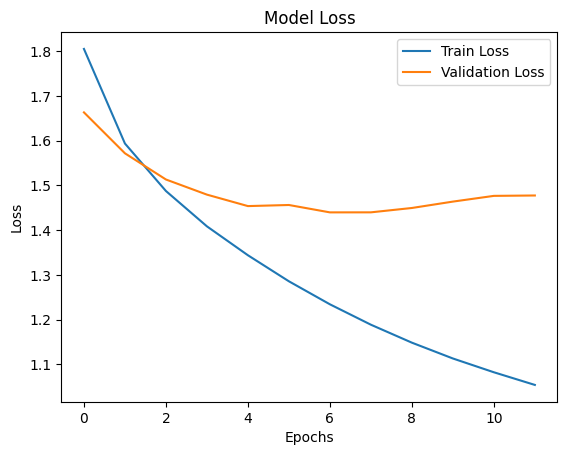

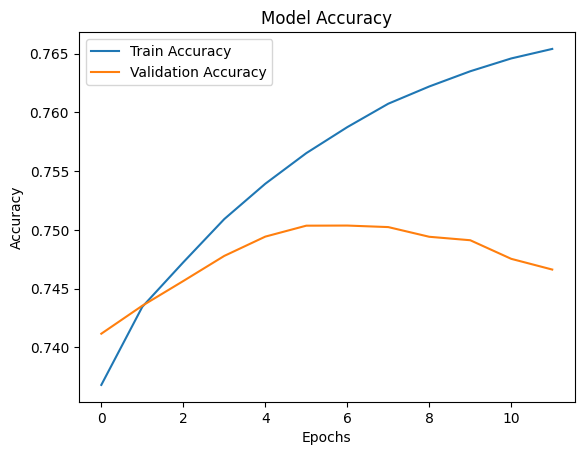

In [150]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


 # Calculate BLEU score

In [37]:
pip install nltk


In [39]:
from nltk.translate.bleu_score import corpus_bleu


In [41]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

def calculate_bleu_score(references, candidates):
    """
    Calculate BLEU score for a set of reference captions and generated captions.

    Args:
        references (list of list of str): List of reference captions for each image.
        candidates (list of str): List of generated captions for each image.

    Returns:
        dict: BLEU scores (BLEU-1, BLEU-2, BLEU-3, BLEU-4)
    """
    # Convert references and candidates into tokenized format
    tokenized_references = [[ref.split() for ref in refs] for refs in references]
    tokenized_candidates = [cand.split() for cand in candidates]

    # Calculate BLEU scores
    bleu1 = corpus_bleu(tokenized_references, tokenized_candidates, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.25, 0.25, 0.25, 0.25))

    return {"BLEU-1": bleu1, "BLEU-2": bleu2, "BLEU-3": bleu3, "BLEU-4": bleu4}


# Example usage
# Example reference captions for each image
references = [
    ["the dog is playing with a ball", "a dog plays outside with a toy"],  # References for Image 1
    ["a group of people are sitting at a table", "people are dining together"],  # References for Image 2
]

# Example generated captions
candidates = [
    "the dog is playing with a ball",  # Generated caption for Image 1
    "a group of people are sitting at the table",  # Generated caption for Image 2
]

# Calculate BLEU scores
bleu_scores = calculate_bleu_score(references, candidates)
print("BLEU Scores:", bleu_scores)


BLEU Scores: {'BLEU-1': 0.9375, 'BLEU-2': 0.8964214570007952, 'BLEU-3': 0.8760487402310554, 'BLEU-4': 0.855526185871245}


In [13]:
import numpy as np
from tensorflow.keras.models import load_model

# Paths to your saved model and tokenizer
captioning_model_path = r"C:\Users\mouli\Downloads\ExtractedFeatures\combined_captioning_checkpoint.keras"

# Load the trained captioning model
try:
    model = load_model(captioning_model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Simulate a dummy image feature vector (size must match model's input shape)
dummy_image_features = np.random.rand(1, 37376)  # Replace 37376 with your model's expected feature size

# Simulate a dummy sequence input (size must match max_length used in training)
dummy_sequence = np.zeros((1, 20))  # Replace 20 with your `max_length`

# Test a single forward pass
try:
    output = model.predict([dummy_image_features, dummy_sequence])
    print("Model prediction successful.")
    print("Output shape:", output.shape)  # Should be (1, max_length, vocab_size)
except Exception as e:
    print(f"Error during model prediction: {e}")


Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
Model prediction successful.
Output shape: (1, 37, 8495)


In [17]:
captioning_model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 512)            │    19,137,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_14 (RepeatVector) │ (None, 37, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 37, 512)        │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 37, 8495)       │     4,357,935 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,782,479 (292.90 MB)

 Trainable params: 25,594,159 (97.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,188,320 (195.27 MB)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Paths
image_path = r"C:\Users\mouli\Downloads\nikola-markelov-s0POmq_KbSU-unsplash.jpg"  # Replace with your image path
captioning_model_path = r"C:\Users\mouli\Downloads\ExtractedFeatures\combined_captioning_checkpoint.keras"
tokenizer_path = r"C:\Users\mouli\Downloads\ExtractedFeatures\tokenizer.pkl"

# Load the feature extraction model
feature_extraction_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, pooling='avg')
preprocess_fn = tf.keras.applications.inception_v3.preprocess_input
target_size = (299, 299)

# Load the trained captioning model
try:
    captioning_model = load_model(captioning_model_path)
    print("Captioning model loaded successfully.")
except Exception as e:
    print(f"Error loading captioning model: {e}")

# Load the tokenizer
try:
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    print("Tokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading tokenizer: {e}")

# Define max_length (used during training)
max_length = 20  # Replace with the actual value from training

# Extract features for the image
def extract_features(img_path, model, preprocess_fn, target_size):
    try:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_fn(img_array)
        features = model.predict(img_array)
        return features.flatten()  # Flatten the features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

# Generate a caption for the image
def generate_caption(model, image_features, tokenizer, max_length):
    caption = ['<start>']
    for _ in range(max_length):
        sequence = np.zeros((1, max_length), dtype=int)
        sequence[0, :len(caption)] = tokenizer.texts_to_sequences([caption])[0]

        prediction = model.predict([np.expand_dims(image_features, axis=0), sequence])
        predicted_word_index = np.argmax(prediction, axis=-1)[0, len(caption) - 1]
        word = tokenizer.index_word.get(predicted_word_index, '<unk>')
        if word == '<end>':
            break
        caption.append(word)
    return ' '.join(caption[1:])

# Process the image
image_features = extract_features(image_path, feature_extraction_model, preprocess_fn, target_size)
if image_features is not None:
    # Generate a caption
    generated_caption = generate_caption(captioning_model, image_features, tokenizer, max_length)

    # Display the image and the generated caption
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Generated Caption: {generated_caption}")
    plt.show()

    print(f"Generated Caption: {generated_caption}")
else:
    print("Failed to process the image.")



Captioning model loaded successfully.
Tokenizer loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_29" is incompatible with the layer: expected axis -1 of input shape to have value 37376, but received input with shape (1, 2048)[0m

Arguments received by Sequential.call():
  • inputs=('tf.Tensor(shape=(1, 2048), dtype=float32)', 'tf.Tensor(shape=(1, 20), dtype=int32)')
  • training=False
  • mask=('None', 'None')